# Evaluate Output from RNN Models

Evaluation has two main purposes:

1. Find which model parameters work best in order to iterate on producing a better model
2. Evaluate the results of the chosen "best" models

This file estabilishes multiple evaluation metrics and evaluation tooling.

The real data is used to compare the generated synthetic data to during evaluation.

### Evaluation: Utility & Individual Privacy

Evaluation is meant to ensure that the generated synthetic trajectories balance utility and privacy.  

#### 1. Utility

We evaluate whether in aggregate, the generated synthetic data is like the real data.
We also evaluate whether the process of conditionally generating synthetic trajectories with (home, work) locations is successful.

Utility evaluations are in the first part of this file.


#### 2. Privacy

We evaluate that at the individual trajectory level, the generation process introduced sufficient noise to retain individual user privacy.

Privacy evaluations are in the second part of this file.

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from eval_util import *


In [2]:
HOURS_PER_DAY = 24
TIME_PERIOD_DAYS = 5

In [3]:
def read_trajectories_from_file(filename):
    """
    Returns a list of lists, where each list represents a trajectory written to file.
    Expects file format where each line is one trajectory, and places in the trajectory are delimited by spaces.
    """
    trajectories = []
    with open(filename, 'r') as f:
        for _i, line in enumerate(f):
            line = line.strip()
            line = line.split()
            parse_line = [int(x) for x in line]
            trajectories.append(parse_line)
    return trajectories

### Load and inspect the real data

In [4]:
# Load the real trajectories data. Note these are prefixed by home,work labels
relabeled_trajectories_filename = '../data/relabeled_trajectories_1_workweek.txt'
real_trajectories = read_trajectories_from_file(relabeled_trajectories_filename)

Inspect "vocabulary size".  i.e. Number of distinct census areas in data

In [5]:
# What is the vocabulary size? i.e. how many distinct labels?
vocab = set()
for t in real_trajectories:
    vocab.update(set(t))
print(len(vocab))

652


- How many distinct home labels?
- How many distinct (home, work) label pairs?
- Of the distinct (home, work) label pairs, how many users for each?

In [6]:
home_label_to_user_count = {t[0]:0 for t in real_trajectories}
home_work_label_pair_to_user_count = {(t[0], t[1]):0 for t in real_trajectories}
for t in real_trajectories:
    home_label = t[0]
    work_label = t[1]
    home_label_to_user_count[home_label] += 1
    home_work_label_pair_to_user_count[(home_label, work_label)] += 1

print('total number of users: %s' % len(real_trajectories))
print('number of distinct home labels: %s' % len(home_label_to_user_count))
print('number of distinct (home, work) label pairs: %s' % len(home_work_label_pair_to_user_count))

total number of users: 22704
number of distinct home labels: 646
number of distinct (home, work) label pairs: 8659


### See Trajectory Patterns

There are patterns in the individual trajectories that occur naturally due to the daily routines of life.
These patterns should also occur in the generated synthetic trajectory data.


0
----- vector ----
prefix labels:  [1, 1]
[1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]


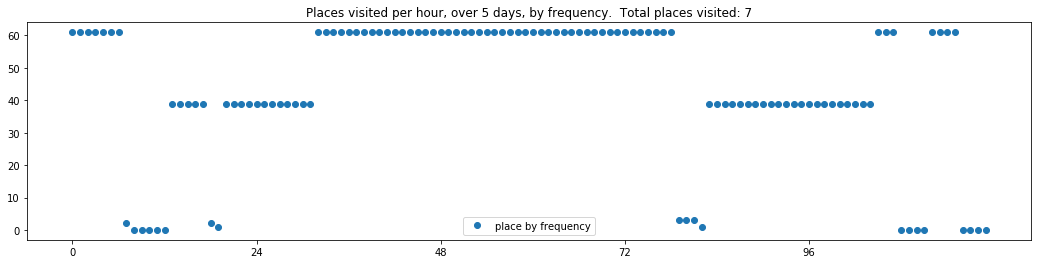

1
----- vector ----
prefix labels:  [7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0]
[0, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7]
[7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 7, 9, 0, 7, 7, 0, 0]


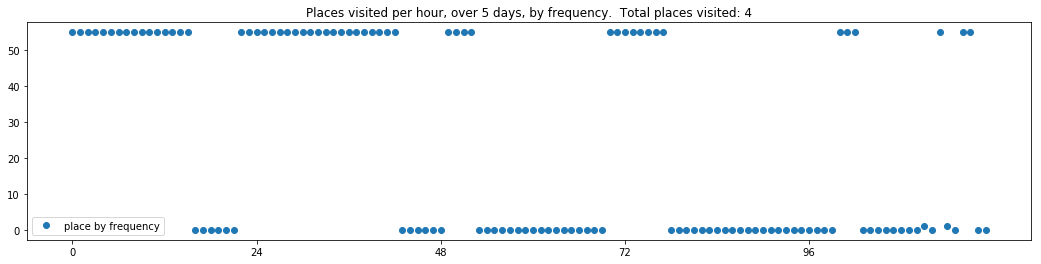

2
----- vector ----
prefix labels:  [10, 12]
[10, 11, 11, 11, 11, 11, 12, 12, 12, 13, 12, 12, 0, 12, 12, 11, 11, 11, 14, 14, 14, 14, 14, 14]
[14, 14, 14, 14, 11, 11, 0, 12, 12, 12, 12, 12, 12, 12, 12, 0, 10, 10, 10, 15, 10, 10, 10, 11]
[11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 12, 12, 11, 11, 11, 11, 0, 16, 17, 17, 17, 17]
[17, 17, 17, 0, 0, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 0, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 11, 11, 12, 12, 13, 12, 13, 18, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10]


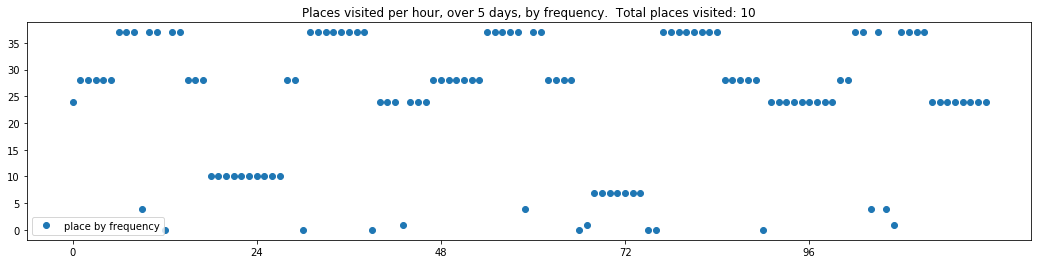

3
----- vector ----
prefix labels:  [19, 19]
[19, 19, 0, 0, 19, 19, 19, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
[19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 20, 20, 0]
[0, 0, 0, 0, 0, 0, 0, 19, 21, 21, 21, 21, 21, 21, 21, 0, 0, 19, 19, 19, 19, 19, 19, 22]


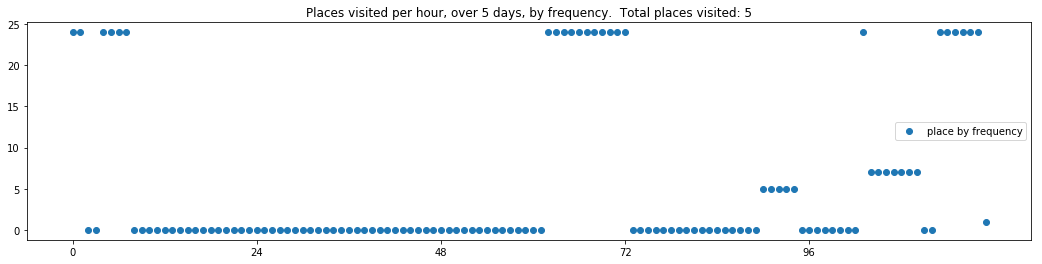

4
----- vector ----
prefix labels:  [23, 24]
[23, 23, 23, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 24, 24, 24, 24, 24, 0, 0, 23, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23]
[23, 23, 23, 23, 23, 23, 23, 23, 0, 25, 0, 0, 0, 24, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0]


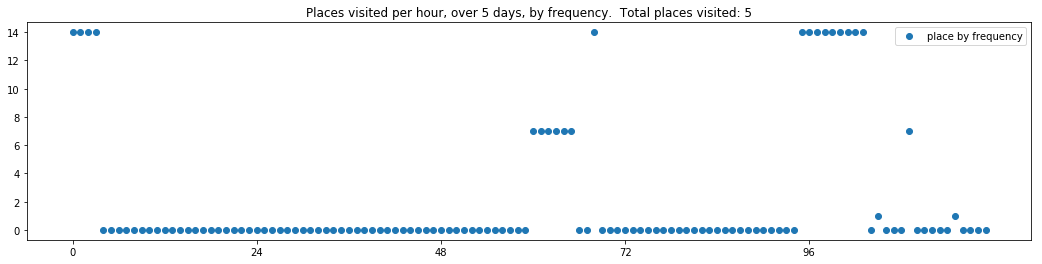

5
----- vector ----
prefix labels:  [27, 27]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 0, 0, 0, 0, 0, 0, 0, 20, 20, 27]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 21, 0, 0, 0, 0, 0, 0, 20, 20, 20]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 21, 0, 0, 0, 0, 0, 0, 20, 20, 20]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 0, 0, 0, 0, 0, 0, 0, 0, 20, 28, 27]


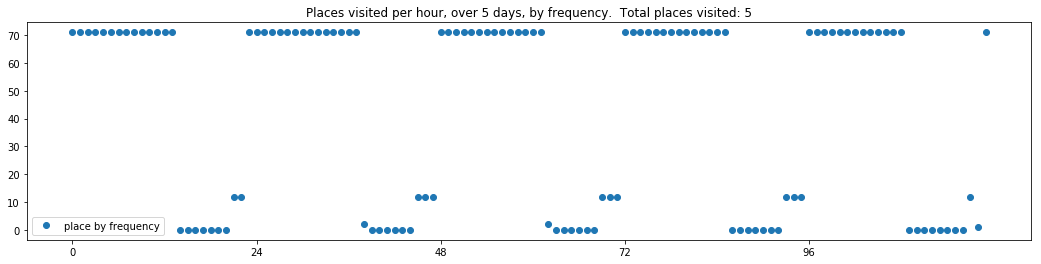

6
----- vector ----
prefix labels:  [29, 29]
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 31, 31, 32, 32, 29, 0, 0, 33, 29, 29, 29, 29, 29]
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 34, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 0, 35, 29, 29, 29, 29, 29, 29, 32, 29, 29, 29]
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 36, 36, 0, 29, 29, 29, 29, 29, 29, 29, 0, 0, 0, 29]


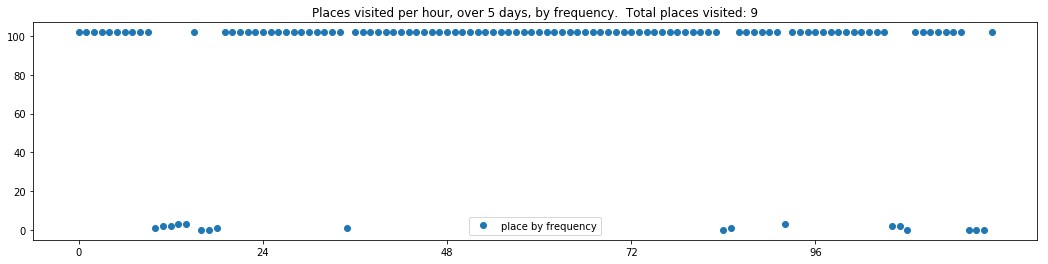

7
----- vector ----
prefix labels:  [37, 38]
[37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 37, 37]
[37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 0, 0, 0, 0, 0, 0, 39, 39, 39, 39]
[0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 38, 38, 38, 38, 38, 38, 38, 37, 37, 37]
[37, 37, 37, 37, 37, 37, 37, 37, 37, 0, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]
[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 0, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]


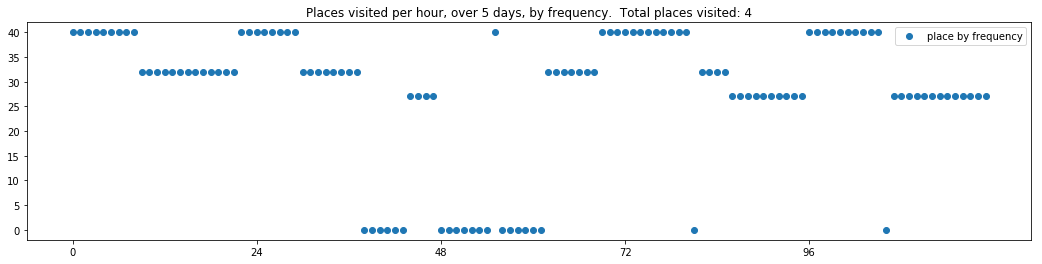

8
----- vector ----
prefix labels:  [41, 41]
[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 20, 20, 20, 20, 20, 20, 40, 40, 40, 40, 40]
[40, 40, 40, 40, 40, 40, 0, 20, 20, 20, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 40, 40, 40, 40, 40, 0, 0, 40, 40, 41, 41, 0, 42, 41, 41, 41, 41]


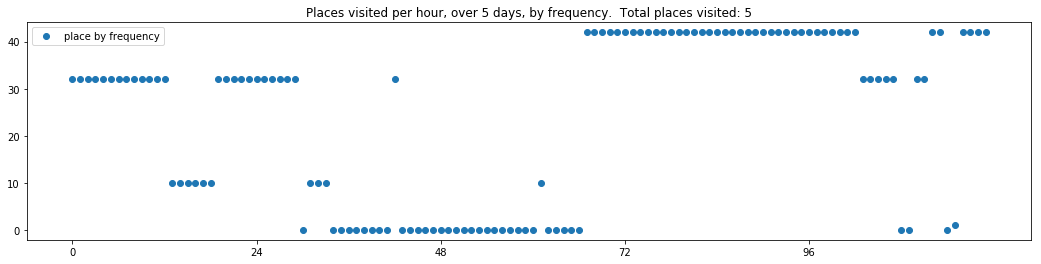

9
----- vector ----
prefix labels:  [43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 0, 0, 43, 43, 43, 43, 0, 0, 43, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 0, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 0, 0, 0, 43, 43, 43, 43, 43, 43, 43, 0, 0, 0, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 0, 0, 0, 0, 0]


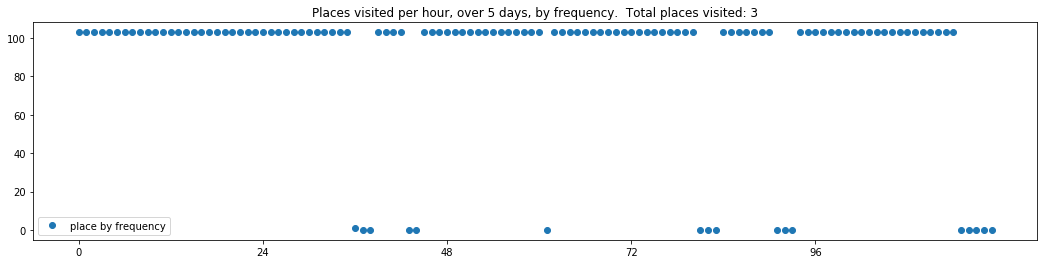

10
----- vector ----
prefix labels:  [45, 45]
[45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0]
[0, 45, 45, 45, 45, 45, 45, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 47, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 45, 45, 45, 0, 0, 0, 45, 0, 0]


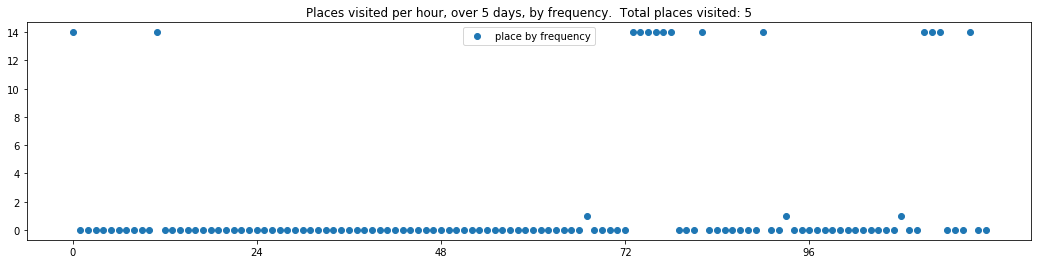

11
----- vector ----
prefix labels:  [49, 49]
[20, 0, 20, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 20, 50, 50, 51, 0, 20, 0, 0, 0]
[20, 0, 0, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 20, 20, 0, 52, 0, 22, 20, 53, 20]
[20, 0, 49, 49, 0, 0, 0, 0, 0, 0, 49, 49, 49, 20, 0, 54, 0, 0, 49, 20, 0, 0, 0, 55]
[20, 0, 0, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 56, 0, 57, 22, 20, 0, 0]
[0, 20, 20, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 58, 59, 59, 0, 58, 58, 49, 49, 20, 0, 20]


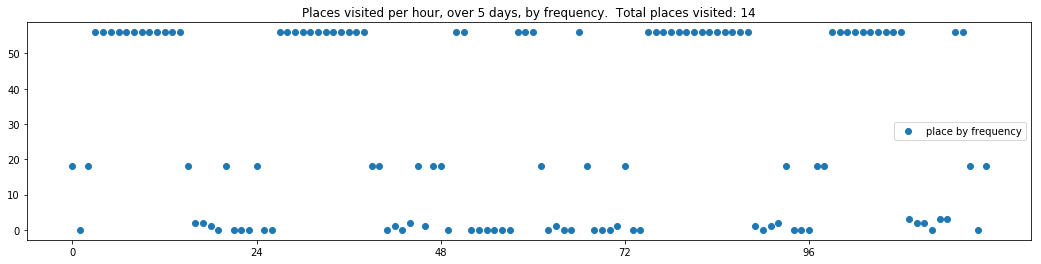

12
----- vector ----
prefix labels:  [60, 0]
[60, 60, 0, 0, 60, 60, 0, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 62, 62, 62, 62, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 60]
[60, 60, 60, 60, 60, 60, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60]
[60, 60, 60, 60, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60]


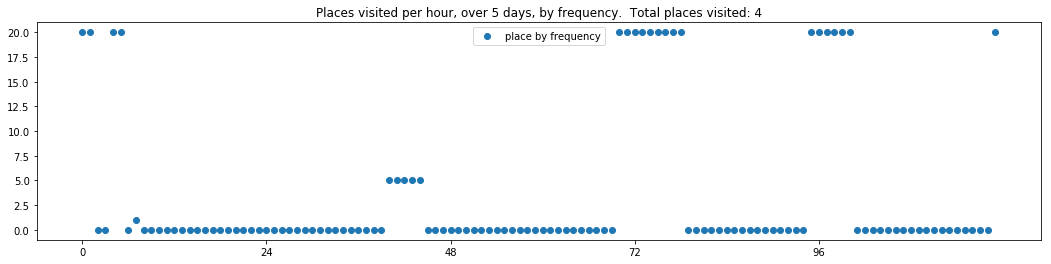

13
----- vector ----
prefix labels:  [64, 65]
[63, 63, 0, 0, 0, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 64, 64, 64, 64, 64]
[64, 64, 64, 64, 64, 64, 64, 64, 66, 65, 65, 65, 65, 65, 65, 31, 31, 67, 31, 31, 64, 64, 64, 64]
[64, 64, 64, 64, 64, 64, 64, 64, 64, 0, 65, 65, 65, 65, 65, 66, 64, 64, 64, 64, 68, 64, 64, 64]
[64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 69, 31, 31, 64, 64]
[64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 31, 31, 31, 0, 0, 66, 66, 64, 64, 64, 64, 64]


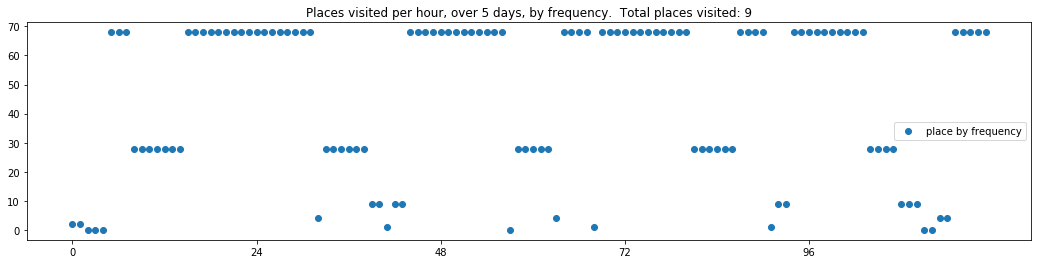

14
----- vector ----
prefix labels:  [70, 71]
[70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 70, 70, 70, 70, 70, 70, 70, 70]
[0, 70, 70, 70, 70, 70, 70, 71, 71, 71, 0, 0, 0, 0, 70, 70, 70, 70, 70, 70, 70, 70, 70, 21]
[70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 72, 70, 70, 70, 70, 70, 70, 70, 70]
[70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 0, 70, 70, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 70, 0, 0, 0, 0, 0, 0, 0]


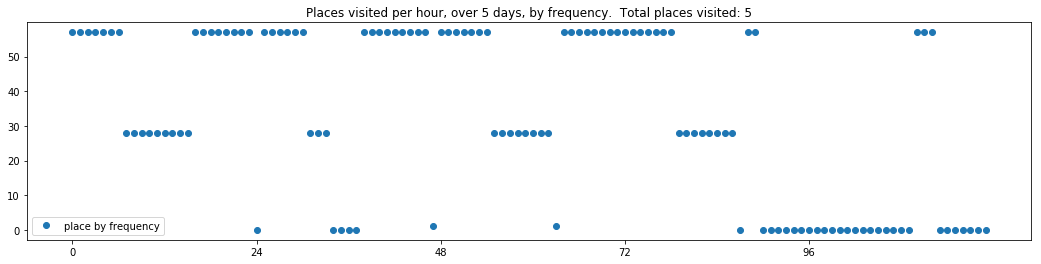

15
----- vector ----
prefix labels:  [15, 73]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 73, 73, 73, 73, 73, 73, 73, 15, 15, 15, 15, 15, 15, 15]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 0, 15, 73, 73, 73, 73, 73, 73, 73, 73, 73]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 73, 73, 73, 73, 73, 73, 73, 73, 73, 15, 0, 15, 15, 52, 52]
[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 74, 74, 8, 8, 21, 21, 21, 21, 52, 52, 52, 15]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 0, 0, 0, 0, 0, 0, 0, 0]


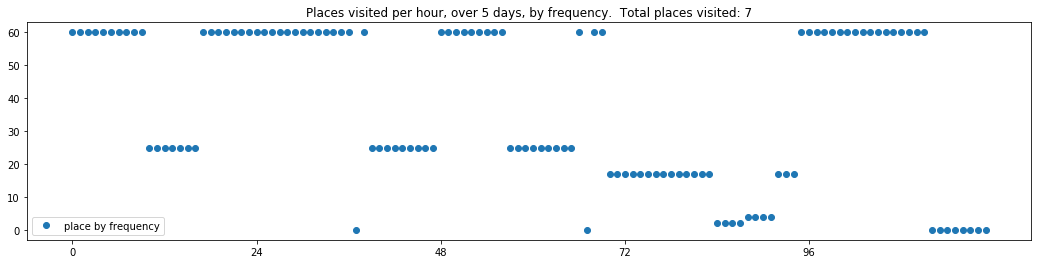

16
----- vector ----
prefix labels:  [75, 75]
[75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 0, 0, 77, 77, 77, 77, 77, 75, 75, 75, 75, 75, 75]
[75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 75, 75, 75, 75, 75, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 75]
[75, 75, 75, 75, 75, 75, 75, 75, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75]


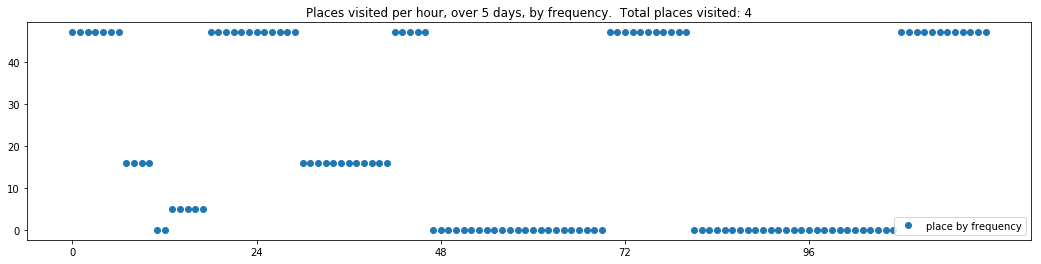

17
----- vector ----
prefix labels:  [78, 31]
[78, 78, 78, 78, 31, 79, 79, 80, 81, 31, 31, 13, 13, 34, 82, 83, 3, 31, 31, 78, 78, 20, 84, 78]
[78, 78, 78, 78, 31, 31, 31, 80, 82, 31, 31, 31, 31, 31, 35, 83, 0, 0, 0, 0, 78, 20, 84, 78]
[78, 78, 0, 78, 31, 31, 83, 83, 82, 31, 31, 31, 31, 31, 31, 85, 31, 31, 78, 78, 20, 20, 84, 78]
[78, 78, 78, 0, 0, 0, 80, 80, 82, 31, 31, 31, 31, 31, 82, 80, 35, 86, 78, 78, 20, 20, 84, 78]
[78, 78, 78, 78, 31, 31, 31, 80, 82, 31, 31, 31, 31, 31, 81, 80, 3, 85, 85, 78, 20, 53, 78, 78]


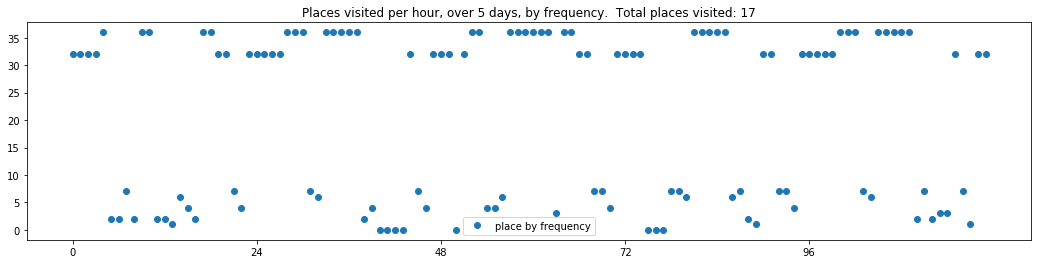

18
----- vector ----
prefix labels:  [87, 87]
[87, 87, 87, 87, 87, 87, 87, 87, 88, 89, 89, 89, 89, 89, 89, 89, 0, 89, 89, 0, 90, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 89, 89, 89, 89, 0, 0, 0, 87, 87, 87]
[87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 91, 87, 87, 87, 87, 87]
[87, 87, 87, 87, 87, 87, 87, 87, 89, 89, 89, 87, 87, 87, 87, 87, 87, 87, 87, 0, 0, 0, 87, 87]
[87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 92, 0, 87, 87, 87, 0, 0, 0, 0, 0, 0]


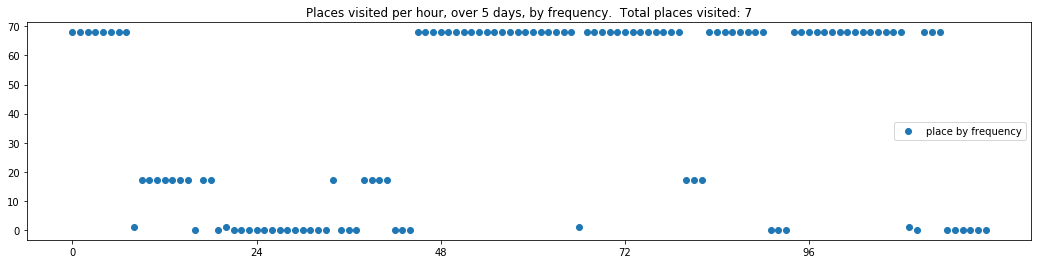

19
----- vector ----
prefix labels:  [93, 94]
[93, 93, 93, 93, 93, 93, 93, 93, 0, 0, 0, 0, 0, 0, 0, 94, 0, 93, 93, 93, 93, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 93, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 94, 94, 94, 94, 94, 94, 0, 0, 95, 0, 0, 0, 0, 0, 93]
[93, 93, 93, 93, 93, 93, 93, 93, 0, 0, 94, 94, 94, 94, 94, 94, 94, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4]


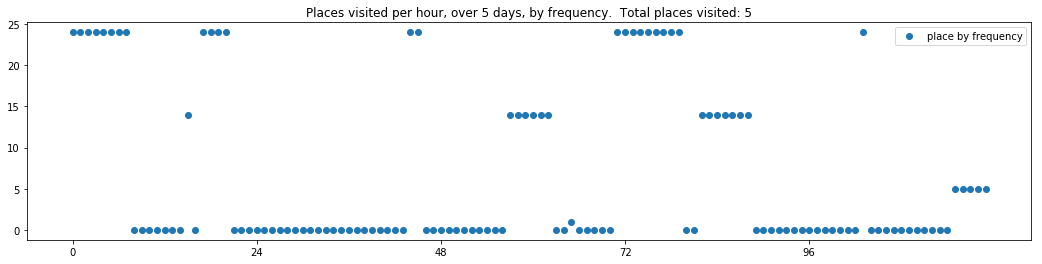

In [7]:
for t, tv in enumerate(real_trajectories[:20]):
    print(t)
    print_dwell_vector_by_days(tv)
    plot_trajectory_vector_frequencies(tv, by_frequency_order=False)

## Models Matrix for Parameter Comparisons

A bunch of models were trained with differenet parameters. Then they generated synthetic trajectoriesfollowing the same rules.
In the below matrix, each column is a list of parameters that were used to generate synthetic trajectories.
We use these parameters to read in the trajectories, and then evaluate each set of parameters by how well the trajectories their model produced performs as per our set of evaluators.

In [8]:
models_matrix_df = pd.read_csv('../textgenrnn_generator/textgenrnn_model_parameters_.csv', index_col=0)
models_matrix_df.loc['rnn_bidirectional'] = (models_matrix_df.loc['rnn_bidirectional'] == 'TRUE')
models_matrix_df = models_matrix_df.loc[models_matrix_df.index.dropna()]

Read in the trajectories produced for each set of parameters.  I.e. a trajectories file for each column.

In [9]:
# first add a row for the generated trajectories names
generated_trajectories_name_idx = 'generated_trajectories_name'
row = pd.Series({c:'' for c in models_matrix_df.columns}, name=generated_trajectories_name_idx)
models_matrix_df = models_matrix_df.append(row)
models_matrix_df

default default.1 default.2      A    A.1    A.2  \
rnn_bidirectional              False     False     False  False  False  False   
max_length                        24        24        24     24     24     24   
rnn_layers                         2         2         2      3      3      3   
rnn_size                         128       128       128    128    128    128   
dropout                          0.1       0.1       0.1    0.1    0.1    0.1   
dim_embeddings                    50        50        50     50     50     50   
temperature                      0.8       0.9         1    0.8    0.9      1   
batch size                       512       512       512    512    512    512   
generated for cambridge          GPU       yes       yes    yes    yes    yes   
generated for general sample     GPU       yes       yes   TODO   TODO    NaN   
generated_trajectories_name                                                     

                                  B    B.1    B.2      C        ...         \
rnn_bidirectional             False  False  False  False        ...          
max_length                       24     24     24     24        ...          
rnn_layers                        2      2      2      2        ...          
rnn_size                        256    256    256    128        ...          
dropout                         0.1    0.1    0.1    0.2        ...          
dim_embeddings                   50     50     50     50        ...          
temperature                     0.8    0.9      1    0.8        ...          
batch size                      512    512    512    512        ...          
generated for cambridge          no     no     no    yes        ...          
generated for general sample    yes    yes    yes   done        ...          
generated_trajectories_name                                     ...          

                             Y-bidirectional Y-bidirectional.1  \
rnn_bidirectional                       True              True   
max_length                                60                60   
rnn_layers                                 3                 3   
rnn_size                                 256               256   
dropout                                  0.3               0.3   
dim_embeddings                           100               100   
temperature                              0.8               0.9   
batch size                              1024              1024   
generated for cambridge                  NaN               NaN   
generated for general sample             NaN               NaN   
generated_trajectories_name                                      

                             Y-bidirectional.2 Y-bidirectional.3  \
rnn_bidirectional                         True              True   
max_length                                  60                60   
rnn_layers                                   3                 3   
rnn_size                                   256               256   
dropout                                    0.3               0.3   
dim_embeddings                             100               100   
temperature                                  1               1.1   
batch size                                1024              1024   
generated for cambridge                    NaN               NaN   
generated for general sample               NaN               NaN   
generated_trajectories_name                                        

                             Y-bidirectional.4         Z-bidirectional  \
rnn_bidirectional                         True                    True   
max_length                                  60                      72   
rnn_layers                                   3                       2   
rnn_size                                   256                     256   
dropout                                    0.3                     0.3   
dim_embeddings                             100                   

In [10]:
# Save in memory a mapping of {generated_trajectories_name -> list of trajectories}
# where the generated_trajectories_name is determined by the models parameters
generated_sample_trajectories_map = {}

for column_name in models_matrix_df.columns:
    col = models_matrix_df[column_name]
    model_name = 'trajectories-rnn_bidirectional:{}-max_len:{}-rnn_layers:{}-rnn_size:{}-dropout:{}-dim_embeddings:{}'.format(
        col['rnn_bidirectional'],col['max_length'],col['rnn_layers'],col['rnn_size'],col['dropout'],col['dim_embeddings'])
    generated_trajectories_name = 'generated-sample-{}-temperature:{}'.format(
        model_name, float(col['temperature']))

    try:
        generated_trajectories_filepath = '../textgenrnn_generator/output/{}.txt'.format(generated_trajectories_name)
        generated_trajectories = read_trajectories_from_file(generated_trajectories_filepath)
        models_matrix_df.loc[generated_trajectories_name_idx][column_name] = generated_trajectories_name
        generated_sample_trajectories_map[generated_trajectories_name] = generated_trajectories
    except FileNotFoundError as e:
        # print(e)
        print('dropping column for', generated_trajectories_name)
        models_matrix_df.drop(columns=[column_name], inplace=True)
    continue
    
models_matrix_df

dropping column for generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.8
dropping column for generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.9
dropping column for generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:1.0
dropping column for generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:100-temperature:0.8
dropping column for generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:100-temperature:0.9
dropping column for generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:100-temperature:1.0
dropping column for generated-sample-trajectories-rnn_b

default  \
rnn_bidirectional                                                         False   
max_length                                                                   24   
rnn_layers                                                                    2   
rnn_size                                                                    128   
dropout                                                                     0.1   
dim_embeddings                                                               50   
temperature                                                                 0.8   
batch size                                                                  512   
generated for cambridge                                                     GPU   
generated for general sample                                                GPU   
generated_trajectories_name   generated-sample-trajectories-rnn_bidirectiona...   

                                                                      default.1  \
rnn_bidirectional                                                         False   
max_length                                                                   24   
rnn_layers                                                                    2   
rnn_size                                                                    128   
dropout                                                                     0.1   
dim_embeddings                                                               50   
temperature                                                                 0.9   
batch size                                                                  512   
generated for cambridge                                                     yes   
generated for general sample                                                yes   
generated_trajectories_name   generated-sample-trajectories-rnn_bidirectiona...   

                                                                      default.2  \
rnn_bidirectional                                                         False   
max_length                                                                   24   
rnn_layers                                                                    2   
rnn_size                                                                    128   
dropout                                                                     0.1   
dim_embeddings                                                               50   
temperature                                                                   1   
batch size                                                                  512   
generated for cambridge                                                     yes   
generated for general sample                                                yes   
generated_trajectories_name   generated-sample-trajectories-rnn_bidirectiona...   

                                                                              B  \
rnn_bidirectional                                                         False   
max_length                                                                   24   
rnn_layers                                                                    2   
rnn_size                                                                    256   
dropout                                                                     0.1   
dim_embeddings                                                               50   
temperature                                                                 0.8   
batch size                                                                  512   
generated for cambridge                                                      no   
generated for general sample                                                yes   
generated_trajectories_name   generated-sample-trajectories-rnn_bidirectiona...   

                                                                            B.1  \
r

In [11]:
models_matrix_df.drop(['generated for cambridge', 'generated for general sample'], axis=0, inplace=True)

In [12]:
# And add in these other ones...
# TODO: update this to rename trajectories/models by  parameters and better fit in pipeline

cs = [
    'generated-sample-synthetic_trajectories-temperature:0.8',
    'generated-sample-synthetic_trajectories-temperature:0.9',
    'generated-sample-synthetic_trajectories-temperature:1.0',
]
for c in cs:
    models_matrix_df[c] = [[np.nan]]*len(models_matrix_df)
    generated_trajectories_name = c
    generated_trajectories_filepath = '../textgenrnn_generator/output/{}.txt'.format(generated_trajectories_name)
    generated_trajectories = read_trajectories_from_file(generated_trajectories_filepath)
    models_matrix_df.loc[generated_trajectories_name_idx][c] = generated_trajectories_name
    generated_sample_trajectories_map[generated_trajectories_name] = generated_trajectories

models_matrix_df

default  \
rnn_bidirectional                                                        False   
max_length                                                                  24   
rnn_layers                                                                   2   
rnn_size                                                                   128   
dropout                                                                    0.1   
dim_embeddings                                                              50   
temperature                                                                0.8   
batch size                                                                 512   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   

                                                                     default.1  \
rnn_bidirectional                                                        False   
max_length                                                                  24   
rnn_layers                                                                   2   
rnn_size                                                                   128   
dropout                                                                    0.1   
dim_embeddings                                                              50   
temperature                                                                0.9   
batch size                                                                 512   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   

                                                                     default.2  \
rnn_bidirectional                                                        False   
max_length                                                                  24   
rnn_layers                                                                   2   
rnn_size                                                                   128   
dropout                                                                    0.1   
dim_embeddings                                                              50   
temperature                                                                  1   
batch size                                                                 512   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   

                                                                             B  \
rnn_bidirectional                                                        False   
max_length                                                                  24   
rnn_layers                                                                   2   
rnn_size                                                                   256   
dropout                                                                    0.1   
dim_embeddings                                                              50   
temperature                                                                0.8   
batch size                                                                 512   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   

                                                                           B.1  \
rnn_bidirectional                                                        False   
max_length                                                                  24   
rnn_layers                                                                   2   
rnn_size                                                                   256   
dropout                                                                    0.1   
dim_embeddings                                                              50   
temperature                                                                0.9   
batch size                                                                 512   
generated_trajectories_name  generated-sample-tra

## Evaluation

Visualize a random sample of trajectories from each model output


-------showing vectors for model: default-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.8
----- vector ----
prefix labels:  [598, 598]
[0, 0, 0, 0, 0, 0, 0, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598]
[598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598]
[598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 24, 24, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598]
[598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 0, 0, 0, 0, 0, 0, 598, 598]
[598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598, 598]


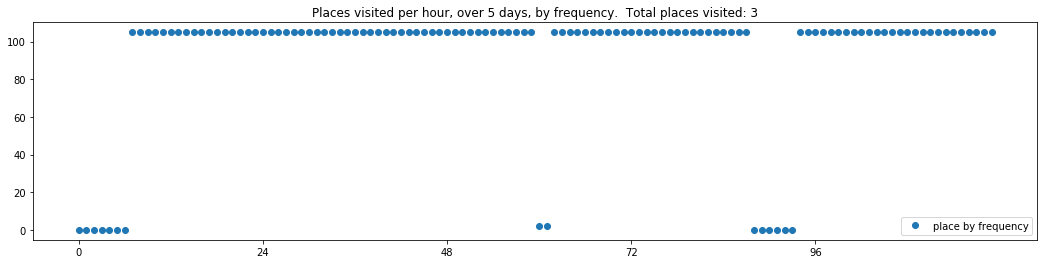

----- vector ----
prefix labels:  [189, 189]
[0, 0, 0, 0, 0, 0, 0, 0, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189]
[189, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 189, 189, 189, 189, 189, 189, 189, 189, 189, 0, 0]


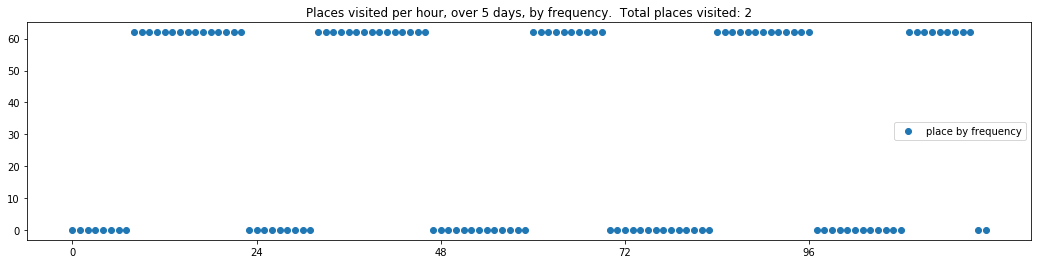

----- vector ----
prefix labels:  [500, 21]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


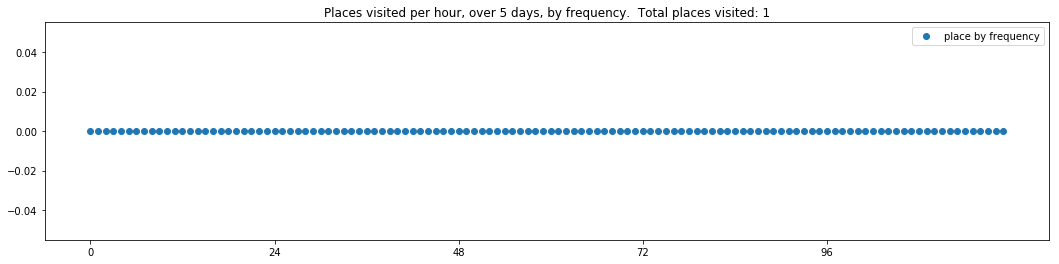


-------showing vectors for model: default.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.9
----- vector ----
prefix labels:  [413, 413]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 413, 413, 413, 413, 413, 413, 413, 413, 413, 413, 413, 413, 413]
[413, 413, 413, 413, 0, 0, 0, 0, 0, 0, 0, 0, 413, 413, 413, 413, 413, 413, 413, 413, 413, 413, 413, 413]
[413, 413, 413, 413, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 413, 413, 413, 413, 413, 413, 413, 413, 413]
[413, 413, 413, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 413, 413, 413, 413, 413, 413, 413, 413, 413]
[413, 413, 413, 413, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 413, 413, 413, 413, 413, 413, 413, 413]


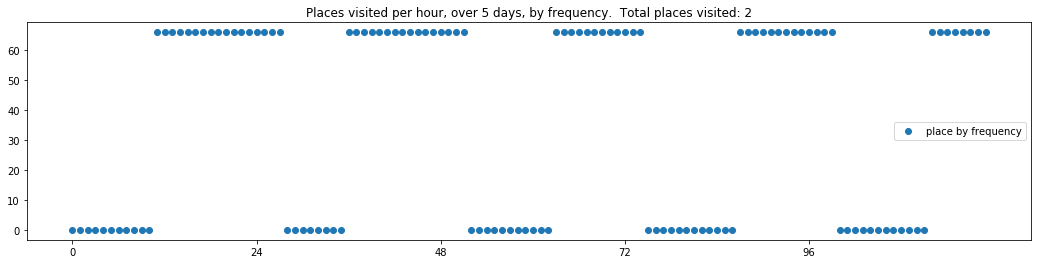

----- vector ----
prefix labels:  [613, 136]
[0, 0, 0, 0, 0, 0, 136, 136, 136, 136, 136, 136, 136, 136, 136, 0, 613, 613, 613, 613, 613, 613, 613, 613]
[613, 613, 613, 613, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 613]
[613, 613, 613, 613, 613, 613, 613, 613, 613, 613, 0, 0, 8, 8, 55, 0, 0, 0, 0, 0, 0, 0, 0, 262]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 29, 0, 420, 420, 420, 420, 420, 420, 420, 420]
[420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420]


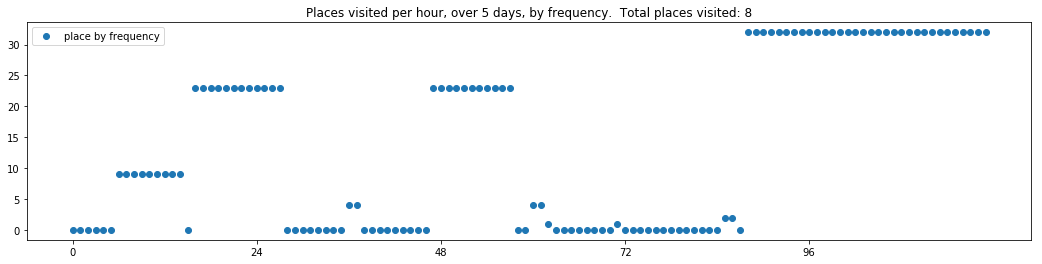

----- vector ----
prefix labels:  [202, 202]
[0, 0, 0, 0, 0, 0, 0, 0, 68, 68, 27, 27, 27, 0, 27, 27, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


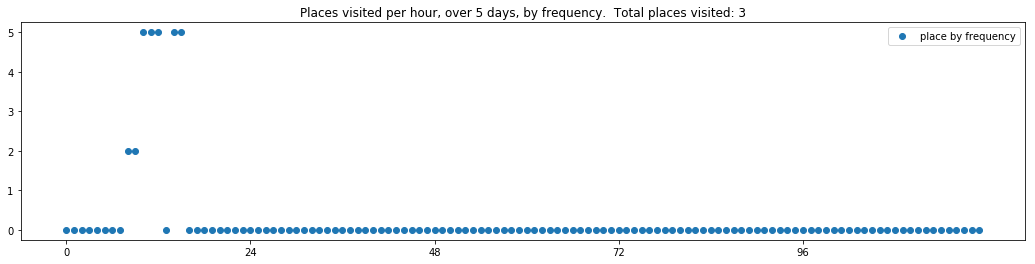


-------showing vectors for model: default.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:1.0
----- vector ----
prefix labels:  [103, 539]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103, 103, 103, 103, 103, 103]
[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103]
[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103]
[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 103]
[103, 103, 103, 103, 103, 103, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


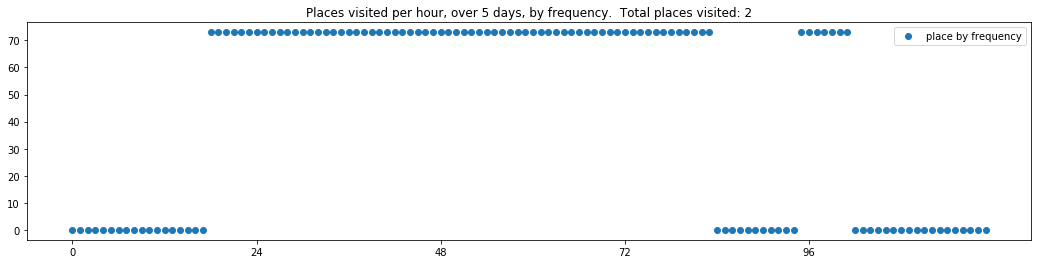

----- vector ----
prefix labels:  [411, 411]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 222, 222, 411, 411, 411, 101, 101]
[0, 617, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 367, 222, 222, 222, 411, 411, 617, 617]
[84, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 0, 0, 0, 411, 411, 341, 341, 0, 411]
[411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 0, 0, 0, 0, 289, 411, 411, 396, 96, 411, 411]
[411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 411, 289, 289, 289, 411, 411, 289, 289, 289, 411, 411, 411, 411, 411]


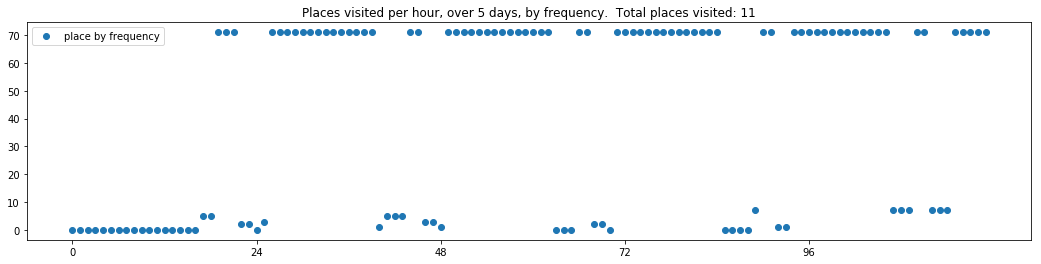

----- vector ----
prefix labels:  [639, 385]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 390, 639, 639, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 465, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 461, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 461, 461, 0, 0, 461, 461, 461, 461, 461]
[461, 461, 461, 461, 320, 320, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 461, 461, 461, 461, 461]


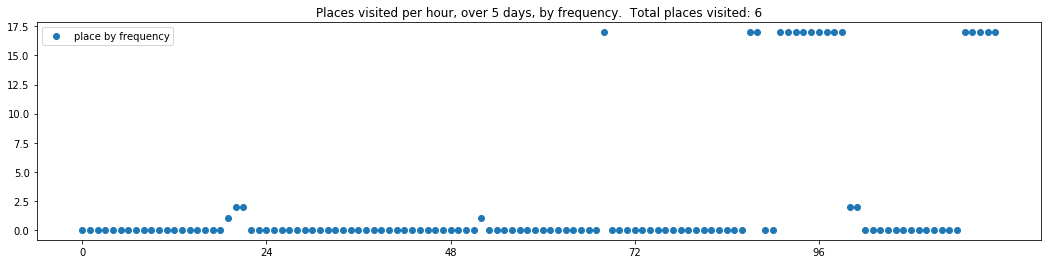


-------showing vectors for model: B-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:256-dropout:0.1-dim_embeddings:50-temperature:0.8
----- vector ----
prefix labels:  [205, 162]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 205, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


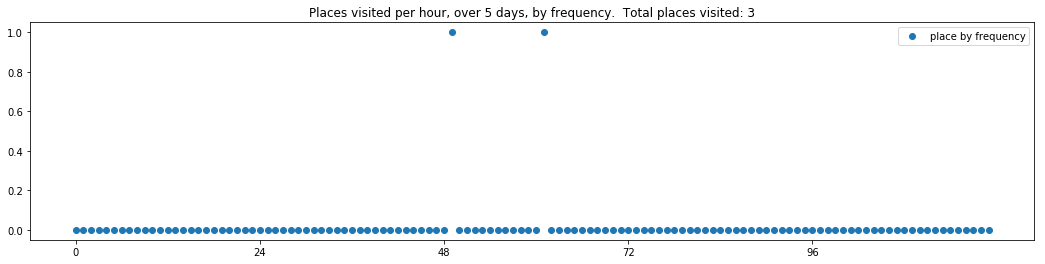

----- vector ----
prefix labels:  [590, 296]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 191, 191, 191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[191, 191, 191, 191, 191, 345, 453, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


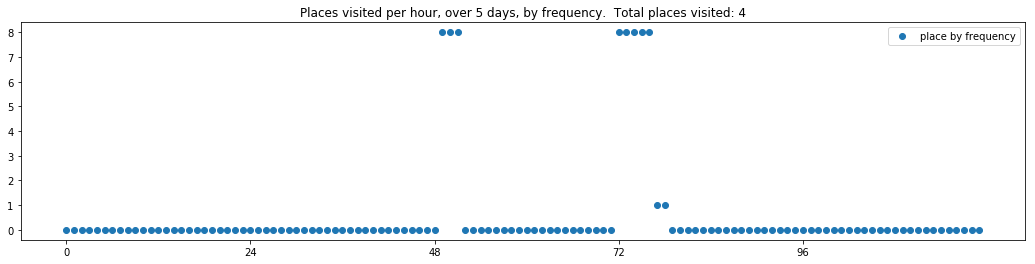

----- vector ----
prefix labels:  [272, 272]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[165, 165, 135, 135, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


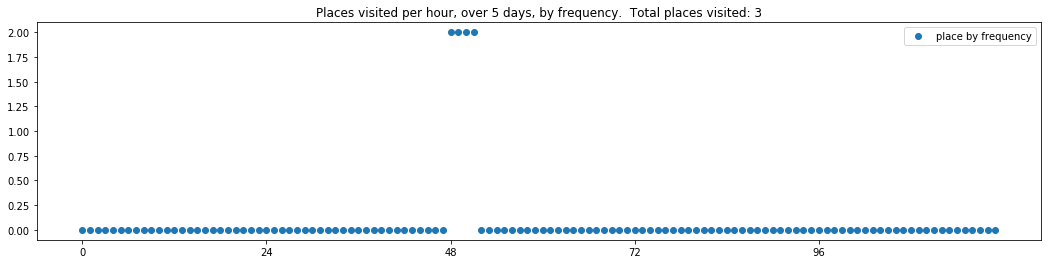


-------showing vectors for model: B.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:256-dropout:0.1-dim_embeddings:50-temperature:0.9
----- vector ----
prefix labels:  [431, 99]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0]


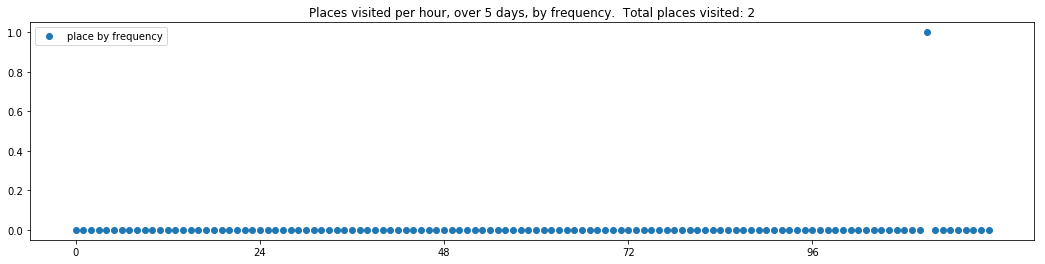

----- vector ----
prefix labels:  [362, 362]
[0, 0, 0, 0, 0, 0, 0, 0, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362]
[362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362]
[362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362]
[362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362]
[362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362, 362]


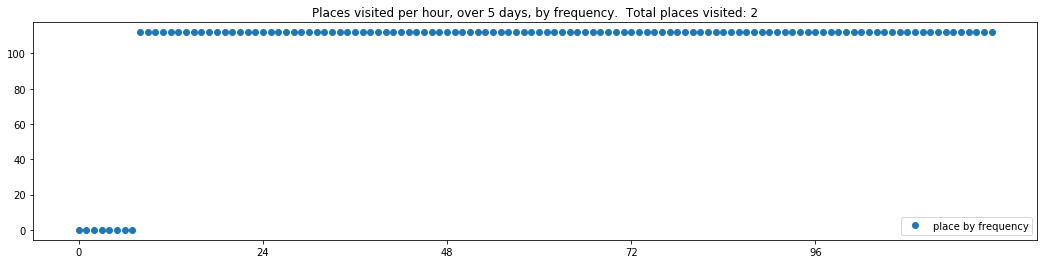

----- vector ----
prefix labels:  [607, 607]
[0, 0, 0, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607]
[607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607]
[607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607]
[607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607]
[607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607]


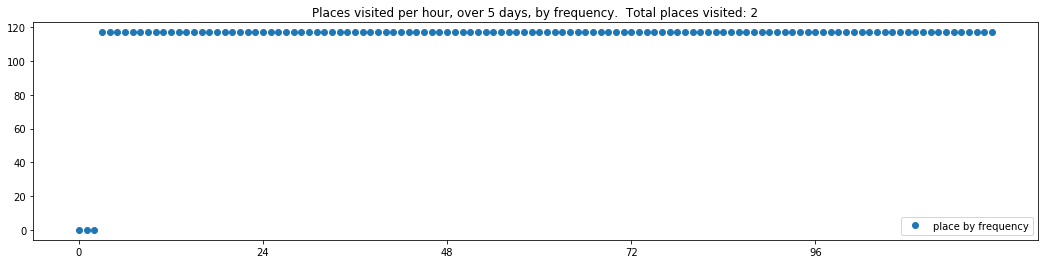


-------showing vectors for model: B.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:256-dropout:0.1-dim_embeddings:50-temperature:1.0
----- vector ----
prefix labels:  [437, 437]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 120, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0]
[0, 0, 0, 151, 151, 0, 0, 0, 0, 70, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[208, 183, 0, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 142, 0, 0, 0, 0, 236, 597, 597, 597, 597, 0, 0, 0, 215, 0, 434, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


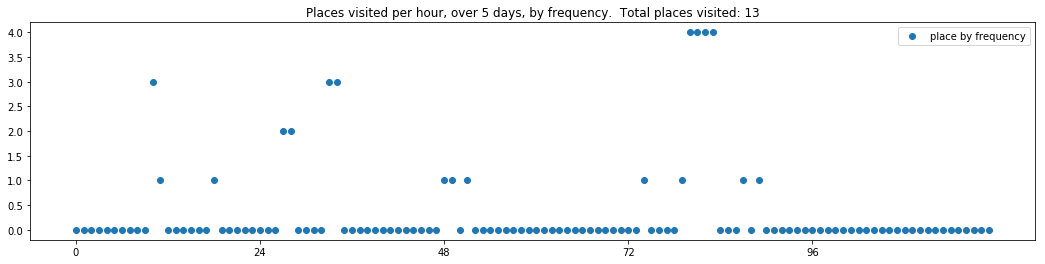

----- vector ----
prefix labels:  [594, 302]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 143, 557, 557, 143, 0, 301, 5, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 208, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 87, 87, 87, 506, 87, 0, 0, 0, 0, 0, 0, 0, 0, 87, 87, 87, 87]
[87, 87, 0, 87, 87, 87, 87, 87, 87, 87, 120, 87, 87, 87, 87, 0, 0, 87, 87, 87, 87, 87, 87, 87]
[87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 483, 87, 87, 87, 87, 87, 87, 87, 87, 87]


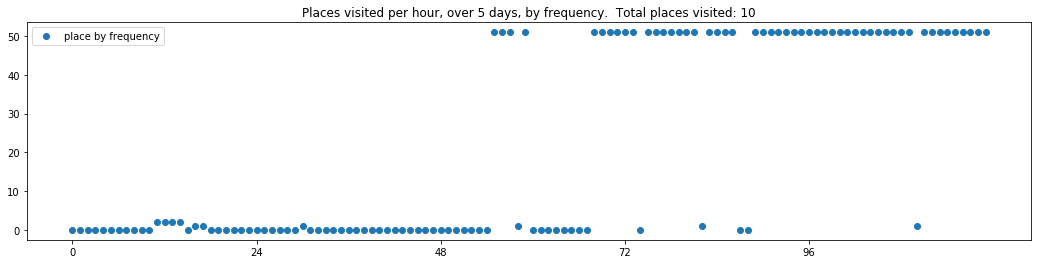

----- vector ----
prefix labels:  [95, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 0, 0, 385, 0, 0, 0, 0, 256]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 488, 488, 0, 0, 309, 309, 615, 119, 0, 0, 0, 0, 0, 390, 390, 390, 0, 0, 0, 295, 0]
[0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 390, 390, 390, 390, 0, 0, 0, 0, 0]
[0, 0, 0, 357, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


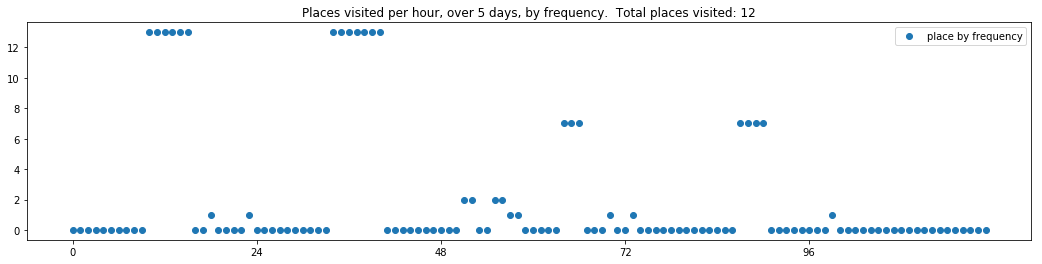


-------showing vectors for model: C-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.2-dim_embeddings:50-temperature:0.8
----- vector ----
prefix labels:  [163, 540]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 163]
[163, 163, 163, 163, 163, 163, 163, 163, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 163]
[163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 163, 163, 163, 163, 0, 163, 163, 163, 163, 163, 163, 163, 163, 163]
[163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163]


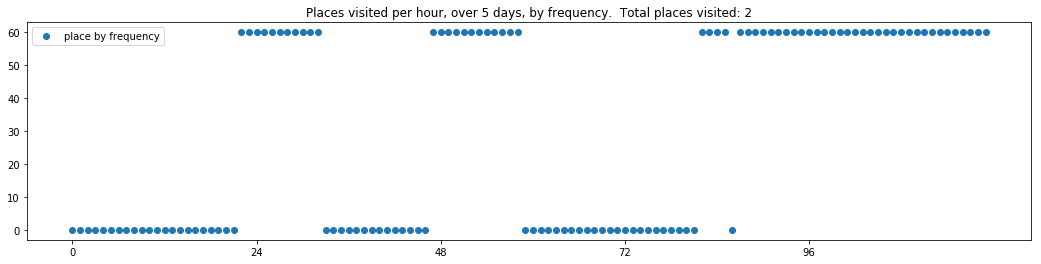

----- vector ----
prefix labels:  [198, 198]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 198, 198]
[198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198]
[198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198]
[198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198]
[198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198]


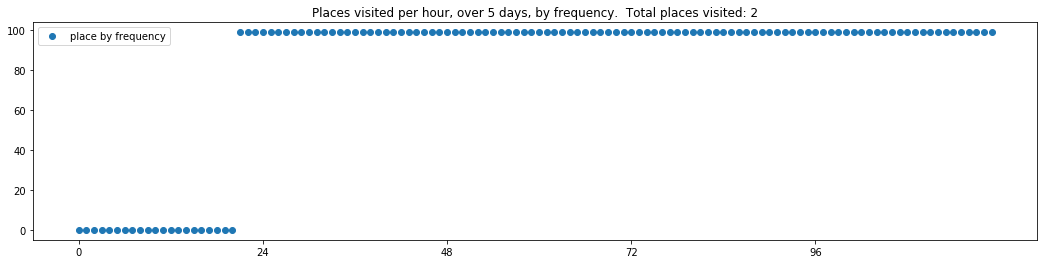

----- vector ----
prefix labels:  [333, 379]
[0, 0, 0, 0, 0, 0, 0, 0, 333, 333, 333, 333, 413, 333, 333, 0, 0, 0, 0, 333, 333, 333, 333, 333]
[333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 333, 333]
[333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333]
[333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333]
[333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333]


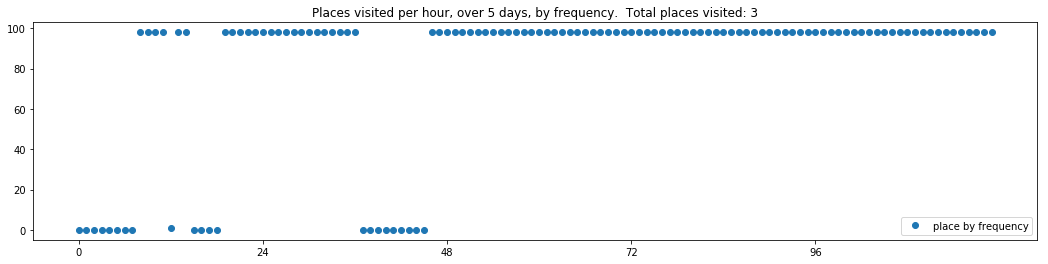


-------showing vectors for model: C.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.2-dim_embeddings:50-temperature:0.9
----- vector ----
prefix labels:  [151, 151]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 151]
[151, 151, 151, 151, 151, 151, 151, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 151]
[151, 151, 151, 151, 151, 151, 151, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 151]
[151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151]
[151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151]


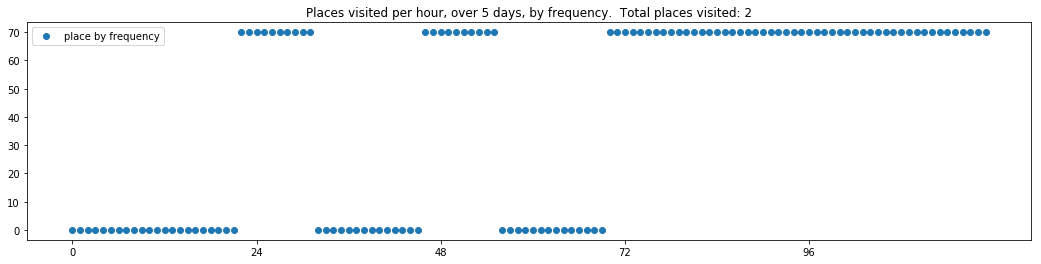

----- vector ----
prefix labels:  [271, 271]
[0, 0, 0, 0, 0, 0, 0, 0, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 388, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 33, 33, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 500, 500, 500]
[500, 500, 500, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 500, 500, 500]


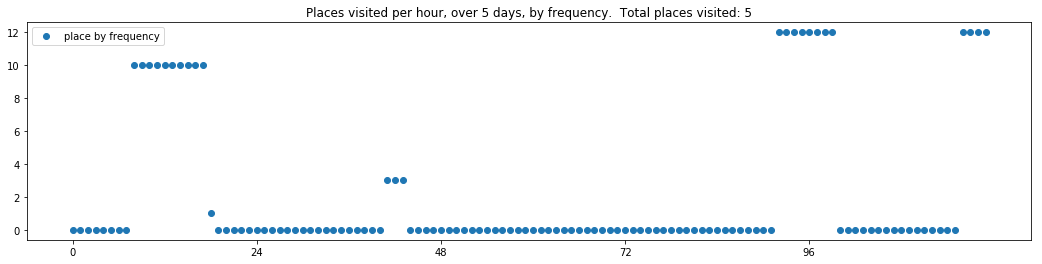

----- vector ----
prefix labels:  [639, 195]
[0, 0, 0, 0, 0, 0, 0, 639, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 639, 639, 639, 639, 639, 639]
[639, 639, 639, 639, 639, 639, 639, 639, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 311, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 392, 392, 392, 392, 392, 392, 392, 392, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 392, 392, 392, 392, 392, 392, 392, 392, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 521, 0, 0, 392, 392, 392, 392, 392, 392, 392, 0, 0, 0, 0, 0, 0, 0]


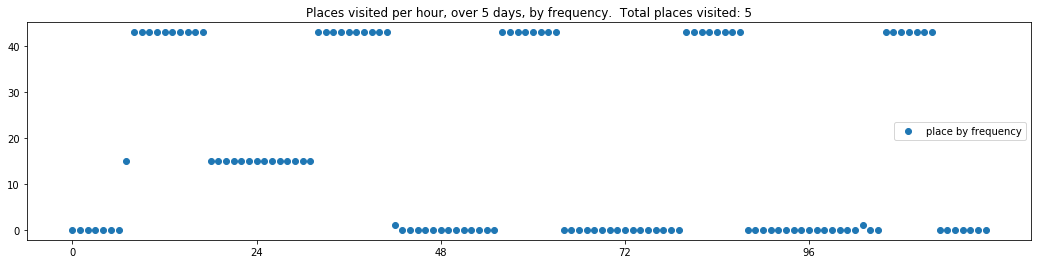


-------showing vectors for model: C.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.2-dim_embeddings:50-temperature:1.0
----- vector ----
prefix labels:  [146, 146]
[0, 0, 0, 0, 0, 0, 0, 146, 397, 397, 397, 397, 146, 146, 146, 0, 236, 146, 146, 0, 146, 146, 146, 146]
[146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 397, 0, 146, 146, 146, 146, 146, 146, 397, 397, 146, 146, 146]
[146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
[146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
[146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]


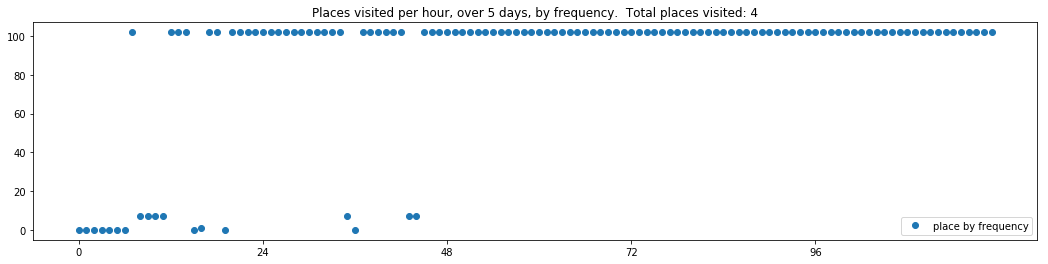

----- vector ----
prefix labels:  [4, 87]
[0, 0, 0, 0, 0, 0, 0, 200, 200, 200, 0, 0, 55, 266, 266, 266, 266, 87, 0, 0, 4, 4, 4, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 629, 629, 629, 629, 629]
[629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629]
[629, 629, 629, 629, 629, 629, 629, 629, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 629, 629, 629, 629, 629]


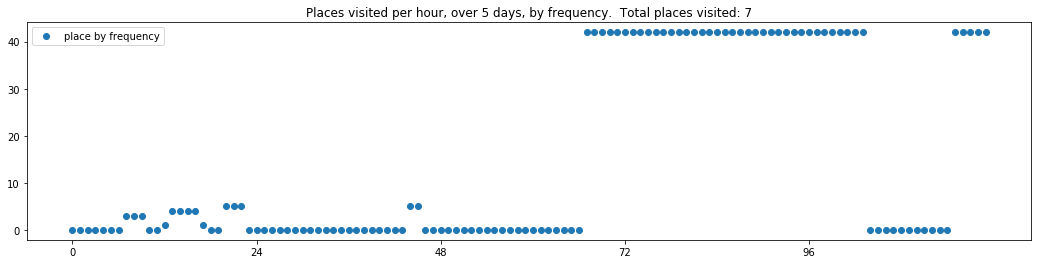

----- vector ----
prefix labels:  [478, 478]
[0, 0, 0, 0, 0, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 0, 0, 0, 0, 478, 478, 478]
[478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 478, 478, 478, 478, 478, 478, 478, 478, 478, 0, 0, 478, 478, 478, 478, 478, 151, 151, 151, 151, 151, 151]
[151, 151, 151, 151, 478, 478, 151, 151, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 0, 151, 151, 151, 151, 151]
[151, 151, 151, 151, 0, 0, 478, 478, 478, 478, 478, 478, 478, 478, 0, 0, 0, 0, 0, 0, 151, 151, 151, 151]


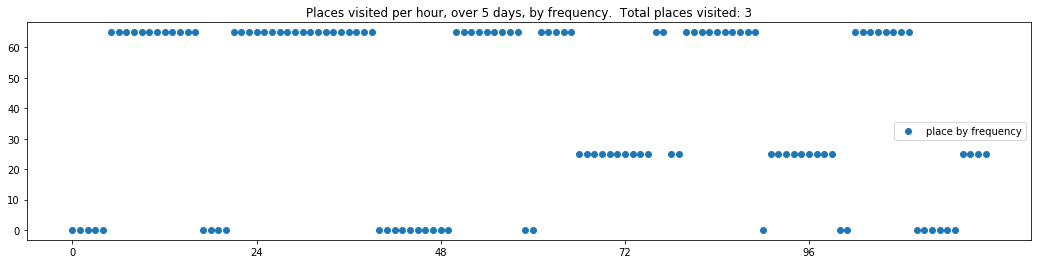


-------showing vectors for model: E-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:48-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.8
----- vector ----
prefix labels:  [304, 304]
[0, 0, 0, 0, 0, 0, 562, 562, 184, 0, 0, 0, 0, 0, 0, 304, 304, 304, 304, 304, 304, 304, 304, 304]
[304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304]
[304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304]
[304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304]
[304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304]


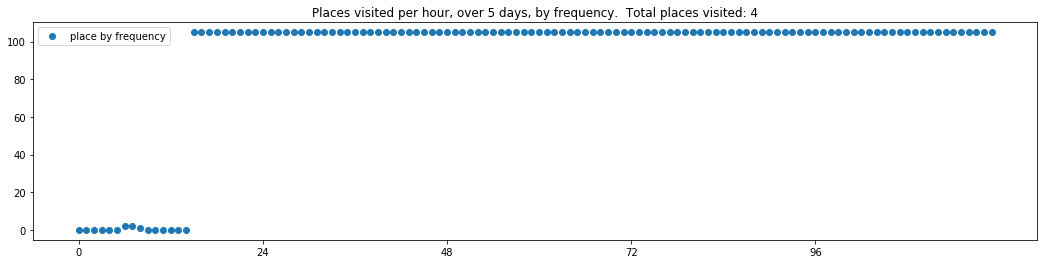

----- vector ----
prefix labels:  [44, 44]
[0, 0, 0, 0, 0, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
[44, 44, 44, 44, 0, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]


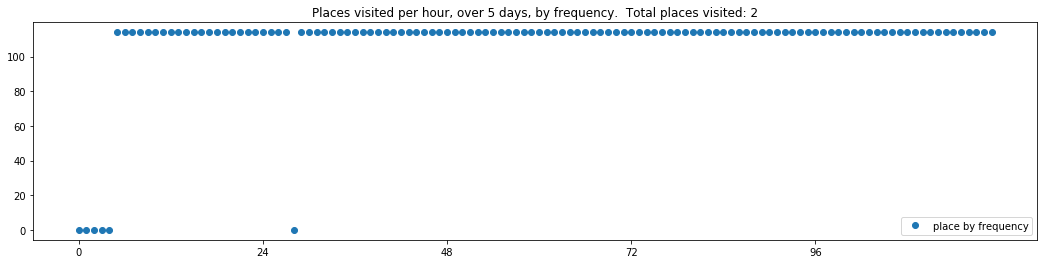

----- vector ----
prefix labels:  [71, 71]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 71, 71, 71, 71, 71, 71, 71, 71, 71]
[71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71]
[71, 71, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71]
[71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71]


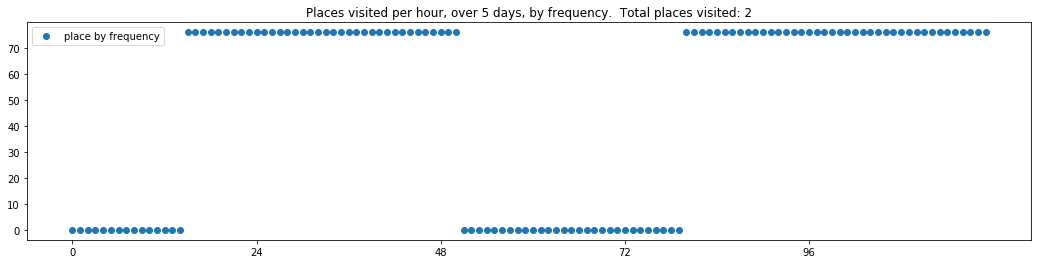


-------showing vectors for model: E.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:48-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.9
----- vector ----
prefix labels:  [223, 112]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 259, 259, 259, 434, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


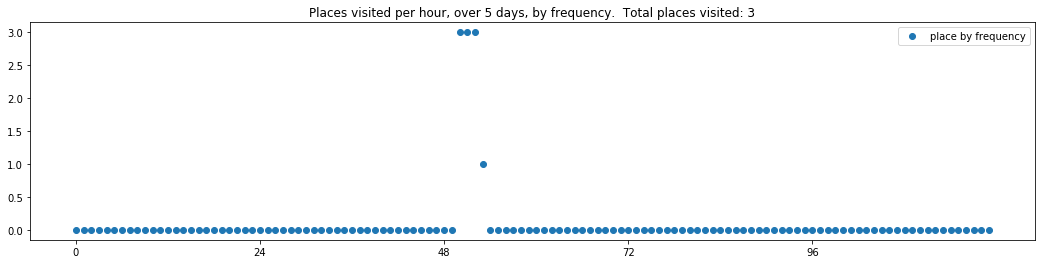

----- vector ----
prefix labels:  [276, 456]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22]
[22, 22, 22, 22, 22, 22, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 22, 22, 22, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


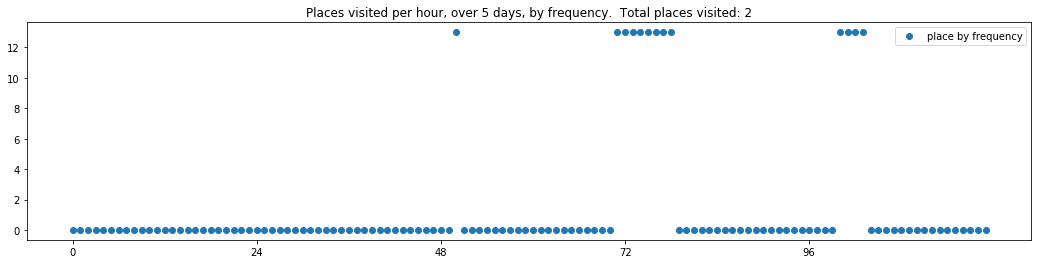

----- vector ----
prefix labels:  [427, 427]
[0, 0, 0, 0, 0, 0, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427]
[427, 0, 0, 0, 0, 0, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427]
[427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427]
[427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427]
[427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427]


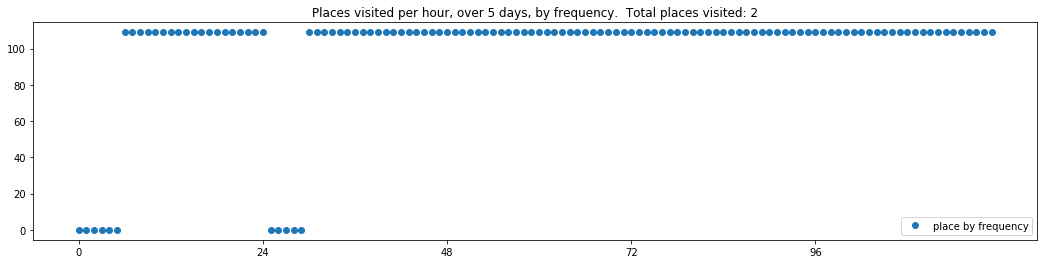


-------showing vectors for model: E.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:48-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:1.0
----- vector ----
prefix labels:  [323, 323]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 323, 323, 0, 537, 177, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 581, 581, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 374]
[374, 374, 374, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


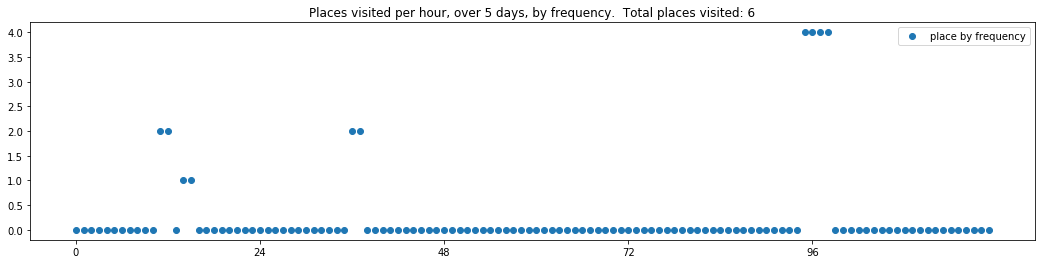

----- vector ----
prefix labels:  [560, 560]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 326, 515, 639, 0, 0, 0, 0, 0, 0, 560, 560]
[560, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 223, 0, 223, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 146, 146, 146, 146, 146, 530, 0, 0, 0, 0, 0, 0, 0, 0]


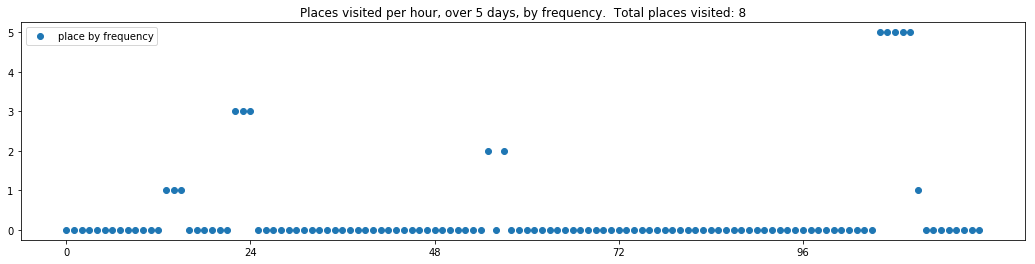

----- vector ----
prefix labels:  [341, 341]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 93, 93, 93, 357, 8, 203, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 567, 0, 0, 0, 567, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[414, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 259, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


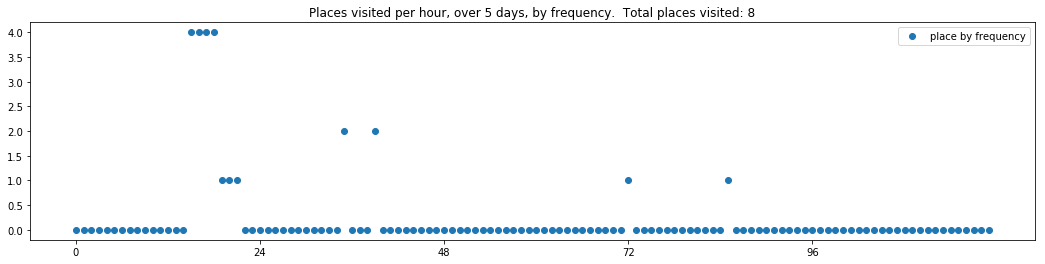


-------showing vectors for model: O-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:48-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.8
----- vector ----
prefix labels:  [4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


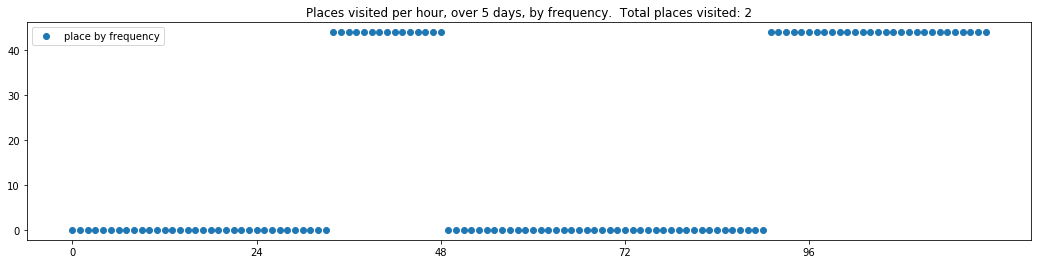

----- vector ----
prefix labels:  [613, 449]
[0, 0, 0, 0, 0, 0, 0, 0, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 613, 613, 613, 613, 613]
[613, 613, 613, 613, 613, 613, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449]
[449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 613, 613, 613]
[613, 613, 613, 449, 613, 613, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449]
[449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 613]


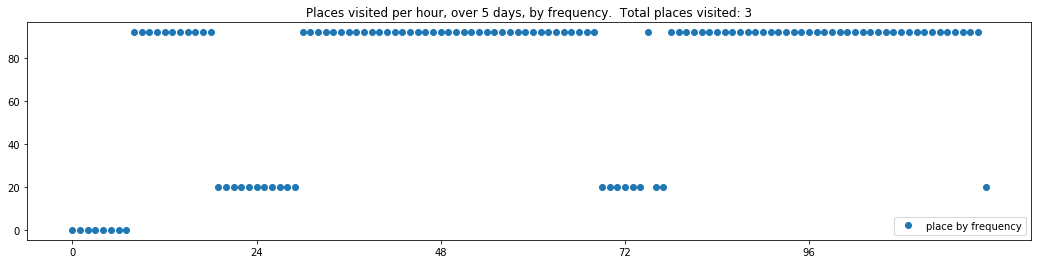

----- vector ----
prefix labels:  [181, 181]
[0, 0, 0, 0, 0, 0, 0, 0, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
[181, 181, 181, 0, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
[181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]
[181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 559, 181, 181, 181, 181, 181, 181, 181, 181, 181]
[181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 0, 181, 181]


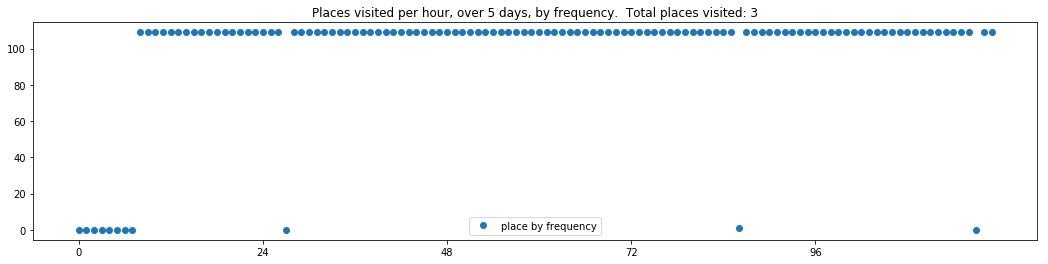


-------showing vectors for model: O.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:48-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.9
----- vector ----
prefix labels:  [429, 429]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429]
[429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429]
[429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429]
[429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429]
[429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429]


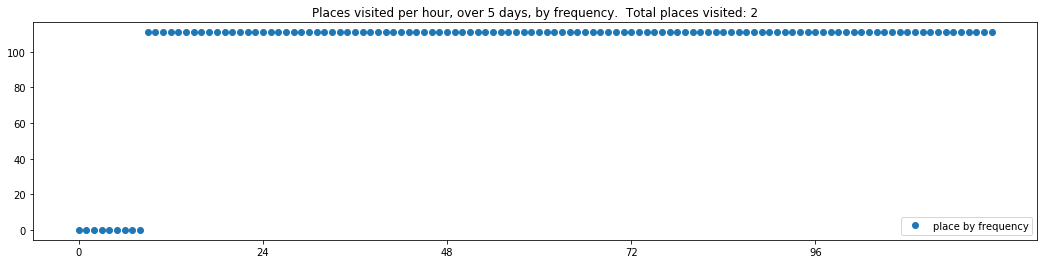

----- vector ----
prefix labels:  [165, 539]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239]
[239, 239, 239, 239, 239, 239, 239, 559, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239]


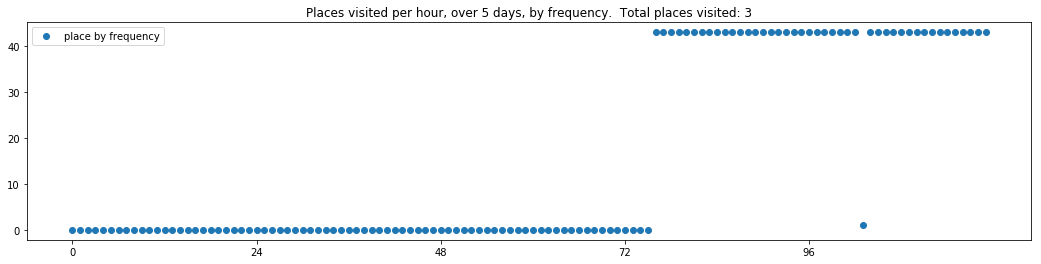

----- vector ----
prefix labels:  [64, 0]
[0, 0, 0, 0, 0, 0, 200, 200, 200, 200, 200, 200, 200, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


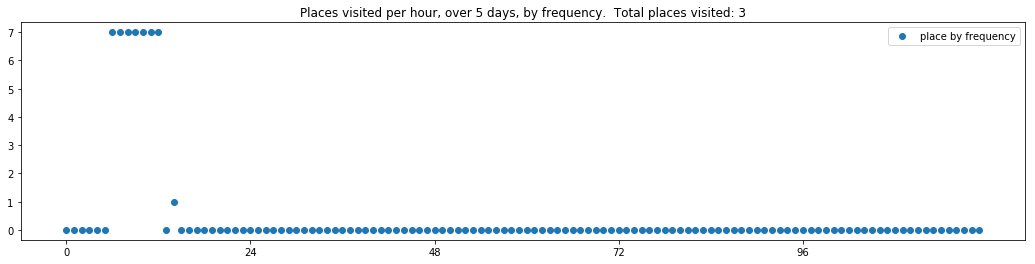


-------showing vectors for model: O.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:48-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:1.0
----- vector ----
prefix labels:  [180, 180]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 448, 448, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


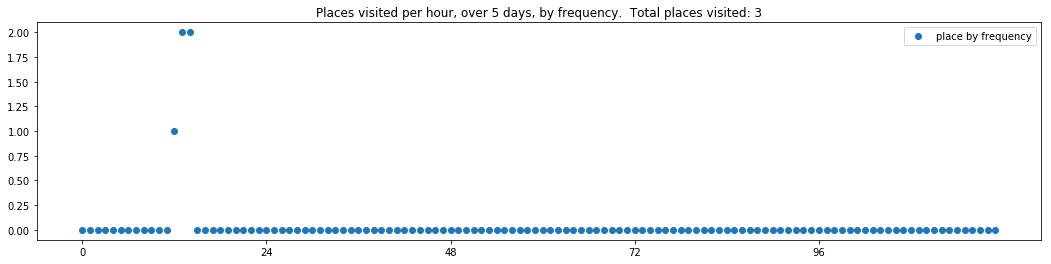

----- vector ----
prefix labels:  [425, 425]
[0, 0, 0, 0, 0, 0, 425, 425, 425, 425, 425, 425, 515, 515, 0, 0, 0, 68, 3, 425, 425, 425, 425, 425]
[425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425]
[425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 277, 261, 261, 425, 425, 425, 425, 425, 425]
[425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425]
[425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 113, 130, 130, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425]


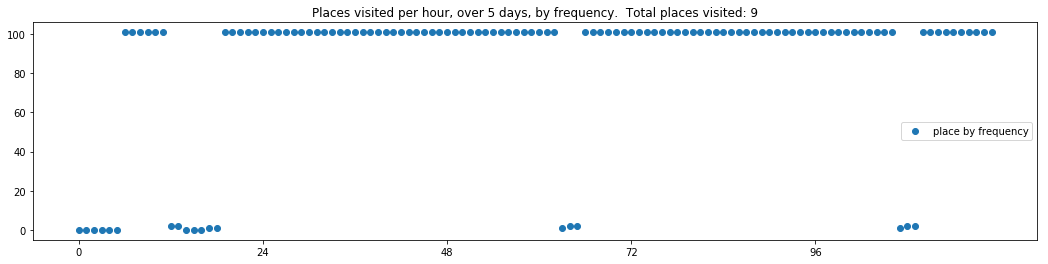

----- vector ----
prefix labels:  [76, 76]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76]
[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76]
[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76]
[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76]
[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76]


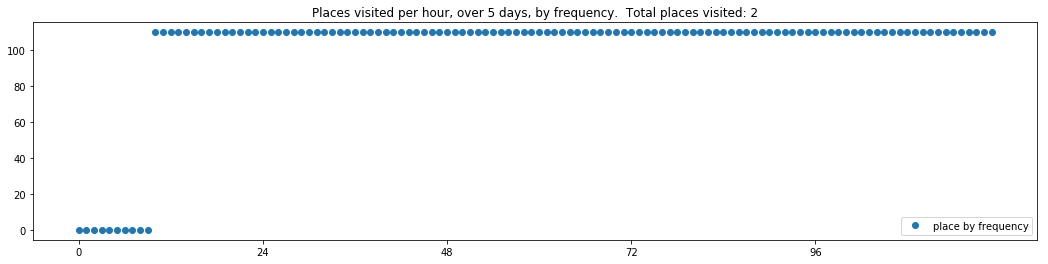


-------showing vectors for model: default-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.8
----- vector ----
prefix labels:  [503, 151]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 503, 503, 503, 503, 503, 503]
[503, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 503, 503, 503, 503, 503]
[503, 503, 503, 503, 503, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 503, 503, 503, 503]
[503, 503, 503, 503, 503, 503, 503, 0, 0, 0, 0, 0, 0, 0, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503]
[503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503]


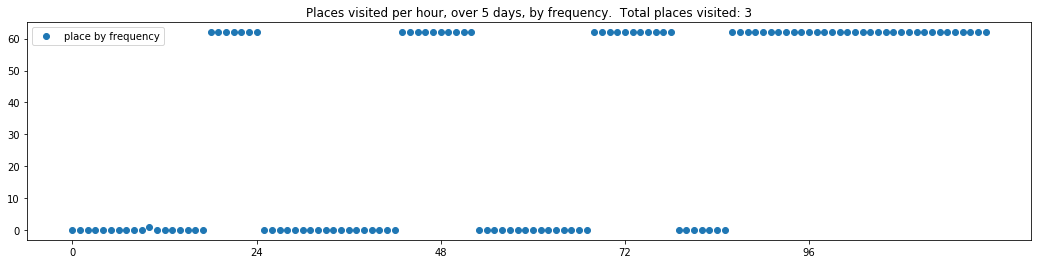

----- vector ----
prefix labels:  [341, 341]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


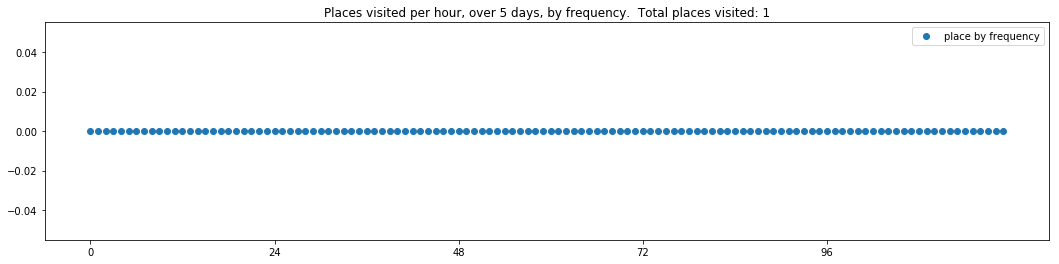

----- vector ----
prefix labels:  [7, 119]
[0, 0, 0, 0, 0, 0, 0, 0, 119, 119, 119, 119, 119, 119, 119, 119, 119, 0, 0, 0, 0, 424, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119]
[119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119]
[119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119]
[119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119]


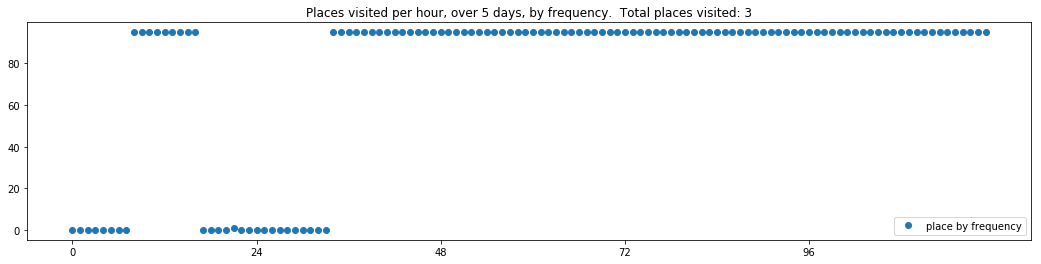


-------showing vectors for model: default-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.9
----- vector ----
prefix labels:  [21, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 20, 20, 20, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 264, 0, 240, 0, 0, 0, 0, 0]


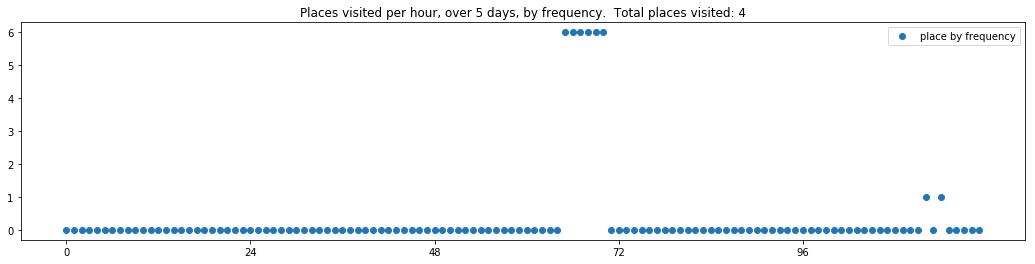

----- vector ----
prefix labels:  [86, 86]
[86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 251, 251, 234, 81, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]
[86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 0, 0, 0, 0, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]
[86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 0, 0, 0, 0, 0, 86, 86, 86, 86, 86]
[86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 0, 0, 0, 0, 440, 440, 440, 0, 86, 86, 86]
[86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86]


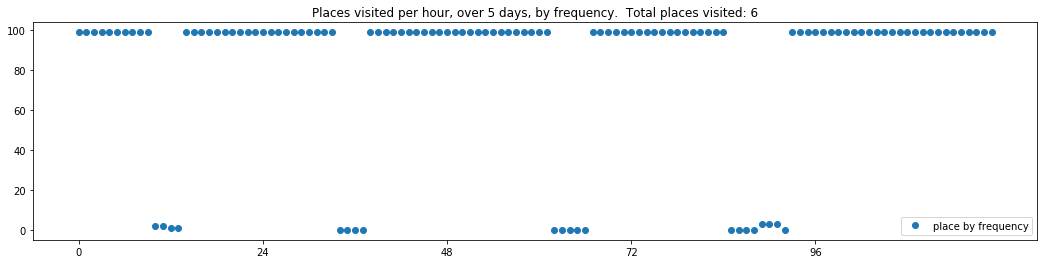

----- vector ----
prefix labels:  [434, 55]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 116, 116, 116, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


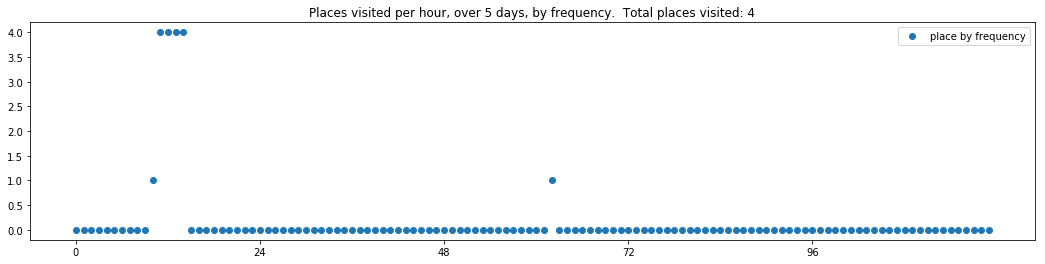


-------showing vectors for model: default-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:24-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:1.0
----- vector ----
prefix labels:  [63, 361]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 63, 361]
[361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361]
[361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361]
[0, 0, 0, 212, 0, 0, 0, 0, 361, 361, 55, 0, 0, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361]
[361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361]


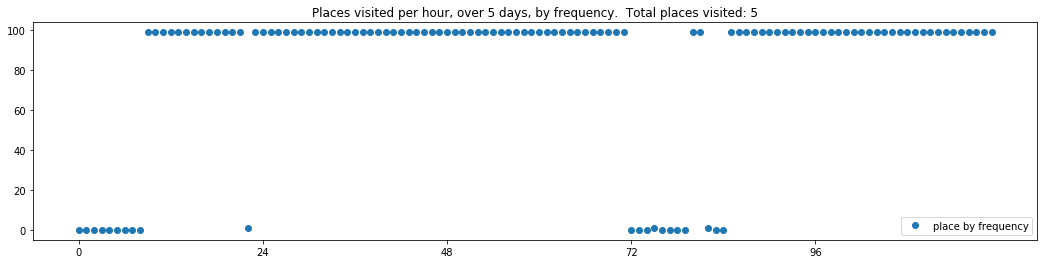

----- vector ----
prefix labels:  [285, 338]
[0, 0, 0, 0, 0, 0, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338]
[338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338]
[338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338]
[338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338]
[338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338]


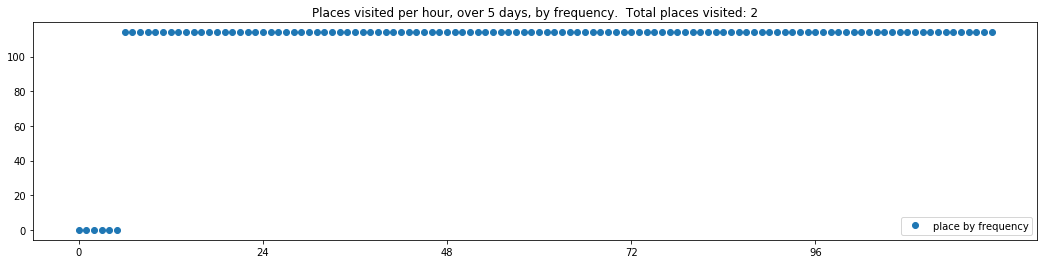

----- vector ----
prefix labels:  [321, 172]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 436, 353, 353, 0, 231, 252, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 93, 93, 93, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93]
[93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 0, 93, 93, 93, 93, 93, 93, 93, 93]
[93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 4, 4, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93]


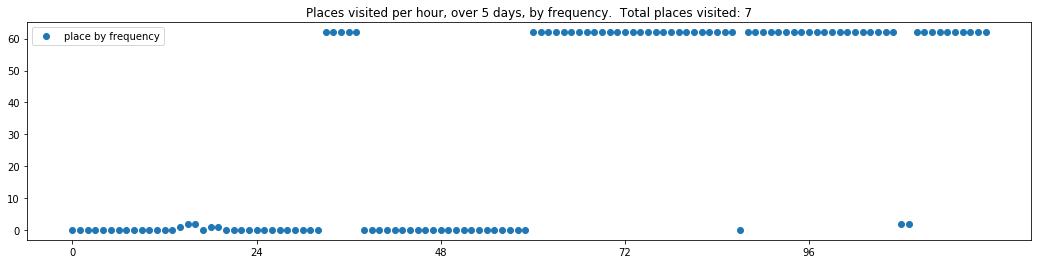


-------showing vectors for model: A-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:24-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.8
----- vector ----
prefix labels:  [21, 21]
[0, 0, 0, 0, 0, 0, 0, 0, 21, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21]
[21, 0, 0, 0, 0, 21, 21, 21, 21, 21, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21]
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 0, 21]
[21, 21, 21, 21, 21, 21, 21, 21, 21, 162, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 162, 162]
[0, 0, 0, 0, 0, 0, 0, 0, 162, 162, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 162, 162, 0]


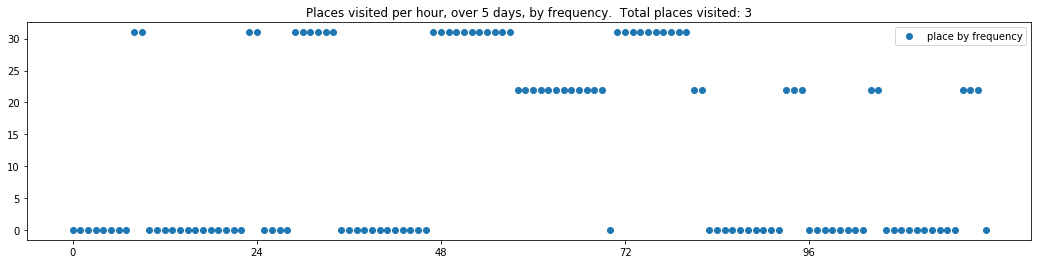

----- vector ----
prefix labels:  [11, 142]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21]
[21, 21, 21, 21, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


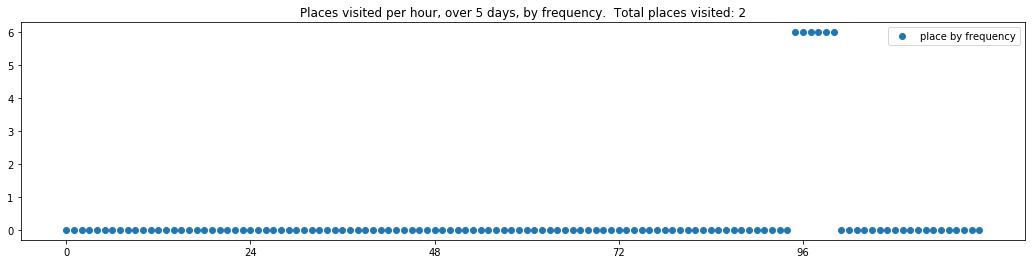

----- vector ----
prefix labels:  [131, 84]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 84, 84, 84, 84, 84, 84, 84, 84, 131, 131, 131]
[131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 84, 84, 84, 84, 84, 84, 84, 84, 84, 131, 131, 131]
[131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 84, 84, 84, 84, 84, 84, 84, 84, 84, 131, 131, 131]
[131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 84, 84, 84, 84, 84, 84, 84, 84, 84, 131, 131, 131]
[131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 84, 84, 84, 84, 84, 84, 84, 84, 0, 0, 84, 84]


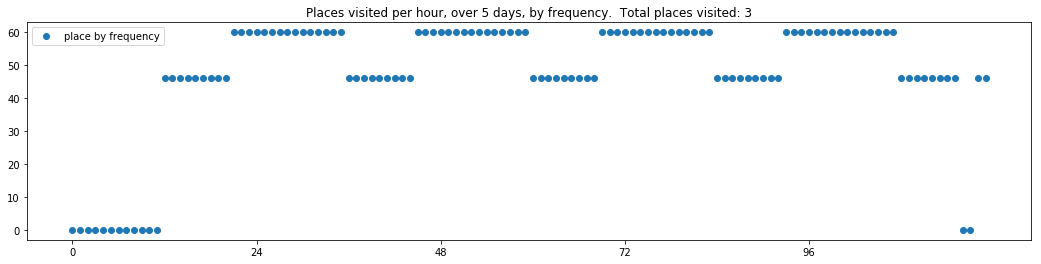


-------showing vectors for model: A-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:24-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.9
----- vector ----
prefix labels:  [35, 35]
[0, 0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 351, 351, 35, 35, 35, 35, 35, 35]
[35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 0, 191, 191, 0, 373, 373, 373, 450, 450, 0]
[35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 0, 0, 0, 0, 0, 0, 0]
[0, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35]
[35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35]


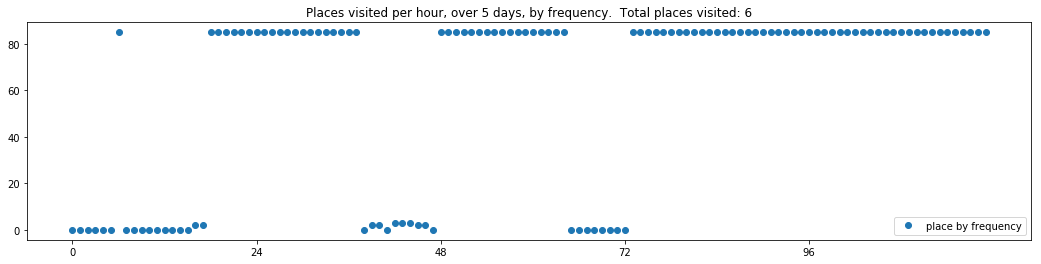

----- vector ----
prefix labels:  [20, 516]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 516, 516, 516, 516, 516, 516, 0, 0, 0, 0, 4, 4, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 516, 516, 516, 516, 516, 516, 516, 0, 0, 0, 0, 0, 393, 393, 393]
[393, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 225, 0, 0, 0, 0, 0, 0]
[0, 0, 479, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


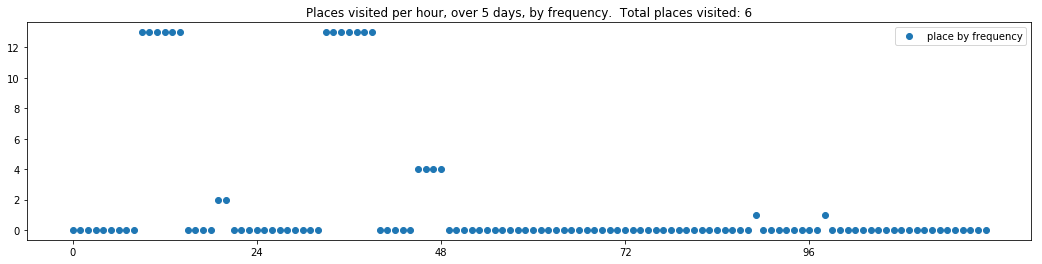

----- vector ----
prefix labels:  [124, 116]
[0, 0, 0, 0, 0, 0, 0, 116, 116, 116, 116, 116, 116, 0, 0, 0, 0, 0, 0, 0, 0, 124, 124, 124]
[124, 124, 124, 124, 124, 124, 124, 124, 124, 315, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 315, 315, 116, 116, 116, 116, 116, 116, 116, 116, 116, 0, 0, 116, 116, 116]
[116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116]
[116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116]


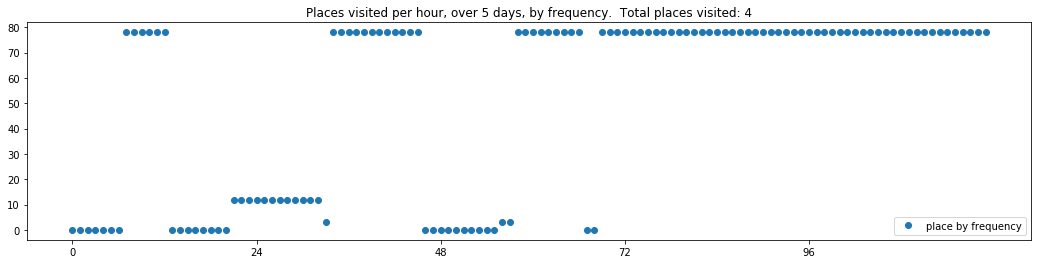


-------showing vectors for model: A-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:24-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:1.0
----- vector ----
prefix labels:  [304, 304]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 310, 310, 578, 578]
[578, 578, 578, 578, 578, 578, 578, 578, 578, 578, 578, 578, 578, 578, 578, 578, 578, 0, 0, 0, 310, 310, 578, 620]
[620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 522, 578, 578, 165, 391, 578, 578, 578, 578, 578, 522, 522]
[620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 304, 578, 167, 167, 167, 167, 167, 167, 311, 311, 620]
[620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 167, 167, 167, 167, 167, 167, 167, 167, 620, 620, 620]


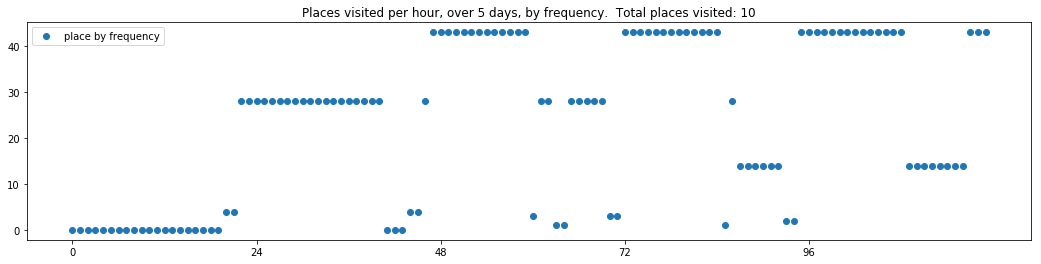

----- vector ----
prefix labels:  [321, 172]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 66, 66, 66, 66, 66, 66, 66, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66]
[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66]


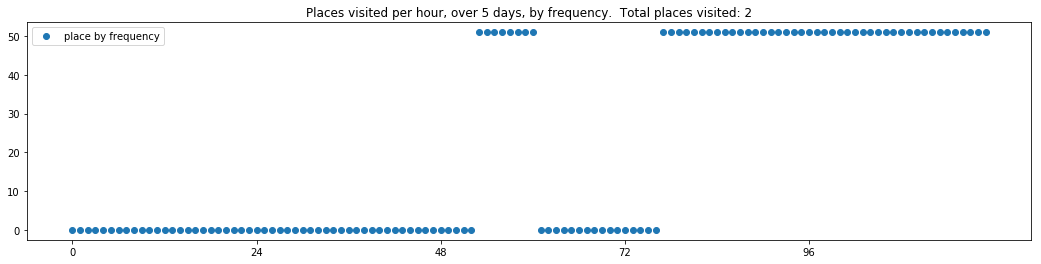

----- vector ----
prefix labels:  [484, 484]
[0, 0, 0, 0, 0, 0, 0, 0, 484, 484, 484, 484, 484, 484, 484, 108, 108, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 484, 484, 484, 484, 484, 484, 2, 484, 484, 484, 0, 0, 0, 0, 0]
[76, 76, 76, 76, 76, 76, 76, 76, 0, 484, 2, 2, 2, 0, 484, 2, 2, 0, 0, 0, 0, 0, 76, 76]
[76, 76, 76, 76, 76, 76, 0, 0, 0, 0, 0, 0, 0, 484, 484, 484, 484, 484, 484, 484, 484, 484, 0, 0]
[76, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 575, 575, 484, 484, 484, 484, 484, 484, 484, 484, 484]


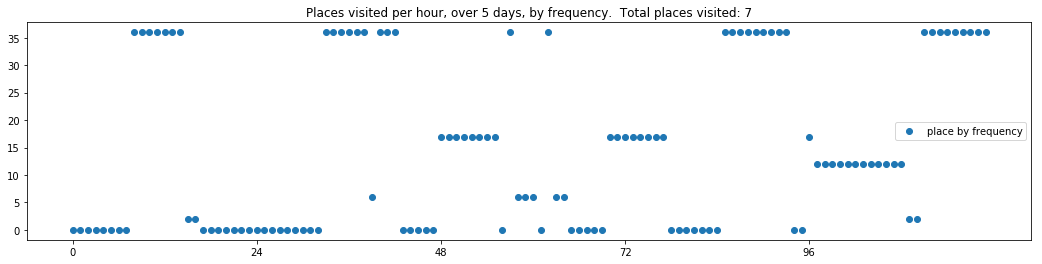


-------showing vectors for model: O-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:48-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.8
----- vector ----
prefix labels:  [479, 479]
[0, 0, 0, 0, 0, 0, 0, 0, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479]
[479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 0, 0, 479, 479, 479]
[479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 0]
[0, 0, 0, 0, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479]
[479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479]


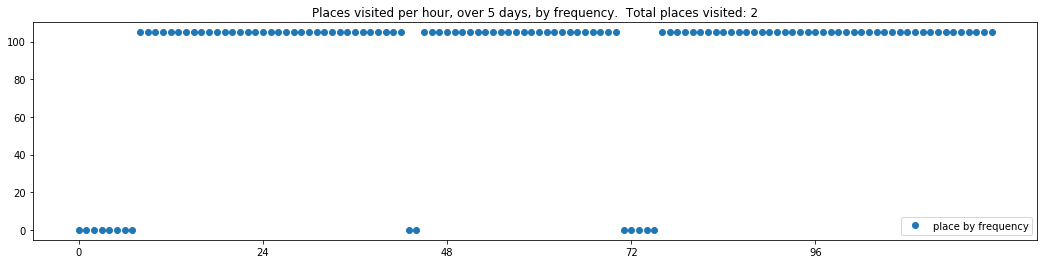

----- vector ----
prefix labels:  [103, 103]
[0, 0, 0, 0, 0, 0, 103, 103, 103, 103, 103, 0, 0, 0, 0, 0, 0, 0, 0, 103, 103, 103, 103, 103]
[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 0, 0, 0, 0, 0, 103, 103, 103, 0, 103, 103]
[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 0, 0, 0, 0, 0, 0, 0, 0, 103, 103, 103]
[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 0, 0, 0, 0, 0, 103, 103, 103, 103, 103, 103]
[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 0, 0, 0, 0, 0, 0, 103, 103, 103, 103, 103]


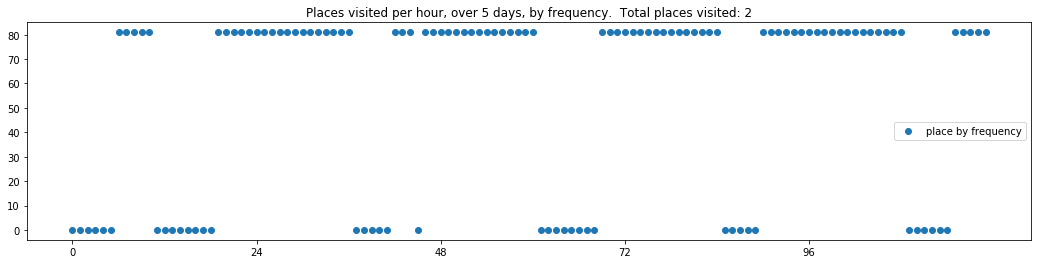

----- vector ----
prefix labels:  [607, 607]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]
[246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]
[246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246]


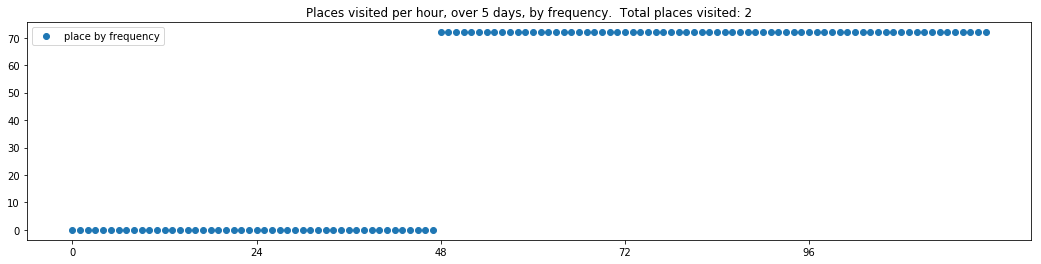


-------showing vectors for model: O-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:48-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:0.9
----- vector ----
prefix labels:  [251, 251]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 293, 293, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251]
[251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 130, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


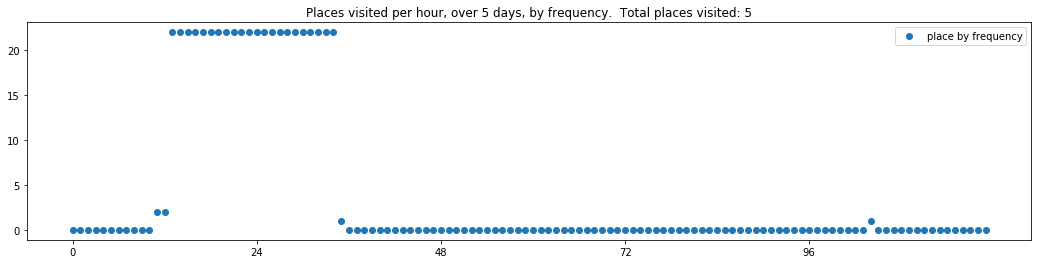

----- vector ----
prefix labels:  [298, 461]
[0, 0, 0, 0, 0, 0, 0, 298, 298, 298, 298, 298, 98, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 461, 0, 379, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 298, 298, 298, 298]
[298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 87]


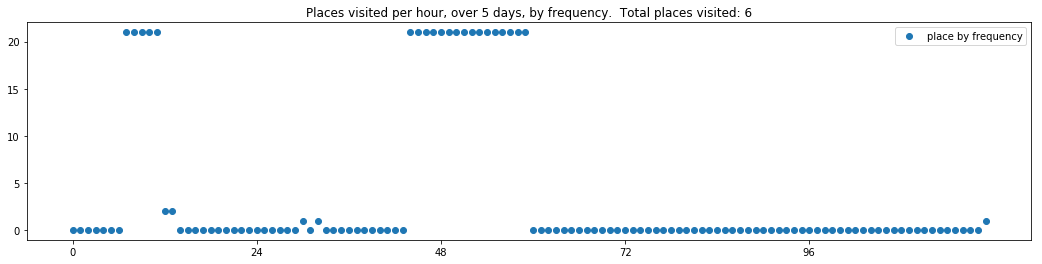

----- vector ----
prefix labels:  [214, 22]
[0, 0, 0, 0, 0, 0, 0, 0, 439, 439, 22, 22, 22, 22, 22, 22, 22, 22, 22, 214, 214, 214, 214, 214]
[214, 214, 214, 214, 214, 214, 214, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 214, 214, 214, 214, 214, 214]
[214, 214, 214, 214, 214, 214, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 214, 214, 214, 214, 214]
[214, 214, 214, 214, 214, 214, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 214, 214, 214, 214, 214]
[214, 214, 214, 214, 214, 214, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 214, 214, 214]


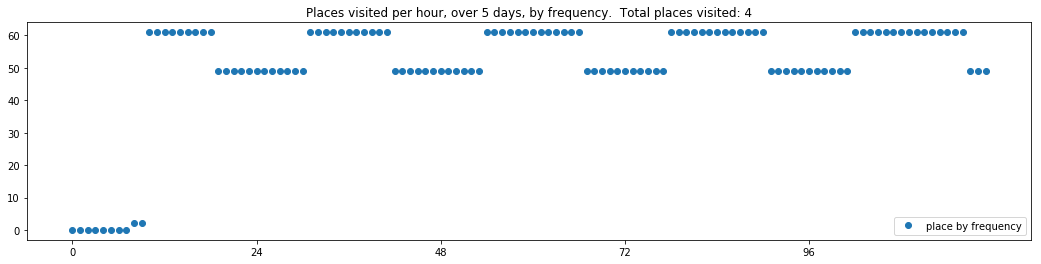


-------showing vectors for model: O-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:48-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:50-temperature:1.0
----- vector ----
prefix labels:  [620, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 620, 620, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 296, 296]
[296, 296, 296, 296, 296, 296, 611, 611, 102, 102, 611, 611, 611, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305]
[305, 296, 296, 296, 296, 296, 296, 0, 303, 296, 296, 296, 0, 0, 0, 0, 0, 521, 314, 0, 0, 305, 296, 296]


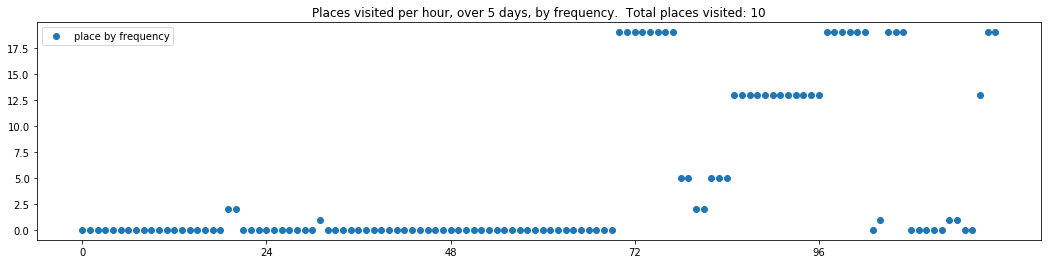

----- vector ----
prefix labels:  [229, 229]
[0, 229, 229, 229, 229, 229, 229, 229, 229, 339, 229, 229, 229, 229, 229, 229, 229, 229, 229, 114, 114, 229, 229, 229]
[229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229]
[229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229]
[229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229]
[229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229]


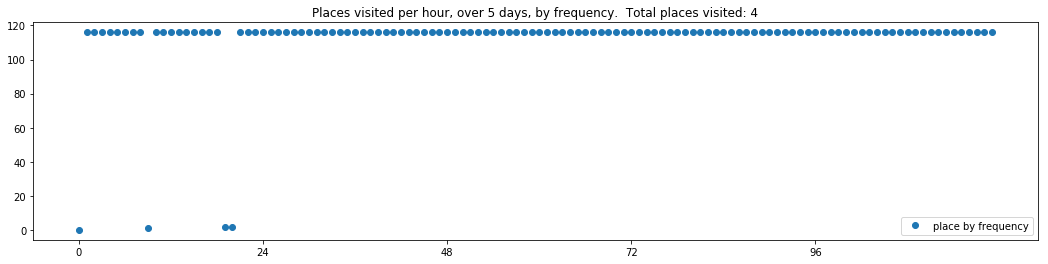

----- vector ----
prefix labels:  [395, 395]
[0, 84, 84, 0, 0, 0, 0, 395, 380, 395, 395, 395, 395, 395, 395, 395, 395, 402, 150, 150, 150, 150, 150, 150]
[150, 150, 150, 150, 150, 150, 395, 395, 395, 181, 181, 395, 395, 395, 395, 395, 395, 84, 84, 0, 395, 395, 395, 395]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 404, 404, 0, 150, 150]
[150, 150, 150, 150, 150, 150, 150, 150, 150, 181, 181, 181, 0, 0, 0, 0, 404, 404, 84, 84, 0, 0, 150, 150]
[150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 623, 623, 150, 150, 150, 150]


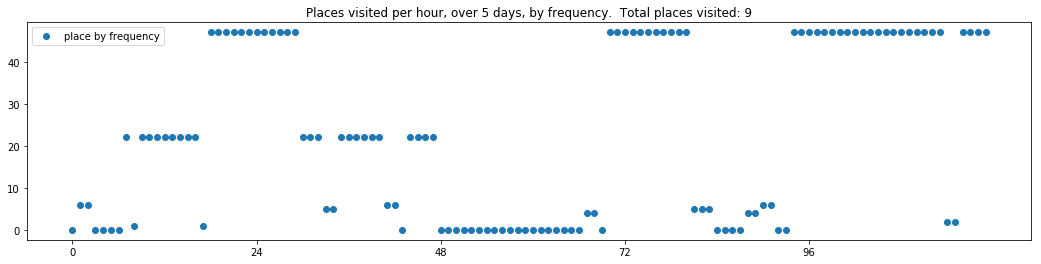


-------showing vectors for model: P-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:0.8
----- vector ----
prefix labels:  [179, 421]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 179]
[179, 179, 179, 179, 179, 179, 179, 179, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 179, 179, 179, 179, 179, 179]
[179, 179, 179, 179, 179, 179, 179, 179, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 179, 179, 179, 179, 179, 179]
[179, 179, 179, 179, 179, 179, 179, 179, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 179, 179, 179, 179, 179, 179]
[179, 179, 179, 179, 179, 179, 179, 179, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 179, 179, 179, 179, 179, 179]


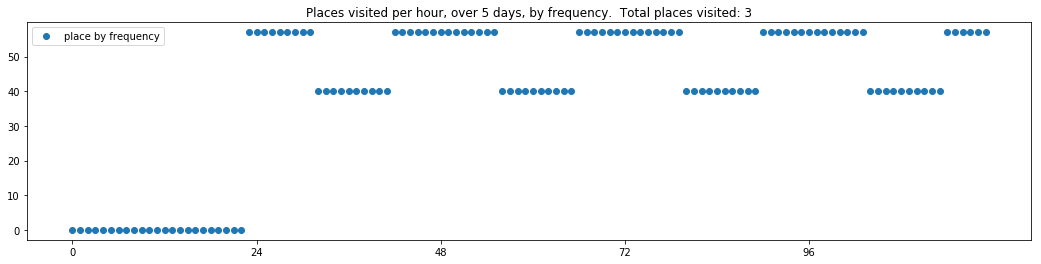

----- vector ----
prefix labels:  [44, 46]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 46, 46, 46, 46, 46, 46, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 46, 46, 46, 46, 46, 46, 46, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 46, 46, 46, 46, 46, 46, 46, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0]


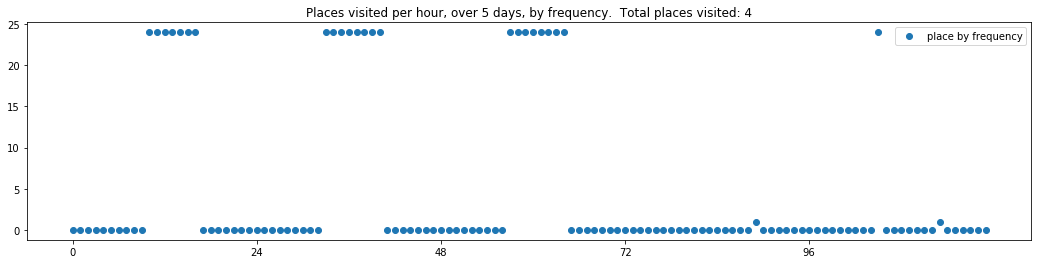

----- vector ----
prefix labels:  [127, 399]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 399, 399, 399, 399, 399, 399, 399, 399, 127, 127, 127, 127, 127, 127, 127]
[127, 127, 127, 127, 127, 127, 127, 127, 399, 399, 399, 399, 399, 399, 399, 399, 399, 127, 127, 127, 127, 127, 127, 127]
[127, 127, 127, 127, 127, 127, 127, 127, 399, 399, 399, 399, 399, 399, 399, 399, 127, 127, 127, 127, 127, 127, 127, 127]
[127, 127, 127, 127, 127, 127, 127, 127, 127, 399, 399, 399, 399, 399, 399, 399, 399, 127, 127, 127, 127, 127, 127, 127]
[127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 0, 0, 0, 127, 127, 127, 127, 127, 127, 127, 127]


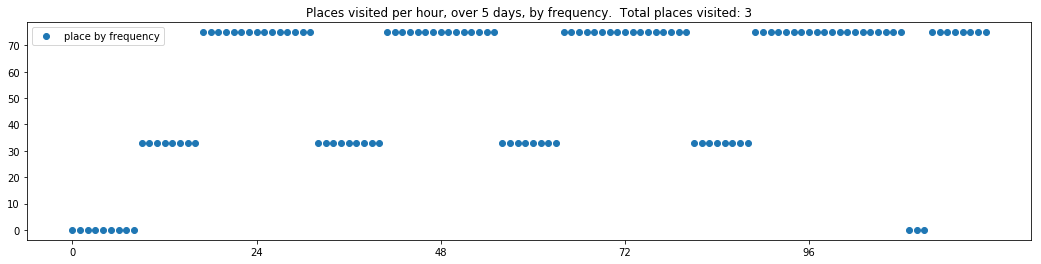


-------showing vectors for model: P.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:0.9
----- vector ----
prefix labels:  [16, 21]
[0, 0, 0, 0, 0, 0, 0, 0, 130, 21, 21, 21, 21, 21, 21, 21, 21, 0, 0, 0, 16, 16, 16, 16]
[16, 16, 16, 16, 16, 16, 16, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 16, 16, 16]
[16, 16, 16, 16, 16, 16, 16, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 16, 16, 16, 16]
[16, 16, 16, 16, 16, 16, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 0, 0, 0, 16]
[16, 16, 16, 16, 16, 16, 16, 16, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 0, 16, 16]


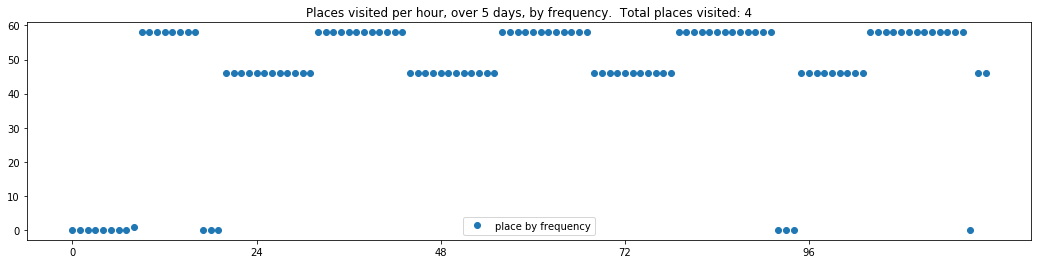

----- vector ----
prefix labels:  [485, 485]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 485, 485, 485, 485, 485, 485]
[485, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 485, 485, 485, 485, 485, 485, 485, 485]
[485, 570, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485]
[485, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485]


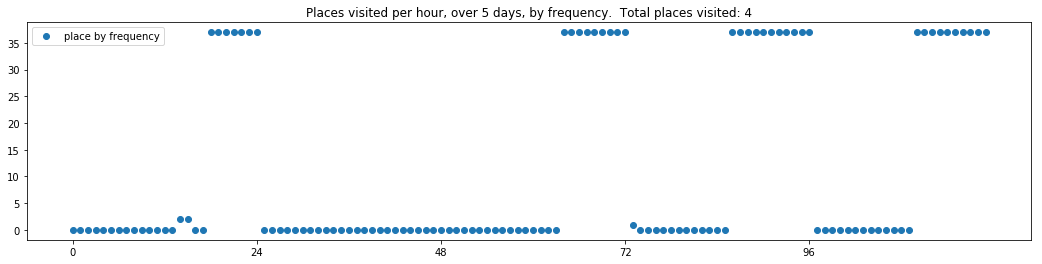

----- vector ----
prefix labels:  [367, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 367, 367, 367, 367]
[367, 367, 367, 367, 367, 367, 367, 367, 0, 0, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 0, 344, 344, 344]
[320, 320, 320, 320, 320, 0, 0, 0, 0, 0, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 10, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 289, 289, 289, 0, 0, 0, 0, 0, 0, 0, 0, 0, 344, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 289, 289, 289, 289, 289, 289, 289, 289, 0, 0, 0, 0, 0]


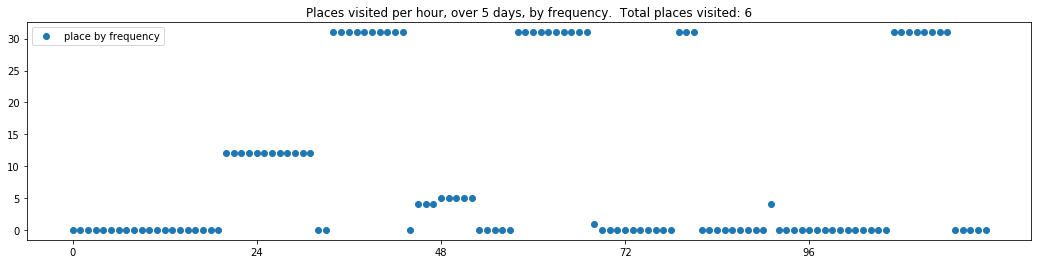


-------showing vectors for model: P.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:False-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.0
----- vector ----
prefix labels:  [88, 88]
[0, 0, 0, 0, 0, 0, 0, 0, 385, 0, 0, 0, 0, 0, 305, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 88, 88, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 149, 0, 0, 0, 0, 0, 0, 165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 149, 149, 149, 149, 149, 225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


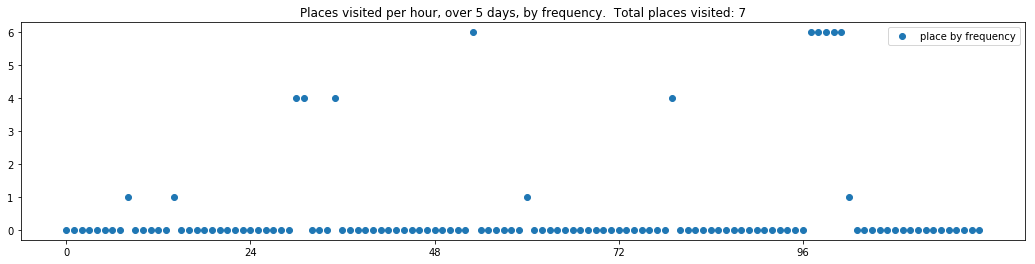

----- vector ----
prefix labels:  [617, 150]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 150, 150, 150, 150, 150, 150, 150, 150, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 150, 150, 150, 150, 150, 150, 150, 0, 0, 0, 0, 0, 617, 617, 617, 617]
[617, 617, 617, 617, 617, 617, 617, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 538, 0, 150, 150, 150, 150, 150, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 307, 307, 474, 22, 22, 150, 150, 150, 150, 0, 0, 0, 0, 0, 0]


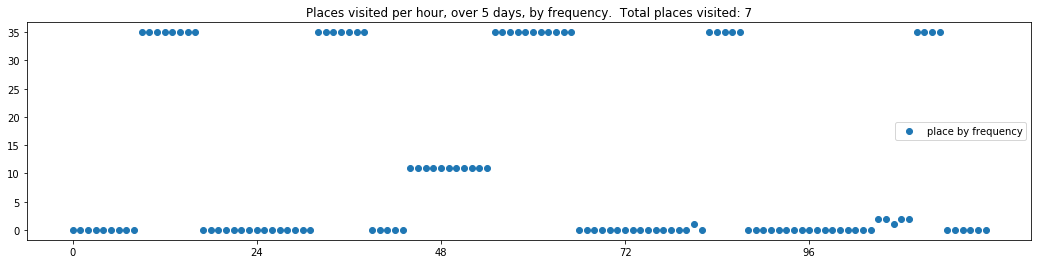

----- vector ----
prefix labels:  [323, 323]
[0, 0, 0, 0, 0, 0, 291, 291, 291, 291, 291, 291, 291, 291, 0, 323, 323, 323, 323, 323, 323, 323, 323, 323]
[323, 323, 323, 323, 323, 323, 291, 291, 291, 291, 0, 0, 0, 0, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323]
[323, 323, 323, 323, 323, 0, 84, 84, 84, 40, 22, 22, 0, 291, 0, 0, 0, 0, 0, 0, 323, 323, 323, 323]
[323, 323, 323, 323, 323, 323, 0, 84, 84, 388, 0, 0, 0, 0, 0, 323, 222, 222, 323, 323, 323, 323, 323, 323]
[323, 323, 323, 323, 323, 323, 0, 0, 0, 0, 0, 344, 344, 0, 0, 0, 0, 0, 0, 0, 323, 323, 323, 323]


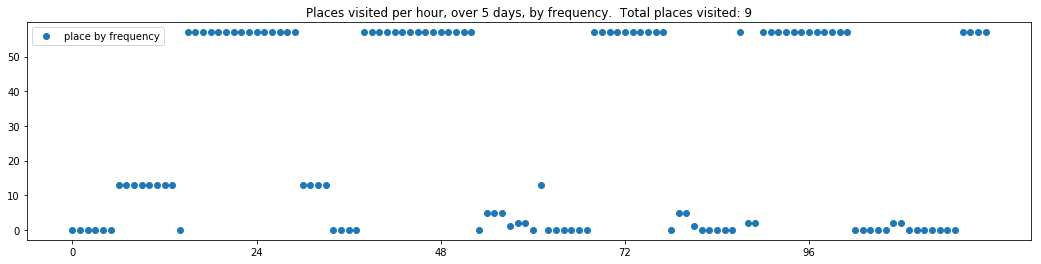


-------showing vectors for model: P-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:0.8
----- vector ----
prefix labels:  [243, 117]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 243, 243, 243]
[243, 243, 243, 243, 243, 243, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 243, 243, 243]
[243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243]
[243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 208, 243, 243]
[208, 208, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243]


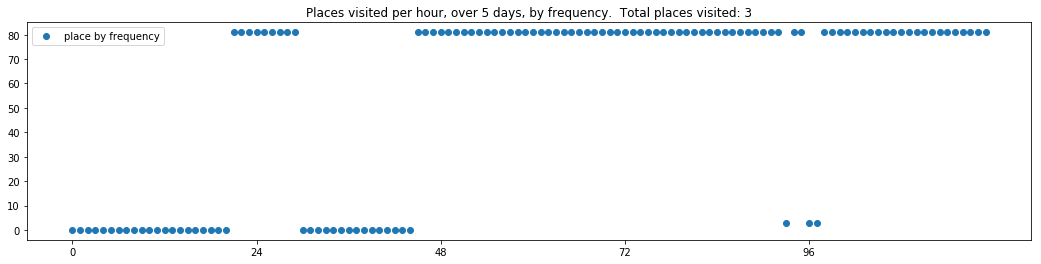

----- vector ----
prefix labels:  [649, 649]
[0, 0, 0, 0, 0, 0, 0, 649, 649, 649, 649, 649, 649, 649, 649, 649, 649, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 649, 649, 649, 649, 649, 649, 649, 649, 649, 649, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 223, 223, 0, 0, 649, 649, 649, 649, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 649, 649, 649, 649, 649, 649, 649, 0, 649, 649, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 649, 649, 649, 649, 0, 0, 0, 0, 0, 0, 0]


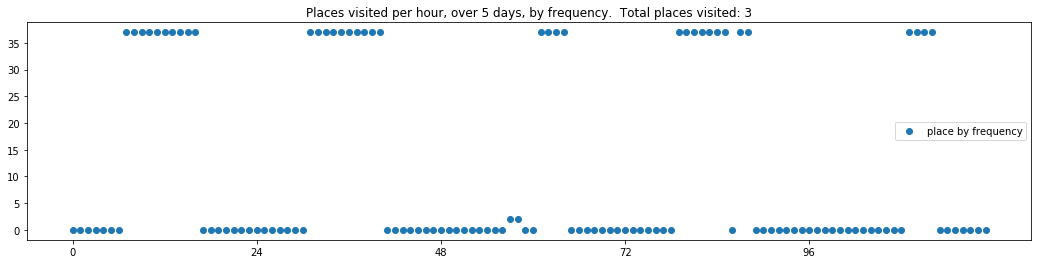

----- vector ----
prefix labels:  [142, 142]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 142, 142, 142, 142, 142]
[142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142]
[142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142]
[142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142]
[142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142]


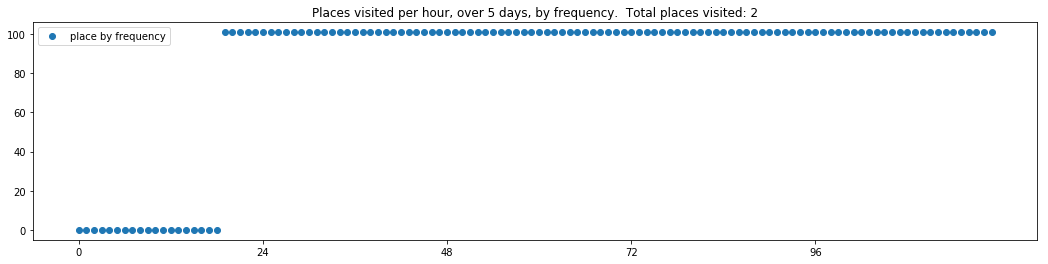


-------showing vectors for model: P-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:0.9
----- vector ----
prefix labels:  [435, 434]
[0, 0, 0, 0, 0, 0, 0, 0, 434, 434, 434, 434, 434, 434, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 71, 71, 0, 0, 0, 434, 435, 435, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 435, 435, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


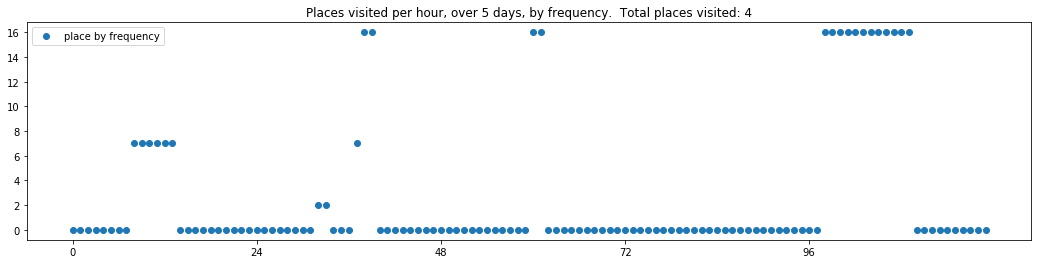

----- vector ----
prefix labels:  [177, 444]
[0, 0, 0, 0, 0, 0, 0, 0, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 177, 177, 177, 177]
[177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 444, 444, 177, 177, 177, 0, 0, 0, 0, 0, 177, 177, 177, 0]
[0, 0, 177, 177, 177, 383, 383, 0, 0, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]
[177, 177, 177, 0, 0, 0, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 0, 0, 0]
[0, 0, 177, 177, 177, 177, 0, 0, 0, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]


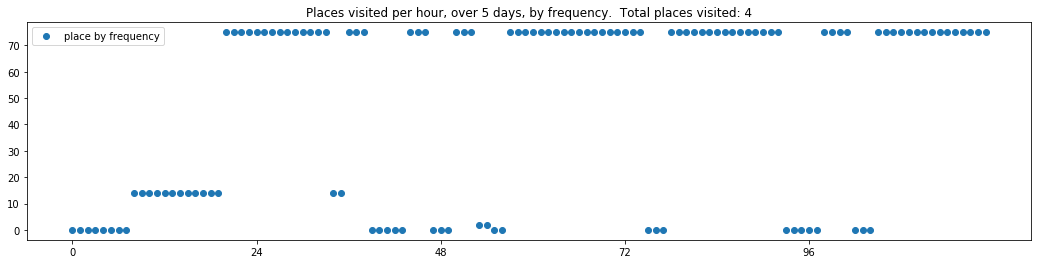

----- vector ----
prefix labels:  [321, 58]
[0, 0, 0, 0, 0, 0, 0, 321, 58, 58, 58, 58, 58, 58, 58, 58, 58, 321, 321, 321, 321, 321, 321, 321]
[321, 321, 321, 321, 321, 321, 321, 321, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 321, 321, 321, 321, 321, 321]
[321, 321, 321, 321, 321, 321, 321, 321, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 321, 321, 321, 321, 321, 321]
[321, 321, 321, 321, 321, 321, 321, 321, 58, 58, 58, 58, 58, 58, 58, 58, 58, 321, 321, 321, 321, 321, 321, 321]
[321, 321, 321, 321, 321, 321, 321, 321, 58, 58, 58, 58, 58, 58, 58, 58, 58, 321, 321, 321, 321, 321, 321, 321]


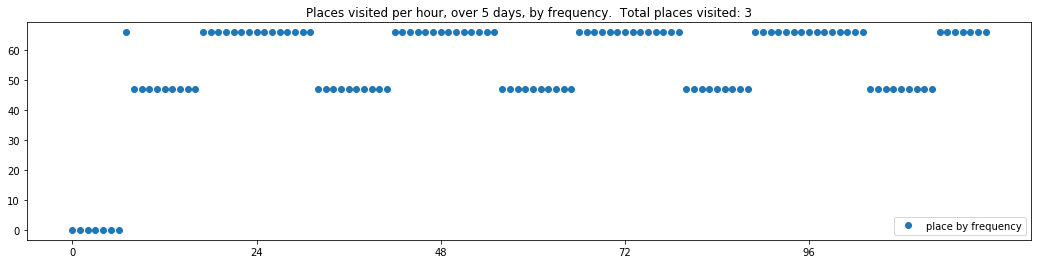


-------showing vectors for model: P-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.0
----- vector ----
prefix labels:  [122, 379]
[0, 0, 0, 0, 0, 0, 0, 0, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 0, 0, 122, 122, 122, 122]
[122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 248, 0, 248, 0, 122, 122, 122, 122, 122, 122, 122, 122]
[122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 122, 122, 122, 122, 122, 209, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 0]


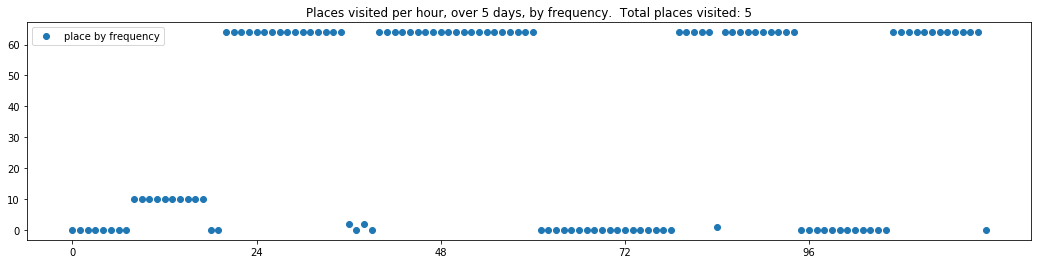

----- vector ----
prefix labels:  [43, 43]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 43, 43, 43, 43, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 0, 0, 0, 0]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 0, 0, 0, 0, 0, 0]
[0, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]
[43, 43, 43, 43, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 43, 43]


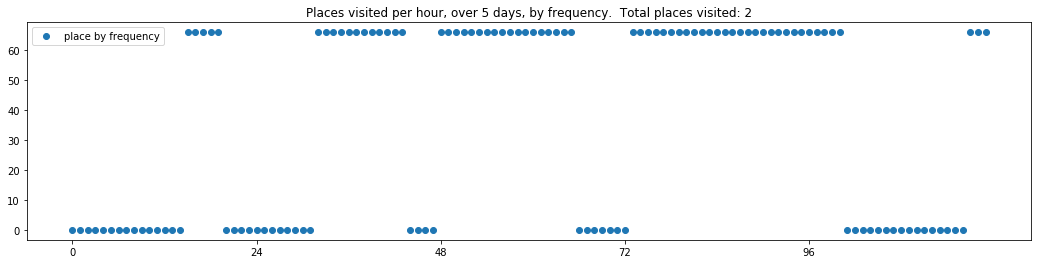

----- vector ----
prefix labels:  [78, 31]
[78, 78, 78, 78, 78, 78, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 31, 31, 31, 31, 31]
[31, 31, 31, 31, 31, 31, 31, 0, 0, 29, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
[31, 0, 31, 31, 540, 540, 0, 0, 0, 0, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
[0, 0, 0, 31, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 86]


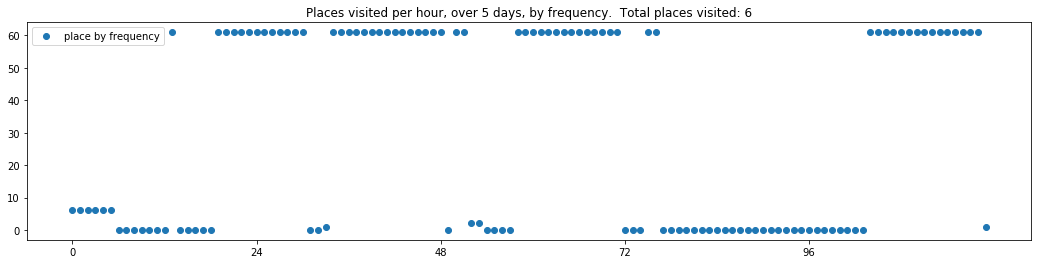


-------showing vectors for model: P-bidirectional.3-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.1
----- vector ----
prefix labels:  [559, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 93, 93, 93, 93, 93, 4, 4, 4, 559, 0, 0]
[559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 93, 93, 93, 93, 4, 4, 4, 4, 4, 559, 559]
[559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 559]
[559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[559, 559, 559, 559, 559, 559, 559, 559, 559, 0, 0, 0, 0, 0, 0, 0, 559, 4, 4, 4, 4, 4, 4, 4]


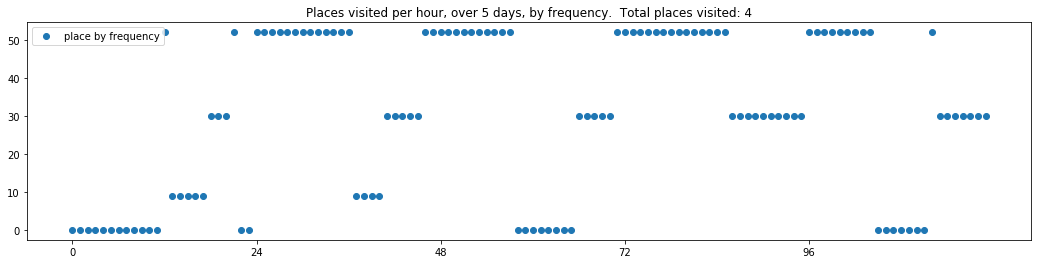

----- vector ----
prefix labels:  [462, 462]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 292, 292, 0, 292, 292, 292, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 231, 0, 0, 202, 292, 292, 292, 0, 0, 0, 0, 462]
[462, 462, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 231, 255, 255, 255, 2, 2, 2, 2, 2, 2, 2, 462]
[462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 231, 231, 586, 586, 586, 586, 2, 2, 462, 462, 462, 0, 0]


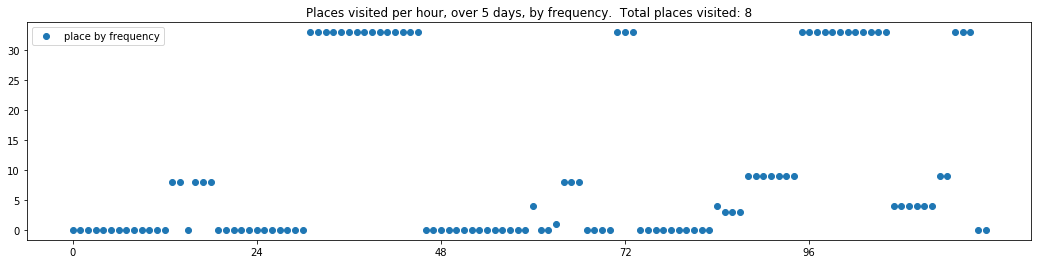

----- vector ----
prefix labels:  [8, 8]
[0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 8, 8, 8, 8, 170, 8, 8, 8, 8, 8, 8, 8, 8]
[8, 8, 8, 8, 8, 8, 307, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 148, 148, 148, 148, 148, 148]
[148, 148, 148, 148, 148, 148, 0, 0, 148, 148, 148, 148, 148, 0, 0, 0, 0, 205, 205, 0, 148, 148, 0, 0]


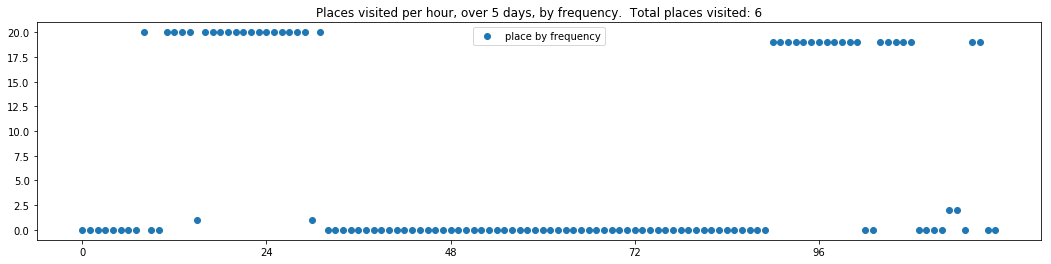


-------showing vectors for model: Q-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.8
----- vector ----
prefix labels:  [103, 103]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 103, 103, 103, 103, 103, 103, 103, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 219]
[219, 195, 0, 93, 93, 0, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385]
[0, 195, 195, 0, 0, 0, 385, 385, 385, 385, 385, 385, 0, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385]


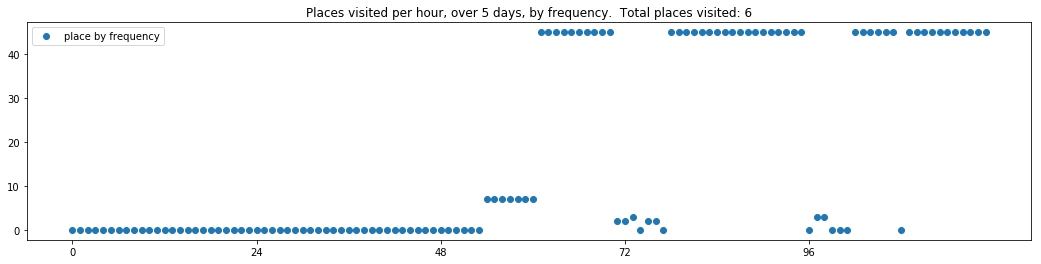

----- vector ----
prefix labels:  [214, 214]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 214, 214, 214, 214, 214, 214, 214, 214, 214, 370, 214, 214, 214, 214, 214]
[214, 214, 214, 214, 214, 214, 214, 214, 214, 0, 317, 317, 317, 317, 317, 0, 216, 216, 214, 214, 214, 214, 214, 214]
[214, 214, 214, 214, 214, 214, 214, 214, 250, 250, 214, 214, 214, 0, 0, 0, 0, 214, 214, 214, 214, 214, 214, 214]
[214, 214, 214, 214, 214, 214, 214, 214, 214, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 214, 214, 214]
[214, 214, 214, 214, 214, 214, 214, 214, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 214, 214, 214]


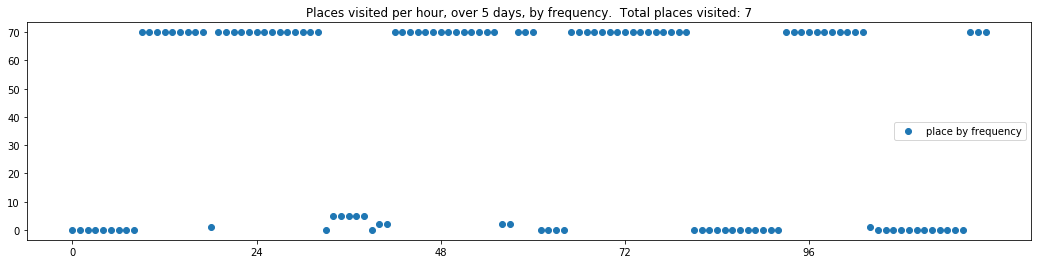

----- vector ----
prefix labels:  [497, 439]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 490, 490, 497, 497, 497]
[497, 497, 497, 497, 497, 497, 497, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 497, 497, 497, 497, 497, 497]
[497, 497, 497, 497, 497, 497, 497, 497, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 497, 497, 497, 497, 497, 497]
[497, 497, 497, 497, 497, 497, 497, 497, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 497, 497, 497, 497, 497, 497]
[497, 497, 497, 497, 497, 497, 497, 497, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 497, 497, 497, 497, 497, 497]


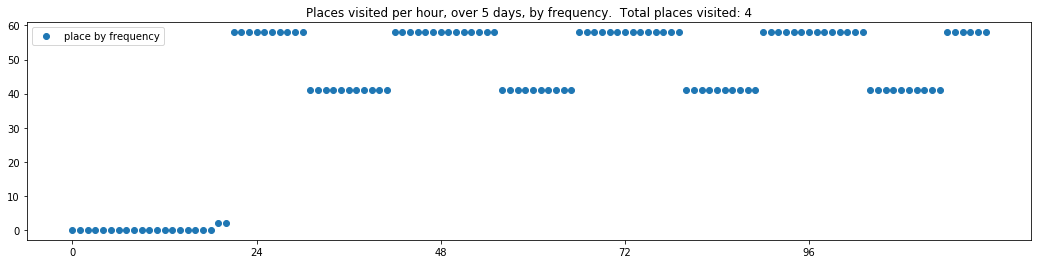


-------showing vectors for model: Q-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.9
----- vector ----
prefix labels:  [26, 0]
[0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 26, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 420, 420, 0, 475, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 420, 420, 420, 420, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 420, 420, 0, 0, 420, 420, 420, 420, 420, 420, 420, 0, 420, 0]


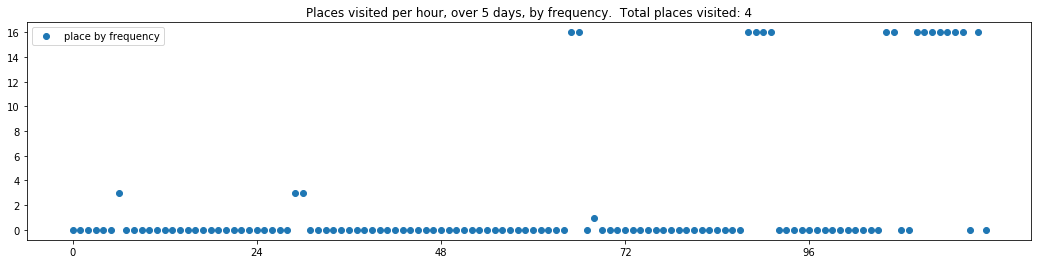

----- vector ----
prefix labels:  [471, 471]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 471, 471]
[471, 471, 471, 471, 471, 471, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 471, 471]
[471, 471, 471, 471, 471, 471, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 471, 471, 471]
[471, 471, 471, 471, 471, 471, 471, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 471, 0, 0, 0, 0]


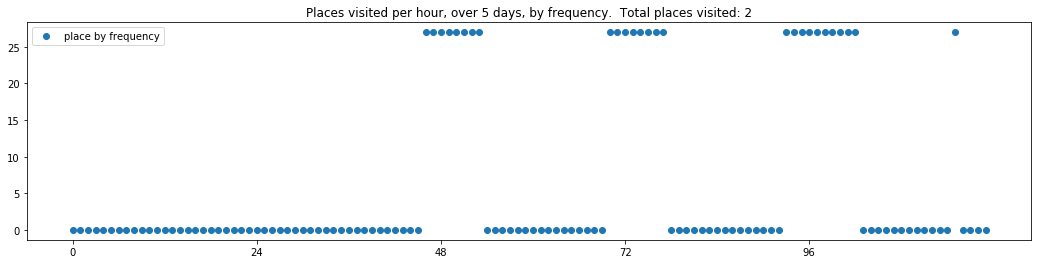

----- vector ----
prefix labels:  [182, 182]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 0, 0, 182, 182, 182]
[182, 182, 182, 0, 0, 182, 182, 0, 60, 182, 182, 0, 0, 182, 182, 182, 0, 182, 0, 0, 0, 0, 0, 182]
[182, 182, 182, 182, 182, 0, 182, 182, 182, 182, 182, 0, 0, 182, 182, 182, 0, 182, 182, 0, 182, 182, 182, 182]
[182, 182, 182, 182, 182, 182, 182, 60, 60, 182, 182, 0, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182]
[182, 182, 182, 182, 0, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 518, 182, 182, 182]


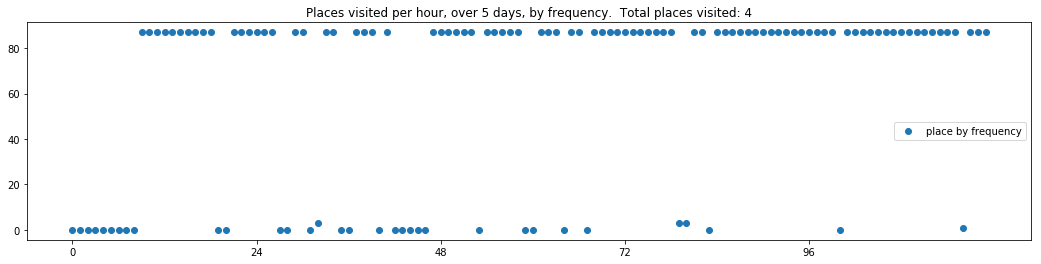


-------showing vectors for model: Q-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0
----- vector ----
prefix labels:  [431, 56]
[0, 0, 0, 0, 0, 0, 374, 76, 56, 56, 56, 56, 0, 0, 56, 56, 0, 0, 0, 0, 431, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 431, 431, 431, 431, 431, 431, 431, 431]
[431, 431, 431, 431, 431, 431, 431, 0, 56, 56, 56, 0, 0, 0, 0, 0, 0, 0, 431, 431, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 56, 56, 56, 56, 56, 56, 0, 0, 0, 0, 0, 0]


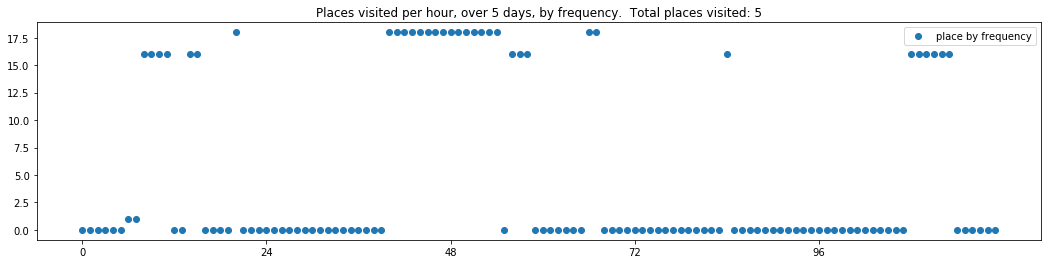

----- vector ----
prefix labels:  [397, 289]
[0, 0, 0, 0, 0, 0, 0, 289, 289, 289, 289, 289, 289, 591, 0, 0, 0, 397, 397, 397, 397, 397, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 289, 289, 289, 289, 591, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 289, 289, 289, 591, 591, 289, 289, 289, 289, 289, 289, 0, 0, 289, 0]
[87, 0, 289, 0, 0, 289, 289, 289, 289, 289, 289, 289, 289, 0, 0, 289, 289, 289, 289, 289, 289, 289, 289, 289]


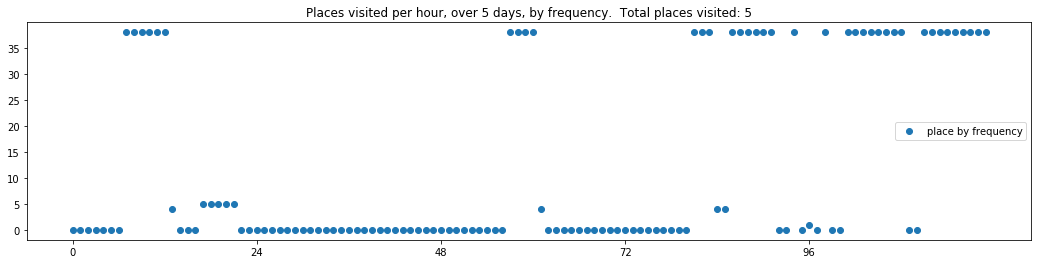

----- vector ----
prefix labels:  [183, 97]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 97, 97, 97, 545, 97, 97, 183, 183, 183, 183, 183, 183, 183, 183]
[183, 183, 183, 183, 183, 183, 183, 183, 97, 97, 97, 97, 97, 97, 97, 97, 279, 279, 0, 0, 183, 183, 183, 183]
[183, 183, 183, 183, 183, 183, 183, 183, 97, 97, 97, 97, 97, 97, 97, 97, 97, 183, 183, 183, 183, 183, 183, 183]
[183, 183, 183, 183, 183, 183, 183, 183, 97, 97, 97, 20, 20, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


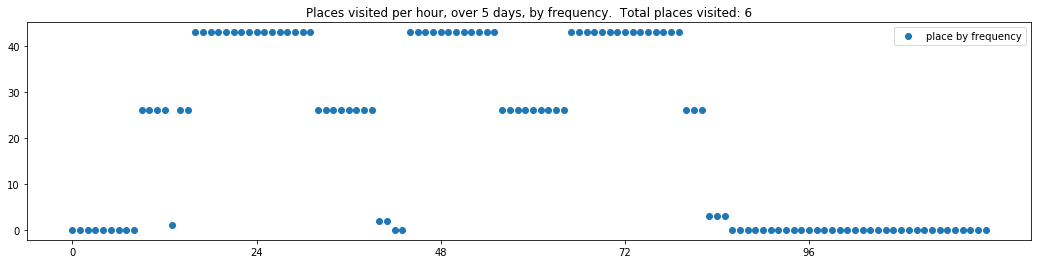


-------showing vectors for model: Q-bidirectional.3-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.1
----- vector ----
prefix labels:  [151, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 151, 151, 206]
[0, 151, 151, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 151, 151, 206]
[206, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 0, 0, 0, 0, 0, 0, 0, 151, 151, 0, 0, 0]
[0, 151, 151, 0, 0, 0, 0, 151, 151, 151, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 151, 0, 0, 0]
[0, 0, 0, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 0, 0, 151, 151, 151, 151, 151, 0]


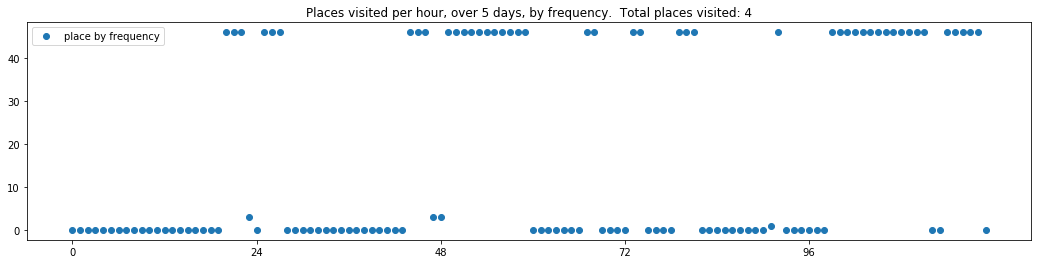

----- vector ----
prefix labels:  [505, 505]
[0, 0, 0, 0, 0, 0, 0, 0, 248, 248, 505, 505, 505, 505, 0, 0, 0, 0, 505, 505, 505, 505, 505, 505]
[505, 505, 505, 505, 505, 505, 505, 505, 505, 580, 580, 580, 580, 505, 505, 505, 505, 357, 505, 505, 505, 505, 505, 505]
[505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 580, 580, 580, 580, 580, 0, 505, 505, 505, 505, 505, 505, 575]
[505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505]
[505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 580, 580, 580, 505, 575, 580, 580, 505, 505, 505, 505, 505, 505, 505]


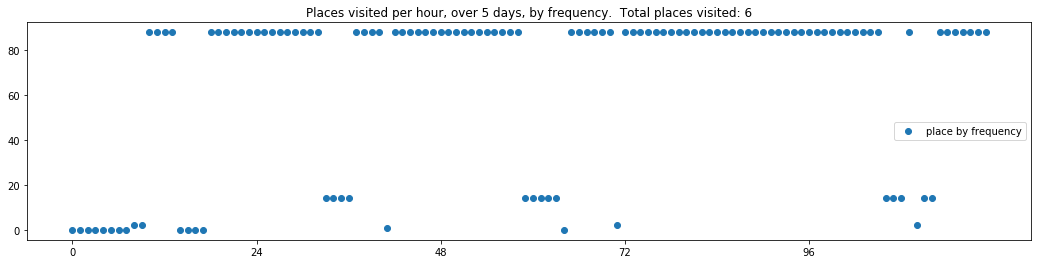

----- vector ----
prefix labels:  [374, 79]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 79, 79, 79, 79, 79, 385, 374, 374, 374, 374, 374, 374]
[374, 374, 374, 374, 374, 495, 495, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 42, 374, 374, 374, 374, 374, 374]
[374, 374, 374, 374, 374, 374, 212, 386, 386, 271, 271, 79, 79, 79, 79, 79, 79, 48, 374, 374, 374, 374, 374, 374]
[374, 374, 80, 80, 73, 73, 73, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 374, 374, 374, 374, 374, 374, 374]
[374, 374, 374, 374, 374, 374, 374, 374, 8, 8, 8, 79, 503, 0, 79, 79, 79, 374, 374, 374, 374, 374, 374, 374]


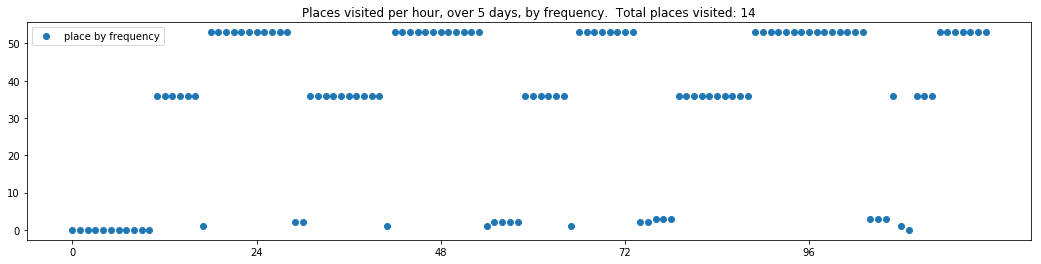


-------showing vectors for model: R-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:64-temperature:0.8
----- vector ----
prefix labels:  [146, 146]
[0, 0, 0, 0, 0, 0, 0, 0, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 224, 224, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 559, 559, 559]
[559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 0, 463, 463, 463, 146, 146, 146, 146, 146, 146, 146]
[146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]


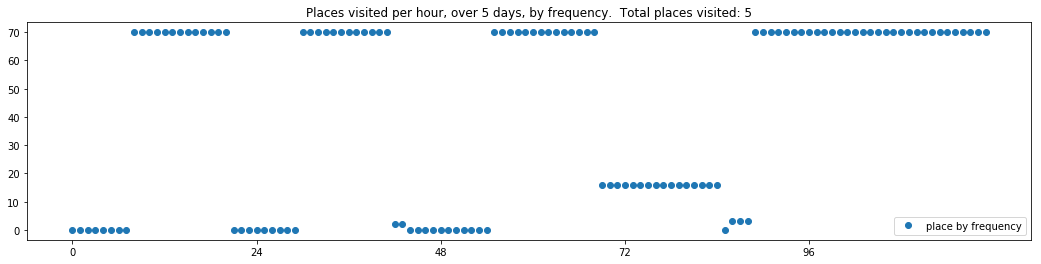

----- vector ----
prefix labels:  [286, 223]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 286]
[286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 0, 0, 0, 0, 0, 0, 0, 0, 286, 286]
[286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 0, 0, 0, 0, 0, 0, 0, 0, 286, 286, 286]
[286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 0, 0, 0, 0, 0, 0, 0, 0, 286, 286]
[286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


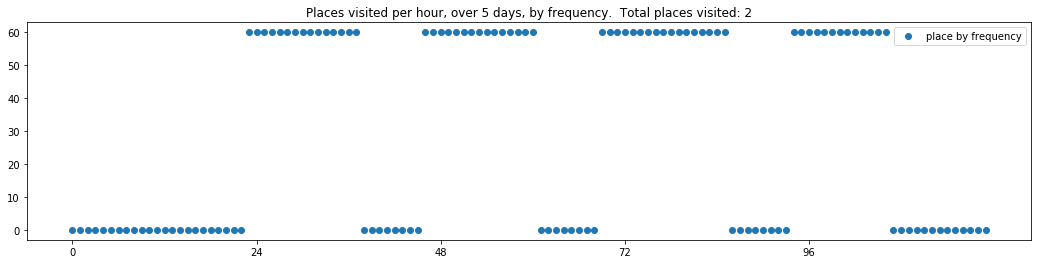

----- vector ----
prefix labels:  [276, 412]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 412, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


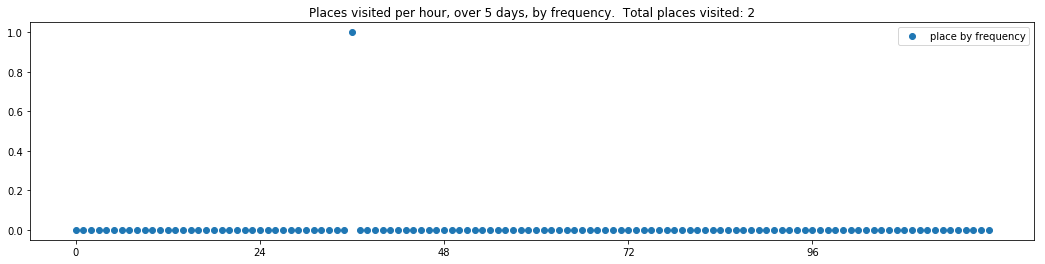


-------showing vectors for model: R-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:64-temperature:0.9
----- vector ----
prefix labels:  [308, 308]
[308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308]
[308, 308, 308, 308, 308, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 308, 308, 308, 308, 308, 308, 308]
[308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308]
[308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308]


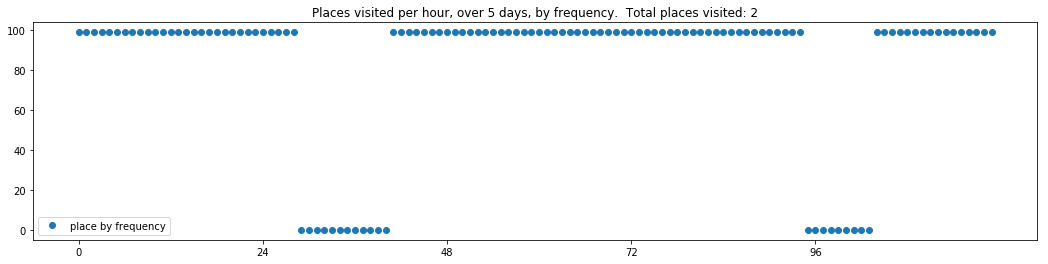

----- vector ----
prefix labels:  [88, 88]
[0, 0, 0, 0, 0, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88]
[88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88]
[88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 0, 0, 0, 0, 0, 88, 88, 88, 88, 88, 88, 88]
[88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 0, 0, 0, 88, 88, 88, 88, 88, 88, 88, 88]
[88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88]


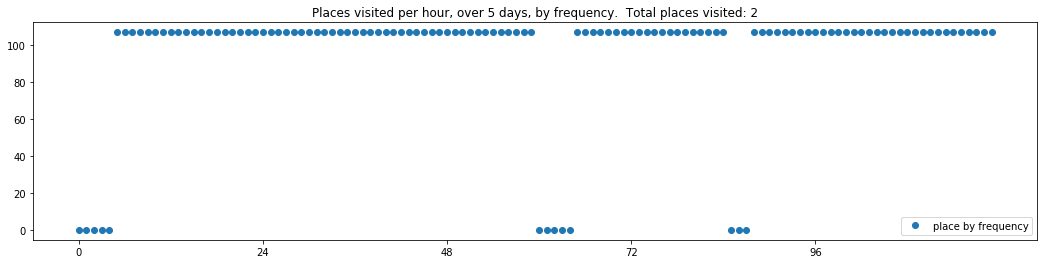

----- vector ----
prefix labels:  [380, 336]
[0, 0, 0, 0, 0, 0, 623, 404, 402, 402, 402, 402, 402, 402, 380, 404, 404, 404, 380, 380, 380, 380, 380, 380]
[380, 380, 380, 380, 380, 380, 380, 404, 404, 404, 404, 404, 404, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380]
[380, 380, 380, 380, 380, 380, 380, 380, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404]
[404, 404, 404, 404, 0, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404]
[404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404]


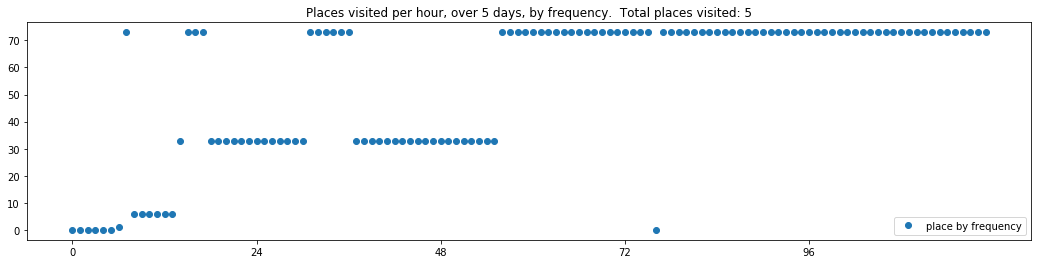


-------showing vectors for model: R-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:64-temperature:1.0
----- vector ----
prefix labels:  [104, 261]
[0, 0, 0, 0, 0, 0, 0, 104, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 104, 104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 121, 121, 121, 121, 121, 121, 121, 121, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


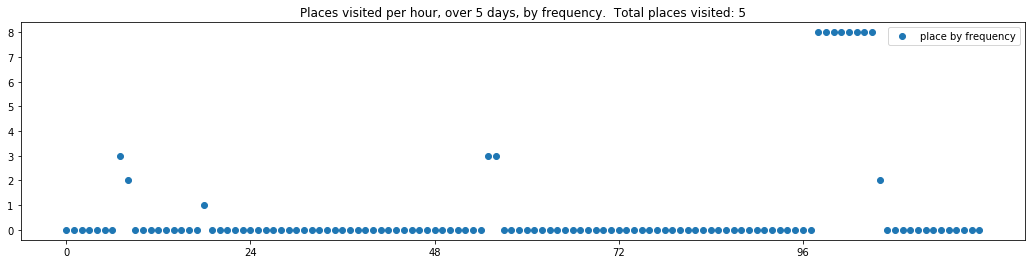

----- vector ----
prefix labels:  [223, 223]
[0, 0, 0, 0, 0, 0, 223, 223, 223, 223, 223, 223, 223, 223, 223, 0, 223, 223, 223, 223, 223, 223, 223, 223]
[223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 223, 0, 0, 0, 0, 0, 0, 223, 0, 223, 223, 223, 223, 223, 223]
[223, 0, 0, 0, 0, 0, 0, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 0, 0]
[0, 0, 0, 0, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223]


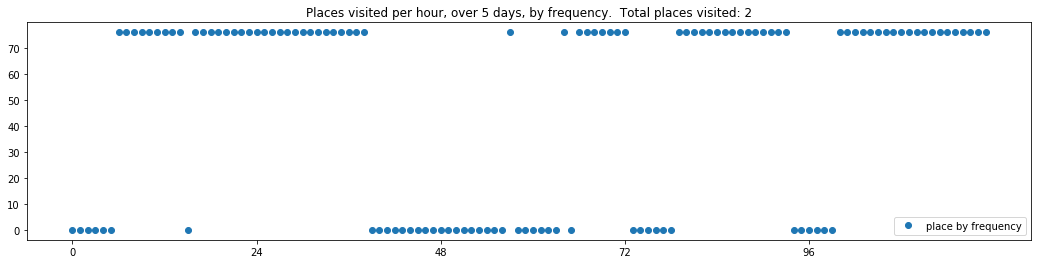

----- vector ----
prefix labels:  [392, 491]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 223, 563, 563, 195, 392, 392]
[392, 392, 392, 392, 392, 392, 392, 392, 392, 107, 107, 107, 107, 107, 392, 392, 392, 392, 392, 303, 296, 0, 392, 392]
[195, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 392, 392, 392, 392, 392, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


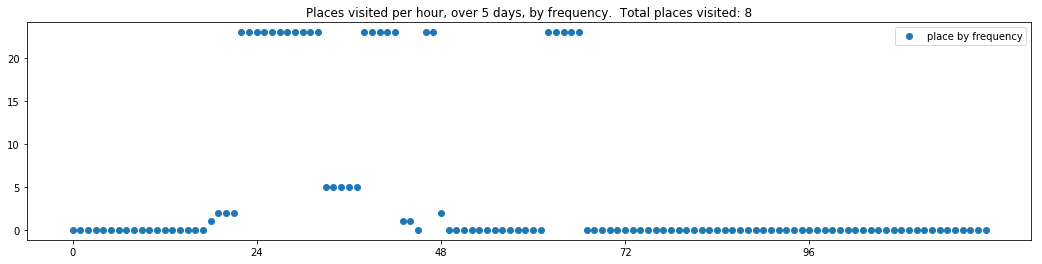


-------showing vectors for model: S-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.8
----- vector ----
prefix labels:  [502, 502]
[0, 0, 0, 0, 0, 0, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 0, 0, 0, 0, 0, 0, 0, 0]


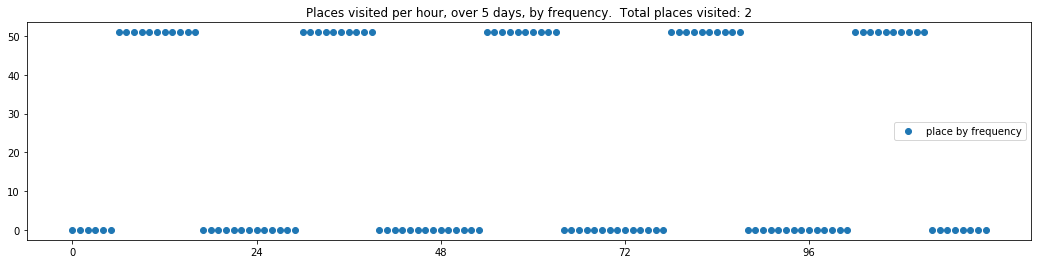

----- vector ----
prefix labels:  [177, 177]
[0, 0, 0, 0, 0, 0, 177, 177, 177, 0, 0, 177, 177, 0, 0, 177, 177, 177, 177, 177, 177, 177, 177, 177]
[177, 177, 177, 177, 177, 177, 177, 177, 0, 383, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]
[177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]
[177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]
[177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177]


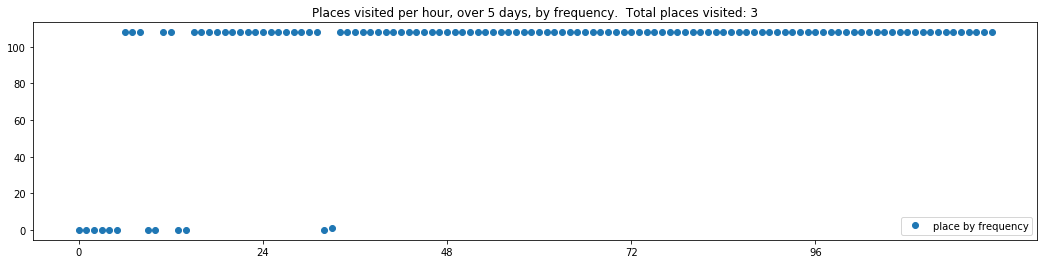

----- vector ----
prefix labels:  [3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


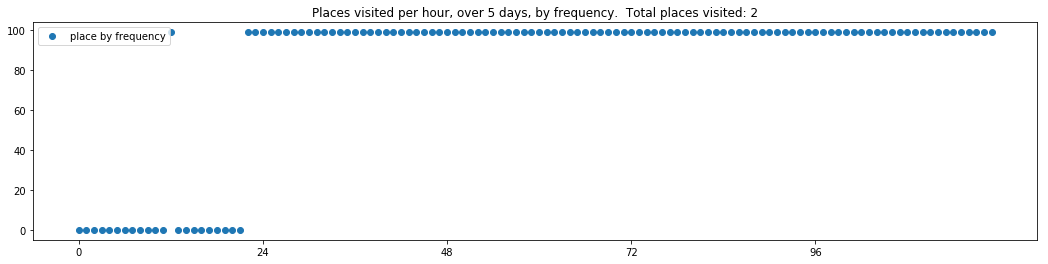


-------showing vectors for model: S-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.9
----- vector ----
prefix labels:  [95, 95]
[0, 0, 0, 0, 0, 0, 0, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]
[95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]
[95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]
[95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]
[95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95]


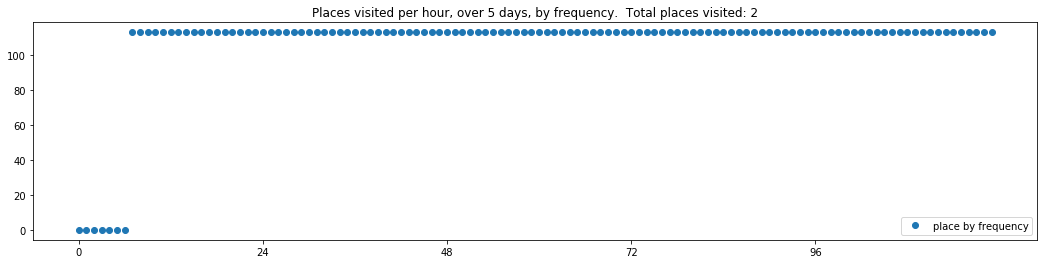

----- vector ----
prefix labels:  [198, 0]
[0, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 317, 317, 317, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 198, 198, 198]
[198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 0, 0, 0, 0]
[0, 8, 8, 8, 8, 8, 8, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198]
[198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198]


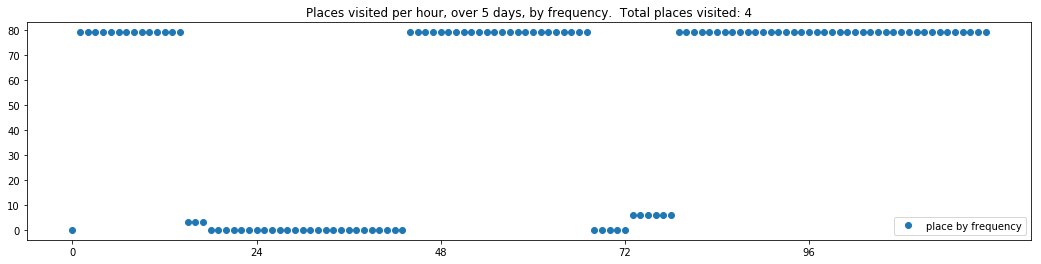

----- vector ----
prefix labels:  [116, 116]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 116, 116, 116, 116, 116, 116, 116, 116, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 0]


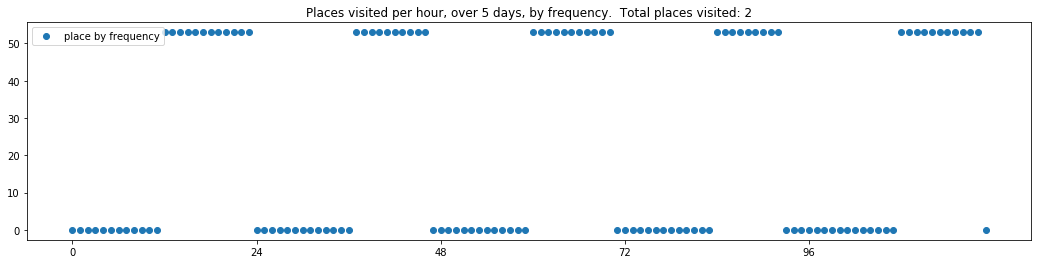


-------showing vectors for model: S-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:2-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0
----- vector ----
prefix labels:  [211, 20]
[0, 0, 0, 0, 0, 0, 20, 20, 20, 20, 0, 20, 20, 0, 20, 0, 0, 0, 0, 0, 0, 0, 211, 211]
[211, 211, 211, 211, 211, 211, 20, 20, 20, 20, 20, 20, 20, 0, 0, 0, 0, 0, 0, 211, 211, 211, 211, 211]
[211, 211, 211, 211, 211, 0, 0, 20, 20, 20, 20, 20, 20, 0, 0, 233, 233, 233, 233, 283, 0, 0, 0, 0]
[0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 211, 211, 211, 211, 211]
[211, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


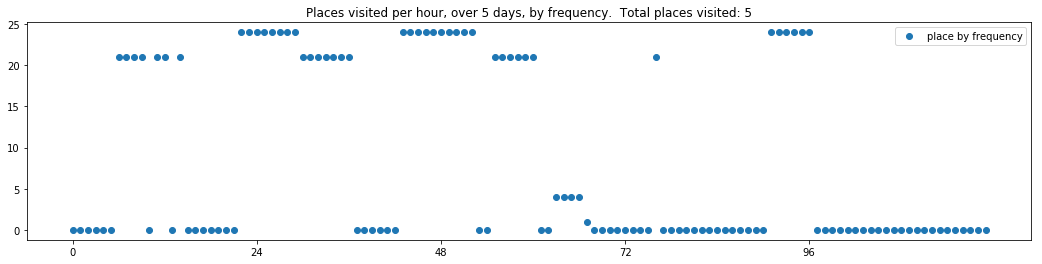

----- vector ----
prefix labels:  [96, 21]
[0, 0, 0, 0, 0, 0, 0, 96, 21, 21, 21, 21, 21, 21, 21, 21, 21, 96, 96, 96, 96, 96, 96, 96]
[96, 96, 96, 96, 96, 96, 96, 96, 21, 21, 21, 21, 21, 21, 21, 21, 21, 96, 96, 96, 96, 96, 96, 96]
[96, 96, 96, 0, 21, 0, 0, 21, 0, 0, 21, 21, 21, 21, 21, 21, 21, 21, 96, 96, 96, 0, 96, 96]
[96, 96, 96, 96, 96, 0, 0, 0, 0, 21, 21, 21, 21, 21, 21, 21, 21, 20, 20, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


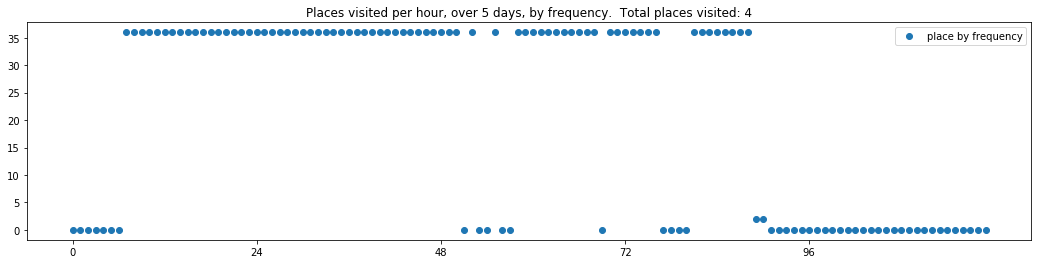

----- vector ----
prefix labels:  [450, 38]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 450, 450, 450, 450]
[450, 450, 450, 450, 450, 450, 450, 0, 0, 38, 38, 38, 38, 38, 38, 38, 38, 38, 0, 450, 450, 450, 450, 450]
[450, 450, 450, 450, 450, 0, 0, 0, 0, 38, 38, 38, 38, 38, 38, 38, 38, 0, 0, 450, 450, 450, 450, 450]
[450, 450, 450, 450, 450, 450, 450, 450, 450, 38, 38, 38, 0, 0, 0, 231, 38, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 0, 0]


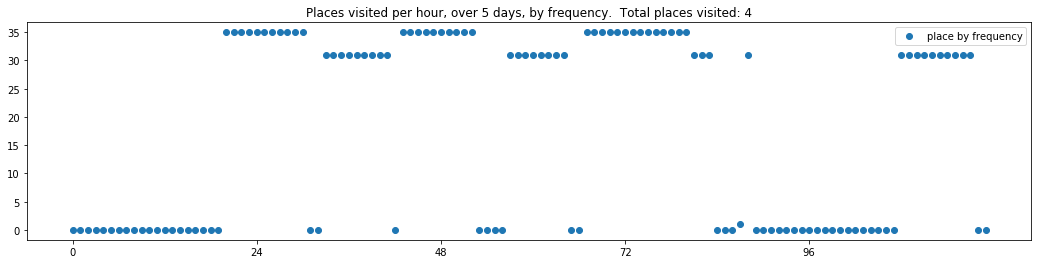


-------showing vectors for model: T-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.8
----- vector ----
prefix labels:  [526, 526]
[0, 0, 0, 0, 0, 0, 0, 526, 526, 526, 526, 526, 526, 526, 332, 526, 526, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 526, 526, 526, 526, 526, 526, 526, 526, 526, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 526, 526, 526, 526, 526, 526, 526, 526, 526, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 526, 526, 526, 526, 526, 526, 526, 526, 526, 0, 526, 0, 0, 0, 0, 0, 0]


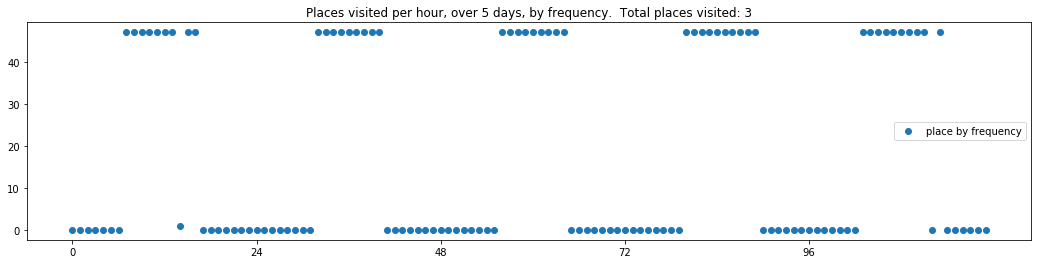

----- vector ----
prefix labels:  [84, 84]
[0, 0, 0, 0, 0, 0, 0, 84, 84, 84, 84, 0, 84, 84, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 84, 84, 84, 84, 84, 84, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


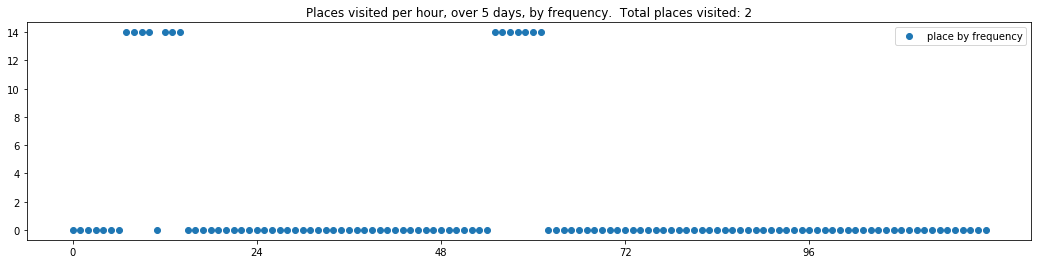

----- vector ----
prefix labels:  [25, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 25]
[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 25]
[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 25]
[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 25]
[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]


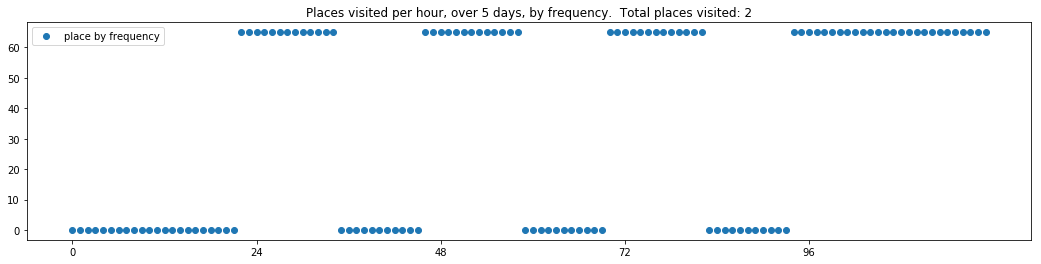


-------showing vectors for model: T-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.9
----- vector ----
prefix labels:  [70, 254]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 254, 254, 254, 254, 254, 254, 254, 254, 70, 70, 70, 70, 70, 70, 70]
[70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70]
[70, 70, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 70, 70, 70, 70, 70]
[70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70]
[70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70]


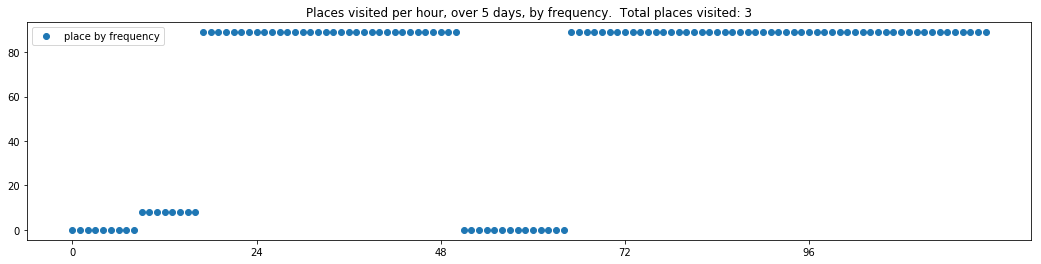

----- vector ----
prefix labels:  [76, 76]
[0, 0, 0, 0, 0, 0, 0, 0, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 0, 0, 0]


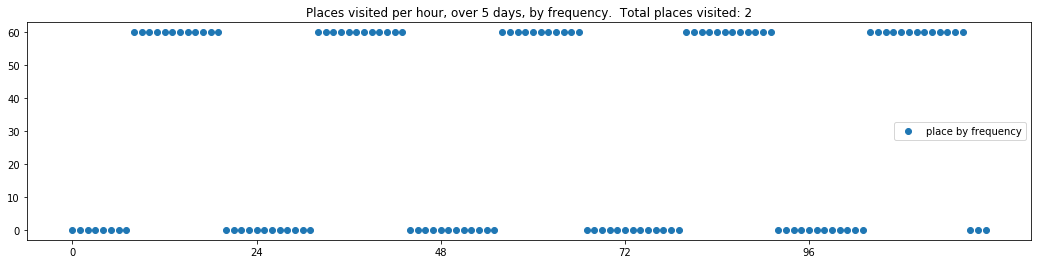

----- vector ----
prefix labels:  [470, 470]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 470, 470, 470, 226, 470, 470, 0, 470, 470, 470, 470, 470]
[470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 470, 470, 470, 470, 470, 470, 470, 470, 470, 0, 0, 0, 0, 0, 0, 0, 470, 470, 470, 470]
[470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 470, 470, 470]
[470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 0, 0, 470, 470, 470, 470, 470, 470, 470, 470]


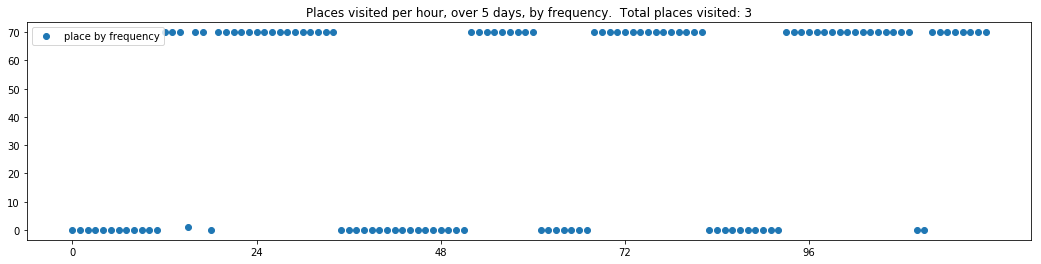


-------showing vectors for model: T-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.0
----- vector ----
prefix labels:  [555, 8]
[555, 0, 0, 0, 555, 555, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0]
[555, 555, 555, 555, 555, 555, 555, 555, 555, 36, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 555, 555, 555, 555]
[29, 555, 555, 555, 555, 555, 555, 555, 555, 555, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 555, 555, 555, 555]
[555, 555, 555, 555, 555, 555, 555, 555, 555, 555, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 555, 555, 555, 555]
[555, 555, 555, 555, 555, 555, 555, 555, 555, 555, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 555, 555, 555, 555]


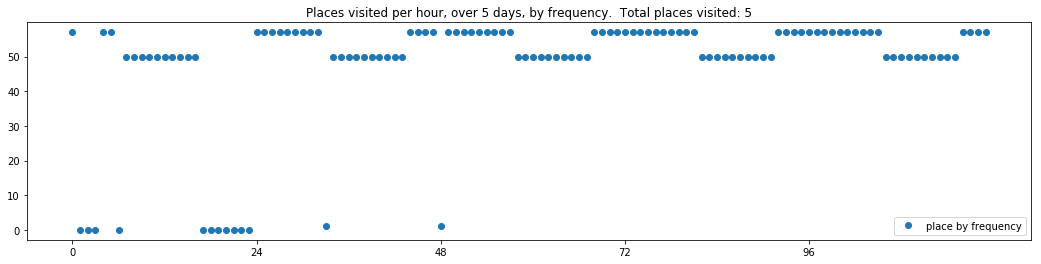

----- vector ----
prefix labels:  [537, 537]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 146, 537, 537, 537, 537, 537, 537, 537, 537, 537]
[537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 323, 537, 537, 537, 537]
[537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537]
[537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537]
[537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537, 537]


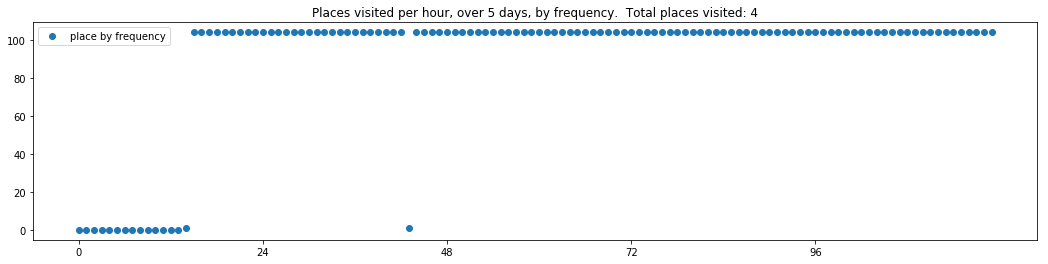

----- vector ----
prefix labels:  [395, 53]
[0, 0, 0, 0, 0, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 395, 395, 395, 395, 395, 395, 395, 395, 395]
[395, 395, 395, 395, 395, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 395, 395, 395, 395, 395, 395, 395, 395, 395]
[395, 395, 395, 395, 395, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 395, 395, 395, 395, 395, 395, 395, 395, 395]
[395, 395, 395, 395, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 395, 395, 395, 395, 395, 395, 395, 395, 395]
[395, 395, 395, 395, 395, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 395, 395, 395, 395, 395, 395, 395, 395, 395]


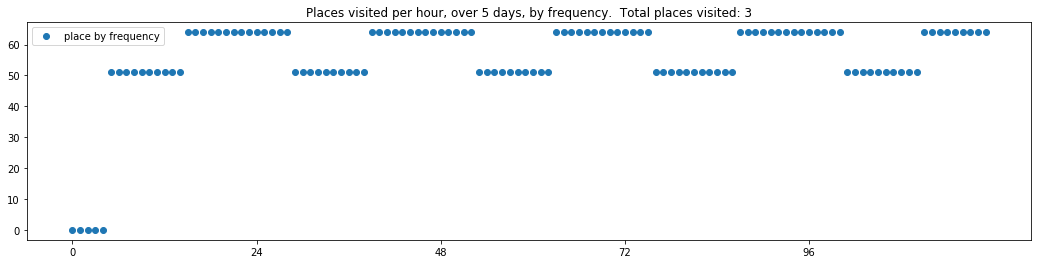


-------showing vectors for model: V-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.8
----- vector ----
prefix labels:  [401, 401]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 401, 401, 401, 401, 401, 401, 401, 401, 401]
[401, 401, 401, 401, 401, 401, 401, 401, 0, 0, 0, 0, 0, 0, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401]
[401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401]
[401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401]
[401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401]


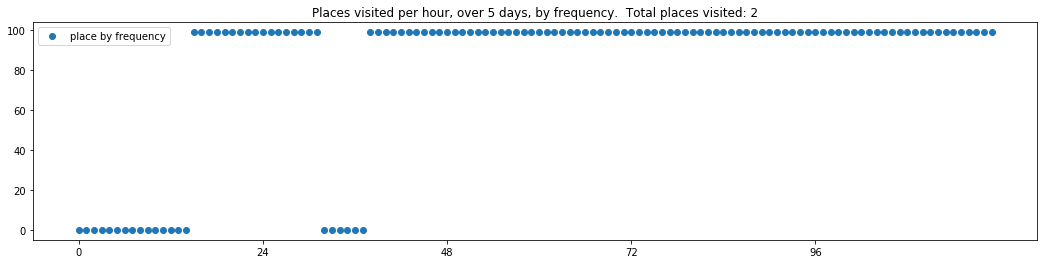

----- vector ----
prefix labels:  [391, 391]
[0, 0, 0, 0, 0, 0, 391, 391, 391, 391, 391, 391, 391, 391, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 391, 391, 391, 391, 391, 391, 391, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 391, 391, 391, 391, 391, 391, 391, 391, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391]


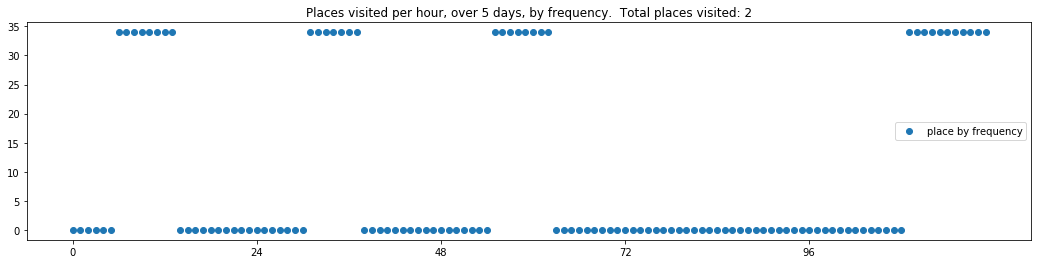

----- vector ----
prefix labels:  [43, 533]
[0, 0, 0, 0, 0, 0, 0, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 43, 43, 43, 43, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 43, 43, 43, 43, 43, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 43, 43, 43, 43, 43, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 43, 43, 43, 43, 43, 43, 43]


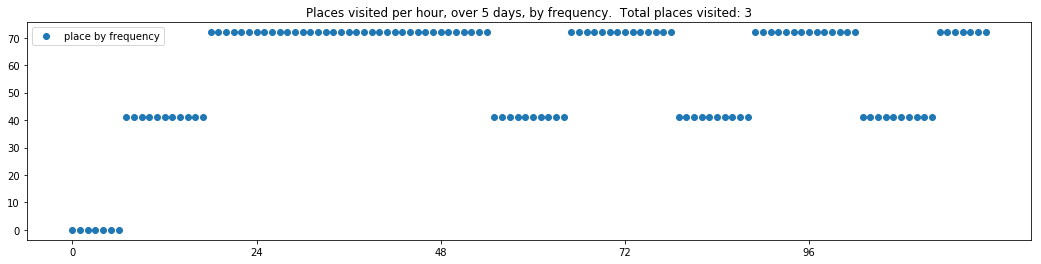


-------showing vectors for model: V-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.9
----- vector ----
prefix labels:  [588, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 22, 439, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 588, 588, 588]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 0, 0, 0, 0, 0, 588, 588, 0, 588, 588, 588, 588]
[588, 588, 588, 588, 588, 588, 0, 0, 0, 0, 0, 0, 0, 0, 112, 112, 588, 588, 588, 0, 588, 588, 588, 588]
[588, 588, 588, 588, 588, 588, 588, 588, 0, 0, 0, 0, 0, 588, 588, 588, 588, 588, 588, 588, 588, 588, 588, 588]


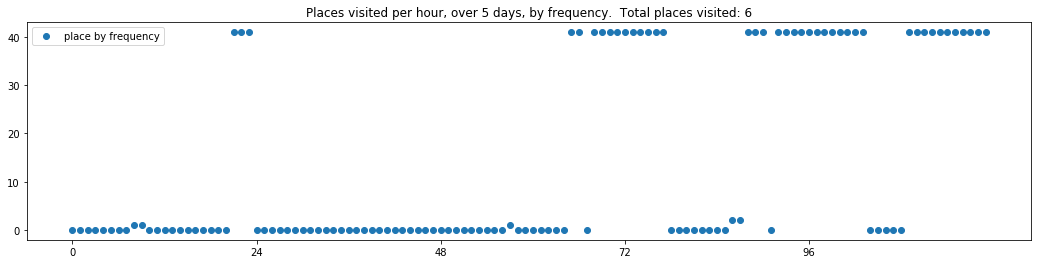

----- vector ----
prefix labels:  [600, 185]
[0, 0, 0, 0, 0, 0, 0, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 600, 600, 600, 600, 600, 600, 600]
[600, 600, 600, 600, 600, 600, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 600, 600, 600, 600, 600, 600, 600]
[600, 600, 600, 600, 600, 600, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 600, 600, 600, 600, 600, 600, 600]
[600, 600, 600, 600, 600, 600, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 600, 600, 600]
[600, 600, 600, 600, 600, 600, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185]


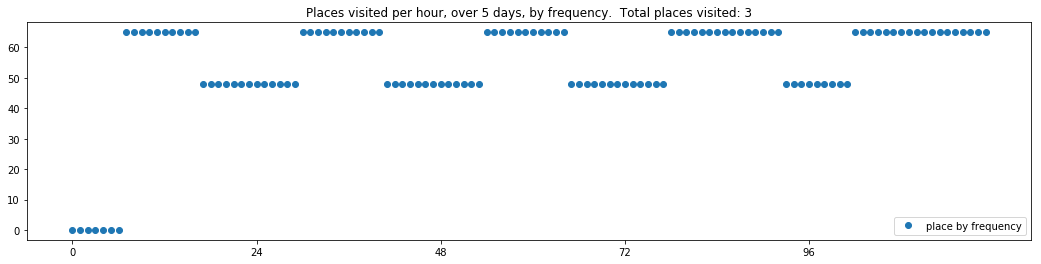

----- vector ----
prefix labels:  [314, 314]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 314, 314, 585, 433, 433, 433, 433, 433, 433, 314, 314]
[314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 433, 314, 314, 314]
[314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 433, 433, 433, 314, 314, 314, 433, 433, 433, 433, 433, 314, 314, 314]
[314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 433, 433, 433, 314, 433, 433, 433, 433, 433, 433, 314, 314, 433]
[433, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314, 433, 433, 433, 314, 314, 314]


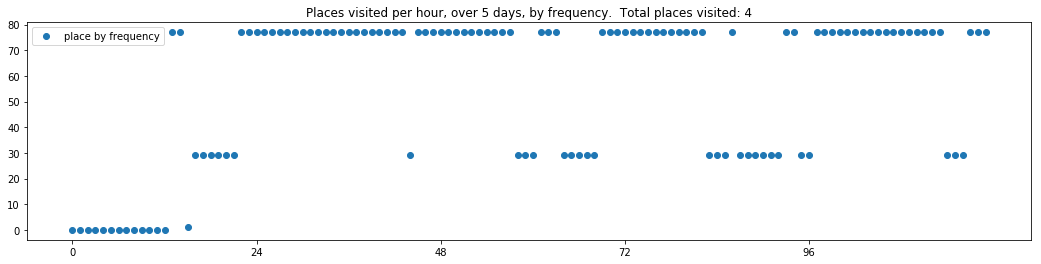


-------showing vectors for model: V-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0
----- vector ----
prefix labels:  [557, 557]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 636, 184, 184, 184, 184, 184, 184, 267, 557, 557, 557]
[557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 505, 284, 284, 56, 636, 636, 636, 636, 557, 557, 557]
[557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 10, 636, 636, 636, 636, 557, 0, 0, 0, 0, 197, 197]
[197, 197, 197, 557, 557, 557, 557, 557, 557, 557, 557, 557, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 0, 557]
[557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 636, 636, 636, 636, 636, 636, 0, 557, 557, 557, 557]


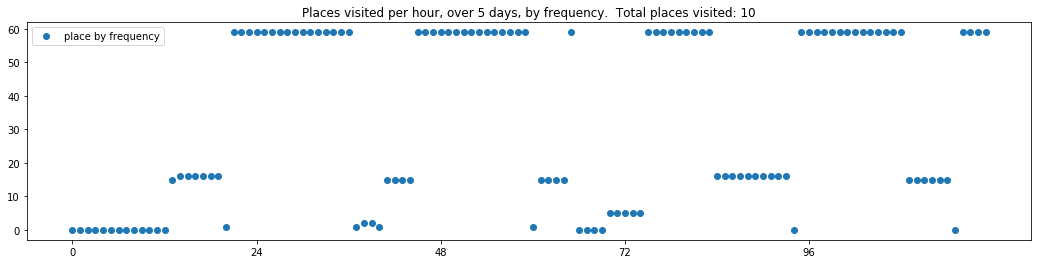

----- vector ----
prefix labels:  [41, 41]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 503, 503, 0, 0, 0, 0, 0, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 41, 0, 0, 0, 633, 0, 0, 0, 0, 0, 0, 0, 0, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 503, 503, 503, 503, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 0, 0, 0, 0, 0, 0, 0, 24, 24, 24, 0, 0, 0, 0, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 0, 0, 0, 0, 0, 0, 0, 41, 41, 403, 403, 41, 41, 41, 41, 41, 41]


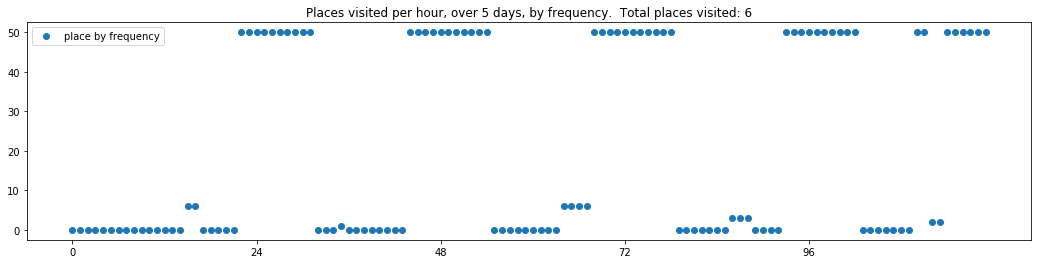

----- vector ----
prefix labels:  [341, 341]
[0, 0, 0, 0, 0, 0, 0, 341, 341, 341, 0, 0, 0, 0, 0, 341, 341, 341, 341, 341, 341, 341, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 341, 341, 0, 0, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 341, 341, 341, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


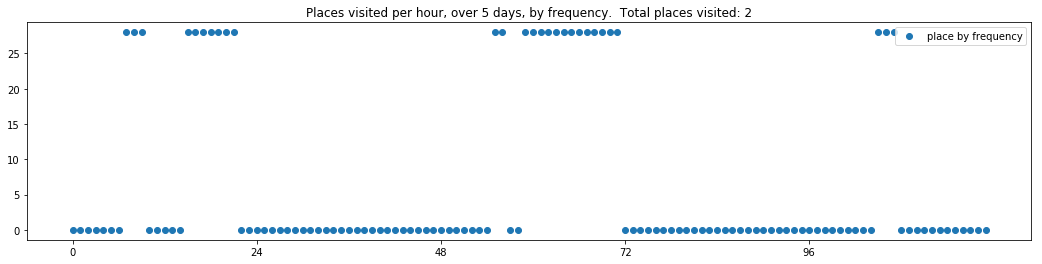


-------showing vectors for model: V-bidirectional.3-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.1
----- vector ----
prefix labels:  [466, 364]
[0, 0, 0, 0, 0, 0, 0, 0, 364, 364, 69, 69, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 466]
[466, 466, 466, 466, 466, 466, 466, 466, 55, 55, 55, 119, 119, 119, 119, 0, 0, 0, 0, 0, 602, 602, 466, 466]
[466, 466, 466, 466, 466, 466, 466, 466, 364, 364, 364, 364, 0, 0, 0, 0, 0, 0, 466, 466, 466, 466, 466, 466]
[466, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 581, 466, 466, 466, 466, 466, 466, 466, 466, 466, 466, 466]
[466, 466, 466, 466, 466, 466, 466, 466, 466, 0, 0, 0, 271, 271, 271, 271, 271, 0, 8, 8, 21, 21, 21, 21]


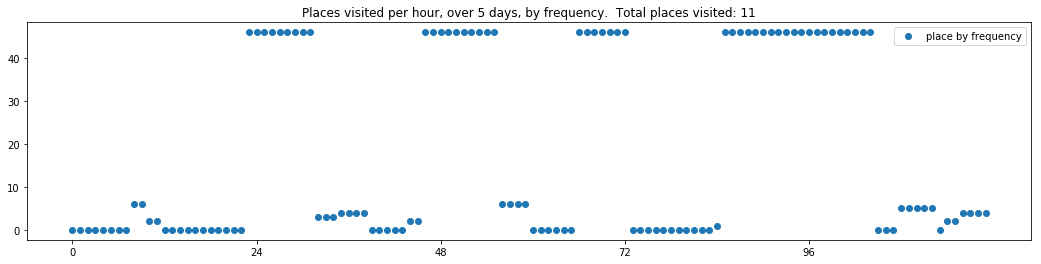

----- vector ----
prefix labels:  [275, 275]
[0, 0, 0, 0, 0, 0, 0, 0, 275, 254, 275, 412, 275, 275, 275, 275, 275, 634, 634, 275, 275, 275, 275, 275]
[275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275]
[275, 275, 275, 275, 275, 275, 275, 275, 26, 26, 26, 26, 275, 275, 275, 275, 0, 275, 275, 413, 275, 275, 275, 275]
[275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 0, 0, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275]
[275, 275, 275, 275, 275, 275, 275, 275, 0, 0, 0, 0, 0, 0, 0, 605, 275, 275, 597, 597, 597, 412, 412, 413]


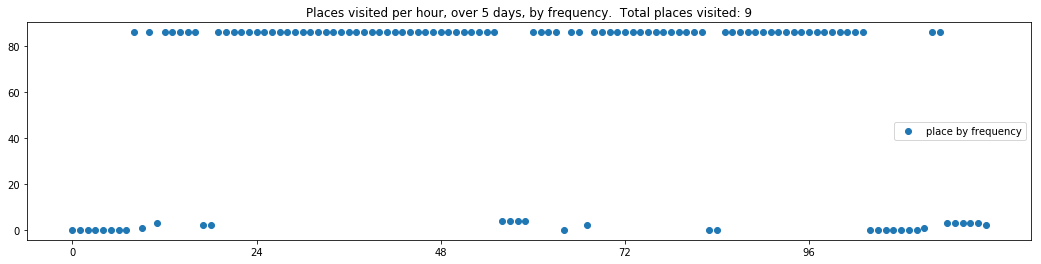

----- vector ----
prefix labels:  [502, 502]
[0, 0, 0, 0, 0, 0, 0, 0, 502, 502, 502, 502, 120, 120, 120, 502, 502, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 502, 502, 502, 120, 502, 502, 502, 502, 502, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 502, 502, 0, 0, 0, 502, 502, 635, 502, 502, 502, 502, 502, 502, 502, 502]
[502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 120, 502, 502, 502, 0, 0, 502, 567, 567, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 502, 120, 120, 120, 120, 502, 502, 502, 0, 0, 0, 0, 502, 0, 0, 0, 0]


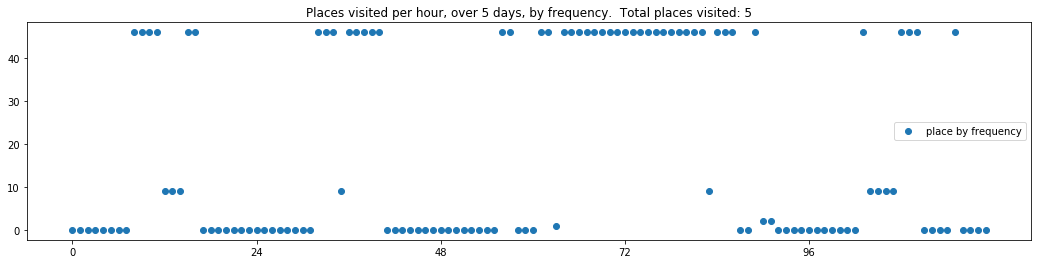


-------showing vectors for model: W-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:84-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.8
----- vector ----
prefix labels:  [296, 146]
[0, 0, 0, 0, 0, 0, 0, 0, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
[146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
[146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
[0, 0, 0, 0, 0, 0, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]
[0, 0, 0, 0, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146]


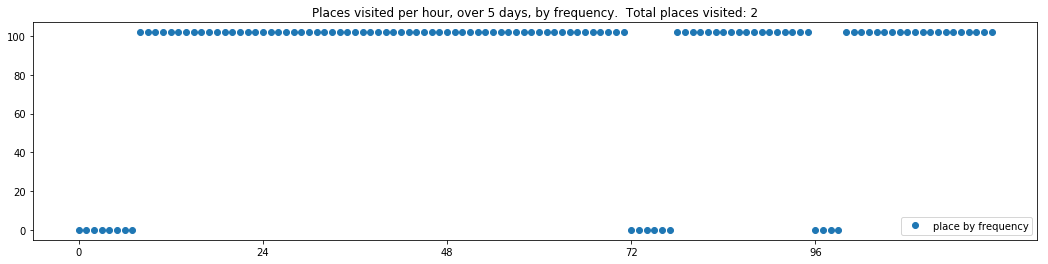

----- vector ----
prefix labels:  [163, 640]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 225, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 163, 163, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


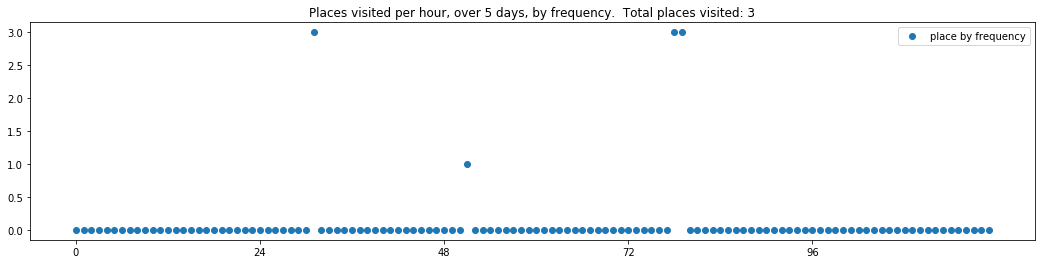

----- vector ----
prefix labels:  [125, 125]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


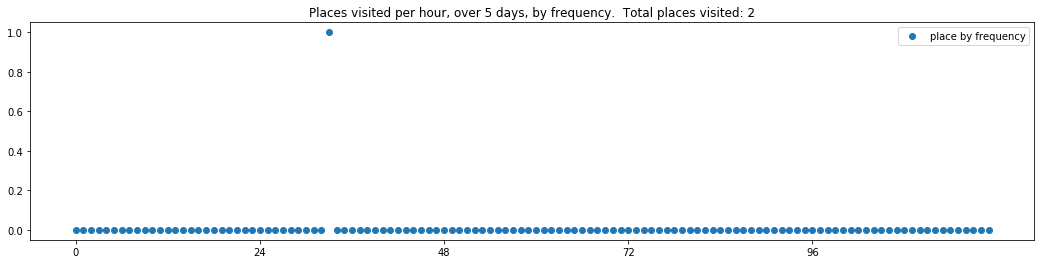


-------showing vectors for model: W-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:84-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.9
----- vector ----
prefix labels:  [64, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 0, 0, 0, 0, 408, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0]
[64, 64, 64, 64, 64, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


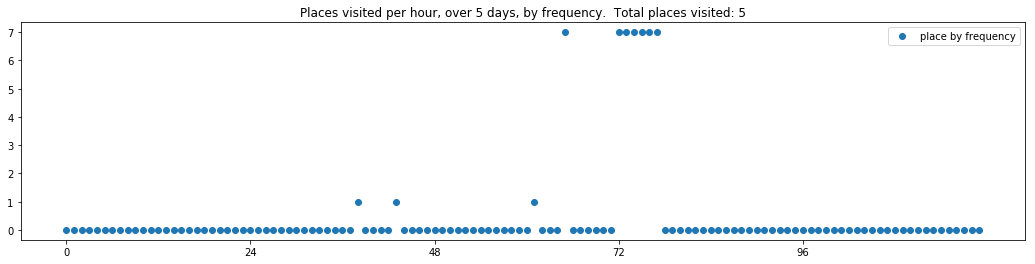

----- vector ----
prefix labels:  [462, 93]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0]
[0, 0, 0, 0, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93]
[93, 93, 93, 0, 0, 0, 0, 0, 0, 0, 272, 212, 93, 93, 93, 93, 93, 93, 483, 0, 462, 462, 462, 462]
[462, 462, 462, 462, 462, 462, 462, 462, 0, 93, 93, 93, 93, 0, 0, 93, 93, 93, 93, 97, 0, 0, 0, 0]
[0, 0, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 483, 0, 0, 0]


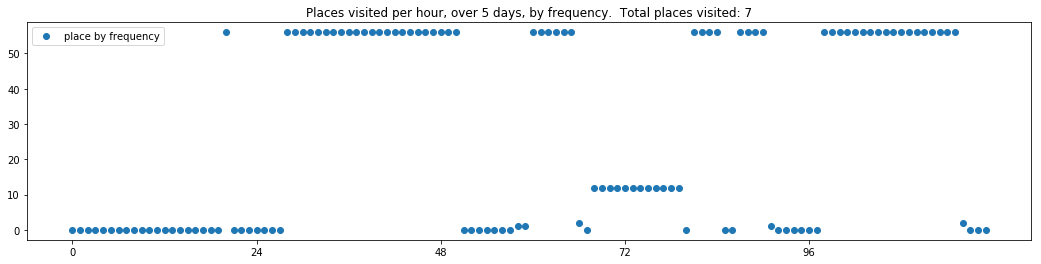

----- vector ----
prefix labels:  [126, 126]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
[126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
[126, 126, 126, 126, 126, 126, 126, 24, 24, 24, 24, 24, 24, 24, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
[126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
[126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126]


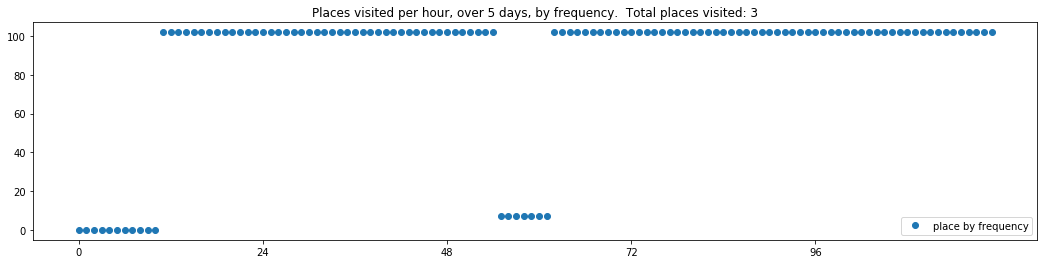


-------showing vectors for model: W-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:84-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0
----- vector ----
prefix labels:  [577, 577]
[0, 0, 0, 0, 0, 0, 0, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577]
[577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 256, 256, 577, 577, 577, 577]
[577, 577, 577, 487, 487, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577]
[577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 0, 0, 0]
[0, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577]


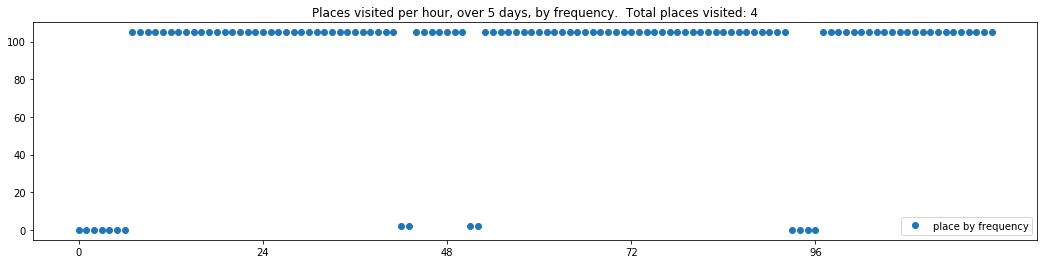

----- vector ----
prefix labels:  [150, 119]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119]
[119, 119, 119, 119, 0, 0, 404, 0, 0, 0, 0, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]
[150, 150, 150, 150, 0, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]
[150, 150, 150, 150, 150, 150, 0, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119]
[119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 413, 413, 413, 413]


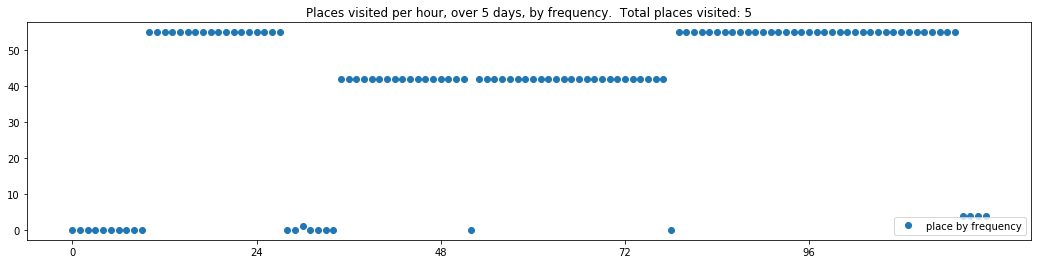

----- vector ----
prefix labels:  [44, 44]
[0, 0, 0, 0, 0, 0, 0, 0, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
[108, 108, 125, 125, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
[44, 0, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
[44, 44, 44, 0, 0, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 0, 0, 0]


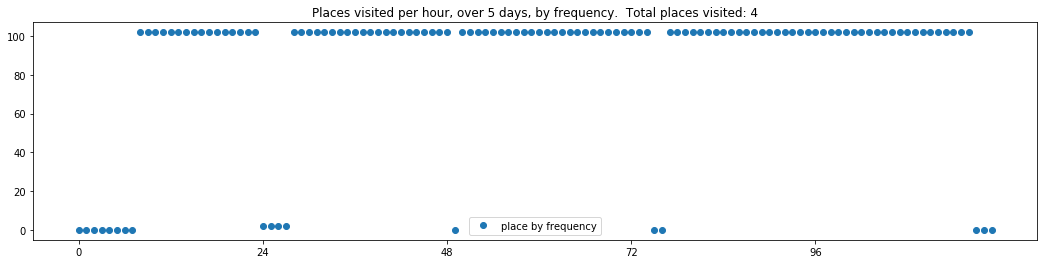


-------showing vectors for model: W-bidirectional.3-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:84-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.1
----- vector ----
prefix labels:  [400, 379]
[0, 0, 0, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 0, 0, 0]
[0, 0, 0, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400]
[400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400]
[400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400]
[400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400]


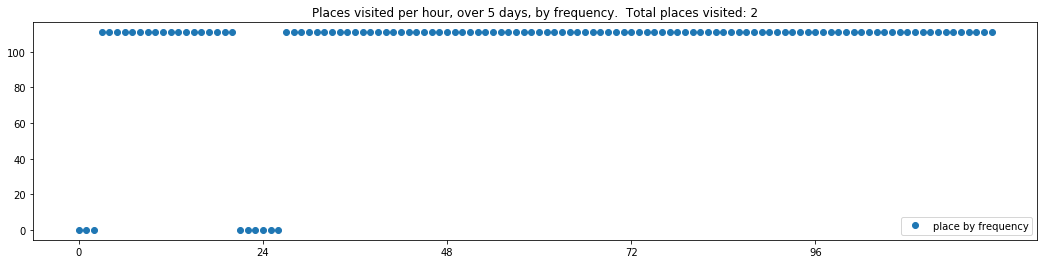

----- vector ----
prefix labels:  [196, 22]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196]
[196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 0, 0, 0, 196, 196, 196, 196, 95]
[0, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 0, 0, 0, 0, 0, 0, 75, 8, 0, 196]
[196, 196, 196, 196, 196, 196, 196, 196, 0, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196]
[196, 196, 0, 440, 440, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 196, 196, 196, 196, 196, 196, 196, 196]


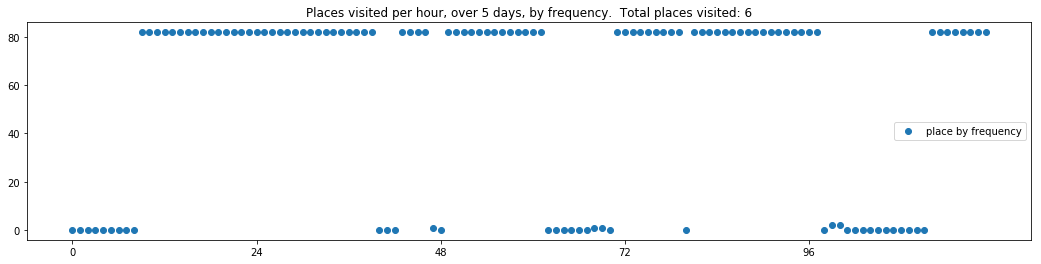

----- vector ----
prefix labels:  [45, 44]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]
[45, 45, 45, 44, 0, 0, 45, 45, 45, 45, 45, 45, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
[44, 44, 364, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 0, 0, 44, 44]
[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]
[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 592, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]


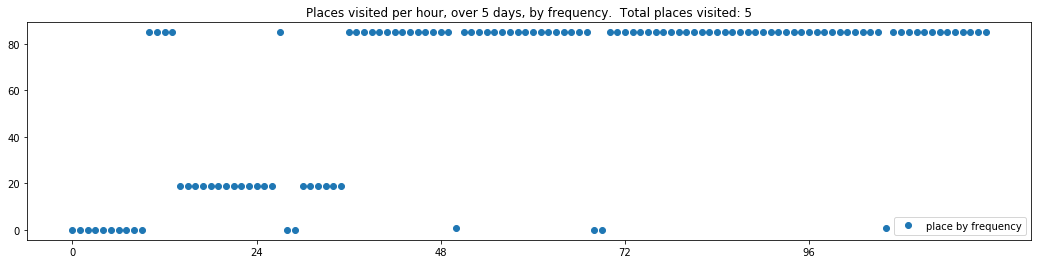


-------showing vectors for model: X-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:0.8
----- vector ----
prefix labels:  [467, 467]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 467, 467]
[467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 0, 0, 0, 0, 0, 0, 0, 0, 467, 467]
[467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467]
[467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467]
[467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467]


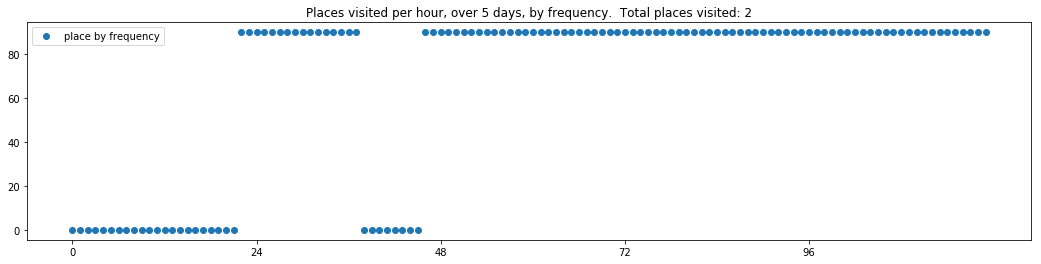

----- vector ----
prefix labels:  [494, 387]
[0, 0, 0, 0, 0, 0, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 261, 494, 494, 494, 494, 494]
[494, 494, 494, 494, 494, 494, 494, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 494, 494, 494, 494, 494]
[494, 494, 494, 494, 494, 494, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 494, 494, 494, 494, 494, 494, 494]
[494, 494, 494, 494, 494, 494, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387]
[387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387]


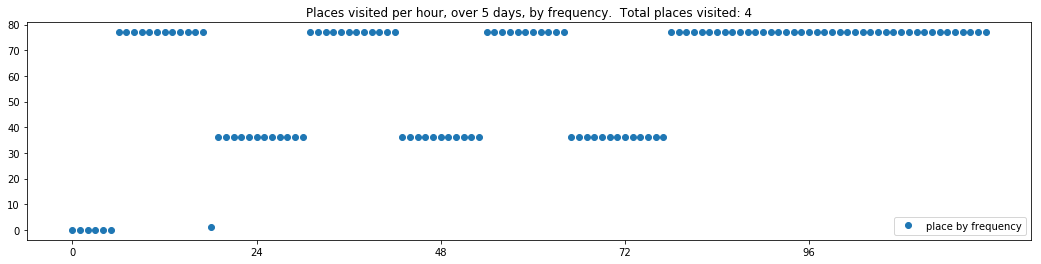

----- vector ----
prefix labels:  [31, 21]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 31, 31, 31, 31, 31, 31, 31]
[31, 31, 31, 31, 31, 31, 31, 31, 31, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 31]
[31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 231, 229, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
[31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 31, 31, 31, 31]
[31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 21, 21, 21, 21, 21, 21, 21, 21, 31, 31, 31, 31, 31]


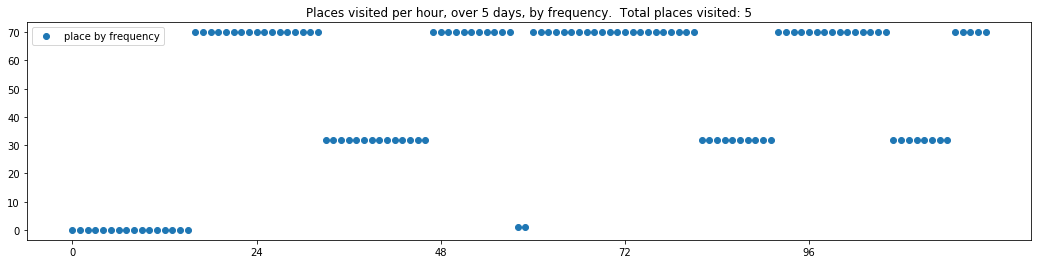


-------showing vectors for model: X-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:0.9
----- vector ----
prefix labels:  [353, 353]
[0, 0, 0, 0, 0, 0, 0, 0, 437, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353]
[353, 353, 353, 353, 353, 353, 353, 353, 437, 437, 437, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353]
[353, 353, 353, 353, 353, 353, 353, 353, 437, 437, 437, 437, 437, 437, 437, 27, 353, 353, 353, 353, 353, 353, 353, 353]
[353, 353, 353, 353, 353, 353, 353, 353, 353, 437, 437, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353]
[353, 353, 353, 353, 353, 353, 353, 353, 353, 437, 437, 437, 437, 437, 437, 437, 353, 353, 353, 353, 353, 353, 353, 353]


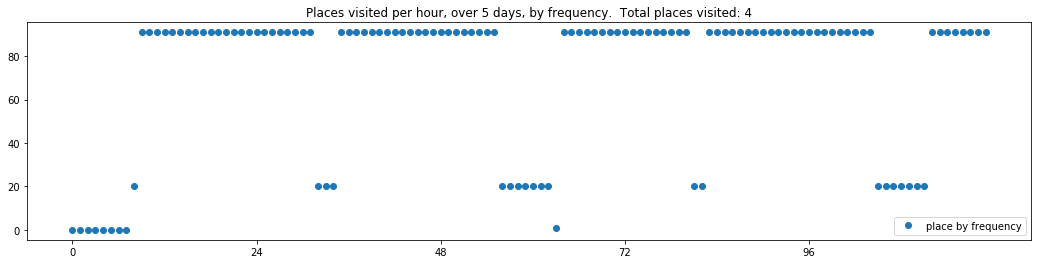

----- vector ----
prefix labels:  [167, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 167]
[167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167]
[167, 167, 167, 167, 0, 0, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167]


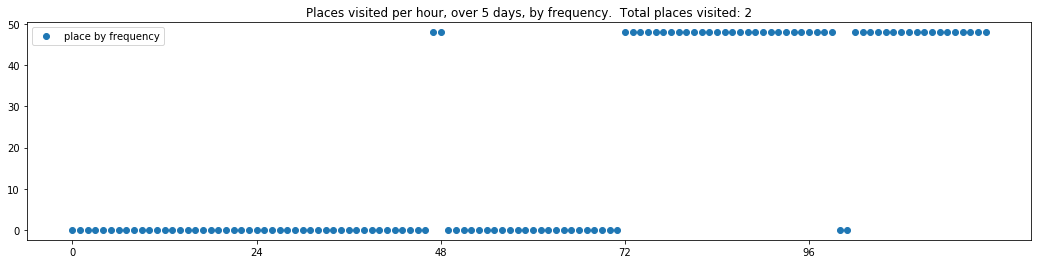

----- vector ----
prefix labels:  [314, 314]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 140, 140, 140, 140, 140, 140, 140, 140, 0, 0, 0, 0, 0]
[140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 214, 140]


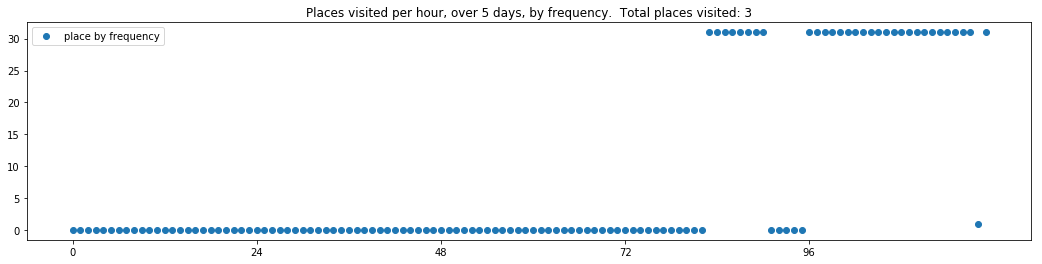


-------showing vectors for model: X-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.0
----- vector ----
prefix labels:  [620, 620]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 611, 611, 611, 611, 611, 611, 611, 0, 620]
[620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 0, 0, 0, 0, 0, 0, 620, 620, 620]
[620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 546, 0, 0, 611, 611, 611, 611, 611, 611, 611, 611, 0, 0, 620]
[620, 620, 620, 620, 620, 620, 620, 620, 620, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 620, 620]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 611, 611, 0, 620, 620]


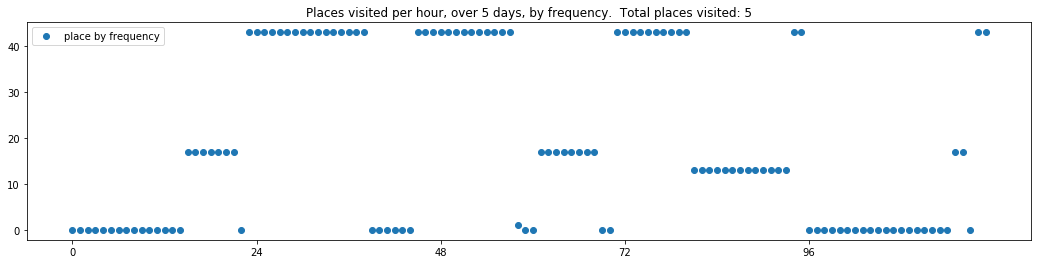

----- vector ----
prefix labels:  [186, 186]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 186, 186, 186, 186, 186, 186, 186, 186, 186, 151, 151, 151, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 151, 151, 151, 151, 151, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 32, 186, 186, 186, 186, 186, 186, 186, 186, 186, 151, 151, 151, 0, 0, 0]
[0, 146, 146, 146, 87, 104, 0, 0, 0, 151, 151, 151, 151, 593, 593, 0, 0, 0, 151, 151, 151, 151, 151, 151]


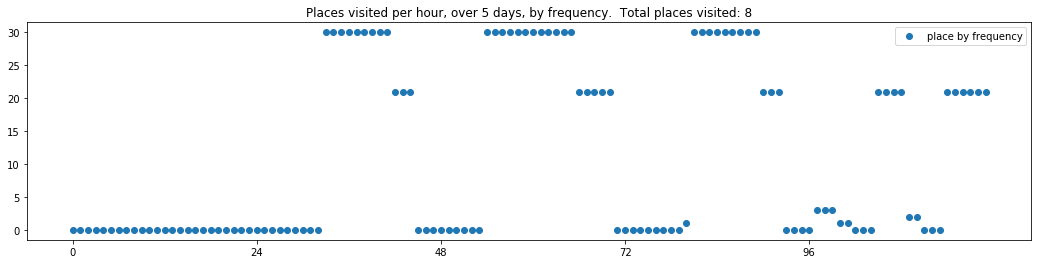

----- vector ----
prefix labels:  [601, 88]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 88, 88, 88, 88, 88, 88, 88, 88, 601, 601, 601, 601, 601, 601]
[601, 601, 601, 601, 601, 601, 601, 601, 601, 88, 88, 88, 88, 88, 88, 88, 88, 601, 374, 601, 601, 601, 601, 601]
[601, 601, 601, 601, 601, 601, 601, 601, 601, 0, 0, 513, 513, 367, 564, 564, 601, 601, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 601, 601, 601, 601]
[601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 0, 0, 0, 0]


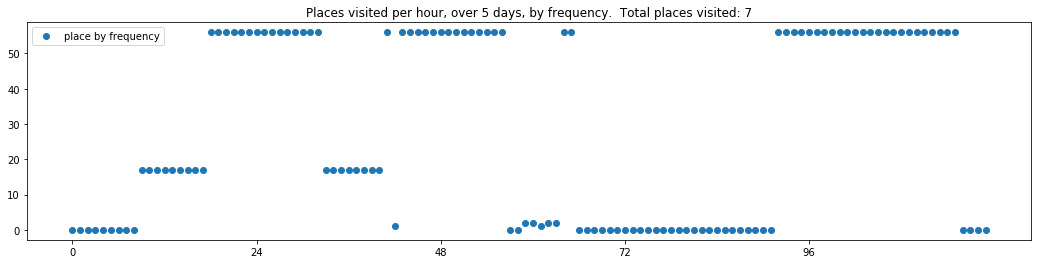


-------showing vectors for model: X-bidirectional.3-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.1
----- vector ----
prefix labels:  [116, 116]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 526, 0, 0, 116, 0, 116, 116, 0, 116, 116, 0, 116, 116, 116]
[116, 116, 116, 116, 116, 116, 116, 116, 0, 116, 0, 0, 0, 0, 0, 0, 334, 334, 299, 0, 116, 306, 116, 0]
[0, 0, 0, 0, 0, 0, 116, 116, 83, 0, 116, 116, 116, 116, 116, 116, 484, 484, 484, 533, 0, 0, 0, 0]
[0, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 0, 116, 116, 116, 116, 116, 0, 0, 0]
[0, 0, 116, 116, 116, 116, 116, 116, 116, 116, 0, 0, 158, 0, 0, 0, 0, 0, 0, 81, 32, 0, 0, 0]


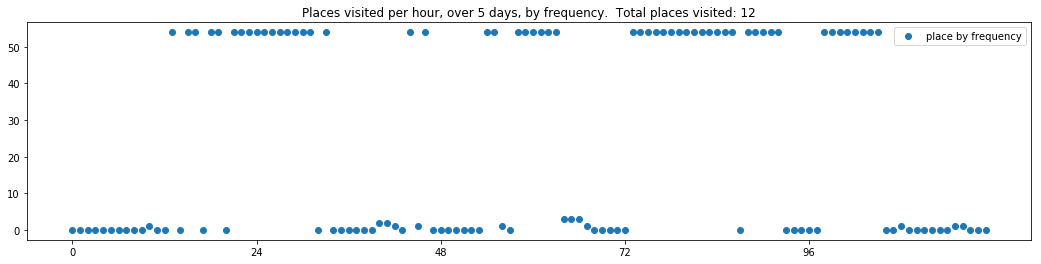

----- vector ----
prefix labels:  [593, 364]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 248]
[0, 248, 248, 248, 301, 0, 0, 306, 0, 0, 0, 0, 526, 0, 0, 0, 0, 0, 0, 0, 0, 0, 248, 248]
[248, 248, 248, 248, 248, 248, 248, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


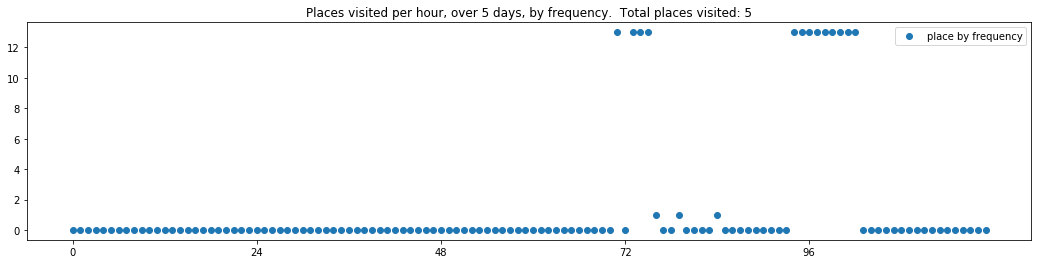

----- vector ----
prefix labels:  [622, 112]
[0, 0, 0, 0, 0, 0, 622, 622, 622, 112, 112, 112, 112, 112, 112, 112, 622, 622, 622, 622, 622, 622, 622, 622]
[622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 112, 112, 112, 112, 112, 112, 112, 622, 622, 622, 622, 622, 622, 622]
[622, 622, 622, 622, 622, 622, 622, 622, 151, 112, 112, 112, 112, 112, 112, 112, 112, 622, 622, 622, 622, 622, 622, 622]
[622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 0, 227, 227, 227, 227, 76, 339, 151, 622, 622, 622, 622, 622, 622]
[622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622]


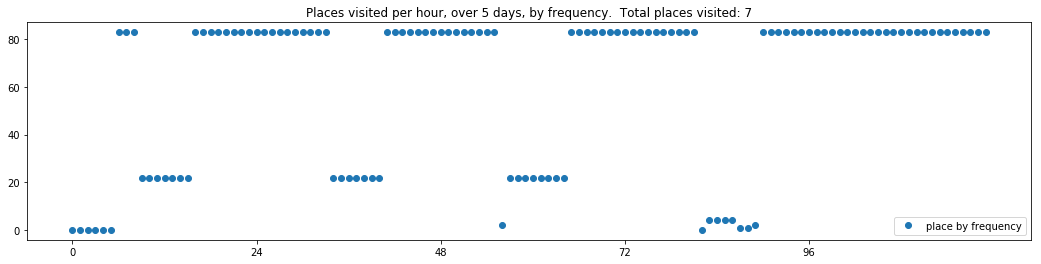


-------showing vectors for model: X-bidirectional.4-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.2
----- vector ----
prefix labels:  [558, 558]
[0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 404, 386, 0, 0, 0, 20, 517, 98, 0, 20, 20, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 98, 235, 0, 99, 0, 423, 242, 75]
[123, 21, 459, 459, 21, 21, 21, 21, 21, 21, 21, 21, 21, 473, 330, 307, 8, 199, 76, 98, 509, 51, 239, 239]
[576, 21, 21, 21, 21, 21, 21, 21, 21, 53, 53, 0, 495, 495, 76, 157, 157, 58, 63, 21, 21, 21, 239, 21]


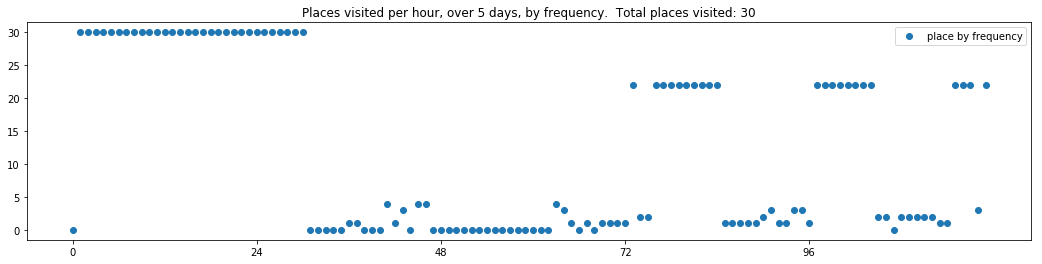

----- vector ----
prefix labels:  [548, 0]
[0, 0, 0, 0, 0, 0, 0, 548, 0, 0, 0, 0, 0, 162, 0, 515, 515, 306, 124, 20, 333, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 379, 36, 95, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 455, 221, 54, 12, 12, 420, 121, 126, 0, 0, 413]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 221, 641, 395, 485, 566, 495, 17, 480, 384, 422, 0]
[0, 271, 271, 271, 143, 21, 98, 498, 498, 498, 498, 498, 498, 0, 23, 23, 42, 42, 498, 498, 619, 498, 498, 498]


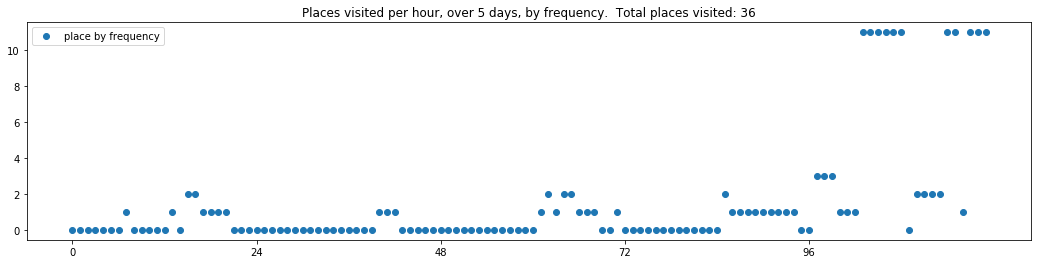

----- vector ----
prefix labels:  [418, 418]
[0, 0, 0, 0, 0, 0, 443, 21, 21, 227, 418, 418, 418, 69, 0, 0, 242, 242, 239, 239, 75, 418, 418, 418]
[418, 418, 418, 418, 418, 418, 418, 443, 418, 443, 49, 329, 329, 443, 443, 623, 418, 418, 418, 418, 78, 78, 78, 78]
[0, 78, 78, 418, 418, 418, 418, 418, 443, 516, 516, 0, 240, 240, 0, 418, 0, 418, 574, 239, 239, 49, 418, 418]
[418, 239, 0, 0, 443, 443, 443, 443, 443, 443, 443, 443, 405, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418]
[418, 516, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 49, 18, 18, 239, 0]


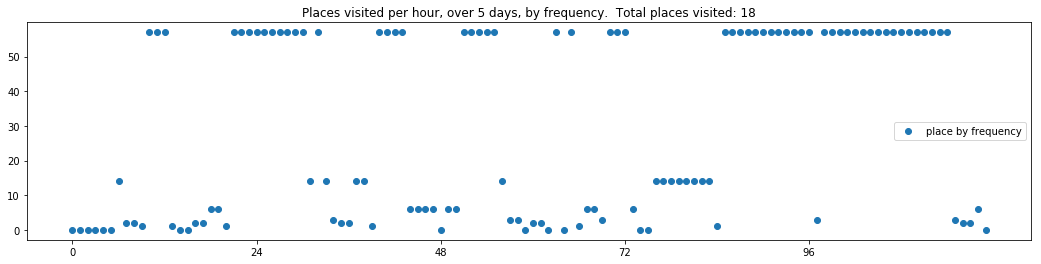


-------showing vectors for model: Y-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.8
----- vector ----
prefix labels:  [190, 190]
[0, 0, 0, 0, 0, 0, 0, 190, 190, 190, 190, 190, 190, 190, 190, 190, 0, 611, 190, 190, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 142, 203, 203, 203, 203]
[190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190]
[190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 286, 286, 286, 286, 190, 190]
[190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190]


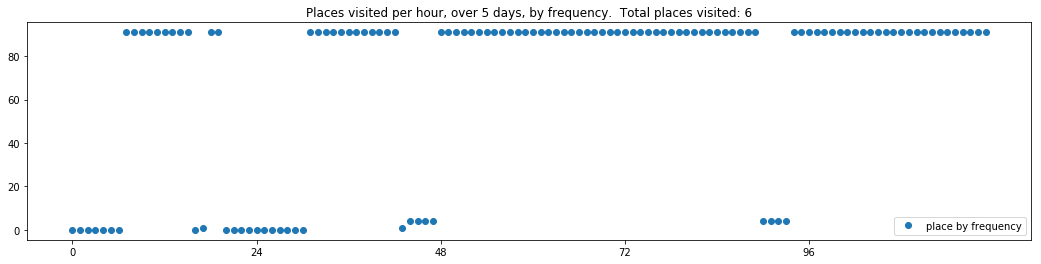

----- vector ----
prefix labels:  [39, 39]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]
[39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]
[39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]
[39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]


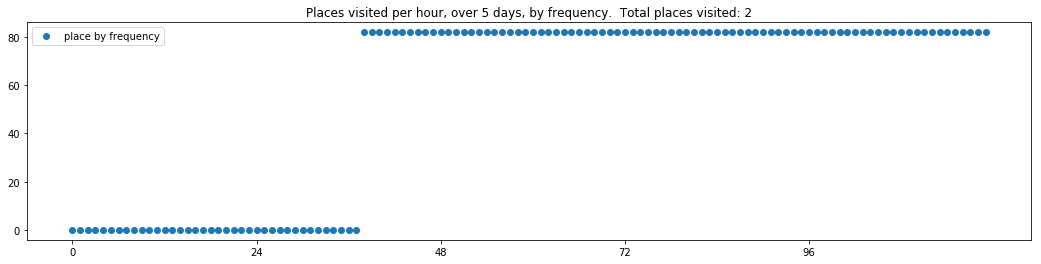

----- vector ----
prefix labels:  [286, 286]
[0, 0, 0, 0, 0, 0, 0, 286, 286, 286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 286, 286, 286, 286, 286, 0, 0, 0, 0, 0, 0, 0, 0, 0, 286, 286, 286, 286]
[286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286]
[286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286]


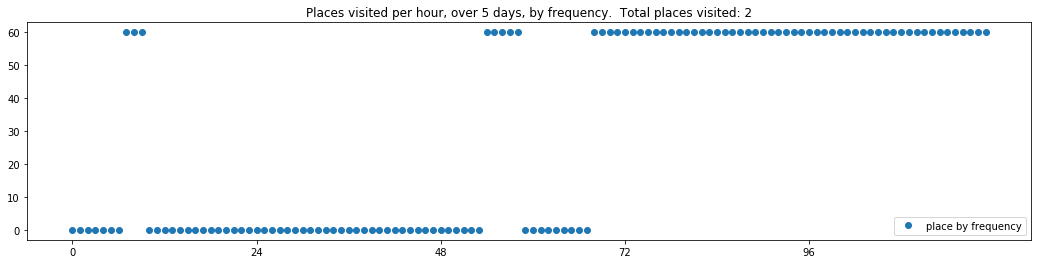


-------showing vectors for model: Y-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.9
----- vector ----
prefix labels:  [47, 47]
[0, 0, 0, 0, 0, 0, 0, 0, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 247, 315, 315, 315, 315]
[315, 315, 315, 315, 315, 315, 315, 315, 247, 47, 47, 47, 47, 315, 315, 126, 248, 315, 315, 315, 315, 315, 315, 315]


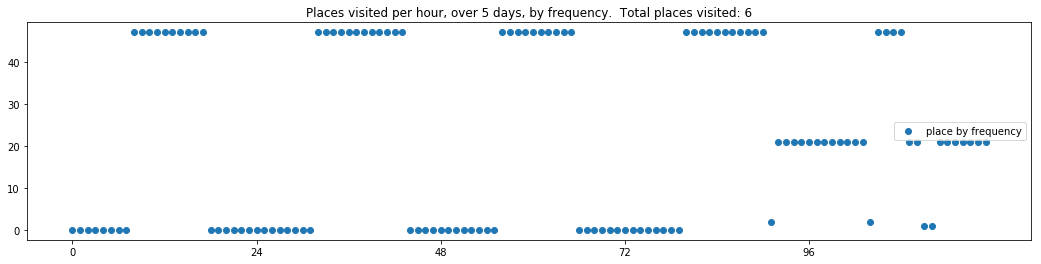

----- vector ----
prefix labels:  [599, 599]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599]
[599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 515, 515, 515, 515, 515, 515, 515]
[515, 515, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 599, 515, 515, 515, 515, 515, 515, 515]


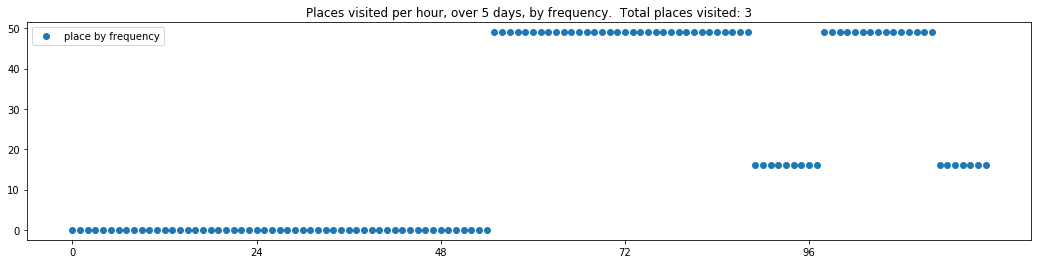

----- vector ----
prefix labels:  [7, 116]
[0, 0, 0, 0, 0, 0, 0, 0, 24, 24, 24, 24, 24, 24, 89, 89, 89, 89, 458, 458, 458, 458, 458, 458]
[458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458]
[458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458]
[458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458]
[458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458]


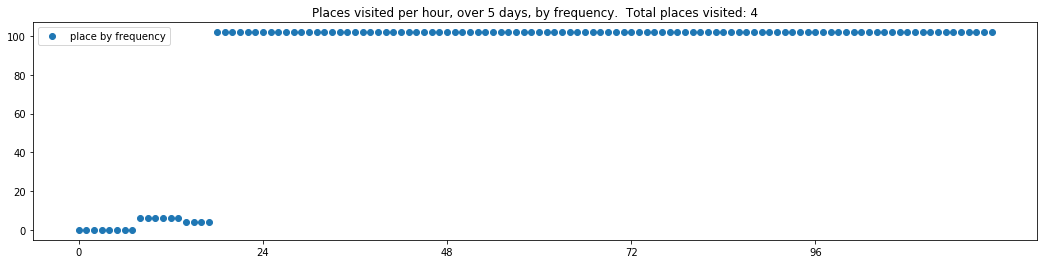


-------showing vectors for model: Y-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.0
----- vector ----
prefix labels:  [253, 577]
[0, 0, 0, 0, 0, 0, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 122, 253, 253, 253, 253, 253, 253]
[253, 253, 253, 253, 253, 253, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 253, 253, 253, 253, 253, 253, 253]
[253, 253, 253, 253, 253, 253, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 253, 253, 253, 253, 253, 253, 253]
[253, 253, 253, 253, 253, 0, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 253, 253, 253, 253, 253, 253, 253]
[253, 253, 253, 253, 253, 253, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 253, 253, 253, 253, 253, 253, 253]


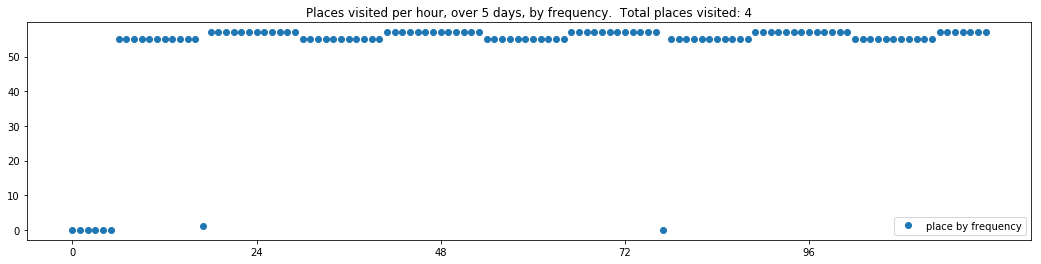

----- vector ----
prefix labels:  [163, 640]
[0, 0, 0, 0, 0, 0, 0, 322, 322, 0, 0, 0, 0, 0, 0, 0, 0, 0, 114, 114, 208, 208, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 238, 238, 0, 114, 114, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 358, 358, 0, 0, 0, 0, 282, 383, 208, 208]
[208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 20, 0, 0, 12, 12, 0, 62, 62, 62, 62, 62, 62]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 66, 0, 208, 208, 208, 0, 0, 0, 208, 208, 208, 208, 208, 0, 0]


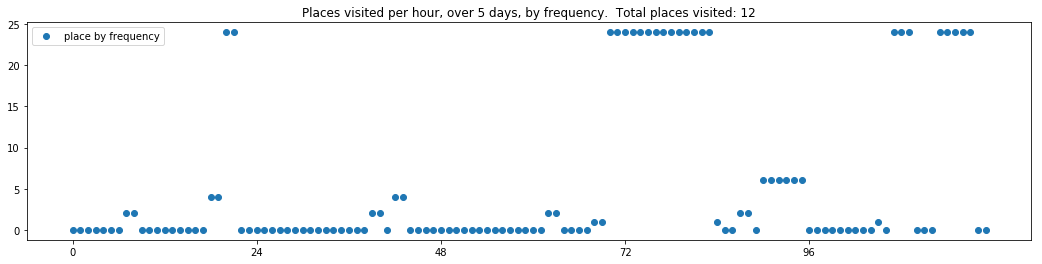

----- vector ----
prefix labels:  [626, 26]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 26, 0, 0, 0, 0, 0, 0, 0, 0, 626, 626, 626, 626]
[626, 626, 626, 626, 626, 626, 626, 0, 0, 0, 502, 502, 502, 502, 487, 487, 0, 626, 626, 626, 626, 626, 626, 626]
[626, 626, 626, 626, 626, 626, 626, 565, 565, 0, 0, 0, 0, 0, 487, 487, 487, 487, 487, 0, 626, 626, 626, 626]
[626, 626, 626, 626, 626, 626, 626, 120, 502, 0, 626, 626, 275, 275, 275, 487, 487, 487, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 487, 487, 487, 487, 0, 626, 626, 626, 626]


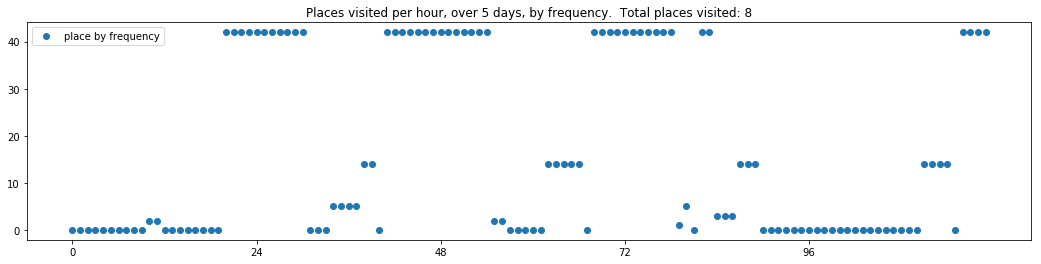


-------showing vectors for model: Y-bidirectional.3-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.1
----- vector ----
prefix labels:  [190, 190]
[0, 0, 0, 0, 0, 0, 190, 194, 396, 396, 396, 396, 385, 396, 617, 149, 0, 18, 190, 311, 0, 190, 190, 190]
[190, 190, 190, 190, 190, 190, 190, 390, 303, 303, 303, 303, 303, 303, 453, 453, 453, 453, 453, 513, 513, 189, 520, 190]
[190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 402, 453, 341, 195, 195, 195, 195, 195, 167, 590]
[590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 167]
[167, 167, 167, 167, 167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 590, 590, 590, 0, 8, 8, 8, 8, 35]


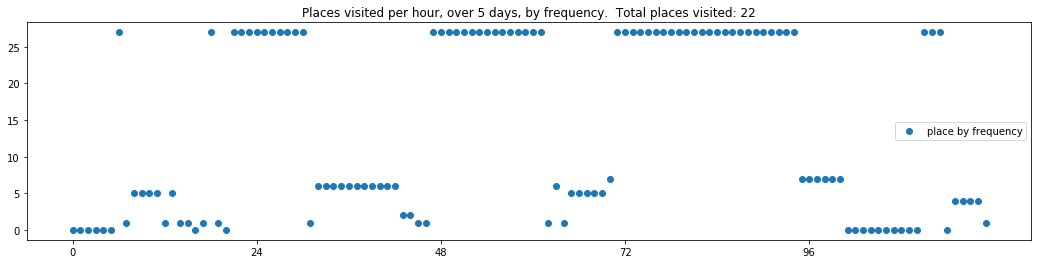

----- vector ----
prefix labels:  [623, 623]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 623, 623, 623, 623, 623, 623, 623, 623, 163, 163, 163, 562, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 445, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 407, 407, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 330, 623, 623, 623, 623, 623, 623, 623, 0, 4, 4, 284, 0, 0, 540, 23, 23, 23, 23]
[23, 23, 23, 23, 23, 267, 386, 386, 76, 76, 52, 52, 473, 114, 114, 114, 283, 114, 114, 0, 261, 235, 453, 462]


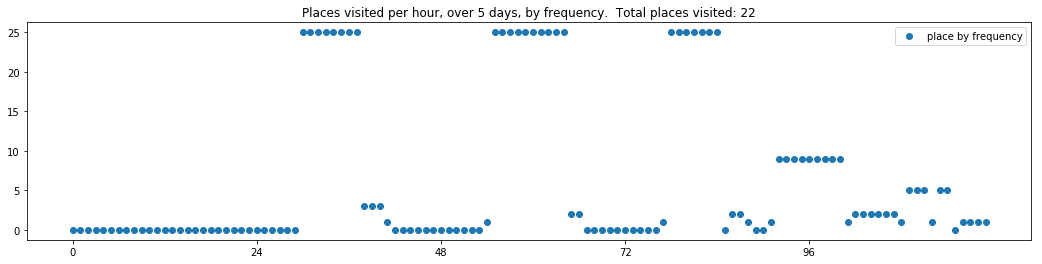

----- vector ----
prefix labels:  [108, 218]
[0, 0, 0, 0, 0, 0, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 289, 26, 108, 108, 108, 108, 108]
[108, 108, 108, 108, 108, 108, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 0, 108, 108, 108, 108, 108, 108]
[108, 108, 108, 108, 108, 108, 2, 218, 218, 218, 218, 218, 218, 218, 218, 218, 218, 109, 108, 108, 108, 108, 108, 108]
[108, 108, 108, 108, 108, 218, 218, 218, 218, 218, 218, 218, 218, 191, 191, 296, 235, 235, 235, 235, 235, 235, 235, 235]
[235, 235, 222, 222, 430, 409, 87, 261, 261, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 358, 276, 276, 276]


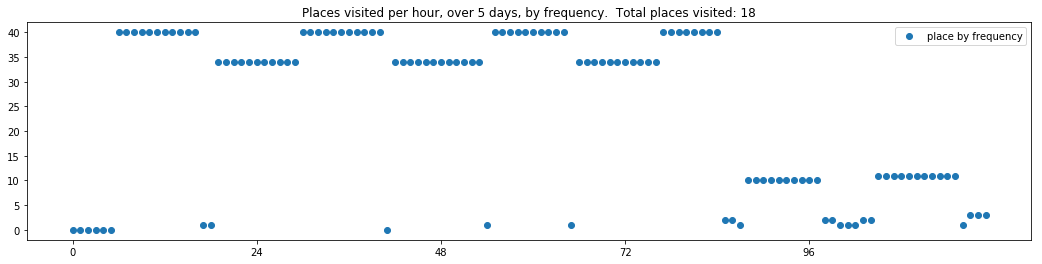


-------showing vectors for model: Y-bidirectional.4-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.2
----- vector ----
prefix labels:  [304, 304]
[0, 0, 0, 21, 21, 0, 21, 21, 21, 0, 22, 22, 0, 21, 0, 391, 391, 304, 304, 0, 304, 304, 304, 304]
[304, 304, 304, 0, 0, 0, 21, 0, 21, 33, 330, 330, 33, 33, 574, 574, 357, 357, 334, 334, 557, 0, 0, 304]
[304, 0, 0, 0, 0, 54, 302, 77, 77, 267, 431, 0, 0, 0, 0, 398, 15, 15, 409, 409, 392, 392, 2, 517]
[473, 229, 317, 355, 511, 511, 324, 324, 503, 261, 278, 178, 617, 133, 133, 88, 88, 88, 514, 255, 2, 539, 615, 350]
[385, 87, 267, 79, 159, 308, 539, 41, 267, 267, 324, 305, 305, 415, 212, 40, 239, 239, 305, 305, 102, 251, 283, 208]


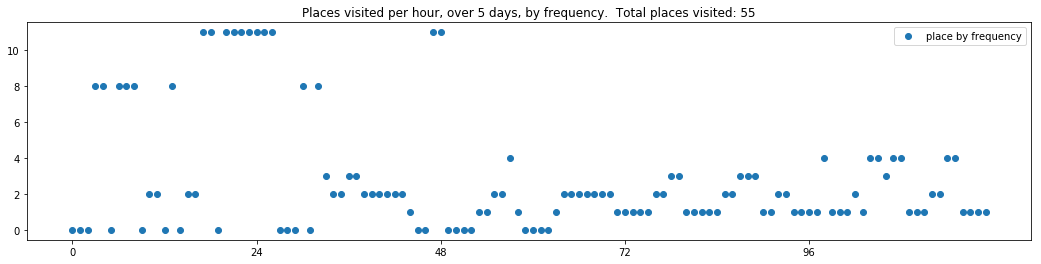

----- vector ----
prefix labels:  [409, 546]
[0, 0, 0, 0, 0, 17, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 409, 409, 409, 409, 409, 409, 409, 409]
[409, 409, 409, 409, 409, 396, 546, 546, 546, 546, 0, 0, 0, 546, 546, 87, 87, 409, 409, 409, 409, 409, 409, 463]
[409, 409, 409, 409, 409, 409, 546, 546, 546, 546, 546, 546, 546, 0, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409]
[409, 409, 409, 409, 409, 409, 546, 546, 546, 546, 546, 546, 546, 546, 546, 87, 409, 409, 409, 409, 409, 409, 409, 409]
[409, 409, 409, 409, 409, 409, 546, 546, 546, 546, 546, 546, 546, 546, 546, 409, 409, 409, 409, 409, 409, 409, 409, 409]


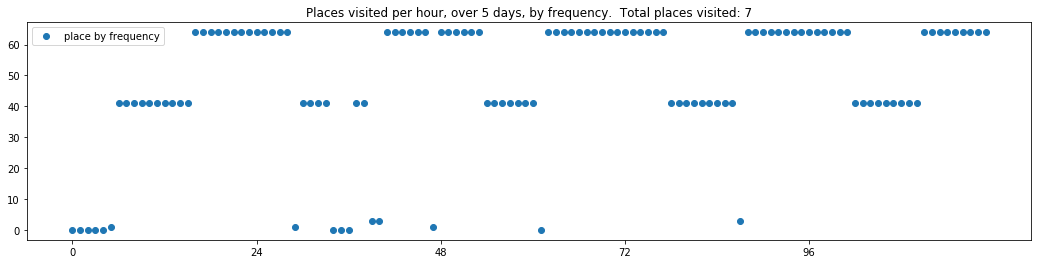

----- vector ----
prefix labels:  [104, 104]
[0, 0, 0, 0, 0, 0, 0, 429, 0, 0, 7, 473, 473, 473, 473, 473, 104, 104, 104, 104, 104, 104, 104, 104]
[104, 104, 104, 104, 104, 104, 104, 104, 104, 0, 0, 473, 473, 473, 473, 104, 104, 537, 87, 53, 323, 323, 104, 104]
[0, 104, 104, 0, 0, 409, 409, 0, 279, 0, 279, 579, 579, 350, 179, 104, 104, 104, 104, 536, 536, 104, 104, 104]
[104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 601, 601, 601, 601, 601, 601, 579, 579, 373, 104, 104, 104, 104]
[104, 104, 104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 368, 477, 104, 629, 629, 104, 104, 104, 104, 104]


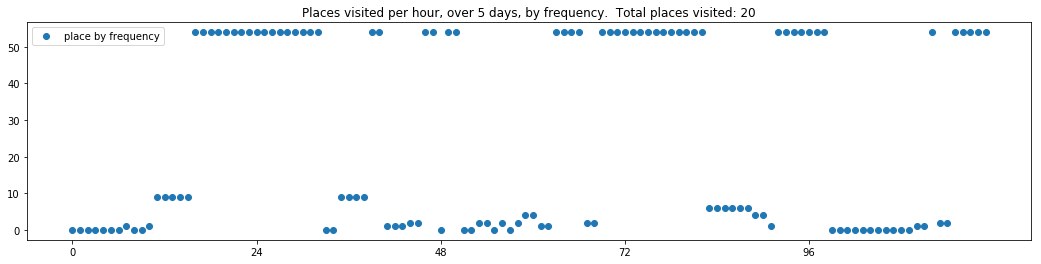


-------showing vectors for model: Z-bidirectional-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.8
----- vector ----
prefix labels:  [403, 56]
[0, 0, 0, 0, 0, 0, 0, 0, 56, 56, 56, 56, 56, 56, 56, 56, 56, 403, 403, 403, 403, 403, 403, 403]
[403, 403, 403, 403, 403, 403, 403, 0, 0, 56, 56, 56, 56, 56, 56, 56, 56, 84, 84, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 403, 403, 403, 403, 403, 403]
[403, 403, 403, 403, 403, 403, 403, 0, 0, 56, 56, 56, 56, 56, 56, 56, 56, 403, 403, 403, 403, 403, 403, 403]
[403, 403, 403, 403, 403, 403, 403, 0, 0, 56, 56, 56, 56, 56, 56, 0, 0, 0, 403, 403, 403, 403, 403, 403]


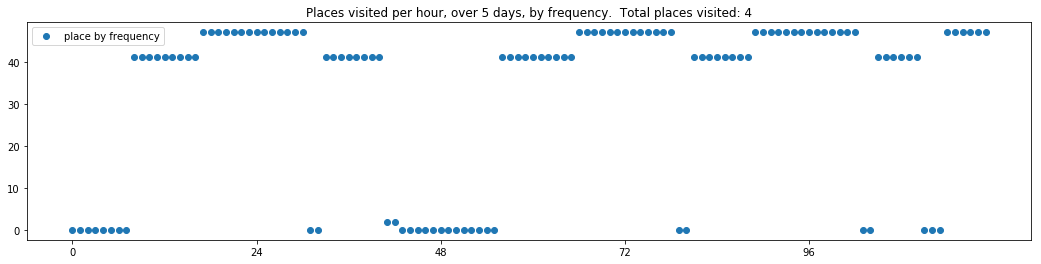

----- vector ----
prefix labels:  [379, 379]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 379, 379, 379, 379, 379, 379, 379]
[379, 379, 379, 379, 379, 379, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 379, 379, 379, 379, 379]
[379, 379, 379, 379, 379, 379, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 379, 379, 379, 379]


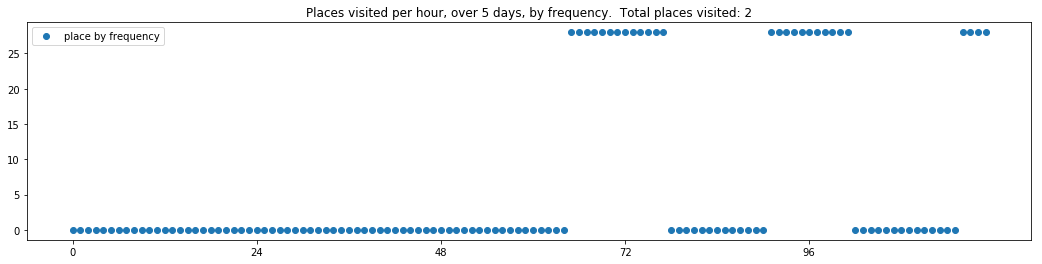

----- vector ----
prefix labels:  [192, 68]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 192, 192, 192]
[192, 192, 192, 192, 192, 192, 192, 192, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 0, 192, 192, 192]
[192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 192, 192, 192]
[192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192]
[192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 114, 192, 192, 192, 192]


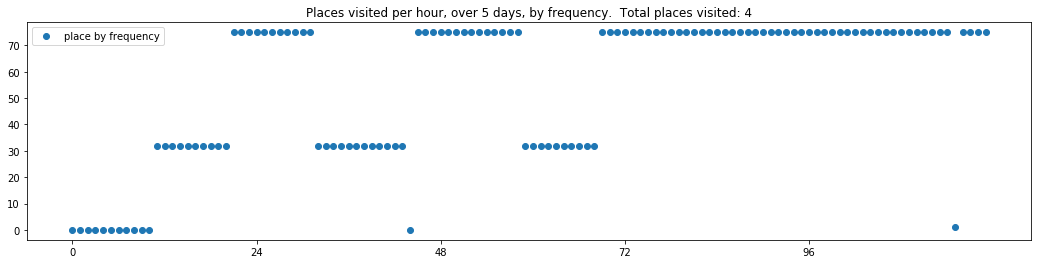


-------showing vectors for model: Z-bidirectional.1-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.9
----- vector ----
prefix labels:  [45, 45]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45]
[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 0, 286, 286, 108, 0, 0, 45, 45, 45]
[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 286, 286, 286, 286, 0, 0, 0, 45, 45]
[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 0, 0, 0, 0]
[0, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 0, 0, 45, 45]


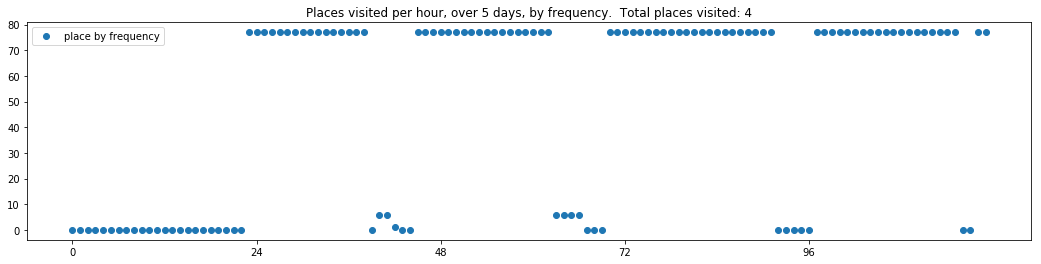

----- vector ----
prefix labels:  [508, 508]
[0, 0, 0, 0, 0, 0, 0, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 508, 508, 508, 508, 508, 508, 508, 508, 508, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 508, 508, 508, 508, 508, 508, 508, 508, 508, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 0, 0, 286, 286, 286, 286, 286]


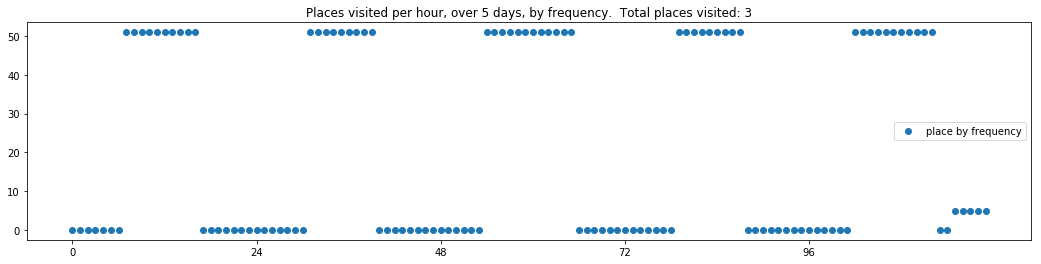

----- vector ----
prefix labels:  [8, 8]
[0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0]


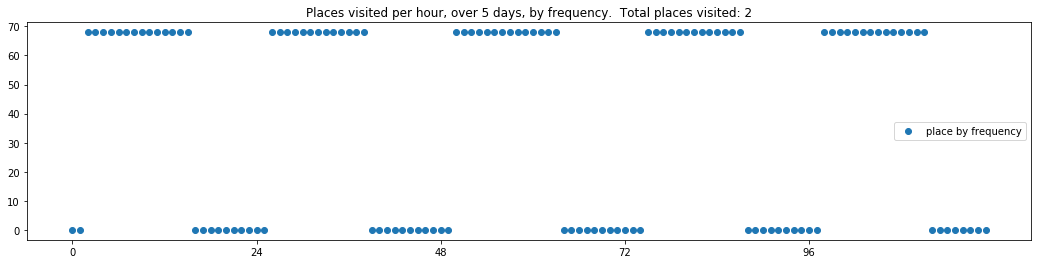


-------showing vectors for model: Z-bidirectional.2-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.0
----- vector ----
prefix labels:  [48, 144]
[0, 0, 0, 0, 0, 0, 0, 0, 177, 0, 0, 144, 144, 144, 144, 144, 144, 144, 0, 48, 48, 48, 48, 48]
[48, 48, 48, 48, 48, 48, 48, 48, 0, 144, 144, 144, 144, 144, 144, 144, 144, 144, 0, 108, 48, 48, 48, 48]
[48, 48, 48, 48, 48, 48, 48, 48, 0, 144, 144, 144, 144, 144, 144, 144, 144, 144, 237, 48, 48, 48, 48, 48]
[48, 48, 48, 48, 48, 48, 48, 48, 0, 144, 144, 144, 144, 144, 144, 144, 144, 0, 108, 48, 48, 48, 48, 48]
[48, 48, 48, 48, 48, 48, 48, 48, 48, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 108, 108, 48, 48, 48]


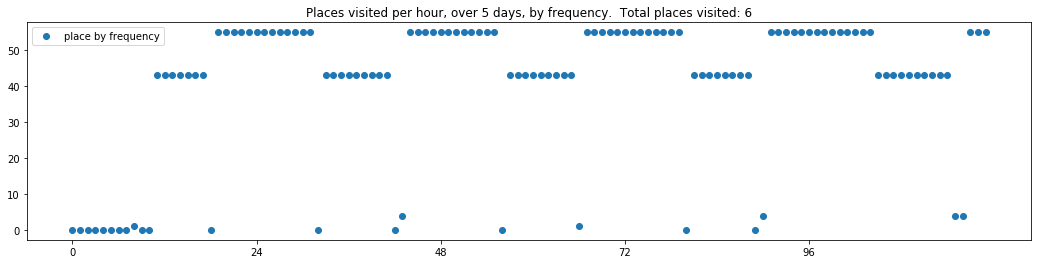

----- vector ----
prefix labels:  [165, 491]
[0, 0, 0, 0, 0, 0, 0, 0, 205, 205, 0, 0, 0, 0, 0, 0, 165, 165, 165, 165, 165, 165, 165, 165]
[165, 165, 165, 165, 165, 165, 165, 165, 165, 491, 491, 491, 491, 491, 491, 491, 194, 303, 165, 165, 165, 165, 165, 165]
[165, 165, 165, 165, 165, 165, 311, 311, 311, 0, 0, 0, 0, 0, 0, 0, 0, 165, 165, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 303, 611, 611, 611, 632, 632, 200, 200, 165, 165, 165, 165, 165, 165, 165, 165, 165]
[165, 165, 165, 165, 165, 165, 165, 304, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 165, 165, 165, 165]


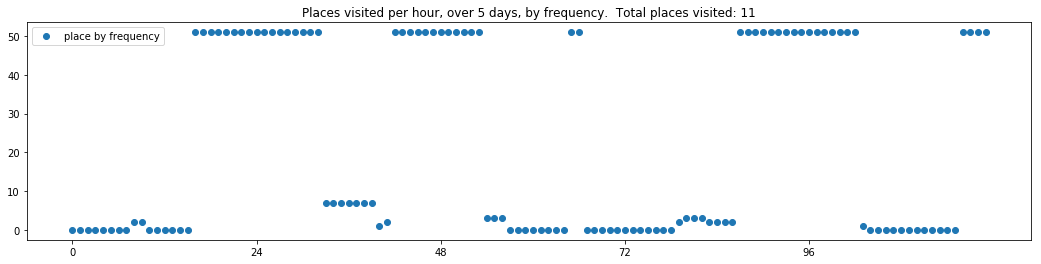

----- vector ----
prefix labels:  [178, 178]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178]
[178, 178, 178, 178, 178, 178, 178, 178, 498, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178]
[178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 106, 106, 178, 178, 178, 178, 97, 97, 178, 178, 178, 178, 178]
[178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 97, 97, 178, 178, 498, 178, 178, 97, 97, 178, 178, 178, 178]
[178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 105, 97, 97, 178, 178, 97, 97, 178, 178, 178, 97, 178, 178]


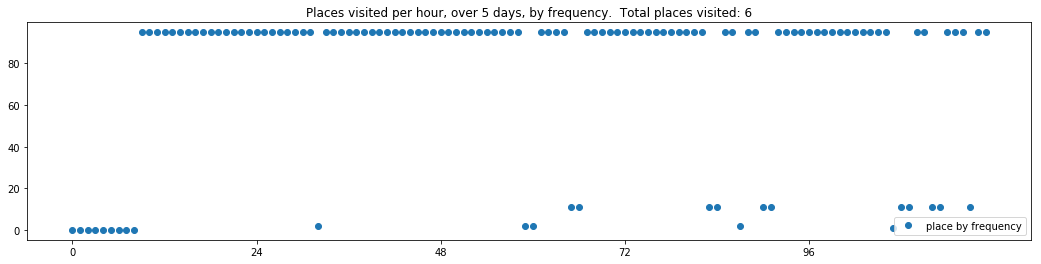


-------showing vectors for model: Z-bidirectional.3-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.1
----- vector ----
prefix labels:  [565, 565]
[0, 0, 0, 0, 0, 0, 285, 249, 249, 249, 249, 249, 249, 249, 249, 249, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 565, 565, 565, 565, 254, 254, 254, 275, 0, 0, 0, 0, 502, 565, 565, 565, 565]
[565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 0, 565, 26, 0, 565, 565, 0, 0, 0, 0, 0]
[565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 275, 254, 254, 0, 0, 0, 0, 0, 0, 565, 565, 565]
[565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 577, 0, 0, 0, 0, 0, 0, 0, 626, 565, 565, 565]


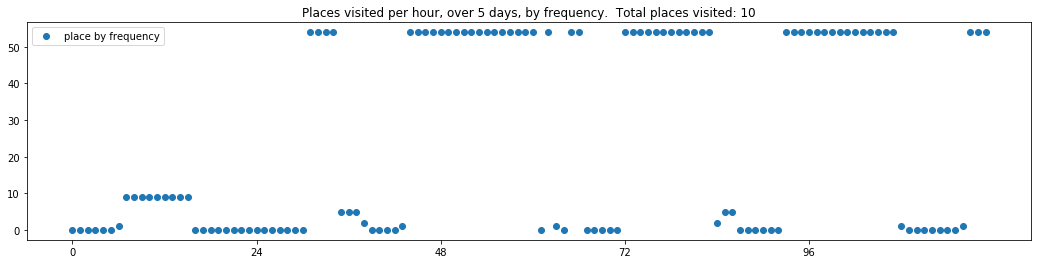

----- vector ----
prefix labels:  [380, 380]
[0, 0, 0, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 395, 380, 380, 380, 380, 404, 404, 380, 380, 380, 380]
[380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 0, 0, 380, 0, 0]
[380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 0, 0, 0, 0, 0, 0]
[0, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 395, 395, 395, 395, 395, 380, 380, 404, 404, 380, 380, 380, 380]
[380, 380, 380, 380, 380, 380, 380, 404, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 404, 404, 404, 404, 0, 0]


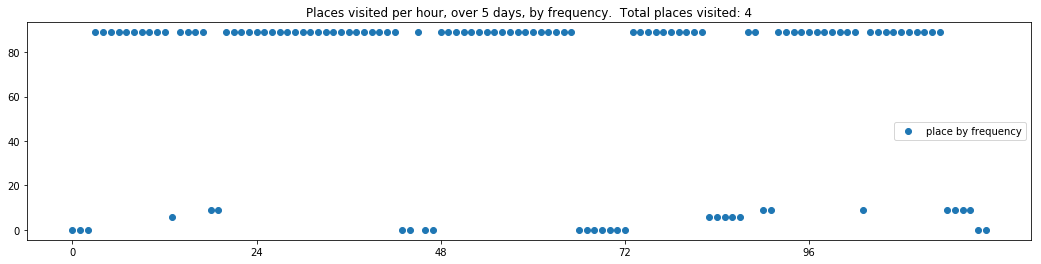

----- vector ----
prefix labels:  [209, 209]
[0, 0, 0, 0, 0, 0, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 597, 597, 597, 597, 597, 597, 597, 597]
[597, 597, 597, 597, 597, 597, 209, 209, 209, 209, 209, 209, 209, 209, 209, 122, 597, 597, 597, 597, 597, 597, 597, 597]
[597, 597, 597, 597, 597, 597, 209, 209, 209, 209, 209, 209, 209, 209, 209, 597, 597, 597, 597, 597, 597, 597, 597, 597]


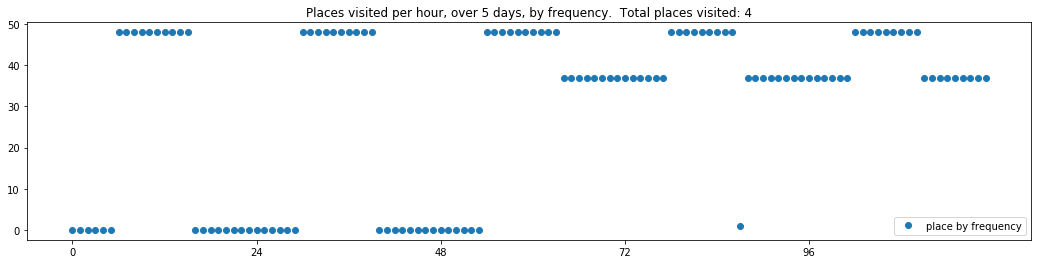


-------showing vectors for model: Z-bidirectional.4-------

trajectories from: generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.2
----- vector ----
prefix labels:  [191, 191]
[0, 0, 0, 0, 0, 0, 0, 0, 200, 0, 0, 0, 200, 0, 0, 0, 0, 223, 223, 191, 191, 191, 191, 191]
[191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 223, 223, 0, 191, 0, 0, 0, 0, 191, 191, 191, 191, 191, 191]
[191, 191, 191, 191, 191, 191, 191, 191, 257, 0, 0, 0, 0, 340, 0, 0, 0, 0, 80, 80, 80, 0, 54, 54]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 22, 0, 450, 336, 59, 59, 191, 191, 191, 191, 320, 276, 0, 191]
[191, 0, 0, 0, 0, 0, 0, 0, 191, 191, 430, 430, 0, 0, 76, 89, 205, 191, 531, 191, 191, 0, 0, 191]


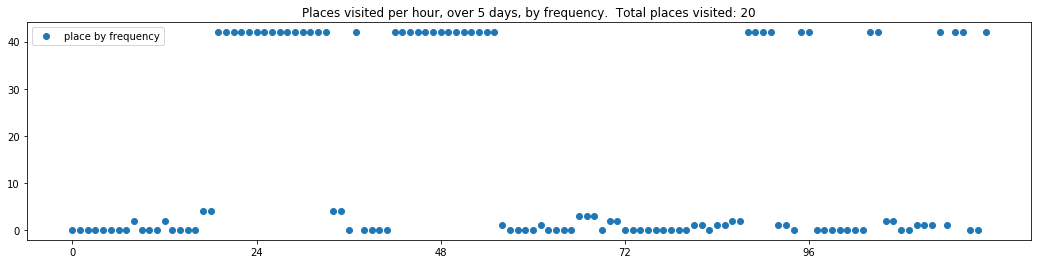

----- vector ----
prefix labels:  [223, 223]
[223, 223, 223, 0, 223, 223, 223, 223, 223, 0, 0, 0, 223, 223, 223, 223, 223, 0, 223, 223, 223, 223, 223, 223]
[223, 223, 223, 223, 223, 223, 223, 223, 223, 616, 616, 223, 223, 0, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223]
[223, 223, 223, 223, 223, 223, 223, 223, 223, 0, 0, 0, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223]
[0, 223, 223, 223, 223, 223, 223, 223, 223, 608, 608, 223, 223, 223, 223, 223, 0, 223, 223, 223, 223, 223, 223, 223]
[223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 223, 191, 0, 0, 223, 0, 223, 223, 223, 223, 223, 223, 223]


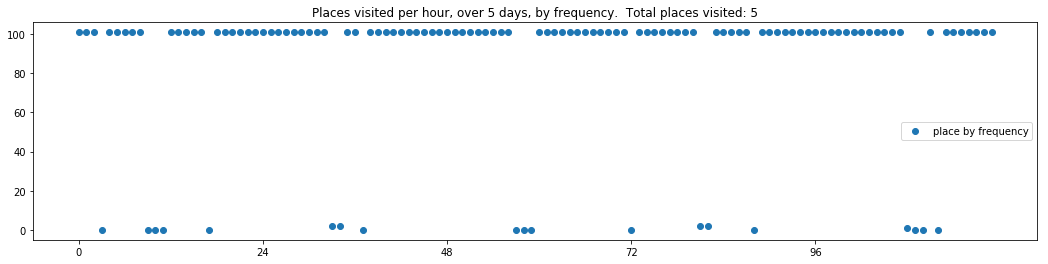

----- vector ----
prefix labels:  [596, 596]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 596, 596, 596, 596, 596, 596, 596]
[596, 596, 596, 596, 596, 596, 596, 596, 0, 0, 0, 0, 0, 0, 0, 0, 0, 596, 596, 596, 596, 596, 596, 596]
[596, 596, 596, 596, 596, 596, 596, 596, 0, 0, 0, 0, 0, 0, 0, 0, 0, 596, 596, 596, 596, 596, 596, 596]
[596, 596, 596, 596, 596, 596, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 596, 596, 230, 230, 596, 596, 596]
[596, 596, 596, 596, 596, 596, 596, 596, 0, 0, 0, 0, 0, 0, 0, 0, 0, 596, 596, 596, 596, 596, 596, 596]


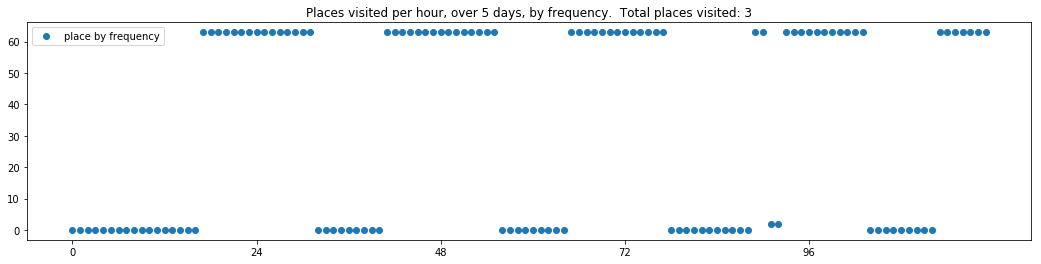


-------showing vectors for model: generated-sample-synthetic_trajectories-temperature:0.8-------

trajectories from: generated-sample-synthetic_trajectories-temperature:0.8
----- vector ----
prefix labels:  [72, 72]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]
[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]
[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]
[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]
[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]


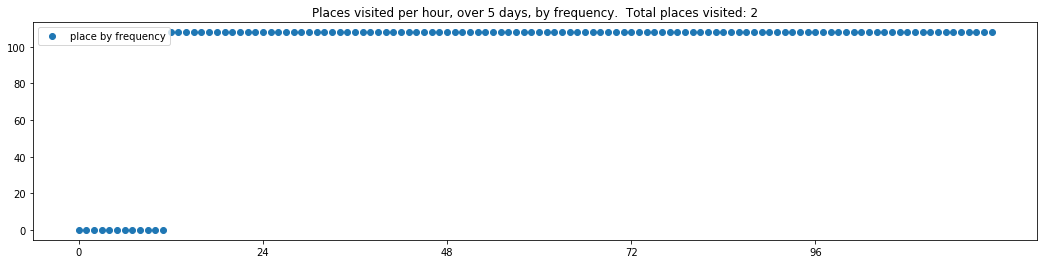

----- vector ----
prefix labels:  [548, 0]
[0, 0, 0, 0, 0, 0, 548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 548, 548, 0, 548, 548, 548]
[548, 548, 548, 548, 548, 548, 548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 548, 548, 0]
[0, 0, 0, 0, 0, 548, 548, 548, 548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 548, 548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


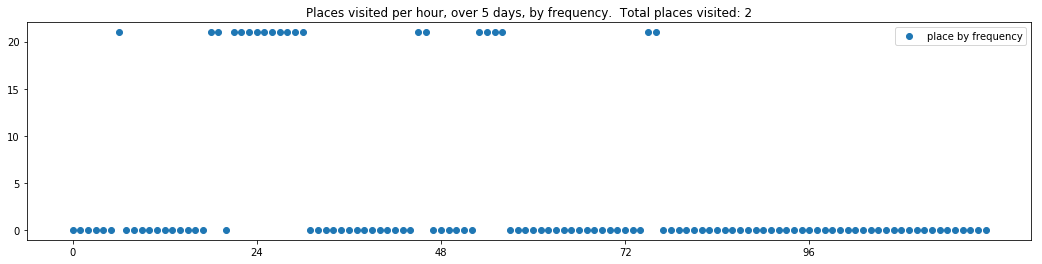

----- vector ----
prefix labels:  [569, 8]
[0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 569, 569, 569, 569, 569, 569, 569, 569, 569, 569]
[569, 569, 569, 569, 569, 569, 569, 569, 8, 8, 8, 8, 8, 8, 8, 8, 8, 569, 569, 569, 569, 569, 569, 569]
[569, 569, 569, 569, 569, 569, 569, 569, 8, 8, 8, 8, 8, 8, 8, 8, 8, 569, 569, 569, 569, 569, 569, 569]
[569, 569, 569, 569, 569, 569, 569, 569, 8, 8, 8, 8, 8, 8, 8, 8, 8, 569, 569, 569, 569, 569, 569, 569]
[569, 569, 569, 569, 569, 569, 569, 569, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 569, 569, 569, 569, 569, 569]


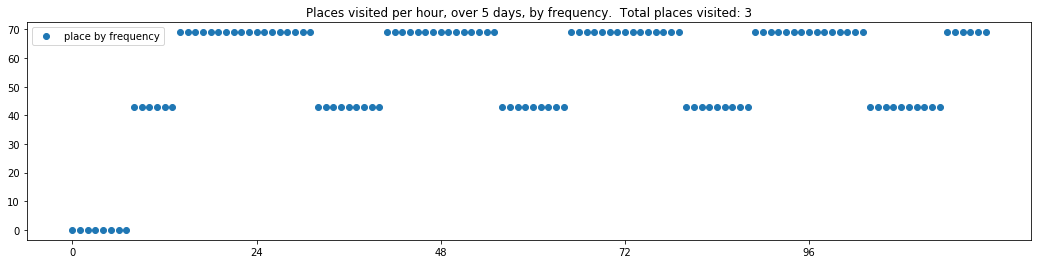


-------showing vectors for model: generated-sample-synthetic_trajectories-temperature:0.9-------

trajectories from: generated-sample-synthetic_trajectories-temperature:0.9
----- vector ----
prefix labels:  [20, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 502]
[502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502]
[502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502]


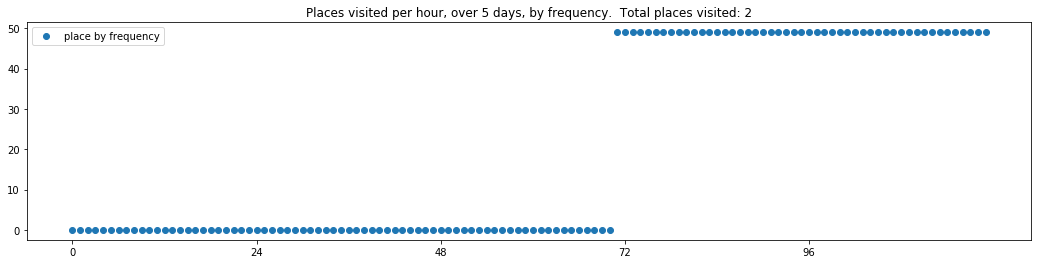

----- vector ----
prefix labels:  [28, 28]
[0, 0, 0, 0, 0, 0, 0, 62, 62, 490, 62, 28, 28, 28, 28, 192, 28, 28, 28, 28, 28, 28, 28, 28]
[28, 28, 28, 28, 28, 28, 28, 62, 28, 28, 112, 28, 28, 28, 0, 0, 0, 62, 394, 28, 468, 468, 28, 28]
[28, 28, 28, 28, 28, 28, 28, 62, 28, 0, 0, 476, 0, 0, 0, 0, 28, 28, 28, 28, 28, 28, 28, 28]
[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 228, 0, 0, 238, 238, 238, 238, 238, 28, 28]
[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 228, 228, 228, 28, 28, 0, 0, 0, 0, 0, 0, 0]


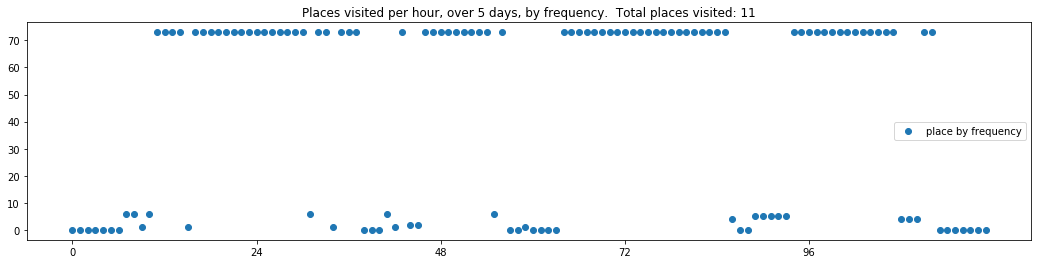

----- vector ----
prefix labels:  [370, 163]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370]
[370, 370, 370, 370, 370, 370, 370, 370, 370, 163, 163, 163, 163, 163, 163, 163, 163, 593, 382, 382, 370, 370, 370, 370]
[370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370]
[370, 370, 370, 370, 370, 370, 370, 370, 370, 163, 163, 163, 163, 208, 0, 163, 163, 593, 51, 555, 8, 452, 370, 370]
[370, 370, 370, 370, 370, 370, 370, 370, 370, 593, 593, 593, 593, 593, 226, 476, 476, 228, 473, 68, 68, 68, 370, 370]


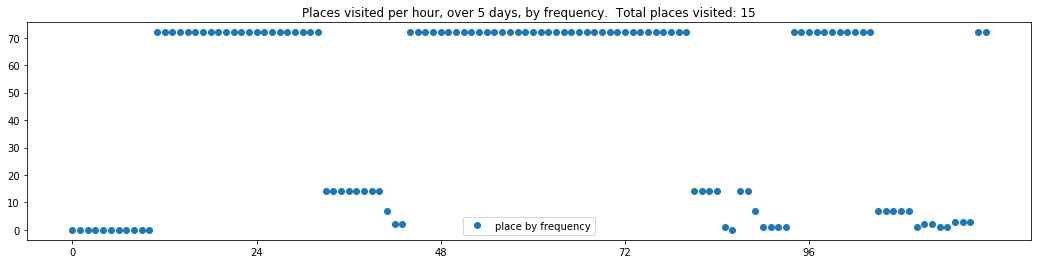


-------showing vectors for model: generated-sample-synthetic_trajectories-temperature:1.0-------

trajectories from: generated-sample-synthetic_trajectories-temperature:1.0
----- vector ----
prefix labels:  [147, 147]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 147, 147, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 0, 0, 147, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 147, 147, 147, 147, 147, 147, 147, 147, 147, 0, 0, 0, 147, 147, 147, 0, 0, 0]
[0, 429, 429, 0, 0, 0, 0, 0, 0, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 287, 0, 2, 0]


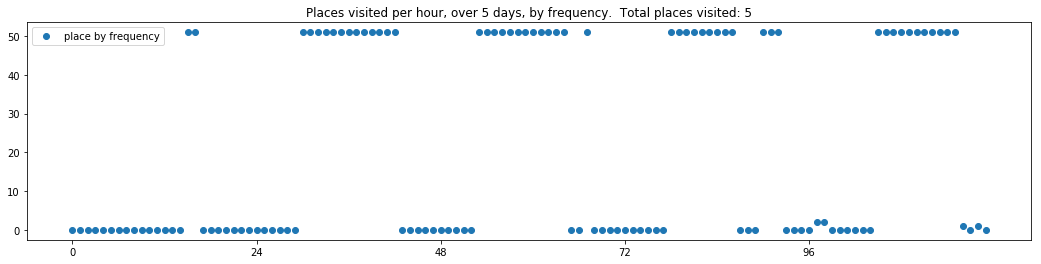

----- vector ----
prefix labels:  [21, 21]
[0, 0, 0, 0, 0, 0, 0, 21, 21, 0, 21, 21, 0, 0, 0, 0, 0, 0, 31, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21, 0, 0, 21, 21, 21, 0, 0, 0, 0, 0, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 0, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 469, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 21, 21, 21, 21, 21, 0, 0, 0, 0, 0]


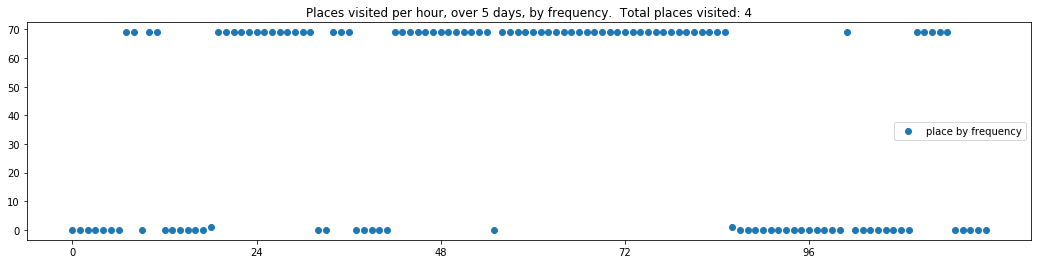

----- vector ----
prefix labels:  [190, 223]
[0, 0, 0, 0, 0, 0, 0, 0, 223, 223, 223, 223, 223, 223, 223, 223, 223, 190, 190, 190, 190, 190, 190, 190]
[190, 190, 190, 190, 190, 190, 190, 190, 223, 223, 223, 223, 223, 223, 223, 223, 223, 190, 190, 190, 190, 190, 190, 190]
[190, 190, 190, 190, 190, 190, 190, 190, 223, 223, 223, 223, 223, 223, 223, 223, 223, 190, 190, 190, 190, 190, 190, 190]
[190, 190, 190, 190, 190, 190, 190, 190, 223, 223, 223, 223, 223, 223, 223, 223, 0, 608, 190, 190, 190, 190, 190, 190]
[190, 190, 190, 190, 190, 190, 190, 190, 190, 223, 223, 223, 223, 223, 223, 223, 190, 190, 190, 190, 190, 190, 190, 190]


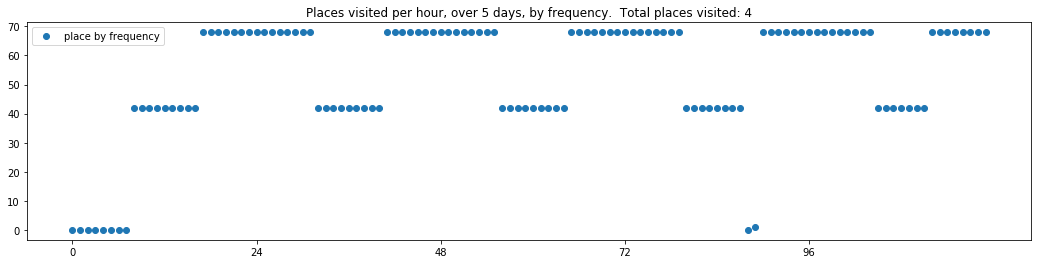

In [13]:
import random 

sample_size = 3

for column_name in models_matrix_df.columns:
    print('\n-------showing vectors for model: %s-------' % column_name)
    generated_trajectories_name = models_matrix_df.loc[generated_trajectories_name_idx][column_name]
    print('\ntrajectories from: %s' % generated_trajectories_name)
    generated_trajectories = generated_sample_trajectories_map[generated_trajectories_name]
    for tv in random.sample(generated_trajectories, sample_size):
        print_dwell_vector_by_days(tv)
        plot_trajectory_vector_frequencies(tv, by_frequency_order=False)

In [14]:
# Helper function to create dummy row that is then filled in
def add_dummy_row(df, index_name):
    dummy_row_dict = {c:np.NaN for c in df.columns}
    return df.append(pd.Series(dummy_row_dict, name=index_name))

### Check condition labels match output

The generated stay vectors are prefixed by home and work labels that act as conditions for generation.  For evaluation, we then check that we are able to infer the same home census area (using the same f_home, f_work function used in preprocessing) as the home prefix label we condition on. That is, if we condition on generating a synthetic stay vector for a person living in census area A, then by applying our f_home function on that generated vector, we should expect area A to be returned.

Measure:
- `home labels match portion`:  portion of vectors in generated set where the home label matches the vector data
- `work labels match portion`:  portion of vectors in generated set where the work label matches the vector data

In [15]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from trajectory_transformers import get_trajectory_home_label, get_trajectory_work_label

# Set up the evaluation row data that will be filled in
home_labels_match_portion = 'home labels match portion'
work_labels_match_portion = 'work labels match portion'
models_matrix_df = add_dummy_row(models_matrix_df, home_labels_match_portion)
models_matrix_df = add_dummy_row(models_matrix_df, work_labels_match_portion)

#### Check that home & work labels match generated vector data


- Note portion of users in that have sufficient data across 2 weeks: 14076/22673 = 0.6208265337626252

- Note how often inferred home labels change between weeks for users in real dataset:
    - portion (users with matching homes)/(total users) = (12860)/(14076) = 0.9136118215402103
- Note how often inferred work labels change between weeks for users in real dataset:
    - portion (users with matching work)/(total users) = (10676)/(14076) = 0.7584541062801933

In [16]:
def get_vectors_with_matching_home_prefix(prefixed_vectors):
    vectors_with_matching_home_prefix = []
    for prefixed_v in prefixed_vectors:
        prefix, v = break_prefix(prefixed_v, days=TIME_PERIOD_DAYS, hours=HOURS_PER_DAY)
        home_label_prefix = prefix[0]
        inferred_home_label = get_trajectory_home_label(v)
        if inferred_home_label == home_label_prefix:
            vectors_with_matching_home_prefix.append(prefixed_v)
    return vectors_with_matching_home_prefix  

def get_vectors_with_matching_work_prefix(prefixed_vectors):
    vectors_with_matching_work_prefix = []
    for prefixed_v in prefixed_vectors:
        prefix, v = break_prefix(prefixed_v, days=TIME_PERIOD_DAYS, hours=HOURS_PER_DAY)
        work_label_prefix = prefix[1]
        inferred_work_label = get_trajectory_work_label(v)
        if inferred_work_label == work_label_prefix:
            vectors_with_matching_work_prefix.append(prefixed_v)
    return vectors_with_matching_work_prefix

    
real_vectors_with_matching_home_prefix = get_vectors_with_matching_home_prefix(real_trajectories)
assert(len(real_vectors_with_matching_home_prefix) == len(real_trajectories)) 
real_vectors_with_matching_work_prefix = get_vectors_with_matching_work_prefix(real_trajectories)
assert(len(real_vectors_with_matching_work_prefix) == len(real_trajectories))  
    
for column_name in models_matrix_df.columns:
    generated_trajectories_name = models_matrix_df.loc[generated_trajectories_name_idx, column_name]
    generated_trajectories = generated_sample_trajectories_map[generated_trajectories_name]
    vectors_with_matching_home_prefix = get_vectors_with_matching_home_prefix(generated_trajectories)
    vectors_with_matching_work_prefix = get_vectors_with_matching_work_prefix(generated_trajectories)
    home_match_portion = len(vectors_with_matching_home_prefix)/len(generated_trajectories)
    work_match_portion = len(vectors_with_matching_work_prefix)/len(generated_trajectories)
    models_matrix_df.loc[home_labels_match_portion][column_name] = home_match_portion
    models_matrix_df.loc[work_labels_match_portion][column_name] = work_match_portion


sort the columns by 'home labels match portion'

In [17]:
models_matrix_df.sort_values(home_labels_match_portion, axis=1, inplace=True, ascending=False)

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(models_matrix_df)

Z-bidirectional  \
rnn_bidirectional                                                         True   
max_length                                                                  72   
rnn_layers                                                                   2   
rnn_size                                                                   256   
dropout                                                                    0.3   
dim_embeddings                                                             100   
temperature                                                                0.8   
batch size                                                                1024   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                0.956   
work labels match portion                                               0.8595   

                                                             Z-bidirectional.1  \
rnn_bidirectional                                                         True   
max_length                                                                  72   
rnn_layers                                                                   2   
rnn_size                                                                   256   
dropout                                                                    0.3   
dim_embeddings                                                             100   
temperature                                                                0.9   
batch size                                                                1024   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                               0.9525   
work labels match portion                                               0.8415   

                                                             Z-bidirectional.2  \
rnn_bidirectional                                                         True   
max_length                                                                  72   
rnn_layers                                                                   2   
rnn_size                                                                   256   
dropout                                                                    0.3   
dim_embeddings                                                             100   
temperature                                                                  1   
batch size                                                                1024   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                               0.9435   
work labels match portion                                                0.818   

                                                             Z-bidirectional.3  \
rnn_bidirectional                                                         True   
max_length                                                                  72   
rnn_layers                                                                   2   
rnn_size                                                                   256   
dropout                                                                    0.3   
dim_embeddings                                                             100   
temperature                                                                1.1   
batch size                                                                1024   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                0.932   
work labels match portion                                                 0.79   

                                                             Z-bidirectional.4  \
rnn_bidirectional                        

Now limit evaluation to models parameters that produced home label match rates above threshold:
0.85

In [19]:
home_labels_match_portion_threshold = 0.8
best_models_matrix_df = models_matrix_df.loc[:, models_matrix_df.loc[home_labels_match_portion] > home_labels_match_portion_threshold]
print('number of models/parameters before vs after limiting to threshold of %s: %s vs %s' %\
      (home_labels_match_portion_threshold, len(models_matrix_df.columns), len(best_models_matrix_df.columns)))

models_matrix_df = best_models_matrix_df
best_models_matrix_df

number of models/parameters before vs after limiting to threshold of 0.8: 70 vs 29


Z-bidirectional  \
rnn_bidirectional                                                         True   
max_length                                                                  72   
rnn_layers                                                                   2   
rnn_size                                                                   256   
dropout                                                                    0.3   
dim_embeddings                                                             100   
temperature                                                                0.8   
batch size                                                                1024   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                0.956   
work labels match portion                                               0.8595   

                                                             Z-bidirectional.1  \
rnn_bidirectional                                                         True   
max_length                                                                  72   
rnn_layers                                                                   2   
rnn_size                                                                   256   
dropout                                                                    0.3   
dim_embeddings                                                             100   
temperature                                                                0.9   
batch size                                                                1024   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                               0.9525   
work labels match portion                                               0.8415   

                                                             Z-bidirectional.2  \
rnn_bidirectional                                                         True   
max_length                                                                  72   
rnn_layers                                                                   2   
rnn_size                                                                   256   
dropout                                                                    0.3   
dim_embeddings                                                             100   
temperature                                                                  1   
batch size                                                                1024   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                               0.9435   
work labels match portion                                                0.818   

                                                             Z-bidirectional.3  \
rnn_bidirectional                                                         True   
max_length                                                                  72   
rnn_layers                                                                   2   
rnn_size                                                                   256   
dropout                                                                    0.3   
dim_embeddings                                                             100   
temperature                                                                1.1   
batch size                                                                1024   
generated_trajectories_name  generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                0.932   
work labels match portion                                                 0.79   

                                                             Z-bidirectional.4  \
rnn_bidirectional                        

### check that fake users do not travel impossibly far

We check that between two consecutive time intervals, synthetic users don’t travel impossibly far; that is, they don’t suddenly go from one census area to another that is too far away to have been traveled within that time interval.  We do this by looking at the geographic locations of the centroids or the boundaries of census areas.  We consider two consecutive stay locations in a stay vector sequence as a bigram, and must verify that each bigram is sensible.

To do this, we use a shortcut that exploits how well our RNN models fit the training data: We assume that any bigram that occurs in a real trajectory is sensible.  Clearly if all the bigrams in the generated data have been seen in the real data, then all of the bigrams are sensible.
We also note that if the distance from area A to area B is sensible, then so must be the distance from area B to area A.  So if bigram (A, B) is sensible, then so must be its reverse (B, A).

We collect the set of all of the bigrams "seen" in the real trajectories.  We then also collect all of the "unseen" bigrams from the generated trajectories, where these "unseen" bigrams (A, B) and their reverses (B, A) are not in the "seen" set.


For each of these "unseen" bigrams we count them and then determine if they are realistic.

What should be consideered "realistic"?

The areas represent  where a user reported most ‘dwell time’ in a given interval of an hour.  If we assume the trip started in the reported area at the beginning of hour 1, and ended in area 2 near the end of hour 2, then we can consider the travel time ~2 hours.  A person traveling in a car at 50mph could then travel ~100 miles.

We then check that each "unseen" bigram represents a distance well below 100 miles.


We do this in __"reality check for distances traveled"__ below. But first:


#### Preliminary Check: Count the Unseen Bigrams

We collect the set of bigrams in the real sequences, and the set of bigrams in the synthetic sequences, and check whether only bigrams from the real sequences (and their reverses) occur in the synthetic sequences.  If so, all the bigrams in our generated data must be sensible.

Measure:
- `distinct unseen bigrams`: number of distinct bigrams found in generated trajectories but not real trajectores
- `total unseen bigrams`: total number of bigrams in generated trajectories but not real trajectories
- `portion unseen bigrams`: (# total unseen bigrams)/(# total generated bigrams)
- `portion unseen bigrams allowing skips`: (# total unseen bigrams allowing skips)/(# total generated bigrams)


`portion unseen bigrams allowing skips`:

There are unseen bigrams. So also check something else:

Synthetic users do not travel anywhere within 1 hour that real users did not travel within 2 hours.

i.e. Get the bigrams that include skips over 1 hour at a time from the real user trajectories. A sequence of "A B C D" will then produce bigrams (A, B), (A, C), (B, C), (B, D), (C, D).

Compare this to the set of bigrams from the synthetic data that do not include skips. Check if this set of bigrams from real data with 1 hour skips contains the set of bigrams from synthetic data without skips.


Add row to show measures for each model

In [20]:
distinct_unseen_bigrams = 'distinct unseen bigrams'
total_unseen_bigrams = 'total unseen bigrams'
portion_unseen_bigrams = 'portion unseen bigrams'
portion_unseen_bigrams_w_skips = 'portion unseen bigrams allowing skips'

models_matrix_df = add_dummy_row(models_matrix_df, distinct_unseen_bigrams)
models_matrix_df = add_dummy_row(models_matrix_df, total_unseen_bigrams)
models_matrix_df = add_dummy_row(models_matrix_df, portion_unseen_bigrams)
models_matrix_df = add_dummy_row(models_matrix_df, portion_unseen_bigrams_w_skips)

In [21]:
from evaluators import get_unseen_bigrams, get_bigrams_for_trajectory_vectors


# get bigrams for the real trajectories to compare the generated trajectories to
real_bigram_set = get_bigrams_for_trajectory_vectors(real_trajectories, with_skip=False)
real_bigram_set_with_skip = get_bigrams_for_trajectory_vectors(real_trajectories, with_skip=True)

for column_name in models_matrix_df.columns:
    generated_trajectories_name = models_matrix_df.loc[generated_trajectories_name_idx][column_name]
    generated_trajectories = generated_sample_trajectories_map[generated_trajectories_name]
    # get bigrams for generated trajectories (for counting)
    generated_bigram_set = get_bigrams_for_trajectory_vectors(generated_trajectories)
    # find the bigrams in the generated trajectories that do not occur in the real trajectories
    # get mapping of {unseen bigrams --> count}
    #    where count is number of times the unseen bigram occurs in the generated trajectories
    unseen_bigram_to_count = get_unseen_bigrams(real_bigram_set, generated_trajectories)
    # count the distinct unseen bigrams
    distinct_unseen_bigrams_count = len(unseen_bigram_to_count)
    # count the total number of times an unseeen bigram occurs
    total_unseen_bigrams_count = sum(unseen_bigram_to_count.values())
    # compute the portion of total unseen bigrams over all generated bigrams
    total_generated_bigrams_count = (len(generated_trajectories)*len(generated_trajectories[0]))
    portion_unseen_total_bigrams = total_unseen_bigrams_count / total_generated_bigrams_count
    
    # compute portion of total unseen bigrams over all generated bigrams when skips are allowed
    unseen_bigram_to_count_with_skip = get_unseen_bigrams(real_bigram_set_with_skip, generated_trajectories)
    total_unseen_bigrams_count_with_skip = sum(unseen_bigram_to_count_with_skip.values())
    portion_unseen_total_bigrams_w_skip = total_unseen_bigrams_count_with_skip / total_generated_bigrams_count
    
    # Add values to matrix
    models_matrix_df.loc[distinct_unseen_bigrams][column_name] = distinct_unseen_bigrams_count
    models_matrix_df.loc[total_unseen_bigrams][column_name] = total_unseen_bigrams_count
    models_matrix_df.loc[portion_unseen_bigrams][column_name] = portion_unseen_total_bigrams
    models_matrix_df.loc[portion_unseen_bigrams_w_skips][column_name] = portion_unseen_total_bigrams_w_skip


In [22]:
models_matrix_df

Z-bidirectional  \
rnn_bidirectional                                                                   True   
max_length                                                                            72   
rnn_layers                                                                             2   
rnn_size                                                                             256   
dropout                                                                              0.3   
dim_embeddings                                                                       100   
temperature                                                                          0.8   
batch size                                                                          1024   
generated_trajectories_name            generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                          0.956   
work labels match portion                                                         0.8595   
distinct unseen bigrams                                                              195   
total unseen bigrams                                                                 253   
portion unseen bigrams                                                        0.00103689   
portion unseen bigrams allowing skips                                        0.000877049   

                                                                       Z-bidirectional.1  \
rnn_bidirectional                                                                   True   
max_length                                                                            72   
rnn_layers                                                                             2   
rnn_size                                                                             256   
dropout                                                                              0.3   
dim_embeddings                                                                       100   
temperature                                                                          0.9   
batch size                                                                          1024   
generated_trajectories_name            generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                         0.9525   
work labels match portion                                                         0.8415   
distinct unseen bigrams                                                              502   
total unseen bigrams                                                                 637   
portion unseen bigrams                                                        0.00261066   
portion unseen bigrams allowing skips                                         0.00213934   

                                                                       Z-bidirectional.2  \
rnn_bidirectional                                                                   True   
max_length                                                                            72   
rnn_layers                                                                             2   
rnn_size                                                                             256   
dropout                                                                              0.3   
dim_embeddings                                                                       100   
temperature                                                                            1   
batch size                                                                          1024   
generated_trajectories_name            generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                         0.9435   
work labels match portion                                                          0.818   
distinct unseen bigrams

We note that the number of unseen bigrams increases with temperature, as expected

#### Reality check for distances traveled

For each set of the generated trajectories (best chosen, after ordered by home label match rate) we:

- Collect the mapping of {unseen bigram -> count} for each generated trajectory set
- Collect the set of all of the unseen bigrams that occur in any of these mapping files and map each bigram to their corresponding census area GEOIDs.
    - e.g. the mapping may look like {'1 202': '25021410300 25021422501'}
    - the values represent a trip between two real census areas, 25021410300 and 25021422501
- We verify that pair for census area GEOIDs that represent a trip are within the reasonable distance of < 100 miles.
    - To do this we first write the pairs of census tract GEOIDs to file
    

In [23]:
import csv
import json

def get_total_unseen_bigrams(mm_df, real_trajectories):
    """
    Collects the total set of bigrams in the generated trajectories
    that did not occur in the real trajectories.
    
    mm_df: the models matrix DF with the generated trajectories names
    limit: number of generated trajectories to limit this search to.
        (assumes mm_df sorted as desired).
        
    Returns set of 'unseen' bigrams
    """
    real_bigram_set = get_bigrams_for_trajectory_vectors(real_trajectories, with_skip=False)
    total_unseen_bigrams = dict()

    for column_name in mm_df.columns:
        generated_trajectories_name = models_matrix_df.loc[generated_trajectories_name_idx][column_name]
        generated_trajectories = generated_sample_trajectories_map[generated_trajectories_name]
    # print('column: %s\ngenerated trajectories name: %s' % (column_name, generated_trajectories_name))
        generated_bigram_set = get_bigrams_for_trajectory_vectors(generated_trajectories)
        unseen_bigram_to_count = get_unseen_bigrams(real_bigram_set, generated_trajectories)
        total_unseen_bigrams.update(unseen_bigram_to_count)
    # print('number of unseen bigrams:', len(unseen_bigram_to_count))
    # print('total number of unseen bigrams:', len(total_unseen_bigrams))
    return total_unseen_bigrams


label_to_int_map_filename = '../data/relabeled_trajectories_1_workweek_label_to_int_map.json'

# def get_census_area_label_to_int_map():
#     label_to_int_map = None
#     with open(label_to_int_map_filename) as json_file:
#         label_to_int_map = json.load(json_file)

#     label_to_int_map[None] = label_to_int_map['null']
#     del label_to_int_map['null']
#     return label_to_int_map


def get_int_to_census_area_label_map():
    label_to_int_map = None
    with open(label_to_int_map_filename) as json_file:
        label_to_int_map = json.load(json_file)

    label_to_int_map[None] = label_to_int_map['null']
    del label_to_int_map['null']

    int_to_label_map = {i:label for label, i in label_to_int_map.items()}
    assert(len(int_to_label_map) == len(label_to_int_map))
    return int_to_label_map


def relabel_bigrams_int_to_census_areas_labels(bigrams):
    """
    Relabels the bigrams with the real census areas.
    bigrams: a set of tuples. e.g. {(1,2), (1,4)}
    
    Returns set of tuples where the items of the tuples are the real census
    areas that correspond to the input bigram relabeled numbers.
    e.g. {(2501755555, 2501766666), (2501755555, 2501788888)}
    """
    int_to_label_map = get_int_to_census_area_label_map()
    relabeled_bigrams_set = {(int_to_label_map[bg1], int_to_label_map[bg2]) for (bg1, bg2) in bigrams}
    assert(len(relabeled_bigrams_set) == len(bigrams))
    return relabeled_bigrams_set
    

unseen_bigrams_filename = './check_bigrams/rnn-generated-unseen-bigrams.csv'
def write_unseen_bigrams_to_file(unseen_bigrams):
    """
    Writes the bigrams to CSV file, with one bigram on each line
    """
    filename = unseen_bigrams_filename
    print('writing {} unseen bigrams to file: {}...'.format(len(unseen_bigrams), filename))
    with open(filename, 'w') as out:
        csv_out=csv.writer(out)
        # no header written
        for row in unseen_bigrams:
            csv_out.writerow(row)
    print('...wrote {} unseen bigrams to file: {}'.format(len(unseen_bigrams), filename))


The follow finds and writes the "unseen" bigrams to file. If already done, can skip this and jump to reading from file. 

In [24]:
# collect the list of unseen bigrams for all models
total_unseen_bigrams = get_total_unseen_bigrams(models_matrix_df, real_trajectories)
# relabel these bigrams with the real census areas and write to file
relabeled_unseen_bigrams = relabel_bigrams_int_to_census_areas_labels(set(total_unseen_bigrams.keys()))
# write to file
write_unseen_bigrams_to_file(relabeled_unseen_bigrams)

writing 34825 unseen bigrams to file: ./check_bigrams/rnn-generated-unseen-bigrams.csv...
...wrote 34825 unseen bigrams to file: ./check_bigrams/rnn-generated-unseen-bigrams.csv


Evaluate the distances between real census areas that were not in the original real data

In [25]:
unseen_bigrams_census_areas = pd.read_csv(unseen_bigrams_filename, header=None, names=['from', 'to'])
unseen_bigrams_census_areas.head(2)

from           to
0  25017341300  25025090200
1  25017321400  25025070500

In [26]:
# create mapping from geoid to geometry
# the units in the map projection used are meters.  These are then mapped to miles.
tracts=json.load(open('./check_bigrams/ma_tracts.geojson'))

# create mapping from geoid to geometry
geoid_to_geometry={}
for f_ind,feature in enumerate(tracts['features']):
    geoid=feature['properties']['GEO_ID'].split('US')[1]
    geoid_to_geometry[geoid]=feature['geometry']

# print(geoid_to_geometry[str(25017351403)])

The distance between census area is calculated in two ways:
1. The minimum distance
2. The distance between centroids

Since the distance between centroids is always < 60 miles we only pay attention to this metric.

In [27]:
from shapely.geometry import shape

METERS_TO_MILES_MULT = 0.000621371
unseen_bigrams_census_areas['min_dist_miles'] = unseen_bigrams_census_areas.apply(lambda row: \
                                                    shape(geoid_to_geometry[str(int(row['from']))]).distance(
                                                    shape(geoid_to_geometry[str(int(row['to']))]))*METERS_TO_MILES_MULT,
                                                    axis=1)
unseen_bigrams_census_areas['centroid_dist_miles'] = unseen_bigrams_census_areas.apply(lambda row: \
                                                    shape(geoid_to_geometry[str(int(row['from']))]).centroid.distance(
                                                    shape(geoid_to_geometry[str(int(row['to']))]).centroid)*METERS_TO_MILES_MULT,
                                                    axis=1)
unseen_bigrams_census_areas.sort_values('centroid_dist_miles', ascending=False, inplace=True)
unseen_bigrams_census_areas.head(3)

from           to  min_dist_miles  centroid_dist_miles
8455   25017301101  25021422100       47.488856            52.442555
33676  25021422600  25017301101       45.720942            50.393233
32265  25021419800  25017301101       43.619512            48.358651

In [28]:
max_distance = max(unseen_bigrams_census_areas['centroid_dist_miles'])
print('maximum distance traveled between census areas:')
max_distance

maximum distance traveled between census areas:


52.44255536950138

We have now verified that each of the distances traveled are sensible.  They are each well below 100 miles.
But what is the distribution of the distances between these "unseen" bigrams?  We plot it.

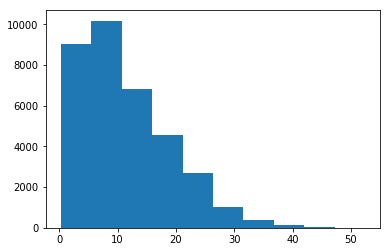

In [29]:
ax = plt.hist(unseen_bigrams_census_areas['centroid_dist_miles'])

### Check that distribution of where people spend their time is consistent

We evaluate that in aggregate, the distribution of where users spend their time is consistent.
We look at the correlation between real and synthetic data, in terms of aggregate time spent in each area.

Note: Where people spend time is biased to where they work and live.
So when doing this comparison, we compare generated synthetic trajectories to the random sample of 2000 real trajectories whose home,work label pairs were used to generate the synthetic data.

In [30]:
real_trajectories_sample_2000_filename = '../data/relabeled_trajectories_1_workweek_sample_2000.txt'
real_trajectories_sample = read_trajectories_from_file(real_trajectories_sample_2000_filename)

In [31]:
def get_unprefixed_vectors(prefixed_vectors):
    unprefixed_vectors = []
    for pv in prefixed_vectors:
        _p, v = break_prefix(pv, days=TIME_PERIOD_DAYS, hours=HOURS_PER_DAY)
        unprefixed_vectors.append(v)
    return unprefixed_vectors

In [32]:
def get_area_to_time_spent_comparison_dict(vectors):
    """
    Returns a dictionary mapping place to the portion of time spend in that place, 
    for all of the vectors in the vector set.

    i.e. {area: portion of time spent in area for each area seen in the vectors}
    
    """
    if not len(vectors):
        return {}
    vectors = get_unprefixed_vectors(vectors)
    vector_length = HOURS_PER_DAY * TIME_PERIOD_DAYS
    # assert that vectors do not have prefix
    assert(len(vectors[0]) == vector_length)
    
    area_to_total_time_dict = {}  #{area: total time in area}
    for v in vectors:
        for area in v:
            if area not in area_to_total_time_dict:
                area_to_total_time_dict[area] = 0
            area_to_total_time_dict[area] += 1
    # transform total time dict into time portion dict
    total_time = vector_length * len(vectors) # total hours per vector x number of vectors
    area_to_portion_of_time_dict = {a:t/total_time for a, t in area_to_total_time_dict.items()}
    return area_to_portion_of_time_dict

def get_area_to_time_spent_comparison_df(d1, d2, d1_name='sample 1', d2_name='sample 2'):
    # areas are union of two areas sets, without the null place
    area_set = (set(d1.keys()) | set(d2.keys())) - set({0})
    area_key = 'area'
    data = {area_key: [], d1_name: [], d2_name: []}
    for area in area_set:
        data[area_key].append(area)
        agg_time_1 = d1[area] if area in d1 else 0
        agg_time_2 = d2[area] if area in d2 else 0
        data[d1_name].append(agg_time_1)
        data[d2_name].append(agg_time_2)
    return pd.DataFrame.from_dict(data).set_index(area_key)


from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
def plot_time_spent_comparison(area_to_time_spent_comparison_df,
                        name1='agg. time portion (1)',  name2='agg. time portion (2)'):
    # order it by how much time is spent in area by col 1 users (e.g. real users) g
    area_to_time_spent_comparison_df.sort_values(area_to_time_spent_comparison_df.columns[0], inplace=True, ascending=False)
    title = 'proportions of time spent in each area: %s vs %s' % (name1, name1)
    ax = area_to_time_spent_comparison_df.plot.bar(title=title)
    ax.set_ylabel('portion of time')
    plt.xticks([])

In [33]:
area_to_dwell_time_correlation_all = 'correlation of aggregate dwell time in each area w.r.t ALL real users'
area_to_dwell_time_correlation_sample = 'correlation of aggregate dwell time in each area w.r.t real users sample'
models_matrix_df = add_dummy_row(models_matrix_df, area_to_dwell_time_correlation_all)
models_matrix_df = add_dummy_row(models_matrix_df, area_to_dwell_time_correlation_sample)

Best correlation for area to dwell time between the generated and real samples was for generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.0
0.9418062553985896


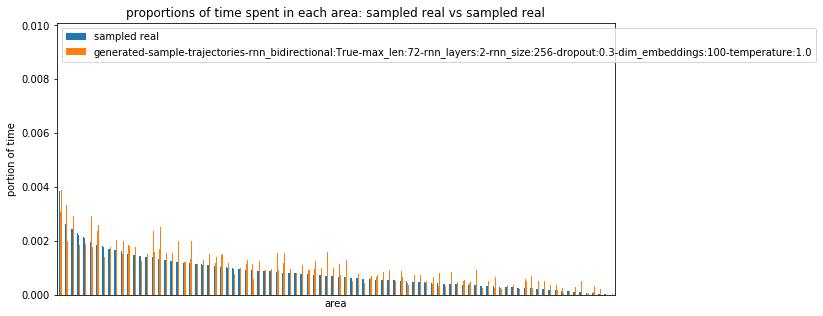

In [34]:
generated_trajectories_name = None
area_to_time_spent_dict_real_all = get_area_to_time_spent_comparison_dict(real_trajectories)
area_to_time_spent_dict_real_sample = get_area_to_time_spent_comparison_dict(real_trajectories_sample)

# Keep the best to plot
best_corr_generated_trajectories_name = None
best_area_to_time_spent_correlation_sample = 0
best_area_to_time_spent_comparison_df_sample = None

for column_name in models_matrix_df.columns:
    generated_trajectories_name = models_matrix_df.loc[generated_trajectories_name_idx][column_name]
    generated_trajectories = generated_sample_trajectories_map[generated_trajectories_name]
    area_to_time_spent_dict_generated = get_area_to_time_spent_comparison_dict(generated_trajectories)

    # Calculate correlation between generated synthetic data and full (all) real trajectories
    area_to_time_spent_comparison_df_all = get_area_to_time_spent_comparison_df(area_to_time_spent_dict_real_all,
                                                                            area_to_time_spent_dict_generated,
                                                                           d1_name='all real', d2_name=generated_trajectories_name)
    area_to_time_spent_correlation_all = area_to_time_spent_comparison_df_all['all real'].corr(area_to_time_spent_comparison_df_all[generated_trajectories_name])
    models_matrix_df.loc[area_to_dwell_time_correlation_all, column_name] = area_to_time_spent_correlation_all
    
    # Calculate correlation between generated synthetic data and sampled real trajectories
    area_to_time_spent_comparison_df_sample = get_area_to_time_spent_comparison_df(area_to_time_spent_dict_real_sample,
                                                                            area_to_time_spent_dict_generated,
                                                                           d1_name='sampled real', d2_name=generated_trajectories_name)
    area_to_time_spent_correlation_sample = area_to_time_spent_comparison_df_sample['sampled real'].corr(area_to_time_spent_comparison_df_sample[generated_trajectories_name])
    models_matrix_df.loc[area_to_dwell_time_correlation_sample, column_name] = area_to_time_spent_correlation_sample
    # Keep around the best
    if area_to_time_spent_correlation_sample > best_area_to_time_spent_correlation_sample:
        best_area_to_time_spent_correlation_sample = area_to_time_spent_correlation_sample
        best_corr_generated_trajectories_name = generated_trajectories_name
        best_area_to_time_spent_comparison_df_sample = area_to_time_spent_comparison_df_sample
    
# plot the best one
print('Best correlation for area to dwell time between the generated and real samples was for %s' % best_corr_generated_trajectories_name)
print(best_area_to_time_spent_correlation_sample)
plot_time_spent_comparison(best_area_to_time_spent_comparison_df_sample,
                        name1='sampled real',  name2=best_corr_generated_trajectories_name)

In [35]:
models_matrix_df

Z-bidirectional  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.8   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                       0.956   
work labels match portion                                                                      0.8595   
distinct unseen bigrams                                                                           195   
total unseen bigrams                                                                              253   
portion unseen bigrams                                                                     0.00103689   
portion unseen bigrams allowing skips                                                     0.000877049   
correlation of aggregate dwell time in each are...                                           0.795406   
correlation of aggregate dwell time in each are...                                           0.928875   

                                                                                    Z-bidirectional.1  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.9   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                      0.9525   
work labels match portion                                                                      0.8415   
distinct unseen bigrams                                                                           502   
total unseen bigrams                                                                              637   
portion unseen bigrams                                                                     0.00261066   
portion unseen bigrams allowing skips                                                      0.00213934   
correlation of aggregate dwell time in each are...                                           0.794795   
correlation of aggregate dwell time in each are...                                           0.941364   

                                                                                    Z-bidirectional.2  \
rnn_bidirectional                                                                                True   
max_length                                                                                    

### Measure how closely the distribution of the number of distinct places visited by each synthetic user resembles distribution from real data

Some users only go 2 or 3 distinct places during their week... while others visit 10-30 different places...

We use the Pearson's chi-squared test for homogeneity to compare the distribution of the number of distinct places visited between the generated synthetic data and the real data.

For each trajectory vector in the synthetic and real data, we take the number of distinct places visited as a category.  We compute the frequency of this category (number of distinct places visited) occuring in each of the synthetic and real datasets.

We then test the null hypothesis that:

The proportion of generated synthetic trajectory vectors with P distinct places visited is the same as the proportion of real trajectory vectors with P distinct places visited, for each P occuring in either of the generated or real datasets.

We test the null hypothesis with a significance level of 0.05.




In [36]:
def get_distinct_places_distribution(vectors):
    """
    Get the distribution of number of distinct places visited by each user.
    
    Returns a list of length matching number of user data vectors, 
    where each element corresponds to the number of distinct places visited by that user.
    """
    distinct_places_counts_per_user = []
    for vector in vectors:
        # get the number of distinct places visited by that user
        distinct_places = set()
        for area in vector:
            if area not in distinct_places:
                distinct_places.add(area)
        # append the number of distinct places visited by that user
        distinct_places_counts_per_user.append(len(distinct_places))
    return distinct_places_counts_per_user


- make vector of distinct places per user, where each value in vector is for a distinct user and represents number of distinct places they visited
- determine buckets/categories, and make mapping for buckets
    - this is to handle the long tail for the distributions (test less for data with counts < 5)
    - buckets must span all values in min to max (M) range, where the last buckets covers all values greater than M
- map values for distinc places to new 'categories' (where category is bucket of distinct places)
- transform vectors where the values are categories into mapping of {'category' --> frequency of occurance}
    - make sure all buckets in map, i.e. fill with zeros if necessary

- make mapping for real trajectories observations, values of map are the observations for each category
- from that real data, make expected observations with counts matching sample size of 2000
    - i.e. scale each value by 2000/N
    - i.e. each value for expected observations = frequency * 2000/N

Compare generated sample data to the expected values!
- first do a sanity test: sample 2000 trajectories from real trajectories
- run chi-squared test for each generated sample



In [37]:
generated_data_sample_size = 2000
real_data_population_size = len(real_trajectories)
observed_to_expected_multiplier = generated_data_sample_size/real_data_population_size
print('real population size: %s, generated data sample size: %s, (sample size)/(population size)=(%s)' % (real_data_population_size, generated_data_sample_size, observed_to_expected_multiplier))

real population size: 22704, generated data sample size: 2000, (sample size)/(population size)=(0.08809020436927413)


In [38]:
generated_trajectories_name = 'generated-sample-synthetic_trajectories-temperature:0.9'
generated_trajectories = generated_sample_trajectories_map[generated_trajectories_name]

distinct_places_counts_per_user_real = get_distinct_places_distribution(real_trajectories)
distinct_places_counts_per_user_generated = get_distinct_places_distribution(generated_trajectories)

print(min(distinct_places_counts_per_user_real))
print(max(distinct_places_counts_per_user_real))

1
43


In [39]:
# Make mapping of distinct places count to frequency
def get_distinct_places_category_to_frequency_map(dp_list):
    mapping = {c:0 for c in range(0, max(dp_list)+1)}
    for d in dp_list:
        mapping[d] += 1
    return mapping


In [40]:
distinct_places_category_to_frequency_map_real = get_distinct_places_category_to_frequency_map(distinct_places_counts_per_user_real)
# distinct_places_category_to_frequency_map_real

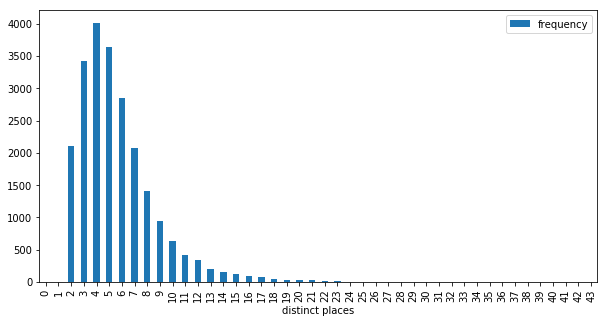

In [41]:
def plot_distinct_places_category_to_frequency(observed_values_map, expected_values_map=None,
                                               name1='frequency', name2='expected frequency'):
    df = pd.DataFrame.from_dict({
        'distinct places': list(observed_values_map.keys()),
        name1: list(observed_values_map.values())
    }).set_index('distinct places')
    if expected_values_map:
        df2 = pd.DataFrame.from_dict({
            'distinct places': list(expected_values_map.keys()),
            name2: list(expected_values_map.values())
        }).set_index('distinct places')
        df[name2] = df2[name2]
    df.plot(kind='bar')

plot_distinct_places_category_to_frequency(distinct_places_category_to_frequency_map_real)

Handle binning the data

In [42]:
# Get quantile bins based on the distribution of distinct places in thee full real population
# Bins chosen based on how dividing data can get close as possible to equal bins, 
#  but because of data distribution (e.g. so many points with 4 distinct places), exactly equal bins impossible
# At the same time, bin the real data into these buckets -- this is the output binned series
# Each element in the binned series indicates the bin it belongs in, indicating that bin by the index of bin
# Then reuse these bins to bin the generated data
quantiles = 6 # 15 # Turns into 10 with drop duplicates (command to drop duplicate edges -- error on quantiles=10 otherwise)
# First print nicely with the labeled bins
real_reference_binned_series, bins = pd.qcut(distinct_places_counts_per_user_real, quantiles, retbins=True, duplicates='drop')
print('Binning:')
print(real_reference_binned_series)
# Then get the unlabeled bins and series that we need
real_reference_binned_series, bins = pd.qcut(distinct_places_counts_per_user_real, quantiles, retbins=True, labels=False, duplicates='drop')

# Note: the max bin value is increased to accommodated generated data long tails
print(len(bins), 'bins:', bins)

Binning:
[(6.0, 8.0], (3.0, 4.0], (8.0, 43.0], (4.0, 5.0], (4.0, 5.0], ..., (3.0, 4.0], (4.0, 5.0], (0.999, 3.0], (5.0, 6.0], (0.999, 3.0]]
Length: 22704
Categories (6, interval[float64]): [(0.999, 3.0] < (3.0, 4.0] < (4.0, 5.0] < (5.0, 6.0] < (6.0, 8.0] < (8.0, 43.0]]
7 bins: [ 1.  3.  4.  5.  6.  8. 43.]


In [43]:
def get_binned_series_to_binned_map(binned_series, bins):
    """
    Transforms the binned series into a mapping of {bin name -> frequency count}
    """
    bin_index_to_name_map = {i:'(%s, %s]' % (bins[i], bins[i+1]) for i in range(1, len(bins)-1)}
    bin_index_to_name_map[0] = '<= %s' % bins[1]

    bin_index_to_name_map[len(bins)-2] = '> %s' % bins[len(bins)-2]
    bin_index_to_name_map
    # First make mapping of {bin index -> frequency}
    binned_map = {i:0 for i in range(len(bins)-1)}
    for item in binned_series:
        binned_map[item] += 1
    # rename bins based on their span
    binned_map = {bin_index_to_name_map[k]:v for k,v in binned_map.items()}
    return binned_map

{'<= 3.0': 5521,
 '(3.0, 4.0]': 4006,
 '(4.0, 5.0]': 3639,
 '(5.0, 6.0]': 2853,
 '(6.0, 8.0]': 3487,
 '> 8.0': 3198}

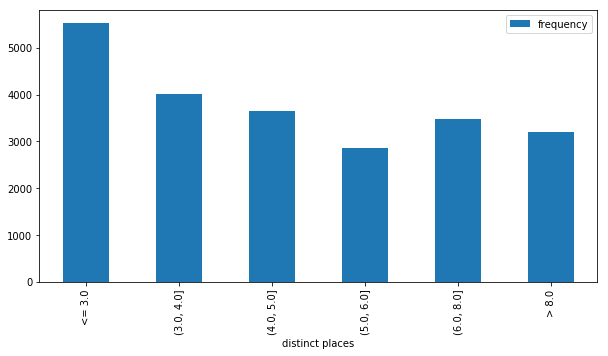

In [44]:
real_reference_binned_map = get_binned_series_to_binned_map(real_reference_binned_series, bins)
plot_distinct_places_category_to_frequency(real_reference_binned_map)
real_reference_binned_map

{'<= 3.0': 486.34601832276246,
 '(3.0, 4.0]': 352.88935870331215,
 '(4.0, 5.0]': 320.5602536997886,
 '(5.0, 6.0]': 251.32135306553909,
 '(6.0, 8.0]': 307.1705426356589,
 '> 8.0': 281.7124735729387}

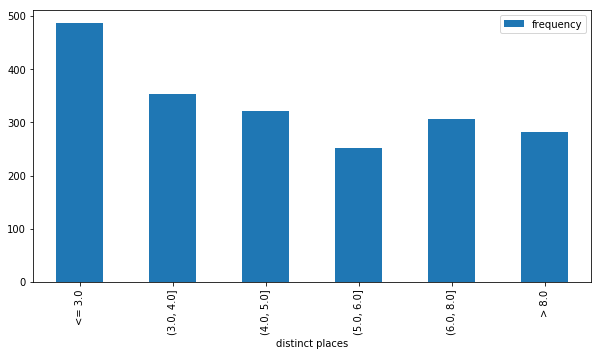

In [45]:
# Make expected frequencies mapping for the sample size (values scaled and rounded to integer values)
expected_category_to_frequency_map = {c: f*observed_to_expected_multiplier for c, f in real_reference_binned_map.items()}
plot_distinct_places_category_to_frequency(expected_category_to_frequency_map)
expected_category_to_frequency_map

{'<= 3.0': 493,
 '(3.0, 4.0]': 340,
 '(4.0, 5.0]': 324,
 '(5.0, 6.0]': 268,
 '(6.0, 8.0]': 302,
 '> 8.0': 273}

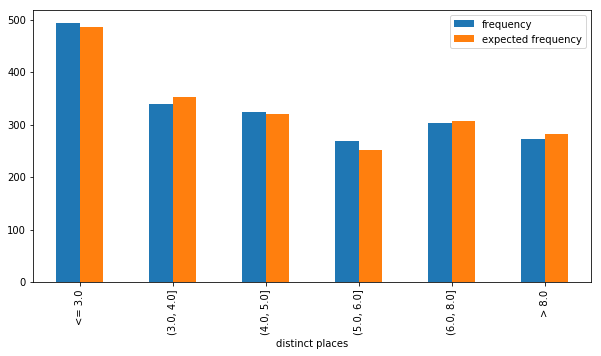

In [46]:
# sanity check: now do chi-squared test for real sample observations vs expected observations
# Bin the sample data with chosen bins
distinct_places_counts_per_user_real_sample = get_distinct_places_distribution(real_trajectories_sample)
real_sample_binned_series = pd.cut(distinct_places_counts_per_user_real_sample, bins=bins, labels=False, include_lowest=True)
real_sample_binned_map = get_binned_series_to_binned_map(real_sample_binned_series, bins)
plot_distinct_places_category_to_frequency(real_sample_binned_map, expected_category_to_frequency_map)
real_sample_binned_map

In [47]:
from scipy.stats import chisquare
chisq, p = chisquare(list(real_sample_binned_map.values()),
               f_exp=list(expected_category_to_frequency_map.values()))

print('The chi-squared test statistic: %s\np-value: %s' % (chisq, p))

The chi-squared test statistic: 2.0620762451973573
p-value: 0.8404906622555846


Add chi-squared test p-value as a row in the model comparison matrix

In [48]:
# Add dummy row
chi_squared_p_value = 'chi-squared homogeneity test p-value'
models_matrix_df = add_dummy_row(models_matrix_df, chi_squared_p_value)
models_matrix_df

Z-bidirectional  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.8   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                       0.956   
work labels match portion                                                                      0.8595   
distinct unseen bigrams                                                                           195   
total unseen bigrams                                                                              253   
portion unseen bigrams                                                                     0.00103689   
portion unseen bigrams allowing skips                                                     0.000877049   
correlation of aggregate dwell time in each are...                                           0.795406   
correlation of aggregate dwell time in each are...                                           0.928875   
chi-squared homogeneity test p-value                                                              NaN   

                                                                                    Z-bidirectional.1  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.9   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                      0.9525   
work labels match portion                                                                      0.8415   
distinct unseen bigrams                                                                           502   
total unseen bigrams                                                                              637   
portion unseen bigrams                                                                     0.00261066   
portion unseen bigrams allowing skips                                                      0.00213934   
correlation of aggregate dwell time in each are...                                           0.794795   
correlation of aggregate dwell time in each are...                                           0.941364   
chi-squared homogeneity test p-value                                                              NaN   

                                                                                    Z-bidirect

In [49]:
# Keep best result handy to inspect
best_p = None
best_chi_generated_trajectories_name = None

for column_name in models_matrix_df.columns:
    generated_trajectories_name = models_matrix_df.loc[generated_trajectories_name_idx][column_name]
    generated_trajectories = generated_sample_trajectories_map[generated_trajectories_name]
    distinct_places_counts_per_user = get_distinct_places_distribution(generated_trajectories)
    # Might need to increase the maximum bin value to include new max
    max_distinct_places_per_user = max(distinct_places_counts_per_user)
    if max_distinct_places_per_user > bins[-1]:
        bins[-1] = max_distinct_places_per_user
    generated_sample_binned_series = pd.cut(distinct_places_counts_per_user, bins=bins, labels=False, include_lowest=True)
    generated_sample_binned_map = get_binned_series_to_binned_map(generated_sample_binned_series, bins)
    
    chisq, p = chisquare(list(generated_sample_binned_map.values()),
               f_exp=list(expected_category_to_frequency_map.values()))
#     print('column: %s\nchisquared value: %s\np-value: %s' % (column_name, chisq, p))
#     plot_distinct_places_category_to_frequency(generated_sample_binned_map, expected_category_to_frequency_map)
    models_matrix_df.loc[chi_squared_p_value, column_name] = p
    if (not best_p) or p > (best_p):
        best_p = p
        best_chi_generated_trajectories_name = generated_trajectories_name
        

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(models_matrix_df)

Z-bidirectional  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.8   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                       0.956   
work labels match portion                                                                      0.8595   
distinct unseen bigrams                                                                           195   
total unseen bigrams                                                                              253   
portion unseen bigrams                                                                     0.00103689   
portion unseen bigrams allowing skips                                                     0.000877049   
correlation of aggregate dwell time in each are...                                           0.795406   
correlation of aggregate dwell time in each are...                                           0.928875   
chi-squared homogeneity test p-value                                                                0   

                                                                                    Z-bidirectional.1  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.9   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                      0.9525   
work labels match portion                                                                      0.8415   
distinct unseen bigrams                                                                           502   
total unseen bigrams                                                                              637   
portion unseen bigrams                                                                     0.00261066   
portion unseen bigrams allowing skips                                                      0.00213934   
correlation of aggregate dwell time in each are...                                           0.794795   
correlation of aggregate dwell time in each are...                                           0.941364   
chi-squared homogeneity test p-value                                                     9.96772e-202   

                                                                                    Z-bidirect

Plot two graphs showing the distributions of the number of distinct places visited by each user, one for the real dataset and another for the synthetic dataset.

best generated trajectories: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0
best p-value: 0.42875441676663806


{'<= 3.0': 470,
 '(3.0, 4.0]': 342,
 '(4.0, 5.0]': 313,
 '(5.0, 6.0]': 243,
 '(6.0, 8.0]': 322,
 '> 8.0': 310}

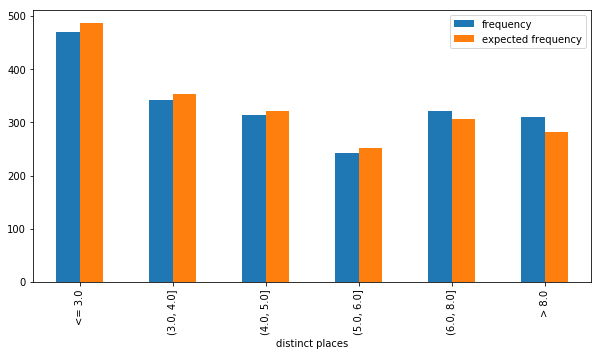

In [50]:
print('best generated trajectories:', best_chi_generated_trajectories_name)
print('best p-value:', best_p)

generated_trajectories = generated_sample_trajectories_map[best_chi_generated_trajectories_name]
distinct_places_counts_per_user = get_distinct_places_distribution(generated_trajectories)
generated_sample_binned_series = pd.cut(distinct_places_counts_per_user, bins=bins, labels=False, include_lowest=True)
generated_sample_binned_map = get_binned_series_to_binned_map(generated_sample_binned_series, bins)

plot_distinct_places_category_to_frequency(generated_sample_binned_map, expected_category_to_frequency_map)
generated_sample_binned_map

## Evaluate how much privacy was retained vs lost

To evaluate privacy retained, we look at multiple metrics.


### Privacy Evaluation 1

#### Evaluate whethere uniqueness of distinct places visited is retained


We compress dwell vectors down to sets of places visited.
e.g. the vector [1,1,2,1,5,0] is represented as {0,1,2,5}

We then find within the full real population the sets of places visited that are unique, meaning that they are only found in one trajectory vector. 
- How many are there? 
- Are any of these sets found in the generated data? How many?


In [51]:
def vector_to_distinct_places_set(vector):
    """
    Returns the set of distinct places visited in a vector.
    e.g. the vector [1,1,2,1,5,0] is represented as {0,1,2,5}
    """
    return set(vector)

In [52]:
def places_set_to_str(places_set):
    """
    In order to throw these places sets into a dict as keys, need to represent them as hashable type.
    Returns string representing places set.
    {1,2,3} -> '1 2 3'
    """
    return ' '.join([str(i) for i in sorted(list(places_set))])

assert('20 30 40' == places_set_to_str({30, 20, 40}))
assert('1 2' == places_set_to_str({2, 1}))

def vector_to_distinct_places_set_str(vector):
    return places_set_to_str(vector_to_distinct_places_set(vector))

assert(vector_to_distinct_places_set_str([2,1]*5) == '1 2')
assert(vector_to_distinct_places_set_str([20, 222, 222, 1]*5) == '1 20 222')

In [53]:
# Get the unique sets from the real full population
unprefixed_real_trajectories = get_unprefixed_vectors(real_trajectories)


In [54]:
# For a given list of trajectories, create a mapping from
# { set of distinct places --> count of trajectories with that distinct places set}

places_set_to_count_map = dict()

for v in unprefixed_real_trajectories:
    places_set_str = vector_to_distinct_places_set_str(v)
    if places_set_str not in places_set_to_count_map:
        places_set_to_count_map[places_set_str] = 0
    places_set_to_count_map[places_set_str] += 1
    
# plt.hist(places_set_to_count_map.values())
real_places_set_to_count_series = pd.Series(list(places_set_to_count_map.values()))
print(real_places_set_to_count_series.describe())

places_set_to_count_map

count    20278.000000
mean         1.119637
std          1.007438
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         62.000000
dtype: float64


{'0 1 2 3 4 5 6': 1,
 '0 7 8 9': 1,
 '0 10 11 12 13 14 15 16 17 18': 1,
 '0 19 20 21 22': 1,
 '0 23 24 25 26': 1,
 '0 20 21 27 28': 1,
 '0 29 30 31 32 33 34 35 36': 1,
 '0 37 38 39': 1,
 '0 20 40 41 42': 1,
 '0 43 44': 1,
 '0 45 46 47 48': 1,
 '0 20 22 49 50 51 52 53 54 55 56 57 58 59': 1,
 '0 60 61 62': 1,
 '0 31 63 64 65 66 67 68 69': 1,
 '0 21 70 71 72': 1,
 '0 8 15 21 52 73 74': 1,
 '0 75 76 77': 1,
 '0 3 13 20 31 34 35 53 78 79 80 81 82 83 84 85 86': 1,
 '0 87 88 89 90 91 92': 1,
 '0 4 93 94 95': 1,
 '0 14 21 42 76 96 97 98 99 100 101': 1,
 '0 102 103 104 105 106 107': 1,
 '0 44 108 109': 1,
 '0 110': 3,
 '0 68 111 112 113 114 115': 1,
 '0 20 116': 2,
 '0 55 117 118 119 120 121 122 123': 1,
 '0 24 124 125': 2,
 '0 24 124 126 127': 1,
 '0 22 128 129 130': 1,
 '0 84 92': 1,
 '0 21 131 132 133 134': 1,
 '0 39 135 136 137 138 139': 1,
 '0 140 141 142': 1,
 '0 112 143 144': 1,
 '0 113 145': 1,
 '0 20 87 146': 1,
 '0 104 147 148 149 150': 1,
 '0 14 68 130 151 152': 1,
 '0 14 112 153 154

Count the number of times the generated data creates a distinct places set that matches a uniquely occuring distinct places set in the real data.

In [55]:
unique_distinct_places_sets = {places_set for places_set, count in places_set_to_count_map.items() if count == 1}
print('number of unique distinct places sets in real data: %s' % len(unique_distinct_places_sets))

def get_reproduced_distinct_places_sets_to_count_map(vectors, unique_distinct_places_sets=unique_distinct_places_sets):
    """
    Returns a mapping of the distinct places sets that were unique in the reference (real) dataset
    to the number of times they were reproduced in the vectors.
    e.g. returns {'unique places': count for times reproduced in vectors}
    """
    unprefixed_vectors = get_unprefixed_vectors(vectors)
    distinct_places_set_list = [vector_to_distinct_places_set_str(v) for v in unprefixed_vectors]
    reproduced_unique_distinct_places_sets_to_count = dict()
    for places_set in distinct_places_set_list:
        if places_set in unique_distinct_places_sets:
            # found one! count it!
            if places_set not in reproduced_unique_distinct_places_sets_to_count:
                reproduced_unique_distinct_places_sets_to_count[places_set] = 0
            reproduced_unique_distinct_places_sets_to_count[places_set] += 1
    return reproduced_unique_distinct_places_sets_to_count

# Make sure this works as expected by using real trajectories sample
# Expect some reproduced places sets, but no more than 1 for each of course!
real_sample_reproduced_distinct_places_sets_to_count_map = get_reproduced_distinct_places_sets_to_count_map(real_trajectories_sample,
                                                                                                            unique_distinct_places_sets)
assert(len(real_sample_reproduced_distinct_places_sets_to_count_map) > 1)
assert(min(real_sample_reproduced_distinct_places_sets_to_count_map.values()) == 1)
assert(max(real_sample_reproduced_distinct_places_sets_to_count_map.values()) == 1)
assert(sum(real_sample_reproduced_distinct_places_sets_to_count_map.values()) == len(real_sample_reproduced_distinct_places_sets_to_count_map))

number of unique distinct places sets in real data: 19378


In [56]:
# Add dummy row
unique_distinct_places_set_reproduced_count = '# times unique distinct places set reproduced'
models_matrix_df = add_dummy_row(models_matrix_df, unique_distinct_places_set_reproduced_count)
models_matrix_df

Z-bidirectional  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.8   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                       0.956   
work labels match portion                                                                      0.8595   
distinct unseen bigrams                                                                           195   
total unseen bigrams                                                                              253   
portion unseen bigrams                                                                     0.00103689   
portion unseen bigrams allowing skips                                                     0.000877049   
correlation of aggregate dwell time in each are...                                           0.795406   
correlation of aggregate dwell time in each are...                                           0.928875   
chi-squared homogeneity test p-value                                                                0   
# times unique distinct places set reproduced                                                     NaN   

                                                                                    Z-bidirectional.1  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.9   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                      0.9525   
work labels match portion                                                                      0.8415   
distinct unseen bigrams                                                                           502   
total unseen bigrams                                                                              637   
portion unseen bigrams                                                                     0.00261066   
portion unseen bigrams allowing skips                                                      0.00213934   
correlation of aggregate dwell time in each are...                                           0.794795   
correlation of aggregate dwell time in each are...                                           0.941364   
chi-squared homogeneity test p-value                                                     9.9677

In [57]:
# Fill the row for each generated data  set

# Keep best & worst results handy to inspect
min_reproduced = None
max_reproduced = None
min_reproduced_generated_trajectories_name = None
max_reproduced_generated_trajectories_name = None

for column_name in models_matrix_df.columns:
    
    generated_trajectories_name = models_matrix_df.loc[generated_trajectories_name_idx][column_name]
    generated_trajectories = generated_sample_trajectories_map[generated_trajectories_name]
    reproduced_distinct_places_sets_to_count_map = get_reproduced_distinct_places_sets_to_count_map(generated_trajectories,
                                                                                                    unique_distinct_places_sets)
    total_reproduced_count = sum(reproduced_distinct_places_sets_to_count_map.values())
    models_matrix_df.loc[unique_distinct_places_set_reproduced_count, column_name] = total_reproduced_count
    # store best & worst for inspection
    if (not min_reproduced) or (total_reproduced_count < min_reproduced):
        min_reproduced = total_reproduced_count
        min_reproduced_generated_trajectories_name  = generated_trajectories_name
    if (not max_reproduced) or (total_reproduced_count > max_reproduced):
        max_reproduced = total_reproduced_count
        max_reproduced_generated_trajectories_name  = generated_trajectories_name

print('min reproduced: %s, by: %s' % (min_reproduced, min_reproduced_generated_trajectories_name))
print('max reproduced: %s, by: %s' % (max_reproduced, max_reproduced_generated_trajectories_name))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(models_matrix_df)

min reproduced: 8, by: generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.2
max reproduced: 247, by: generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.8


Z-bidirectional  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.8   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                       0.956   
work labels match portion                                                                      0.8595   
distinct unseen bigrams                                                                           195   
total unseen bigrams                                                                              253   
portion unseen bigrams                                                                     0.00103689   
portion unseen bigrams allowing skips                                                     0.000877049   
correlation of aggregate dwell time in each are...                                           0.795406   
correlation of aggregate dwell time in each are...                                           0.928875   
chi-squared homogeneity test p-value                                                                0   
# times unique distinct places set reproduced                                                     247   

                                                                                    Z-bidirectional.1  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.9   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                      0.9525   
work labels match portion                                                                      0.8415   
distinct unseen bigrams                                                                           502   
total unseen bigrams                                                                              637   
portion unseen bigrams                                                                     0.00261066   
portion unseen bigrams allowing skips                                                      0.00213934   
correlation of aggregate dwell time in each are...                                           0.794795   
correlation of aggregate dwell time in each are...                                           0.941364   
chi-squared homogeneity test p-value                                                     9.9677

TODO: Rewrite for privacy evaluation 2


Compare trajectories using edit distance as a  metric, where the edit distance is the Levenshtein between the two vectors represented as strings

Implementation of levenshtein distance:

In [58]:
def levenshtein_distance(s1, s2):
    """
    Returns (int) the levenshtein edit distance between two lists, where those lists can be arbitrary integers.
    """
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

In [68]:
# Quick demonstration that this distance metric works as desired
assert(levenshtein_distance([], []) == 0)
assert(levenshtein_distance([234, 1], [1]) == 1)

unprefixed_real_trajectories = get_unprefixed_vectors(real_trajectories)

# Take reference vector
v1 = unprefixed_real_trajectories[0]
# The edit distance from the vector to itself is 0
assert(levenshtein_distance(v1, v1) == 0)

# Substitute 1 item in the vector to create new vector -- expect levenshtein edit distance of 1
v2 = v1[:]
v2[0] = 1 if (not v1[0] is 1) else 100
assert(len(v1) == len(v2) and levenshtein_distance(v1, v2) == 1)


# Substitute 3 items in the vector to create new vector -- expect levenshtein edit distance of 3
v2 = v1[:]
v2[0] = 1 if (not v1[0] is 1) else 100
v2[1] = 1 if (not v1[0] is 1) else 100
v2[-1] = 1 if (not v1[0] is 1) else 100
assert(len(v1) == len(v2) and levenshtein_distance(v1, v2) ==3)

# Shift vector by 1 item to create new vector -- expect levenshtein edit distance of 2
v2 = v1[1:] + [v1[0]]
assert(len(v1) == len(v2) and levenshtein_distance(v1, v2) == 2)


In [ ]:
def get_min_edit_distance(vector, comparison_vectors=unprefixed_real_trajectories):
    return min([levenshtein_distance(vector, comparison_vector) for comparison_vector in comparison_vectors])

def get_min_edit_distances(vectors, comparison_vectors=unprefixed_real_trajectories, truncate=None):
    """
    Returns a list of integers representing minimum edit distances from comparison vectors.
    There is one integer in the list corresponding to each vector in the passed in vectors,
    where this integer represents the minimum edit distance this vector is from any of the
    comparison vectors.
    The optional truncate (int) parameter can be used to compare vectors up to the given truncation length.
    """
    if truncate and truncate > 0:
        truncated_comparison_vectors =  [cv[:truncate] for cv in comparison_vectors]
        return [get_min_edit_distance(v[:truncate], truncated_comparison_vectors) for v in vectors]
    return [get_min_edit_distance(v, comparison_vectors) for v in vectors]

# Sanity check:
assert(sum(get_min_edit_distances(unprefixed_real_trajectories[:3], truncate=24)) == 0)

In [70]:
# For comparisons, truncate vectors to this many elements (hours)
TRUNCATE_LEN = None # When =24 it is easy to find min edit distances of 0 within the real sample data

In [ ]:
# Sanity check & time check:
truncate_len = TRUNCATE_LEN
test_vectors = [[random.randint(0, 652) for iter in range(120)] for i in range(22000)]
for i in [1, 10, 100, 1000]:
    print('time check for %s vectors against 22000 vectors truncated to %s hours:' % (i, truncate_len))
    d1 = datetime.datetime.now()
    assert(sum(get_min_edit_distances(test_vectors[:i], test_vectors, truncate=TRUNCATE_LEN)) == 0)
    print(datetime.datetime.now() - d1)


- get the allowed/non-unique (home, work) pairs
- read in the file of real full population trajectories

- get the names of trajectory samples
- for each list of trajectories in {S, {Gm}}
    - get file name to write the output min distances to
    - read in the trajectories
    - filter the trajectories to just those that start with an allowed (home, work) pair
    - create list of Md_i values for each tv_i in the filtered list of trajectories
    - if the filtered list is from the real sample, tv_i should skip comparison against itself
    - save the list to min distances file

    - each list should the same size






In [68]:
def get_generated_trajectories_filename(sample_name):
    return '../textgenrnn_generator/output/{}.txt'.format(sample_name)

def read_trajectories_from_file(filename):
    """
    Returns a list of lists, where each list represents a trajectory written to file.
    Expects file format where each line is one trajectory, and places in the trajectory are delimited by spaces.
    """
    trajectories = []
    with open(filename, 'r') as f:
        trajectories = [[int(x) for x in line.strip().split()] for line in f]
    return trajectories

def get_min_edit_distances_filename(sample_name, to='real'):
    return '../textgenrnn_generator/output/min-edit-distances-to-{to}-pop-from-{sample_name}.txt'.format(sample_name=sample_name, to=to)


def write_min_edit_distances_to_file(min_edit_distances_list, filename):
    with open(filename, 'w') as f:
        f.write(' '.join([str(i) for i in min_edit_distances_list]))


In [77]:
# For later...
def read_min_edit_distances_from_file(filename):
    min_edit_distances_list = []
    with open(filename, 'r') as f:
        min_edit_distances_list = [int(x) for x in f.read().strip().split()]
    return min_edit_distances_list

# Show this works as intended:
test_list = [1,2,321]
test_filename = get_min_edit_distances_filename('test-delete-me')
write_min_edit_distances_to_file(test_list, test_filename)
assert(read_min_edit_distances_from_file(test_filename) == test_list)


In [78]:

# Initial testing analysis limits sample size to a random subsample of N=200 due to the computational time required
# to get the minimum edit distances
# After the better models are determined, we do the same computation again for them with no such limit.
LIMIT_SAMPLE_SIZE = None # 200


def trajectory_has_allowed_prefix(prefixed_trajectory, allowed_prefixes_set):
    # The prefixed trajectory is a list of integers.
    # The items in the allowed prefixes set are strings representing the first 2 items of such a list
    return ' '.join([str(t) for t in prefixed_trajectory[:2]]) in allowed_prefixes_set

def filter_to_trajectories_with_prefixes(prefixed_trajectories_list, allowed_prefixes):
    return [t for t in prefixed_trajectories_list if trajectory_has_allowed_prefix(t, allowed_prefixes)]

# Quick test:
allowed_prefixes = {'1 20', '201', '1201', '1 2011', '1 2'}
allowed_t = [1, 20, 5]
not_allowed_t  = [1, 201, 5]
assert([allowed_t] == filter_to_trajectories_with_prefixes([allowed_t, not_allowed_t], allowed_prefixes))


def get_min_edit_distances_list(prefixed_sample_vectors, allowed_prefixes, comparison_vectors,
                                is_real_sample=False, limit_sample_size=LIMIT_SAMPLE_SIZE):
    # Filter the trajectory vectors to those with allowed prefixes
    filtered_prefixed_vectors = filter_to_trajectories_with_prefixes(prefixed_sample_vectors, allowed_prefixes)
    # limit the sample size to maximum value, and take their random sample with that limit
    random.shuffle(filtered_prefixed_vectors)
    filtered_prefixed_vectors = filtered_prefixed_vectors[:limit_sample_size]
    # get the unprefixed version of the vector
    filtered_unprefixed_sample_vectors = get_unprefixed_vectors(filtered_prefixed_vectors)
    comparison_vectors = get_unprefixed_vectors(comparison_vectors)
    if is_real_sample:
        # Each vector in the real sample occurs in the real full population but should not
        # be compared against itself.
        # Remove each vector from the comparison list, but only once (if duplicates occur, only one should be removed)
        comparison_vectors_less_real_sample = comparison_vectors[:] # Make a copy
        for v in filtered_unprefixed_sample_vectors:
            for _i, cv in enumerate(comparison_vectors):
                if v == cv:
                    # remove cv from the list less real sample; only do this once
                    comparison_vectors_less_real_sample.remove(v)
                    break
        assert(len(comparison_vectors_less_real_sample) == (len(real_trajectories) - len(filtered_unprefixed_sample_vectors)))
        comparison_vectors = comparison_vectors_less_real_sample

    return get_min_edit_distances(filtered_unprefixed_sample_vectors,
                                  comparison_vectors=comparison_vectors,
                                  truncate=TRUNCATE_LEN)


The functions have been defined!  Now read in the data and do the work

In [79]:
# Get the set of (home, work) pairs in the sample populations that are unique.
# They were generated by using a {'home work': count} mapping file.  We use this.
import json

trajectories_prefixes_to_counts_sample_2000_filename = './../data/relabeled_trajectories_1_workweek_prefixes_to_counts_sample_2000.json'
sample_prefixes_to_counts_dict = None

with open(trajectories_prefixes_to_counts_sample_2000_filename) as json_file:
    sample_prefixes_to_counts_dict = json.load(json_file)

sample_prefixes_to_counts_df = pd.DataFrame.from_dict({
        'prefix': [prefix for prefix in sample_prefixes_to_counts_dict.keys()],
        'count': [count for count in sample_prefixes_to_counts_dict.values()]
})
print('Distribution of prefix counts:\n')
print(sample_prefixes_to_counts_df['count'].describe())


# non_unique_prefix_set = {prefix for (prefix, count) in sample_prefixes_to_counts_dict.items() if count > 1}
non_unique_prefix_set = set(sample_prefixes_to_counts_df[sample_prefixes_to_counts_df['count'] > 1]['prefix'])
print('\nnumber of non-unique (home, work) pair prefixes in the 2000 vector sample: %s' % (len(non_unique_prefix_set)))

sample_prefixes_to_counts_df.sort_values('count', ascending=False).head()

Distribution of prefix counts:

count    1357.000000
mean        1.473839
std         1.137430
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        15.000000
Name: count, dtype: float64

number of non-unique (home, work) pair prefixes in the 2000 vector sample: 307


prefix  count
213    21 21     15
32     44 44      9
258  434 434      8
140  223 223      8
126    39 39      7

In [80]:
# How many vectors will that leave?
sample_prefixes_to_counts_df[sample_prefixes_to_counts_df['count'] > 1]['count'].sum()

950

In [81]:
non_unique_prefix_set

{'1 1',
 '102 102',
 '103 103',
 '104 104',
 '108 0',
 '108 108',
 '109 109',
 '111 111',
 '112 112',
 '114 114',
 '116 116',
 '118 118',
 '118 76',
 '120 120',
 '121 121',
 '121 404',
 '122 122',
 '124 124',
 '125 125',
 '126 126',
 '130 130',
 '131 131',
 '131 84',
 '133 133',
 '14 14',
 '140 140',
 '142 142',
 '143 143',
 '146 146',
 '147 147',
 '149 149',
 '15 15',
 '150 150',
 '151 151',
 '157 157',
 '163 163',
 '167 167',
 '168 0',
 '168 168',
 '171 171',
 '173 173',
 '174 174',
 '176 176',
 '177 177',
 '178 178',
 '180 180',
 '182 182',
 '184 184',
 '186 186',
 '189 189',
 '19 19',
 '190 190',
 '191 191',
 '195 195',
 '197 197',
 '198 0',
 '199 199',
 '2 2',
 '20 0',
 '20 20',
 '200 200',
 '201 201',
 '202 130',
 '202 202',
 '204 204',
 '205 205',
 '208 208',
 '209 209',
 '21 0',
 '21 21',
 '212 212',
 '214 214',
 '217 217',
 '219 219',
 '22 0',
 '22 22',
 '220 220',
 '222 222',
 '223 223',
 '224 224',
 '225 225',
 '226 226',
 '227 227',
 '23 23',
 '230 230',
 '231 231',
 '232 0

#### Iterative Analysis Process

Initially we compute min edit distance vectors for the 'best' N=20 models, but limit the number of trajectories to 200.  This is because the computation is time intensive.

After this initial analysis, we refine what we determine by 'best' based on the cuttoff for their 10th percentile min edit distances.  We then choose the 'best' N=10 models to run the same computation for, but with no limit on number of trajectories.

We do this in a script that is run on remote machines: 

https://github.com/aberke/lbs-data/blob/master/trajectory_synthesis/evaluation/get_minimum_edit_distances.py

In [82]:
#  Read in the data...
real_trajectories = read_trajectories_from_file(relabeled_trajectories_filename)

real_trajectories_sample_2000_filename = '../data/relabeled_trajectories_1_workweek_sample_2000.txt'
real_trajectories_sample = read_trajectories_from_file(real_trajectories_sample_2000_filename)
assert(all([real_trajectories_sample[t] in real_trajectories for t in [1,2,3,-3,-2,-1]]))

To get the trajectories for initial analysis with limit = 200:

In [83]:
# Get the names of the generated samples to get minimum edit distances for
# How about the N best ones sorted by home label match rate
N = 20
generated_sample_names_best_20 = [n for n in models_matrix_df.sort_values(home_labels_match_portion, axis=1, ascending=False).loc[generated_trajectories_name_idx][:N]]

In [84]:
# Nicely format them...
import pprint
generated_sample_names = generated_sample_names_best_20
pprint.PrettyPrinter().pprint(generated_sample_names_best_20)

['generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.8',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.9',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.0',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.1',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.2',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.9',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0',
 'generated-s

The min edit distances were computed for each of these best 20 trajectories lists.
But these edit distances are for random subsample limited to 200 per model.  
We then refined this list to best 10 to not apply subsampling  limit.

- We read in these files containing minimum edit distances for comparing generated data against real sample.
- We inspected the minimum of the minimum and the cuttoff for the Pth percentile for min edit distance. (Here P=10)
- We took 'best 10' where home label match rate > threshold = 0.85 and then sorted by highest Pth percentile.


For the sake of comparison, note the minimum of the minimum and 10th percentile cutoff for edit distances between the real sample of vectors to any of the other real vectors (where each real vector ignores itself once).

In [85]:
# Get the minimum minimum edit distance for the real sample, as for comparison
import statistics

real_sample_min_edit_distances_filename = get_min_edit_distances_filename('real_sample_2000')
real_sample_min_edit_distances_list = read_min_edit_distances_from_file(real_sample_min_edit_distances_filename)
min_min_edit_dist_real_sample = min(real_sample_min_edit_distances_list)
print(min_min_edit_dist_real_sample, '= minimum over all minimum edit distances for real sample vs full real population:')

real_sample_min_edit_distances_series = pd.Series(real_sample_min_edit_distances_list)
print('bottom 10th percentile value:', real_sample_min_edit_distances_series.quantile(0.1))
print('bottom 5th percentile value:', real_sample_min_edit_distances_series.quantile(0.05))
print('bottom 1st percentile value:', real_sample_min_edit_distances_series.quantile(0.01))
real_sample_min_edit_distances_series.describe()


0 = minimum over all minimum edit distances for real sample vs full real population:
bottom 10th percentile value: 14.0
bottom 5th percentile value: 11.0
bottom 1st percentile value: 5.0


count    950.000000
mean      31.397895
std       13.175623
min        0.000000
25%       22.000000
50%       32.000000
75%       40.000000
max       75.000000
dtype: float64

In [113]:
# Add a row to the model comparison matrix showing for each generated trajectory set,
# the minimum of the minimum edit distances between any of the generated vectors to any of the real vectors.

min_edit_distances_min = 'Minimum over all minimum edit distances for generated vs real vectors'
min_edit_distances_bottom_10_percentile = 'Bottom 10th percentile value over all minimum edit distances for generated vs real vectors'

models_matrix_df = add_dummy_row(models_matrix_df, min_edit_distances_min)
models_matrix_df = add_dummy_row(models_matrix_df, min_edit_distances_bottom_10_percentile)


In [114]:
for column_name in models_matrix_df.columns:
    generated_sample_name = models_matrix_df.loc[generated_trajectories_name_idx][column_name]
    if generated_sample_name not in generated_sample_names:
        continue
    generated_sample_min_edit_distances_filename = get_min_edit_distances_filename(generated_sample_name)
    generated_sample_min_edit_distances_list = read_min_edit_distances_from_file(generated_sample_min_edit_distances_filename)
    min_edit_dist_min = min(generated_sample_min_edit_distances_list)
    models_matrix_df.loc[min_edit_distances_min, column_name] = min_edit_dist_min
    models_matrix_df.loc[min_edit_distances_bottom_10_percentile, column_name] = pd.Series(generated_sample_min_edit_distances_list).quantile(0.1)

models_matrix_df

Z-bidirectional  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.8   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                       0.956   
work labels match portion                                                                      0.8595   
distinct unseen bigrams                                                                           195   
total unseen bigrams                                                                              253   
portion unseen bigrams                                                                     0.00103689   
portion unseen bigrams allowing skips                                                     0.000877049   
correlation of aggregate dwell time in each are...                                           0.795406   
correlation of aggregate dwell time in each are...                                           0.928875   
chi-squared homogeneity test p-value                                                                0   
# times unique distinct places set reproduced                                                     247   
Minimum over all minimum edit distances for gen...                                                  0   
Bottom 10th percentile value over all minimum e...                                                  5   

                                                                                    Z-bidirectional.1  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       0.9   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                      0.9525   
work labels match portion                                                                      0.8415   
distinct unseen bigrams                                                                           502   
total unseen bigrams                                                                              637   
portion unseen bigrams                                                                     0.00261066   
portion unseen bigrams allowing skips                                                      0.00213934   
correlation of aggregate dwell time in each are...                                           0.

In [115]:
# Take the best 10 for further privacy analysis

# This was run once, and then saved as variable so that it would not be later overwritten
# if sorted values changed with new data
# best_10_cols = models_matrix_df.loc[:, models_matrix_df.loc[home_labels_match_portion] > 0.85].sort_values(min_edit_distances_bottom_10_quantile, ascending=False, axis=1).columns[:10]
# pprint.PrettyPrinter().pprint(list(best_10_cols))

best_10_cols = [
    'Z-bidirectional.4',
    'Q-bidirectional.3',
    'X-bidirectional.3',
    'Z-bidirectional.3',
    'V-bidirectional.3',
    'Q-bidirectional.2',
    'Z-bidirectional.2',
    'V-bidirectional.2',
    'Q-bidirectional.1',
    'V-bidirectional.1'
]

In [116]:
models_matrix_df_best_10 = models_matrix_df[best_10_cols]

best_10_generated_trajectories_names = [n for n in models_matrix_df_best_10.loc[generated_trajectories_name_idx]]
pprint.PrettyPrinter().pprint(list(best_10_generated_trajectories_names))

['generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.2',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.1',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.1',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.1',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.1',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0',
 'generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.0',
 'generated-s

For these best 10 we then reran the script to get their minimum edit distances, without subsampling.

We then again evaluate the privacy metrics for these final lists, and compare to the real sample.


In [117]:
# Add in additional rows for evaluation

min_edit_distances_bottom_5_percentile = 'Bottom 5th percentile value over all minimum edit distances for generated vs real vectors'
min_edit_distances_bottom_1_percentile = 'Bottom 1st percentile value over all minimum edit distances for generated vs real vectors'

models_matrix_df = add_dummy_row(models_matrix_df, min_edit_distances_bottom_5_percentile)
models_matrix_df = add_dummy_row(models_matrix_df, min_edit_distances_bottom_1_percentile)

In [118]:
for column_name in models_matrix_df_best_10.columns:
    generated_sample_name = models_matrix_df_best_10.loc[generated_trajectories_name_idx][column_name]
    generated_sample_min_edit_distances_filename = get_min_edit_distances_filename(generated_sample_name)
    generated_sample_min_edit_distances_list = read_min_edit_distances_from_file(generated_sample_min_edit_distances_filename)
    min_edit_dist_min = min(generated_sample_min_edit_distances_list)
    models_matrix_df_best_10.loc[min_edit_distances_min, column_name] = min_edit_dist_min
    models_matrix_df_best_10.loc[min_edit_distances_bottom_10_percentile, column_name] = pd.Series(generated_sample_min_edit_distances_list).quantile(0.1)
    models_matrix_df_best_10.loc[min_edit_distances_bottom_5_percentile, column_name] = pd.Series(generated_sample_min_edit_distances_list).quantile(0.05)
    models_matrix_df_best_10.loc[min_edit_distances_bottom_1_percentile, column_name] = pd.Series(generated_sample_min_edit_distances_list).quantile(0.01)

models_matrix_df_best_10

/Users/aberke/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/aberke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/aberke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/aberke/anaconda3/lib/python3.7/site-packages/ipykernel_

Z-bidirectional.4  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       1.2   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                      0.9205   
work labels match portion                                                                      0.7595   
distinct unseen bigrams                                                                          7674   
total unseen bigrams                                                                             8847   
portion unseen bigrams                                                                      0.0362582   
portion unseen bigrams allowing skips                                                       0.0312377   
correlation of aggregate dwell time in each are...                                           0.873758   
correlation of aggregate dwell time in each are...                                           0.936245   
chi-squared homogeneity test p-value                                                                0   
# times unique distinct places set reproduced                                                      15   
Minimum over all minimum edit distances for gen...                                                  2   
Bottom 10th percentile value over all minimum e...                                                 27   
Bottom 5th percentile value over all minimum ed...                                                 20   
Bottom 1st percentile value over all minimum ed...                                                  9   

                                                                                    Q-bidirectional.3  \
rnn_bidirectional                                                                                True   
max_length                                                                                         60   
rnn_layers                                                                                          3   
rnn_size                                                                                          128   
dropout                                                                                           0.1   
dim_embeddings                                                                                    128   
temperature                                                                                       1.1   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                       0.863   
work labels match portion                                                                       0.692   
distinct unseen bigrams                                                                          3132   
total unseen bigrams                                                                             3620   
portion unseen bigrams                                                                      0

#### Comparing models to self

For the best models we regenerate anothe set of 2000 trajectories so that for each best model m in M we have
- Tm' = original trajectory set
- Tm'' = regenerated trajectory set

We then compare the minimum edit distances between these two trajectory sets, and we allow all prefixes.


In [119]:
# Add in the rows
min_edit_distances_vs_self_min = 'Minimum over all minimum edit distances for generated vs generated (same model)'
min_edit_distances_vs_self_bottom_10_percentile = 'Bottom 10th percentile value over all minimum edit distances for generated vs generated (same model)'
min_edit_distances_vs_self_bottom_5_percentile = 'Bottom 5th percentile value over all minimum edit distances for generated vs generated (same model)'
min_edit_distances_vs_self_bottom_1_percentile = 'Bottom 1st percentile value over all minimum edit distances for generated vs generated (same model)'

models_matrix_df = add_dummy_row(models_matrix_df, min_edit_distances_vs_self_min)
models_matrix_df = add_dummy_row(models_matrix_df, min_edit_distances_vs_self_bottom_10_percentile)
models_matrix_df = add_dummy_row(models_matrix_df, min_edit_distances_vs_self_bottom_5_percentile)
models_matrix_df = add_dummy_row(models_matrix_df, min_edit_distances_vs_self_bottom_1_percentile)


In [120]:

for column_name in models_matrix_df_best_10.columns:
    generated_sample_name = models_matrix_df_best_10.loc[generated_trajectories_name_idx][column_name]
    # Get the list of minimum edit distances  for model m generated trajectories Tm' vs Tm'' (vs self)
    generated_sample_min_edit_distances_vs_self_filename = get_min_edit_distances_filename(generated_sample_name, to='self')
    
    generated_sample_min_edit_distances_list = read_min_edit_distances_from_file(generated_sample_min_edit_distances_vs_self_filename)
    min_edit_dist_min = min(generated_sample_min_edit_distances_list)
    models_matrix_df_best_10.loc[min_edit_distances_vs_self_min, column_name] = min_edit_dist_min
    models_matrix_df_best_10.loc[min_edit_distances_vs_self_bottom_10_percentile, column_name] = pd.Series(generated_sample_min_edit_distances_list).quantile(0.1)
    models_matrix_df_best_10.loc[min_edit_distances_vs_self_bottom_5_percentile, column_name] = pd.Series(generated_sample_min_edit_distances_list).quantile(0.05)
    models_matrix_df_best_10.loc[min_edit_distances_vs_self_bottom_1_percentile, column_name] = pd.Series(generated_sample_min_edit_distances_list).quantile(0.01)

models_matrix_df_best_10

Z-bidirectional.4  \
rnn_bidirectional                                                                                True   
max_length                                                                                         72   
rnn_layers                                                                                          2   
rnn_size                                                                                          256   
dropout                                                                                           0.3   
dim_embeddings                                                                                    100   
temperature                                                                                       1.2   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                      0.9205   
work labels match portion                                                                      0.7595   
distinct unseen bigrams                                                                          7674   
total unseen bigrams                                                                             8847   
portion unseen bigrams                                                                      0.0362582   
portion unseen bigrams allowing skips                                                       0.0312377   
correlation of aggregate dwell time in each are...                                           0.873758   
correlation of aggregate dwell time in each are...                                           0.936245   
chi-squared homogeneity test p-value                                                                0   
# times unique distinct places set reproduced                                                      15   
Minimum over all minimum edit distances for gen...                                                  2   
Bottom 10th percentile value over all minimum e...                                                 27   
Bottom 5th percentile value over all minimum ed...                                                 20   
Bottom 1st percentile value over all minimum ed...                                                  9   
Minimum over all minimum edit distances for gen...                                                  7   
Bottom 10th percentile value over all minimum e...                                                 41   
Bottom 5th percentile value over all minimum ed...                                                 34   
Bottom 1st percentile value over all minimum ed...                                                 21   

                                                                                    Q-bidirectional.3  \
rnn_bidirectional                                                                                True   
max_length                                                                                         60   
rnn_layers                                                                                          3   
rnn_size                                                                                          128   
dropout                                                                                           0.1   
dim_embeddings                                                                                    128   
temperature                                                                                       1.1   
batch size                                                                                       1024   
generated_trajectories_name                         generated-sample-trajectories-rnn_bidirectiona...   
home labels match portion                                                                    

We also make plots to show the comparitive distributions for the minimum edit distances.

In [90]:


def make_qq_plot(sample_x, sample_y, label_x, label_y):
    """
    Draws a simple Q-Q plot for sample_x vs sample_y, where
    the two samples are assumed to be from the same length and
    the same distribution (plots values instead of computed quantiles).
    
    sample_x, sample_y: One-dimensional numeric arrays.
    
    
    """
    plt.rcParams["figure.figsize"] = [7,7]
    ax = plt.gca()
    # Add 45 degree line  for reference
    ax.scatter(np.sort(sample_x), np.sort(sample_y))
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title('Q-Q plot for %s vs %s' % (label_x, label_y))
    
    # Draw the rug plots
    rug_x_params = dict(ymin=0, ymax=0.05, c='gray', alpha=0.5)
    rug_y_params = dict(xmin=0, xmax=0.05, c='gray', alpha=0.5)
    for point in sample_x:
        ax.axvline(point, **rug_x_params)
    for point in sample_y:
        ax.axhline(point, **rug_y_params)
    plt.axis('scaled')
    # Add a 45-degree line for reference
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)


In [91]:
# Also make standard bar graph and do chi-squared test
min_dist_quantiles = 4
real_sample_edit_dist_binned_series, edit_dist_bins = pd.qcut(real_sample_min_edit_distances_list, 
                                                    min_dist_quantiles,
                                                    retbins=True, duplicates='drop')
print('Binning:')
print(real_sample_edit_dist_binned_series)
# Then get the unlabeled bins and series that we need
real_sample_edit_dist_binned_series, edit_dist_bins = pd.qcut(real_sample_min_edit_distances_list, 
                                                    min_dist_quantiles, labels=False,
                                                    retbins=True, duplicates='drop')
# Note: the max & max bin values are increased to accommodated generated data long tails
print(len(edit_dist_bins), 'bins:', edit_dist_bins)

real_sample_edit_dist_binned_map = get_binned_series_to_binned_map(real_sample_edit_dist_binned_series, edit_dist_bins)
real_sample_edit_dist_binned_map

Binning:
[(32.0, 40.0], (22.0, 32.0], (40.0, 75.0], (-0.001, 22.0], (40.0, 75.0], ..., (-0.001, 22.0], (40.0, 75.0], (22.0, 32.0], (22.0, 32.0], (22.0, 32.0]]
Length: 950
Categories (4, interval[float64]): [(-0.001, 22.0] < (22.0, 32.0] < (32.0, 40.0] < (40.0, 75.0]]
5 bins: [ 0. 22. 32. 40. 75.]


{'<= 22.0': 258, '(22.0, 32.0]': 241, '(32.0, 40.0]': 221, '> 40.0': 230}

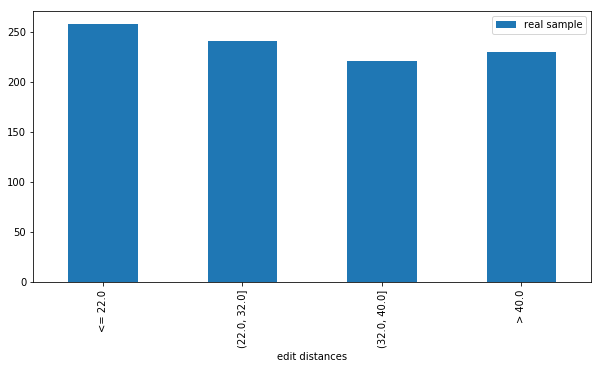

In [92]:
def plot_edit_distances_distribution(reference_sample_map, comparison_sample_map=None,
                                     reference_name='real sample', comparison_name='generated sample'):
    x_label = 'edit distances'
    df = pd.DataFrame.from_dict({
        x_label: list(reference_sample_map.keys()),
        reference_name: list(reference_sample_map.values())
    }).set_index(x_label)
    if comparison_sample_map:
        df2 = pd.DataFrame.from_dict({
            x_label: list(comparison_sample_map.keys()),
            comparison_name: list(comparison_sample_map.values())
        }).set_index(x_label)
        df[comparison_name] = df2[comparison_name]
    df.plot(kind='bar')
    
plot_edit_distances_distribution(real_sample_edit_dist_binned_map)

column:  Z-bidirectional.4
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.2


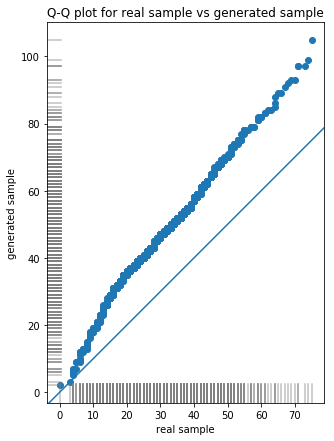

27.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 1070.2871671587538
p-value: 1.0166935135124307e-231


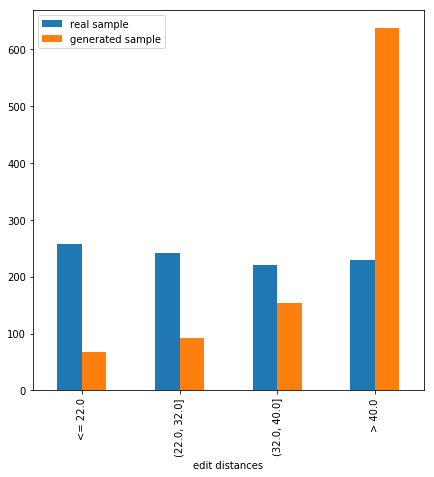

column:  Q-bidirectional.3
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.1


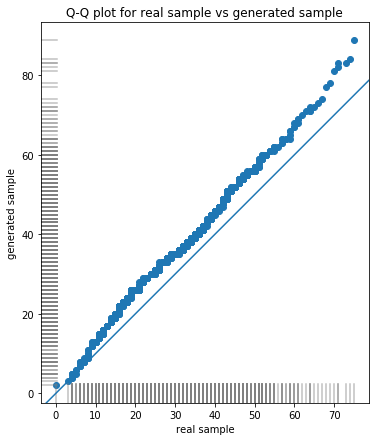

18.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 149.08641102500522
p-value: 4.148017262695126e-32


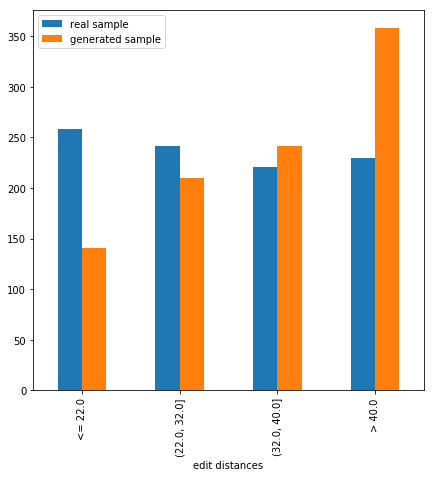

column:  X-bidirectional.3
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.1


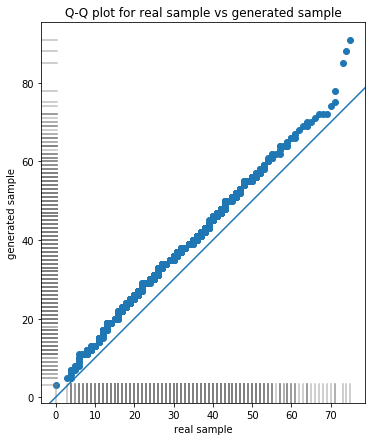

19.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 132.54686893244337
p-value: 1.5281928018232548e-28


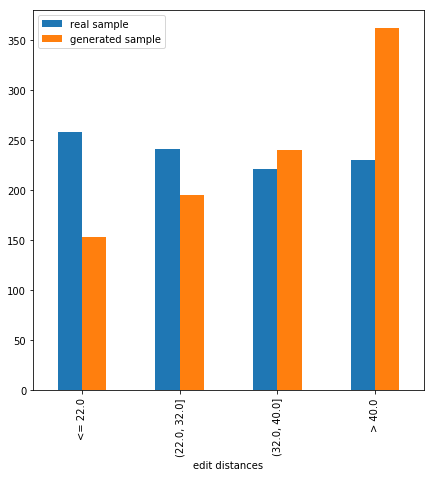

column:  Z-bidirectional.3
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.1


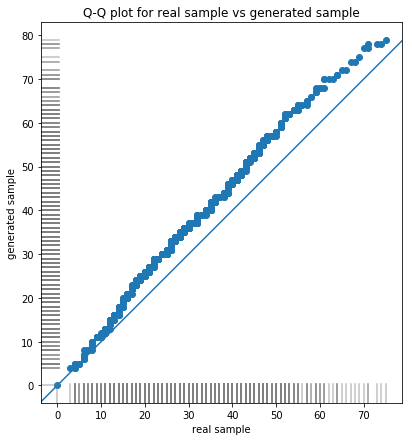

18.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 152.82301257847018
p-value: 6.482661378549816e-33


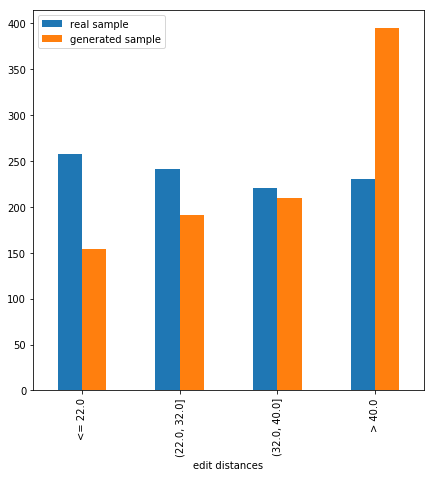

column:  V-bidirectional.3
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.1


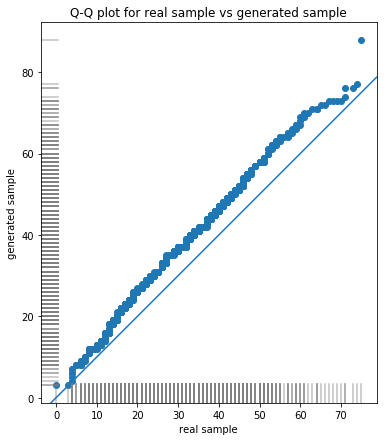

19.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 184.89871645912
p-value: 7.717754051638185e-40


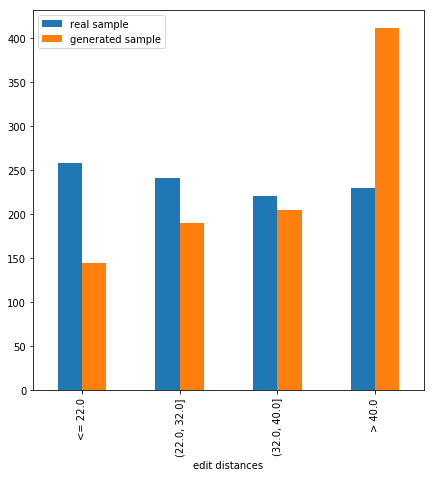

column:  Q-bidirectional.2
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0


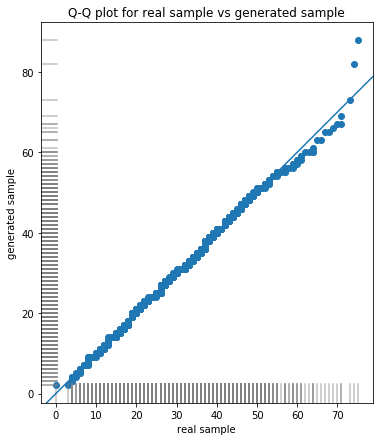

14.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 1.3842868966995625
p-value: 0.7092220683845967


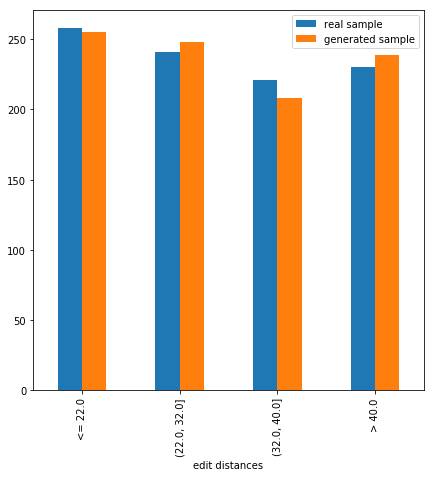

column:  Z-bidirectional.2
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.0


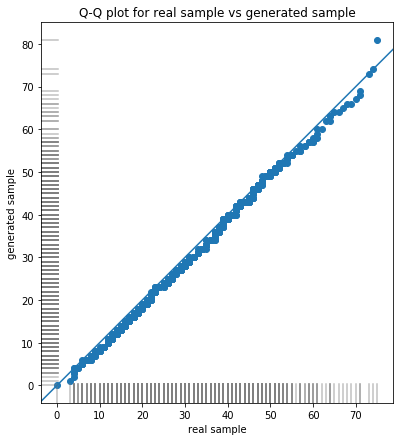

13.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 12.419519376921661
p-value: 0.006075905772723223


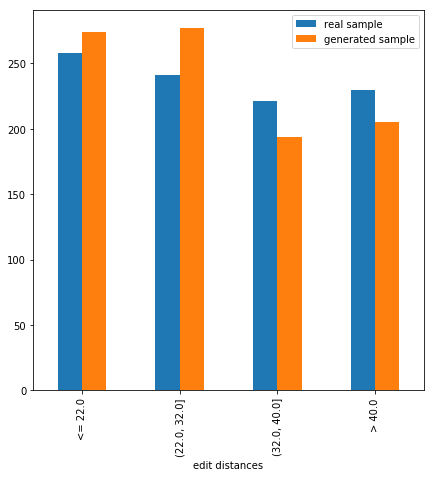

column:  V-bidirectional.2
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0


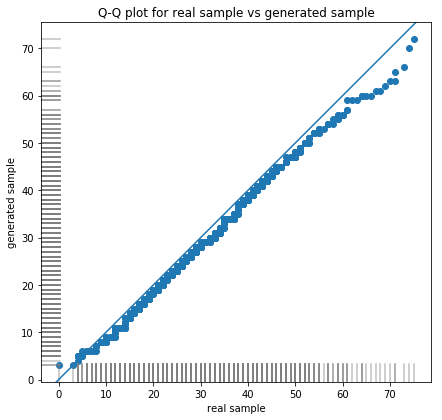

12.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 13.74185422182995
p-value: 0.003278446497239594


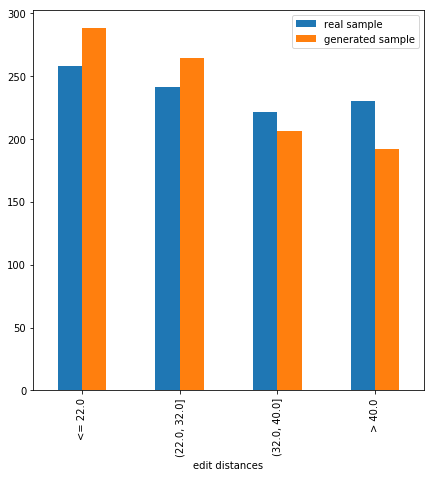

column:  Q-bidirectional.1
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.9


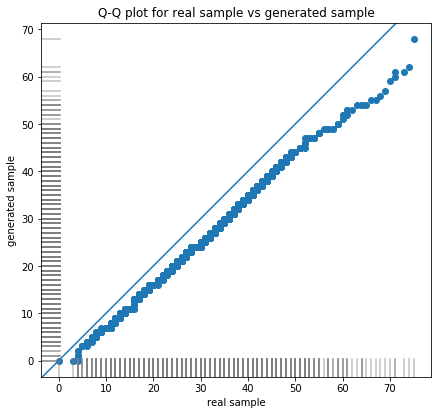

10.900000000000006 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 147.65937243371127
p-value: 8.426692117252955e-32


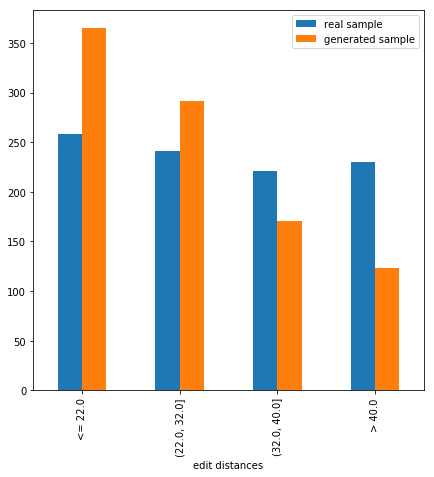

column:  V-bidirectional.1
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.9


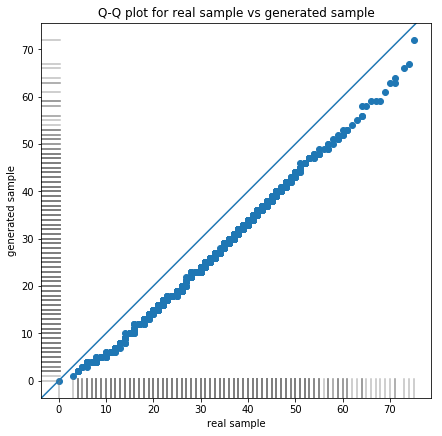

9.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 232.07141490011068
p-value: 4.93108935232111e-50


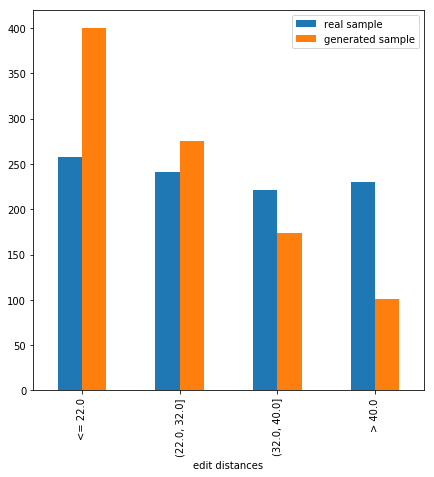

In [93]:
# Create Q-Q plot to compare each set of generated min edit distances to real sample of min edit distances

# Read in the real sample min edit distances
real_sample_min_edit_distances_filename = get_min_edit_distances_filename('real_sample_2000')
real_sample_min_edit_distances_list = read_min_edit_distances_from_file(real_sample_min_edit_distances_filename)

for column_name in models_matrix_df_best_10.columns:
    generated_sample_name = models_matrix_df_best_10.loc[generated_trajectories_name_idx][column_name]
    print('column: ', column_name)
    generated_sample_min_edit_distances_filename = get_min_edit_distances_filename(generated_sample_name)
    generated_sample_min_edit_distances_list = read_min_edit_distances_from_file(generated_sample_min_edit_distances_filename)
    print('creating Q-Q plot to compare real sample vs %s' % generated_sample_name)
    make_qq_plot(real_sample_min_edit_distances_list, generated_sample_min_edit_distances_list,
                'real sample', 'generated sample')
    plt.show()
    
    print('%s = %s' % (models_matrix_df.loc[min_edit_distances_bottom_10_quantile][column_name], min_edit_distances_bottom_10_quantile))
    
    # Chi-squared and bar plots
    max_edit_dist = max(generated_sample_min_edit_distances_list)
    if max_edit_dist > edit_dist_bins[-1]:
        edit_dist_bins[-1] = max_edit_dist
    min_edit_dist = min(generated_sample_min_edit_distances_list)
    if min_edit_dist < edit_dist_bins[0]:
        edit_dist_bins[0]  = min_edit_dist
    generated_sample_min_edit_dist_binned_series = pd.cut(generated_sample_min_edit_distances_list, bins=edit_dist_bins, labels=False, include_lowest=True)
    generated_sample_edit_dist_binned_map = get_binned_series_to_binned_map(generated_sample_min_edit_dist_binned_series, edit_dist_bins)
    
    plot_edit_distances_distribution(real_sample_edit_dist_binned_map, generated_sample_edit_dist_binned_map)
    chisq, p = chisquare(list(real_sample_edit_dist_binned_map.values()),
               f_exp=list(generated_sample_edit_dist_binned_map.values()))
    print('The chi-squared test statistic: %s\np-value: %s' % (chisq, p))
    plt.show()
    

older, clean up?

column:  Z-bidirectional
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.8


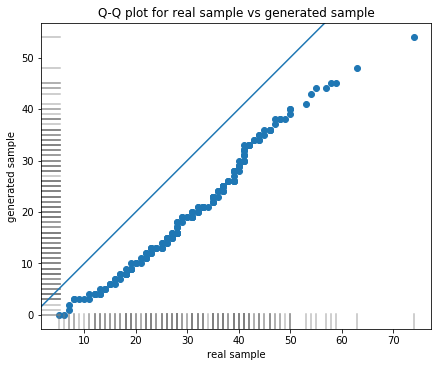

5.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 214.91337955829482
p-value: 2.5248247777680974e-46


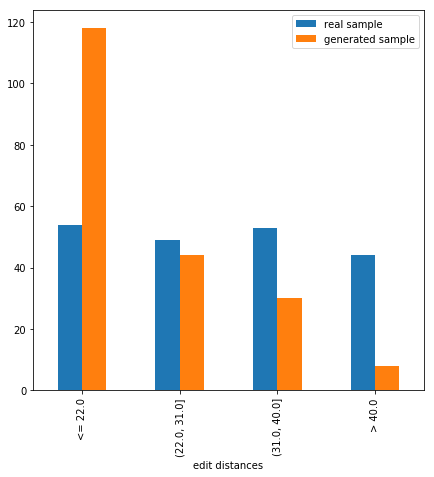

column:  Z-bidirectional.1
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.9


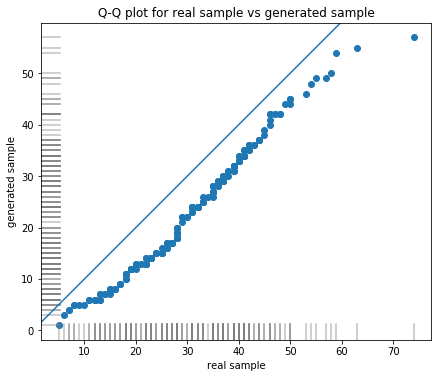

7.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 55.700221092830276
p-value: 4.867615945121643e-12


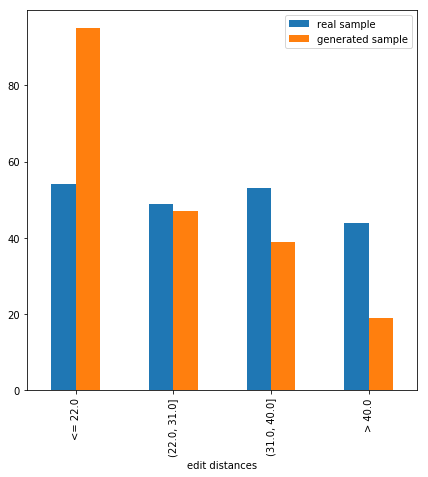

column:  Z-bidirectional.2
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.0


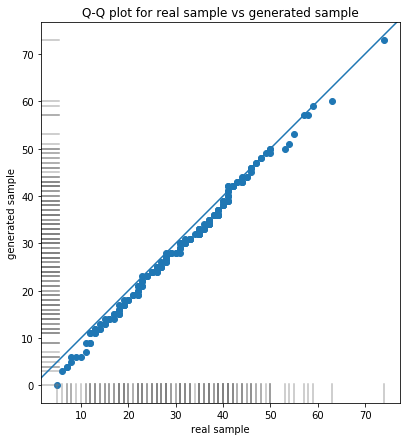

12.900000000000002 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 2.1605908098198143
p-value: 0.5397524063712575


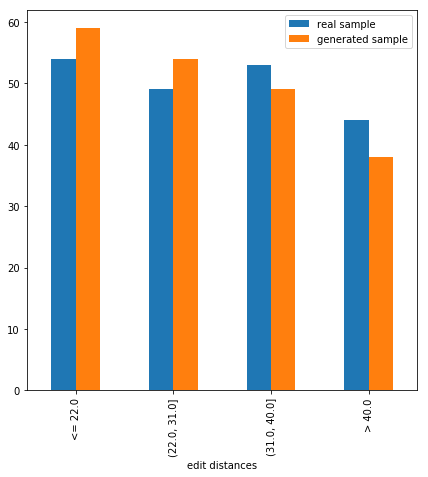

column:  Z-bidirectional.3
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.1


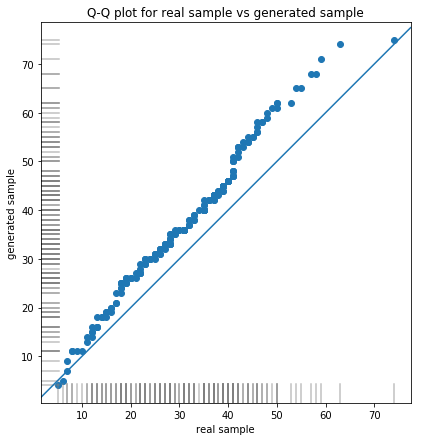

18.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 38.697460234160204
p-value: 2.01164594478252e-08


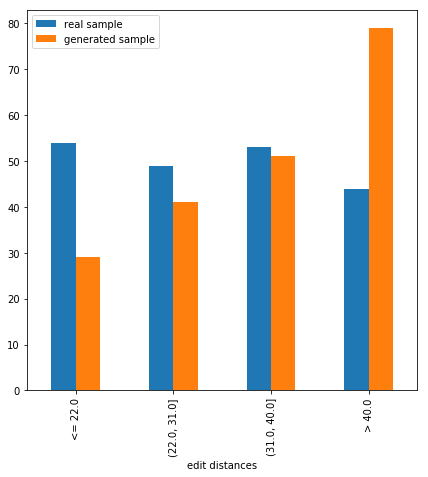

column:  Z-bidirectional.4
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:72-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:1.2


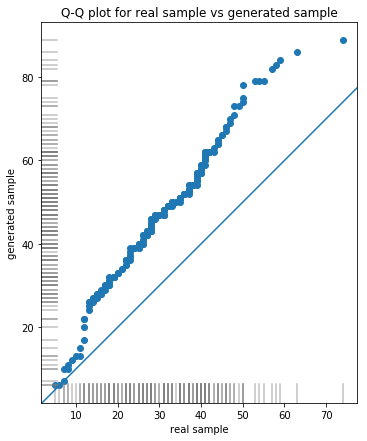

27.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 214.93203267320916
p-value: 2.501493877880658e-46


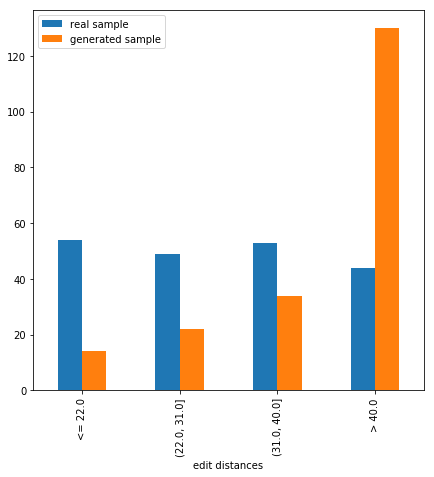

column:  V-bidirectional.1
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.9


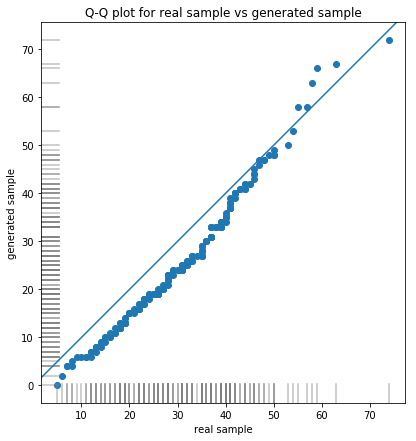

9.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 26.369792127377266
p-value: 7.979700774498818e-06


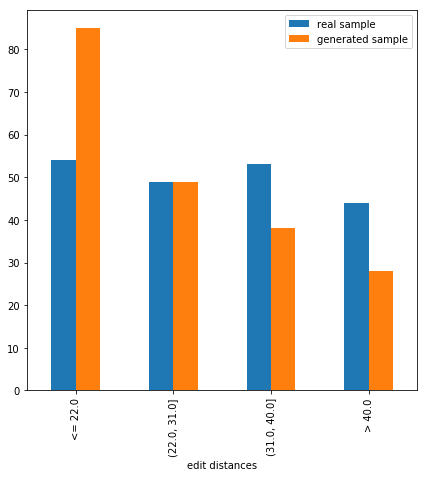

column:  V-bidirectional.2
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0


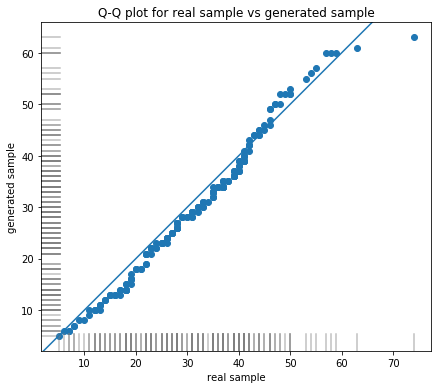

12.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 4.165742227412057
p-value: 0.2441141967098515


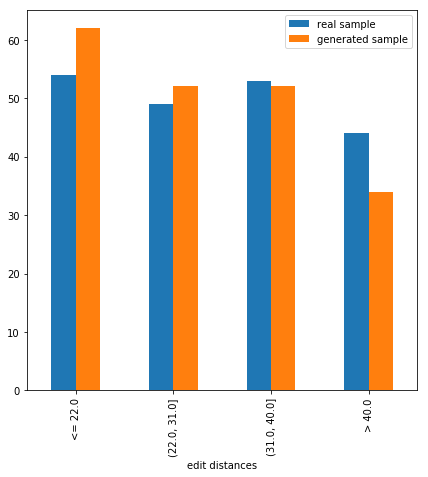

column:  V-bidirectional
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.8


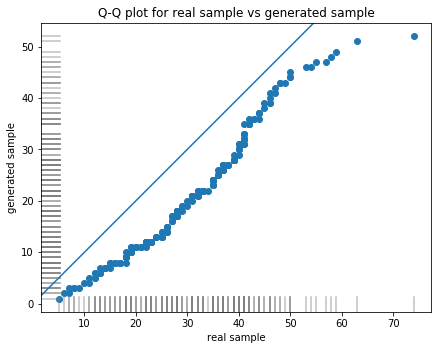

7.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 106.38948212777933
p-value: 6.564973275156654e-23


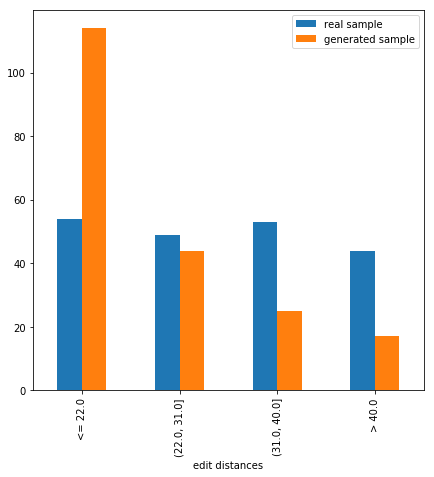

column:  Q-bidirectional.1
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.9


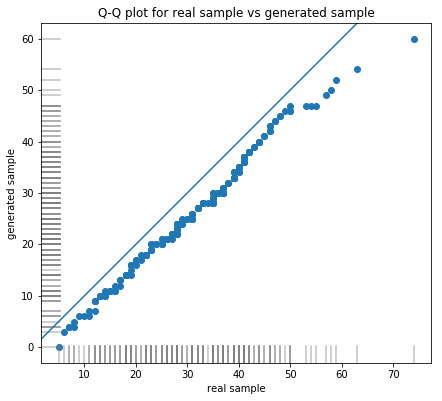

10.900000000000002 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 35.72771618625277
p-value: 8.549678853395228e-08


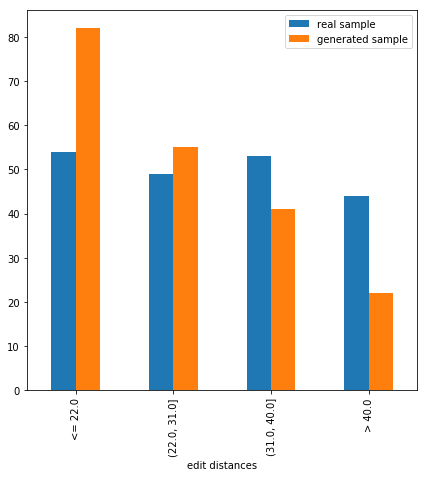

column:  Q-bidirectional.3
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.1


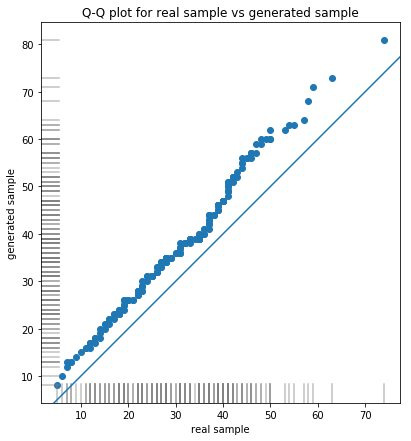

19.900000000000002 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 38.761053787777925
p-value: 1.950211947127845e-08


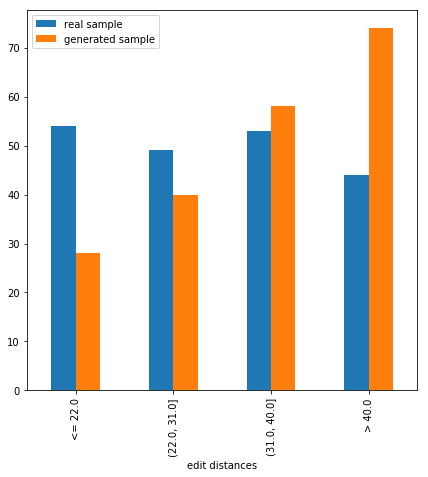

column:  Q-bidirectional.2
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.0


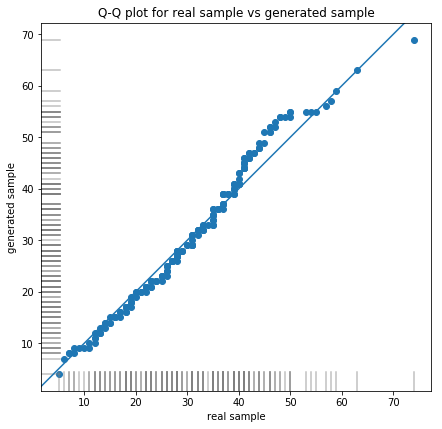

14.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 8.320304232804233
p-value: 0.03983565744573894


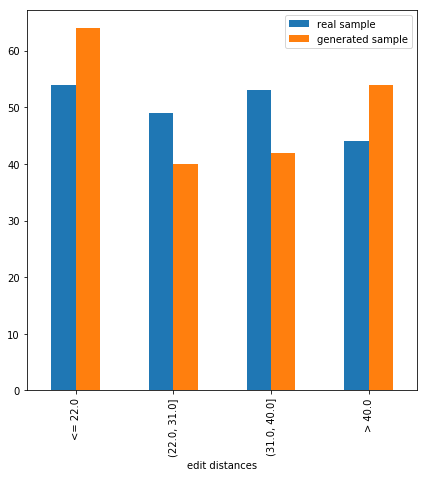

column:  V-bidirectional.3
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:70-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:1.1


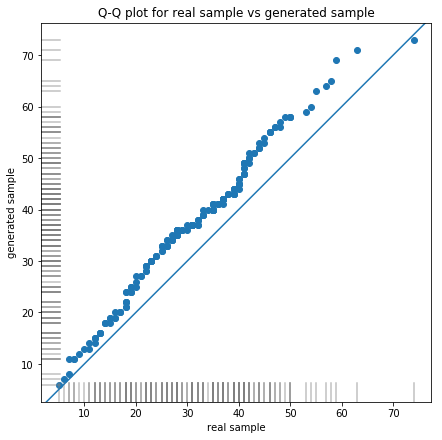

18.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 42.54498746867168
p-value: 3.0740275953123493e-09


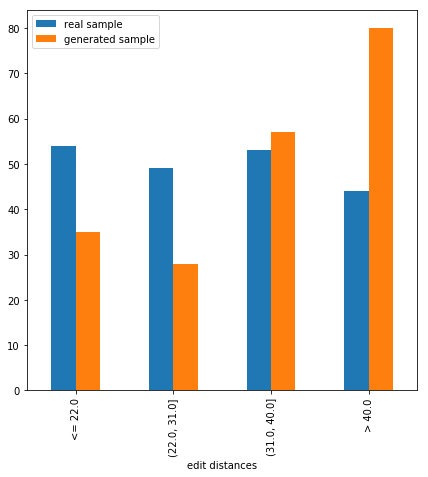

column:  Q-bidirectional
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.1-dim_embeddings:128-temperature:0.8


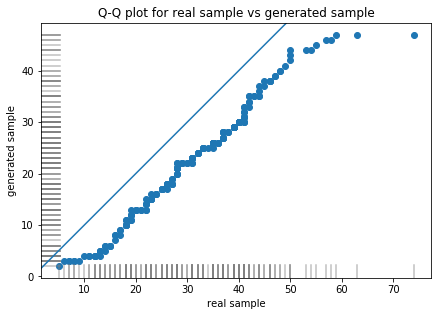

6.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 140.13397688222432
p-value: 3.5364862055993625e-30


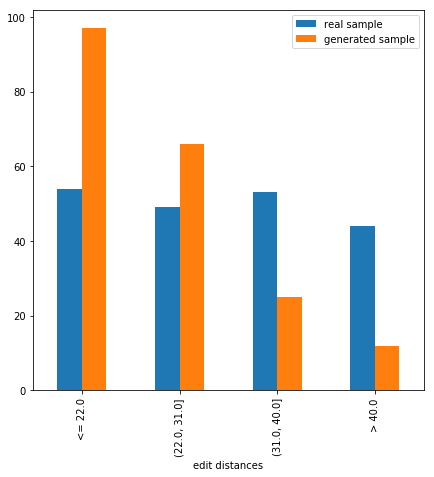

column:  X-bidirectional.3
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.1


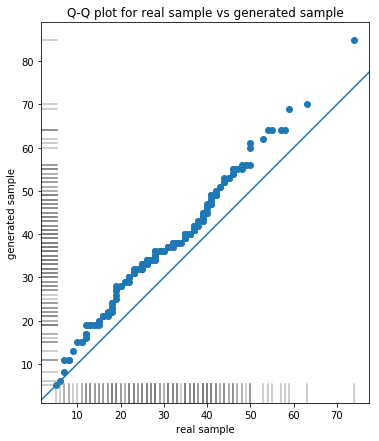

19.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 47.413549945457376
p-value: 2.838283885610483e-10


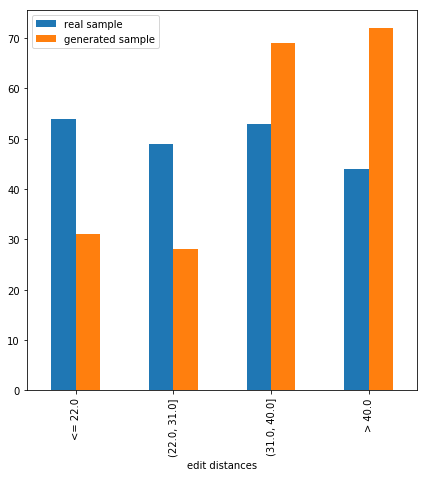

column:  X-bidirectional.1
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:0.9


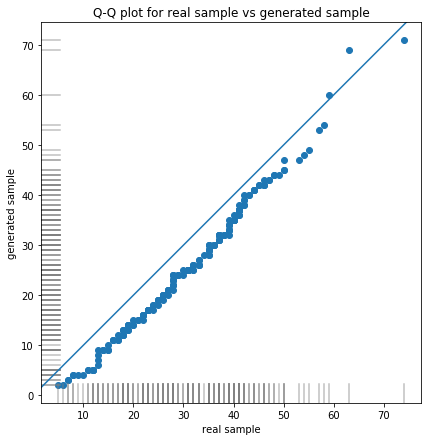

9.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 25.47502096297277
p-value: 1.2283108424781017e-05


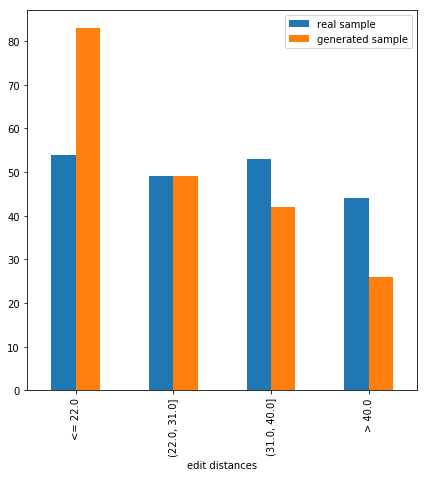

column:  X-bidirectional.2
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.0


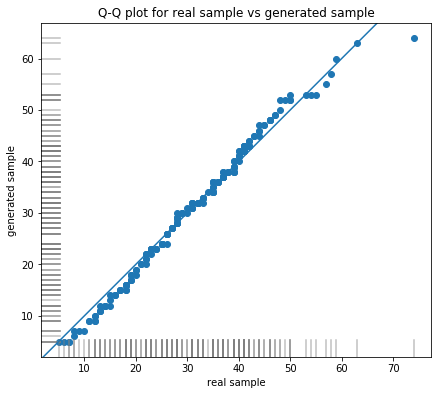

12.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 1.384795008912656
p-value: 0.7091027043874282


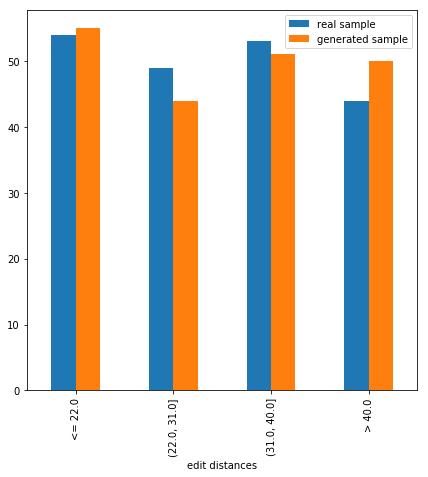

column:  X-bidirectional
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:60-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:0.8


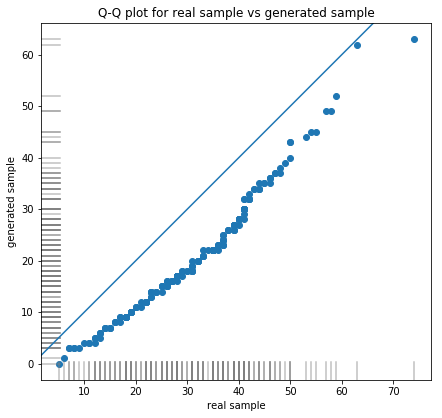

7.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 189.313
p-value: 8.590348906599752e-41


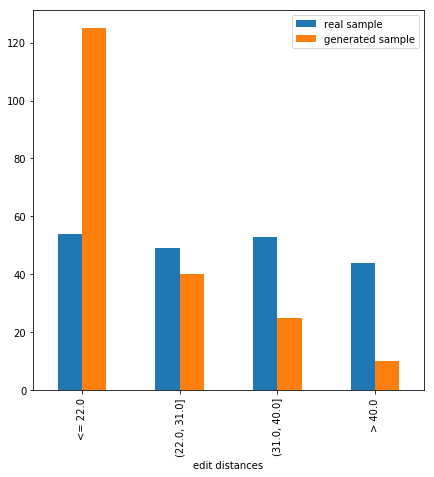

column:  P-bidirectional.2
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.0


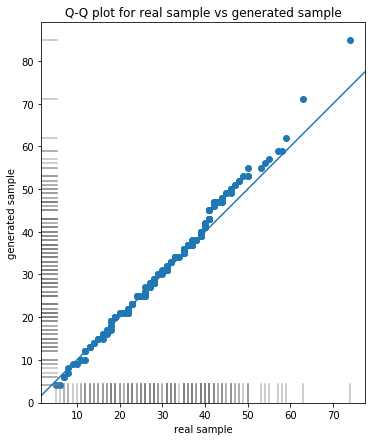

14.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 1.4829670998834317
p-value: 0.6862070575648471


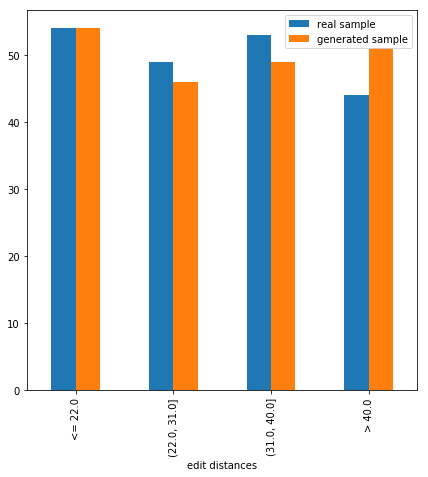

column:  P-bidirectional.3
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:3-rnn_size:128-dropout:0.2-dim_embeddings:128-temperature:1.1


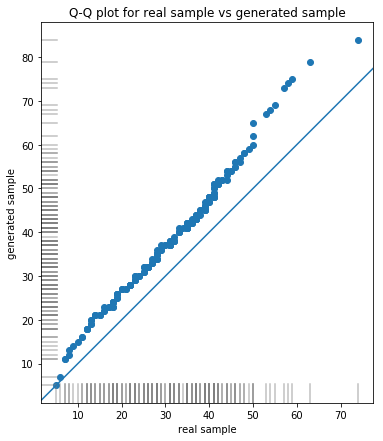

21.0 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 55.2440635451505
p-value: 6.0903906693601794e-12


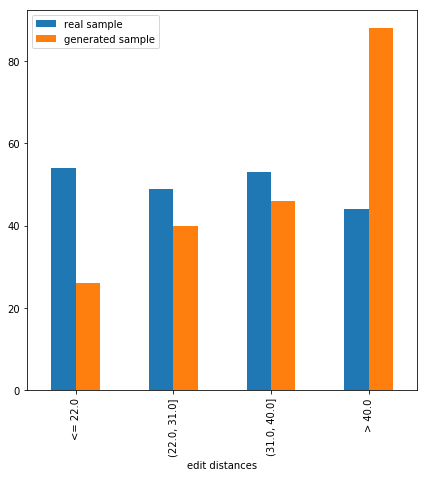

column:  T-bidirectional.1
creating Q-Q plot to compare real sample vs generated-sample-trajectories-rnn_bidirectional:True-max_len:50-rnn_layers:2-rnn_size:256-dropout:0.3-dim_embeddings:100-temperature:0.9


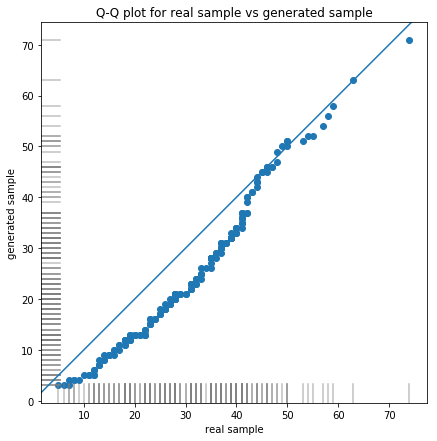

8.900000000000002 = Bottom 10th quantile value over all minimum edit distances for generated vs real vectors
The chi-squared test statistic: 44.93962820715869
p-value: 9.530129518311094e-10


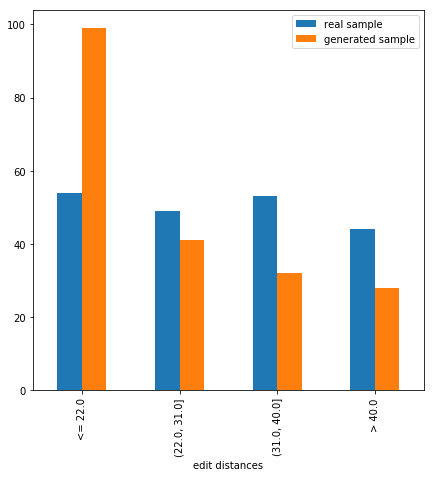

In [178]:
# Create Q-Q plot to compare each set of generated min edit distances to real sample of min edit distances

# Read in the real sample min edit distances
real_sample_min_edit_distances_filename = get_min_edit_distances_filename('real_sample_2000_200') # uses limit=200 subsample
real_sample_min_edit_distances_list = read_min_edit_distances_from_file(real_sample_min_edit_distances_filename)

for column_name in models_matrix_df.columns:
    generated_sample_name = models_matrix_df.loc[generated_trajectories_name_idx][column_name]
    if generated_sample_name not in generated_sample_names:
        continue
    print('column: ', column_name)
    generated_sample_min_edit_distances_filename = get_min_edit_distances_filename(generated_sample_name)
    generated_sample_min_edit_distances_list = read_min_edit_distances_from_file(generated_sample_min_edit_distances_filename)
    print('creating Q-Q plot to compare real sample vs %s' % generated_sample_name)
    make_qq_plot(real_sample_min_edit_distances_list, generated_sample_min_edit_distances_list,
                'real sample', 'generated sample')
    plt.show()
    
    print('%s = %s' % (models_matrix_df.loc[min_edit_distances_bottom_10_quantile][column_name], min_edit_distances_bottom_10_quantile))
    
    # Chi-squared and bar plots
    max_edit_dist = max(generated_sample_min_edit_distances_list)
    if max_edit_dist > edit_dist_bins[-1]:
        edit_dist_bins[-1] = max_edit_dist
    min_edit_dist = min(generated_sample_min_edit_distances_list)
    if min_edit_dist < edit_dist_bins[0]:
        edit_dist_bins[0]  = min_edit_dist
    generated_sample_min_edit_dist_binned_series = pd.cut(generated_sample_min_edit_distances_list, bins=edit_dist_bins, labels=False, include_lowest=True)
    generated_sample_edit_dist_binned_map = get_binned_series_to_binned_map(generated_sample_min_edit_dist_binned_series, edit_dist_bins)
    
    plot_edit_distances_distribution(real_sample_edit_dist_binned_map, generated_sample_edit_dist_binned_map)
    chisq, p = chisquare(list(real_sample_edit_dist_binned_map.values()),
               f_exp=list(generated_sample_edit_dist_binned_map.values()))
    print('The chi-squared test statistic: %s\np-value: %s' % (chisq, p))
    plt.show()
    